In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, Flatten, Dense
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_FILE = 'data/train_data.h5'
VAL_DATA_FILE = 'data/val_data.h5'
TEST_DATA_FILE = 'data/test_data.h5'
METADATA = 'metadata.npy'

metadata = np.load(METADATA).item()

VALIDATION AND TEST DATASET

In [3]:
val_f = h5py.File(VAL_DATA_FILE, 'r')

X_val = np.asarray(val_f['x'])
y_val = np.asarray(val_f['y'])

test_f = h5py.File(TEST_DATA_FILE, 'r')

X_test = np.asarray(test_f['x'])
y_test = np.asarray(test_f['y'])

METRICS

In [4]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [5]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [6]:
train_f = h5py.File(DATA_FILE, 'r')

train_data_x = train_f['x']
train_data_y = train_f['y']

X_train = np.asarray(train_data_x)
y_train = np.asarray(train_data_y)

In [7]:
lr = 0.05
n_conv_layers = 3
n_kernels = [128] * n_conv_layers
mp_sizes = [(2,2) for _ in range(n_conv_layers)]

model = Sequential()
model.add(BatchNormalization(axis=3, input_shape=train_data_x.shape[1:]))
for i in range(n_conv_layers):
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_uniform"))
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    if i < n_conv_layers - 1:
        model.add(MaxPooling2D(mp_sizes[i]))
        model.add(Dropout(0.5))

model.add(Conv2D(8, (3, 3), padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))
model.compile(Adam(lr), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", kernel_initializer="he_uniform")`
  if __name__ == '__main__':


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same")`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 4, 7, 512)         2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 7, 128)         589952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 4, 7, 128)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 3, 128)         147584    
__________

In [9]:
model_filepath = 'models/Model.h5'
callbacks = [ModelCheckpoint(model_filepath, monitor='val_f1', verbose=1, save_best_only=True, mode="max")]
model.fit(X_train, y_train, batch_size=128, nb_epoch=50,
          validation_data=(X_val, y_val), callbacks=callbacks)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 9133 samples, validate on 370 samples
Epoch 1/50


 128/9133 [..............................] - ETA: 53s - loss: 2.2107 - acc: 0.3359 - recall: 0.2656 - precision: 0.3579 - f1: 0.3049

 256/9133 [..............................] - ETA: 49s - loss: 2.4159 - acc: 0.3516 - recall: 0.3164 - precision: 0.3640 - f1: 0.3368

 384/9133 [>.............................] - ETA: 44s - loss: 2.2614 - acc: 0.3776 - recall: 0.3177 - precision: 0.4325 - f1: 0.3612

 512/9133 [>.............................] - ETA: 42s - loss: 2.2108 - acc: 0.3926 - recall: 0.2973 - precision: 0.4583 - f1: 0.3529

 640/9133 [=>............................] - ETA: 40s - loss: 2.1250 - acc: 0.3906 - recall: 0.2707 - precision: 0.4490 - f1: 0.3292

 768/9133 [=>............................] - ETA: 39s - loss: 2.0438 - acc: 0.4154 - recall: 0.2568 - precision: 0.4884 - f1: 0.3234

 896/9133 [=>............................] - ETA: 38s - loss: 1.9760 - acc: 0.4230 - recall: 0.2335 - precision: 0.5044 - f1: 0.3004

1024/9133 [==>...........................] - ETA: 38s - loss: 1.9466 - acc: 0.4189 - recall: 0.2190 - precision: 0.5400 - f1: 0.2883

1152/9133 [==>...........................] - ETA: 37s - loss: 1.9234 - acc: 0.4271 - recall: 0.2068 - precision: 0.5664 - f1: 0.2776

1280/9133 [===>..........................] - ETA: 36s - loss: 1.8882 - acc: 0.4313 - recall: 0.1971 - precision: 0.5798 - f1: 0.2688

1408/9133 [===>..........................] - ETA: 36s - loss: 1.8611 - acc: 0.4375 - recall: 0.1926 - precision: 0.5847 - f1: 0.2662

1536/9133 [====>.........................] - ETA: 35s - loss: 1.8265 - acc: 0.4434 - recall: 0.1909 - precision: 0.5951 - f1: 0.2671

1664/9133 [====>.........................] - ETA: 34s - loss: 1.8024 - acc: 0.4459 - recall: 0.1864 - precision: 0.5996 - f1: 0.2635

1792/9133 [====>.........................] - ETA: 34s - loss: 1.7747 - acc: 0.4531 - recall: 0.1871 - precision: 0.6064 - f1: 0.2665

1920/9133 [=====>........................] - ETA: 33s - loss: 1.7460 - acc: 0.4604 - recall: 0.1897 - precision: 0.6182 - f1: 0.2721

2048/9133 [=====>........................] - ETA: 32s - loss: 1.7324 - acc: 0.4644 - recall: 0.1910 - precision: 0.6162 - f1: 0.2745

2176/9133 [======>.......................] - ETA: 31s - loss: 1.7194 - acc: 0.4697 - recall: 0.1936 - precision: 0.6139 - f1: 0.2780

2304/9133 [======>.......................] - ETA: 31s - loss: 1.7027 - acc: 0.4722 - recall: 0.2011 - precision: 0.6175 - f1: 0.2871

2432/9133 [======>.......................] - ETA: 30s - loss: 1.6889 - acc: 0.4753 - recall: 0.2102 - precision: 0.6200 - f1: 0.2973

2560/9133 [=======>......................] - ETA: 29s - loss: 1.6714 - acc: 0.4754 - recall: 0.2161 - precision: 0.6219 - f1: 0.3043

2688/9133 [=======>......................] - ETA: 29s - loss: 1.6550 - acc: 0.4769 - recall: 0.2229 - precision: 0.6245 - f1: 0.3121

2816/9133 [========>.....................] - ETA: 28s - loss: 1.6386 - acc: 0.4826 - recall: 0.2298 - precision: 0.6337 - f1: 0.3214

2944/9133 [========>.....................] - ETA: 27s - loss: 1.6226 - acc: 0.4871 - recall: 0.2348 - precision: 0.6380 - f1: 0.3278

3072/9133 [=========>....................] - ETA: 27s - loss: 1.6078 - acc: 0.4909 - recall: 0.2400 - precision: 0.6424 - f1: 0.3343

3200/9133 [=========>....................] - ETA: 26s - loss: 1.5922 - acc: 0.4944 - recall: 0.2430 - precision: 0.6438 - f1: 0.3381

3328/9133 [=========>....................] - ETA: 26s - loss: 1.5863 - acc: 0.4946 - recall: 0.2457 - precision: 0.6455 - f1: 0.3417

3456/9133 [==========>...................] - ETA: 25s - loss: 1.5713 - acc: 0.4986 - recall: 0.2519 - precision: 0.6518 - f1: 0.3494

3584/9133 [==========>...................] - ETA: 24s - loss: 1.5555 - acc: 0.5014 - recall: 0.2558 - precision: 0.6569 - f1: 0.3546

3712/9133 [===========>..................] - ETA: 24s - loss: 1.5440 - acc: 0.5038 - recall: 0.2602 - precision: 0.6598 - f1: 0.3598

3840/9133 [===========>..................] - ETA: 23s - loss: 1.5374 - acc: 0.5062 - recall: 0.2646 - precision: 0.6620 - f1: 0.3648

3968/9133 [============>.................] - ETA: 23s - loss: 1.5249 - acc: 0.5098 - recall: 0.2696 - precision: 0.6659 - f1: 0.3707

4096/9133 [============>.................] - ETA: 22s - loss: 1.5230 - acc: 0.5088 - recall: 0.2715 - precision: 0.6628 - f1: 0.3721

4224/9133 [============>.................] - ETA: 21s - loss: 1.5129 - acc: 0.5111 - recall: 0.2753 - precision: 0.6661 - f1: 0.3767

4352/9133 [=============>................] - ETA: 21s - loss: 1.5034 - acc: 0.5145 - recall: 0.2792 - precision: 0.6694 - f1: 0.3814

4480/9133 [=============>................] - ETA: 20s - loss: 1.4928 - acc: 0.5176 - recall: 0.2821 - precision: 0.6752 - f1: 0.3857

4608/9133 [==============>...............] - ETA: 20s - loss: 1.4864 - acc: 0.5189 - recall: 0.2836 - precision: 0.6764 - f1: 0.3877

4736/9133 [==============>...............] - ETA: 19s - loss: 1.4747 - acc: 0.5213 - recall: 0.2869 - precision: 0.6797 - f1: 0.3918

4864/9133 [==============>...............] - ETA: 19s - loss: 1.4612 - acc: 0.5247 - recall: 0.2919 - precision: 0.6830 - f1: 0.3972

4992/9133 [===============>..............] - ETA: 18s - loss: 1.4516 - acc: 0.5282 - recall: 0.2979 - precision: 0.6862 - f1: 0.4033

5120/9133 [===============>..............] - ETA: 17s - loss: 1.4424 - acc: 0.5309 - recall: 0.3015 - precision: 0.6888 - f1: 0.4074

5248/9133 [================>.............] - ETA: 17s - loss: 1.4312 - acc: 0.5333 - recall: 0.3061 - precision: 0.6902 - f1: 0.4119

5376/9133 [================>.............] - ETA: 16s - loss: 1.4283 - acc: 0.5340 - recall: 0.3097 - precision: 0.6893 - f1: 0.4149

5504/9133 [=================>............] - ETA: 16s - loss: 1.4251 - acc: 0.5342 - recall: 0.3128 - precision: 0.6883 - f1: 0.4175

5632/9133 [=================>............] - ETA: 15s - loss: 1.4176 - acc: 0.5362 - recall: 0.3176 - precision: 0.6887 - f1: 0.4217

5760/9133 [=================>............] - ETA: 15s - loss: 1.4121 - acc: 0.5370 - recall: 0.3205 - precision: 0.6880 - f1: 0.4241

5888/9133 [==================>...........] - ETA: 14s - loss: 1.4072 - acc: 0.5389 - recall: 0.3242 - precision: 0.6889 - f1: 0.4277

6016/9133 [==================>...........] - ETA: 13s - loss: 1.4022 - acc: 0.5397 - recall: 0.3274 - precision: 0.6896 - f1: 0.4308

6144/9133 [===================>..........] - ETA: 13s - loss: 1.3942 - acc: 0.5423 - recall: 0.3314 - precision: 0.6916 - f1: 0.4348

6272/9133 [===================>..........] - ETA: 12s - loss: 1.3826 - acc: 0.5462 - recall: 0.3365 - precision: 0.6959 - f1: 0.4403

6400/9133 [====================>.........] - ETA: 12s - loss: 1.3758 - acc: 0.5473 - recall: 0.3399 - precision: 0.6971 - f1: 0.4437

6528/9133 [====================>.........] - ETA: 11s - loss: 1.3710 - acc: 0.5489 - recall: 0.3423 - precision: 0.6975 - f1: 0.4460

6656/9133 [====================>.........] - ETA: 11s - loss: 1.3653 - acc: 0.5502 - recall: 0.3449 - precision: 0.6991 - f1: 0.4488

6784/9133 [=====================>........] - ETA: 10s - loss: 1.3572 - acc: 0.5519 - recall: 0.3478 - precision: 0.7014 - f1: 0.4521

6912/9133 [=====================>........] - ETA: 9s - loss: 1.3513 - acc: 0.5532 - recall: 0.3510 - precision: 0.7036 - f1: 0.4555 

7040/9133 [======================>.......] - ETA: 9s - loss: 1.3447 - acc: 0.5551 - recall: 0.3529 - precision: 0.7054 - f1: 0.4578

7168/9133 [======================>.......] - ETA: 8s - loss: 1.3390 - acc: 0.5562 - recall: 0.3552 - precision: 0.7077 - f1: 0.4605

7296/9133 [======================>.......] - ETA: 8s - loss: 1.3355 - acc: 0.5572 - recall: 0.3578 - precision: 0.7098 - f1: 0.4634

7424/9133 [=======================>......] - ETA: 7s - loss: 1.3309 - acc: 0.5582 - recall: 0.3604 - precision: 0.7110 - f1: 0.4661

7552/9133 [=======================>......] - ETA: 6s - loss: 1.3270 - acc: 0.5595 - recall: 0.3628 - precision: 0.7122 - f1: 0.4685

7680/9133 [========================>.....] - ETA: 6s - loss: 1.3201 - acc: 0.5609 - recall: 0.3653 - precision: 0.7133 - f1: 0.4710

7808/9133 [========================>.....] - ETA: 5s - loss: 1.3120 - acc: 0.5631 - recall: 0.3686 - precision: 0.7155 - f1: 0.4744

7936/9133 [=========================>....] - ETA: 5s - loss: 1.3066 - acc: 0.5644 - recall: 0.3712 - precision: 0.7161 - f1: 0.4768

8064/9133 [=========================>....] - ETA: 4s - loss: 1.3004 - acc: 0.5663 - recall: 0.3741 - precision: 0.7182 - f1: 0.4798

8192/9133 [=========================>....] - ETA: 4s - loss: 1.2951 - acc: 0.5686 - recall: 0.3769 - precision: 0.7201 - f1: 0.4828

8320/9133 [==========================>...] - ETA: 3s - loss: 1.2872 - acc: 0.5712 - recall: 0.3809 - precision: 0.7217 - f1: 0.4864

8448/9133 [==========================>...] - ETA: 3s - loss: 1.2835 - acc: 0.5720 - recall: 0.3834 - precision: 0.7224 - f1: 0.4887

8576/9133 [===========================>..] - ETA: 2s - loss: 1.2787 - acc: 0.5728 - recall: 0.3856 - precision: 0.7237 - f1: 0.4910

8704/9133 [===========================>..] - ETA: 1s - loss: 1.2757 - acc: 0.5731 - recall: 0.3877 - precision: 0.7234 - f1: 0.4927

8832/9133 [============================>.] - ETA: 1s - loss: 1.2712 - acc: 0.5738 - recall: 0.3899 - precision: 0.7236 - f1: 0.4945

8960/9133 [============================>.] - ETA: 0s - loss: 1.2661 - acc: 0.5753 - recall: 0.3925 - precision: 0.7246 - f1: 0.4970

9088/9133 [============================>.] - ETA: 0s - loss: 1.2606 - acc: 0.5766 - recall: 0.3948 - precision: 0.7253 - f1: 0.4991

Epoch 00000: val_f1 improved from -inf to 0.68879, saving model to models/Model.h5


9133/9133 [==============================] - 41s - loss: 1.2589 - acc: 0.5769 - recall: 0.3956 - precision: 0.7257 - f1: 0.4998 - val_loss: 1.9764 - val_acc: 0.6784 - val_recall: 0.6719 - val_precision: 0.7066 - val_f1: 0.6888


Epoch 2/50


 128/9133 [..............................] - ETA: 72s - loss: 0.9065 - acc: 0.6797 - recall: 0.6016 - precision: 0.8280 - f1: 0.6968

 256/9133 [..............................] - ETA: 68s - loss: 0.8938 - acc: 0.6719 - recall: 0.5898 - precision: 0.8118 - f1: 0.6833

 384/9133 [>.............................] - ETA: 65s - loss: 0.9370 - acc: 0.6615 - recall: 0.5599 - precision: 0.7922 - f1: 0.6558

 512/9133 [>.............................] - ETA: 71s - loss: 0.9027 - acc: 0.6836 - recall: 0.5566 - precision: 0.8185 - f1: 0.6618

 640/9133 [=>............................] - ETA: 77s - loss: 0.8874 - acc: 0.6906 - recall: 0.5594 - precision: 0.8420 - f1: 0.6712

 768/9133 [=>............................] - ETA: 74s - loss: 0.8740 - acc: 0.6914 - recall: 0.5651 - precision: 0.8456 - f1: 0.6766

 896/9133 [=>............................] - ETA: 69s - loss: 0.8577 - acc: 0.6987 - recall: 0.5670 - precision: 0.8492 - f1: 0.6792

1024/9133 [==>...........................] - ETA: 64s - loss: 0.8504 - acc: 0.6982 - recall: 0.5713 - precision: 0.8443 - f1: 0.6806

1152/9133 [==>...........................] - ETA: 59s - loss: 0.8331 - acc: 0.7092 - recall: 0.5781 - precision: 0.8494 - f1: 0.6872

1280/9133 [===>..........................] - ETA: 56s - loss: 0.8409 - acc: 0.7031 - recall: 0.5781 - precision: 0.8408 - f1: 0.6842

1408/9133 [===>..........................] - ETA: 54s - loss: 0.8381 - acc: 0.7045 - recall: 0.5838 - precision: 0.8396 - f1: 0.6877

1536/9133 [====>.........................] - ETA: 51s - loss: 0.8202 - acc: 0.7135 - recall: 0.5964 - precision: 0.8429 - f1: 0.6971

1664/9133 [====>.........................] - ETA: 48s - loss: 0.8137 - acc: 0.7121 - recall: 0.6010 - precision: 0.8433 - f1: 0.7004

1792/9133 [====>.........................] - ETA: 46s - loss: 0.8072 - acc: 0.7154 - recall: 0.6049 - precision: 0.8425 - f1: 0.7028

1920/9133 [=====>........................] - ETA: 45s - loss: 0.7980 - acc: 0.7177 - recall: 0.6099 - precision: 0.8421 - f1: 0.7059

2048/9133 [=====>........................] - ETA: 43s - loss: 0.7900 - acc: 0.7212 - recall: 0.6136 - precision: 0.8420 - f1: 0.7084

2176/9133 [======>.......................] - ETA: 42s - loss: 0.8013 - acc: 0.7165 - recall: 0.6106 - precision: 0.8366 - f1: 0.7045

2304/9133 [======>.......................] - ETA: 40s - loss: 0.8003 - acc: 0.7166 - recall: 0.6108 - precision: 0.8348 - f1: 0.7041

2432/9133 [======>.......................] - ETA: 39s - loss: 0.8033 - acc: 0.7155 - recall: 0.6107 - precision: 0.8315 - f1: 0.7029

2560/9133 [=======>......................] - ETA: 37s - loss: 0.8040 - acc: 0.7145 - recall: 0.6110 - precision: 0.8299 - f1: 0.7025

2688/9133 [=======>......................] - ETA: 36s - loss: 0.7984 - acc: 0.7147 - recall: 0.6136 - precision: 0.8304 - f1: 0.7044

2816/9133 [========>.....................] - ETA: 35s - loss: 0.8015 - acc: 0.7148 - recall: 0.6152 - precision: 0.8273 - f1: 0.7043

2944/9133 [========>.....................] - ETA: 34s - loss: 0.7957 - acc: 0.7177 - recall: 0.6163 - precision: 0.8288 - f1: 0.7056

3072/9133 [=========>....................] - ETA: 33s - loss: 0.7986 - acc: 0.7161 - recall: 0.6153 - precision: 0.8276 - f1: 0.7046

3200/9133 [=========>....................] - ETA: 32s - loss: 0.7957 - acc: 0.7178 - recall: 0.6160 - precision: 0.8269 - f1: 0.7048

3328/9133 [=========>....................] - ETA: 31s - loss: 0.7924 - acc: 0.7197 - recall: 0.6176 - precision: 0.8274 - f1: 0.7061

3456/9133 [==========>...................] - ETA: 30s - loss: 0.7888 - acc: 0.7216 - recall: 0.6196 - precision: 0.8274 - f1: 0.7074

3584/9133 [==========>...................] - ETA: 29s - loss: 0.7965 - acc: 0.7199 - recall: 0.6178 - precision: 0.8247 - f1: 0.7053

3712/9133 [===========>..................] - ETA: 28s - loss: 0.7953 - acc: 0.7214 - recall: 0.6191 - precision: 0.8271 - f1: 0.7071

3840/9133 [===========>..................] - ETA: 27s - loss: 0.7900 - acc: 0.7227 - recall: 0.6201 - precision: 0.8284 - f1: 0.7082

3968/9133 [============>.................] - ETA: 26s - loss: 0.7866 - acc: 0.7248 - recall: 0.6218 - precision: 0.8281 - f1: 0.7092

4096/9133 [============>.................] - ETA: 26s - loss: 0.7843 - acc: 0.7261 - recall: 0.6243 - precision: 0.8282 - f1: 0.7108

4224/9133 [============>.................] - ETA: 25s - loss: 0.7814 - acc: 0.7273 - recall: 0.6255 - precision: 0.8286 - f1: 0.7118

4352/9133 [=============>................] - ETA: 25s - loss: 0.7770 - acc: 0.7295 - recall: 0.6292 - precision: 0.8297 - f1: 0.7145

4480/9133 [=============>................] - ETA: 24s - loss: 0.7742 - acc: 0.7299 - recall: 0.6294 - precision: 0.8294 - f1: 0.7146

4608/9133 [==============>...............] - ETA: 23s - loss: 0.7726 - acc: 0.7309 - recall: 0.6319 - precision: 0.8292 - f1: 0.7160

4736/9133 [==============>...............] - ETA: 23s - loss: 0.7705 - acc: 0.7316 - recall: 0.6334 - precision: 0.8278 - f1: 0.7164

4864/9133 [==============>...............] - ETA: 22s - loss: 0.7677 - acc: 0.7331 - recall: 0.6355 - precision: 0.8295 - f1: 0.7184

4992/9133 [===============>..............] - ETA: 21s - loss: 0.7688 - acc: 0.7340 - recall: 0.6374 - precision: 0.8307 - f1: 0.7201

5120/9133 [===============>..............] - ETA: 20s - loss: 0.7681 - acc: 0.7338 - recall: 0.6389 - precision: 0.8311 - f1: 0.7212

5248/9133 [================>.............] - ETA: 20s - loss: 0.7698 - acc: 0.7336 - recall: 0.6398 - precision: 0.8299 - f1: 0.7213

5376/9133 [================>.............] - ETA: 19s - loss: 0.7681 - acc: 0.7342 - recall: 0.6412 - precision: 0.8298 - f1: 0.7221

5504/9133 [=================>............] - ETA: 18s - loss: 0.7657 - acc: 0.7340 - recall: 0.6424 - precision: 0.8306 - f1: 0.7232

5632/9133 [=================>............] - ETA: 18s - loss: 0.7623 - acc: 0.7354 - recall: 0.6443 - precision: 0.8315 - f1: 0.7248

5760/9133 [=================>............] - ETA: 17s - loss: 0.7621 - acc: 0.7349 - recall: 0.6443 - precision: 0.8316 - f1: 0.7248

5888/9133 [==================>...........] - ETA: 16s - loss: 0.7611 - acc: 0.7347 - recall: 0.6452 - precision: 0.8312 - f1: 0.7253

6016/9133 [==================>...........] - ETA: 15s - loss: 0.7598 - acc: 0.7352 - recall: 0.6463 - precision: 0.8311 - f1: 0.7259

6144/9133 [===================>..........] - ETA: 15s - loss: 0.7573 - acc: 0.7363 - recall: 0.6486 - precision: 0.8320 - f1: 0.7277

6272/9133 [===================>..........] - ETA: 14s - loss: 0.7547 - acc: 0.7376 - recall: 0.6506 - precision: 0.8328 - f1: 0.7292

6400/9133 [====================>.........] - ETA: 13s - loss: 0.7518 - acc: 0.7383 - recall: 0.6507 - precision: 0.8331 - f1: 0.7295

6528/9133 [====================>.........] - ETA: 13s - loss: 0.7477 - acc: 0.7390 - recall: 0.6519 - precision: 0.8342 - f1: 0.7306

6656/9133 [====================>.........] - ETA: 12s - loss: 0.7435 - acc: 0.7416 - recall: 0.6544 - precision: 0.8361 - f1: 0.7330

6784/9133 [=====================>........] - ETA: 11s - loss: 0.7427 - acc: 0.7425 - recall: 0.6559 - precision: 0.8362 - f1: 0.7339

6912/9133 [=====================>........] - ETA: 11s - loss: 0.7417 - acc: 0.7428 - recall: 0.6567 - precision: 0.8353 - f1: 0.7341

7040/9133 [======================>.......] - ETA: 10s - loss: 0.7406 - acc: 0.7436 - recall: 0.6579 - precision: 0.8355 - f1: 0.7349

7168/9133 [======================>.......] - ETA: 10s - loss: 0.7403 - acc: 0.7443 - recall: 0.6581 - precision: 0.8352 - f1: 0.7349

7296/9133 [======================>.......] - ETA: 9s - loss: 0.7395 - acc: 0.7441 - recall: 0.6589 - precision: 0.8350 - f1: 0.7353 

7424/9133 [=======================>......] - ETA: 8s - loss: 0.7386 - acc: 0.7438 - recall: 0.6594 - precision: 0.8342 - f1: 0.7353

7552/9133 [=======================>......] - ETA: 8s - loss: 0.7351 - acc: 0.7450 - recall: 0.6612 - precision: 0.8350 - f1: 0.7367

7680/9133 [========================>.....] - ETA: 7s - loss: 0.7329 - acc: 0.7457 - recall: 0.6628 - precision: 0.8361 - f1: 0.7382

7808/9133 [========================>.....] - ETA: 6s - loss: 0.7345 - acc: 0.7451 - recall: 0.6631 - precision: 0.8350 - f1: 0.7379

7936/9133 [=========================>....] - ETA: 6s - loss: 0.7315 - acc: 0.7465 - recall: 0.6649 - precision: 0.8360 - f1: 0.7394

8064/9133 [=========================>....] - ETA: 5s - loss: 0.7289 - acc: 0.7476 - recall: 0.6661 - precision: 0.8367 - f1: 0.7404

8192/9133 [=========================>....] - ETA: 4s - loss: 0.7296 - acc: 0.7473 - recall: 0.6659 - precision: 0.8364 - f1: 0.7402

8320/9133 [==========================>...] - ETA: 4s - loss: 0.7281 - acc: 0.7481 - recall: 0.6668 - precision: 0.8363 - f1: 0.7408

8448/9133 [==========================>...] - ETA: 3s - loss: 0.7294 - acc: 0.7483 - recall: 0.6672 - precision: 0.8360 - f1: 0.7408

8576/9133 [===========================>..] - ETA: 2s - loss: 0.7295 - acc: 0.7481 - recall: 0.6671 - precision: 0.8349 - f1: 0.7404

8704/9133 [===========================>..] - ETA: 2s - loss: 0.7293 - acc: 0.7479 - recall: 0.6673 - precision: 0.8345 - f1: 0.7404

8832/9133 [============================>.] - ETA: 1s - loss: 0.7273 - acc: 0.7485 - recall: 0.6683 - precision: 0.8345 - f1: 0.7410

8960/9133 [============================>.] - ETA: 0s - loss: 0.7278 - acc: 0.7489 - recall: 0.6687 - precision: 0.8345 - f1: 0.7412

9088/9133 [============================>.] - ETA: 0s - loss: 0.7269 - acc: 0.7488 - recall: 0.6692 - precision: 0.8341 - f1: 0.7414

Epoch 00001: val_f1 improved from 0.68879 to 0.77506, saving model to models/Model.h5
9133/9133 [==============================] - 47s - loss: 0.7272 - acc: 0.7487 - recall: 0.6691 - precision: 0.8339 - f1: 0.7413 - val_loss: 1.7627 - val_acc: 0.7703 - val_recall: 0.7744 - val_precision: 0.7758 - val_f1: 0.7751


Epoch 3/50


 128/9133 [..............................] - ETA: 41s - loss: 0.5444 - acc: 0.8359 - recall: 0.7891 - precision: 0.8707 - f1: 0.8279

 256/9133 [..............................] - ETA: 38s - loss: 0.4830 - acc: 0.8438 - recall: 0.7882 - precision: 0.8899 - f1: 0.8359

 384/9133 [>.............................] - ETA: 38s - loss: 0.5312 - acc: 0.8099 - recall: 0.7599 - precision: 0.8763 - f1: 0.8137

 512/9133 [>.............................] - ETA: 36s - loss: 0.5159 - acc: 0.8125 - recall: 0.7648 - precision: 0.8687 - f1: 0.8131

 640/9133 [=>............................] - ETA: 36s - loss: 0.5343 - acc: 0.8063 - recall: 0.7587 - precision: 0.8614 - f1: 0.8065

 768/9133 [=>............................] - ETA: 36s - loss: 0.5203 - acc: 0.8125 - recall: 0.7635 - precision: 0.8680 - f1: 0.8121

 896/9133 [=>............................] - ETA: 35s - loss: 0.5146 - acc: 0.8125 - recall: 0.7627 - precision: 0.8666 - f1: 0.8111

1024/9133 [==>...........................] - ETA: 35s - loss: 0.5136 - acc: 0.8154 - recall: 0.7660 - precision: 0.8700 - f1: 0.8145

1152/9133 [==>...........................] - ETA: 34s - loss: 0.5035 - acc: 0.8186 - recall: 0.7703 - precision: 0.8783 - f1: 0.8206

1280/9133 [===>..........................] - ETA: 34s - loss: 0.4995 - acc: 0.8203 - recall: 0.7704 - precision: 0.8772 - f1: 0.8202

1408/9133 [===>..........................] - ETA: 35s - loss: 0.5159 - acc: 0.8175 - recall: 0.7678 - precision: 0.8746 - f1: 0.8176

1536/9133 [====>.........................] - ETA: 34s - loss: 0.5099 - acc: 0.8210 - recall: 0.7735 - precision: 0.8773 - f1: 0.8220

1664/9133 [====>.........................] - ETA: 34s - loss: 0.5086 - acc: 0.8227 - recall: 0.7777 - precision: 0.8777 - f1: 0.8245

1792/9133 [====>.........................] - ETA: 33s - loss: 0.5012 - acc: 0.8248 - recall: 0.7802 - precision: 0.8775 - f1: 0.8257

1920/9133 [=====>........................] - ETA: 32s - loss: 0.5053 - acc: 0.8240 - recall: 0.7798 - precision: 0.8764 - f1: 0.8250

2048/9133 [=====>........................] - ETA: 32s - loss: 0.5033 - acc: 0.8252 - recall: 0.7784 - precision: 0.8752 - f1: 0.8238

2176/9133 [======>.......................] - ETA: 32s - loss: 0.5088 - acc: 0.8240 - recall: 0.7781 - precision: 0.8740 - f1: 0.8230

2304/9133 [======>.......................] - ETA: 31s - loss: 0.5030 - acc: 0.8264 - recall: 0.7800 - precision: 0.8744 - f1: 0.8243

2432/9133 [======>.......................] - ETA: 31s - loss: 0.4930 - acc: 0.8302 - recall: 0.7842 - precision: 0.8762 - f1: 0.8274

2560/9133 [=======>......................] - ETA: 30s - loss: 0.4924 - acc: 0.8297 - recall: 0.7844 - precision: 0.8755 - f1: 0.8273

2688/9133 [=======>......................] - ETA: 29s - loss: 0.4890 - acc: 0.8307 - recall: 0.7865 - precision: 0.8763 - f1: 0.8287

2816/9133 [========>.....................] - ETA: 29s - loss: 0.4846 - acc: 0.8327 - recall: 0.7895 - precision: 0.8774 - f1: 0.8309

2944/9133 [========>.....................] - ETA: 28s - loss: 0.4815 - acc: 0.8349 - recall: 0.7918 - precision: 0.8784 - f1: 0.8326

3072/9133 [=========>....................] - ETA: 27s - loss: 0.4753 - acc: 0.8376 - recall: 0.7943 - precision: 0.8802 - f1: 0.8348

3200/9133 [=========>....................] - ETA: 27s - loss: 0.4735 - acc: 0.8397 - recall: 0.7966 - precision: 0.8814 - f1: 0.8366

3328/9133 [=========>....................] - ETA: 26s - loss: 0.4726 - acc: 0.8404 - recall: 0.7987 - precision: 0.8815 - f1: 0.8378

3456/9133 [==========>...................] - ETA: 26s - loss: 0.4765 - acc: 0.8391 - recall: 0.7983 - precision: 0.8806 - f1: 0.8372

3584/9133 [==========>...................] - ETA: 25s - loss: 0.4709 - acc: 0.8421 - recall: 0.8016 - precision: 0.8822 - f1: 0.8397

3712/9133 [===========>..................] - ETA: 24s - loss: 0.4654 - acc: 0.8443 - recall: 0.8033 - precision: 0.8831 - f1: 0.8411

3840/9133 [===========>..................] - ETA: 24s - loss: 0.4653 - acc: 0.8440 - recall: 0.8031 - precision: 0.8828 - f1: 0.8408

3968/9133 [============>.................] - ETA: 23s - loss: 0.4622 - acc: 0.8455 - recall: 0.8049 - precision: 0.8836 - f1: 0.8422

4096/9133 [============>.................] - ETA: 23s - loss: 0.4596 - acc: 0.8464 - recall: 0.8057 - precision: 0.8841 - f1: 0.8428

4224/9133 [============>.................] - ETA: 22s - loss: 0.4588 - acc: 0.8473 - recall: 0.8075 - precision: 0.8846 - f1: 0.8441

4352/9133 [=============>................] - ETA: 22s - loss: 0.4584 - acc: 0.8467 - recall: 0.8074 - precision: 0.8838 - f1: 0.8436

4480/9133 [=============>................] - ETA: 21s - loss: 0.4594 - acc: 0.8462 - recall: 0.8071 - precision: 0.8829 - f1: 0.8430

4608/9133 [==============>...............] - ETA: 21s - loss: 0.4600 - acc: 0.8461 - recall: 0.8072 - precision: 0.8828 - f1: 0.8431

4736/9133 [==============>...............] - ETA: 20s - loss: 0.4572 - acc: 0.8467 - recall: 0.8084 - precision: 0.8833 - f1: 0.8440

4864/9133 [==============>...............] - ETA: 20s - loss: 0.4579 - acc: 0.8464 - recall: 0.8085 - precision: 0.8827 - f1: 0.8437

4992/9133 [===============>..............] - ETA: 19s - loss: 0.4557 - acc: 0.8474 - recall: 0.8103 - precision: 0.8840 - f1: 0.8453

5120/9133 [===============>..............] - ETA: 19s - loss: 0.4547 - acc: 0.8479 - recall: 0.8107 - precision: 0.8841 - f1: 0.8456

5248/9133 [================>.............] - ETA: 18s - loss: 0.4536 - acc: 0.8483 - recall: 0.8109 - precision: 0.8837 - f1: 0.8455

5376/9133 [================>.............] - ETA: 18s - loss: 0.4519 - acc: 0.8486 - recall: 0.8117 - precision: 0.8836 - f1: 0.8459

5504/9133 [=================>............] - ETA: 17s - loss: 0.4507 - acc: 0.8501 - recall: 0.8130 - precision: 0.8842 - f1: 0.8469

5632/9133 [=================>............] - ETA: 16s - loss: 0.4459 - acc: 0.8516 - recall: 0.8144 - precision: 0.8855 - f1: 0.8482

5760/9133 [=================>............] - ETA: 16s - loss: 0.4445 - acc: 0.8517 - recall: 0.8147 - precision: 0.8858 - f1: 0.8485

5888/9133 [==================>...........] - ETA: 15s - loss: 0.4444 - acc: 0.8514 - recall: 0.8145 - precision: 0.8854 - f1: 0.8482

6016/9133 [==================>...........] - ETA: 15s - loss: 0.4466 - acc: 0.8501 - recall: 0.8138 - precision: 0.8842 - f1: 0.8473

6144/9133 [===================>..........] - ETA: 14s - loss: 0.4460 - acc: 0.8501 - recall: 0.8138 - precision: 0.8845 - f1: 0.8474

6272/9133 [===================>..........] - ETA: 14s - loss: 0.4464 - acc: 0.8503 - recall: 0.8142 - precision: 0.8848 - f1: 0.8478

6400/9133 [====================>.........] - ETA: 13s - loss: 0.4497 - acc: 0.8495 - recall: 0.8140 - precision: 0.8844 - f1: 0.8475

6528/9133 [====================>.........] - ETA: 12s - loss: 0.4504 - acc: 0.8490 - recall: 0.8140 - precision: 0.8837 - f1: 0.8472

6656/9133 [====================>.........] - ETA: 12s - loss: 0.4493 - acc: 0.8492 - recall: 0.8144 - precision: 0.8837 - f1: 0.8474

6784/9133 [=====================>........] - ETA: 11s - loss: 0.4478 - acc: 0.8495 - recall: 0.8147 - precision: 0.8841 - f1: 0.8478

6912/9133 [=====================>........] - ETA: 11s - loss: 0.4474 - acc: 0.8490 - recall: 0.8143 - precision: 0.8832 - f1: 0.8472

7040/9133 [======================>.......] - ETA: 10s - loss: 0.4478 - acc: 0.8484 - recall: 0.8140 - precision: 0.8831 - f1: 0.8470

7168/9133 [======================>.......] - ETA: 9s - loss: 0.4473 - acc: 0.8482 - recall: 0.8134 - precision: 0.8825 - f1: 0.8464 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.4491 - acc: 0.8477 - recall: 0.8129 - precision: 0.8819 - f1: 0.8458

7424/9133 [=======================>......] - ETA: 8s - loss: 0.4476 - acc: 0.8485 - recall: 0.8135 - precision: 0.8827 - f1: 0.8465

7552/9133 [=======================>......] - ETA: 7s - loss: 0.4467 - acc: 0.8488 - recall: 0.8138 - precision: 0.8831 - f1: 0.8468

7680/9133 [========================>.....] - ETA: 7s - loss: 0.4453 - acc: 0.8497 - recall: 0.8147 - precision: 0.8836 - f1: 0.8475

7808/9133 [========================>.....] - ETA: 6s - loss: 0.4465 - acc: 0.8494 - recall: 0.8146 - precision: 0.8828 - f1: 0.8472

7936/9133 [=========================>....] - ETA: 6s - loss: 0.4475 - acc: 0.8499 - recall: 0.8152 - precision: 0.8831 - f1: 0.8476

8064/9133 [=========================>....] - ETA: 5s - loss: 0.4466 - acc: 0.8506 - recall: 0.8156 - precision: 0.8833 - f1: 0.8479

8192/9133 [=========================>....] - ETA: 4s - loss: 0.4453 - acc: 0.8507 - recall: 0.8160 - precision: 0.8833 - f1: 0.8481

8320/9133 [==========================>...] - ETA: 4s - loss: 0.4450 - acc: 0.8506 - recall: 0.8163 - precision: 0.8837 - f1: 0.8485

8448/9133 [==========================>...] - ETA: 3s - loss: 0.4441 - acc: 0.8511 - recall: 0.8170 - precision: 0.8839 - f1: 0.8489

8576/9133 [===========================>..] - ETA: 2s - loss: 0.4408 - acc: 0.8521 - recall: 0.8182 - precision: 0.8847 - f1: 0.8499

8704/9133 [===========================>..] - ETA: 2s - loss: 0.4409 - acc: 0.8519 - recall: 0.8183 - precision: 0.8845 - f1: 0.8499

8832/9133 [============================>.] - ETA: 1s - loss: 0.4396 - acc: 0.8524 - recall: 0.8190 - precision: 0.8848 - f1: 0.8505

8960/9133 [============================>.] - ETA: 0s - loss: 0.4391 - acc: 0.8528 - recall: 0.8195 - precision: 0.8850 - f1: 0.8508

9088/9133 [============================>.] - ETA: 0s - loss: 0.4394 - acc: 0.8523 - recall: 0.8190 - precision: 0.8844 - f1: 0.8502

Epoch 00002: val_f1 improved from 0.77506 to 0.89462, saving model to models/Model.h5
9133/9133 [==============================] - 47s - loss: 0.4392 - acc: 0.8525 - recall: 0.8191 - precision: 0.8845 - f1: 0.8503 - val_loss: 0.6078 - val_acc: 0.8784 - val_recall: 0.8873 - val_precision: 0.9021 - val_f1: 0.8946


Epoch 4/50


 128/9133 [..............................] - ETA: 42s - loss: 0.3295 - acc: 0.8984 - recall: 0.8672 - precision: 0.9174 - f1: 0.8916

 256/9133 [..............................] - ETA: 40s - loss: 0.3091 - acc: 0.8906 - recall: 0.8672 - precision: 0.9099 - f1: 0.8880

 384/9133 [>.............................] - ETA: 38s - loss: 0.2946 - acc: 0.9089 - recall: 0.8776 - precision: 0.9260 - f1: 0.9011

 512/9133 [>.............................] - ETA: 37s - loss: 0.2886 - acc: 0.9121 - recall: 0.8887 - precision: 0.9250 - f1: 0.9063

 640/9133 [=>............................] - ETA: 36s - loss: 0.3007 - acc: 0.9047 - recall: 0.8844 - precision: 0.9190 - f1: 0.9013

 768/9133 [=>............................] - ETA: 35s - loss: 0.2878 - acc: 0.9049 - recall: 0.8854 - precision: 0.9179 - f1: 0.9012

 896/9133 [=>............................] - ETA: 34s - loss: 0.2899 - acc: 0.9051 - recall: 0.8839 - precision: 0.9179 - f1: 0.9005

1024/9133 [==>...........................] - ETA: 34s - loss: 0.2853 - acc: 0.9043 - recall: 0.8857 - precision: 0.9210 - f1: 0.9029

1152/9133 [==>...........................] - ETA: 33s - loss: 0.2844 - acc: 0.9036 - recall: 0.8854 - precision: 0.9207 - f1: 0.9027

1280/9133 [===>..........................] - ETA: 33s - loss: 0.2824 - acc: 0.9008 - recall: 0.8844 - precision: 0.9183 - f1: 0.9009

1408/9133 [===>..........................] - ETA: 32s - loss: 0.2819 - acc: 0.8999 - recall: 0.8835 - precision: 0.9196 - f1: 0.9011

1536/9133 [====>.........................] - ETA: 32s - loss: 0.2885 - acc: 0.8991 - recall: 0.8822 - precision: 0.9182 - f1: 0.8997

1664/9133 [====>.........................] - ETA: 31s - loss: 0.2873 - acc: 0.9008 - recall: 0.8840 - precision: 0.9195 - f1: 0.9014

1792/9133 [====>.........................] - ETA: 31s - loss: 0.2889 - acc: 0.9012 - recall: 0.8839 - precision: 0.9195 - f1: 0.9013

1920/9133 [=====>........................] - ETA: 30s - loss: 0.2816 - acc: 0.9042 - recall: 0.8875 - precision: 0.9222 - f1: 0.9044

2048/9133 [=====>........................] - ETA: 29s - loss: 0.2872 - acc: 0.9028 - recall: 0.8848 - precision: 0.9217 - f1: 0.9028

2176/9133 [======>.......................] - ETA: 29s - loss: 0.2942 - acc: 0.9007 - recall: 0.8824 - precision: 0.9196 - f1: 0.9005

2304/9133 [======>.......................] - ETA: 28s - loss: 0.2921 - acc: 0.9019 - recall: 0.8837 - precision: 0.9196 - f1: 0.9012

2432/9133 [======>.......................] - ETA: 28s - loss: 0.2910 - acc: 0.9001 - recall: 0.8828 - precision: 0.9184 - f1: 0.9002

2560/9133 [=======>......................] - ETA: 27s - loss: 0.2949 - acc: 0.8988 - recall: 0.8809 - precision: 0.9171 - f1: 0.8985

2688/9133 [=======>......................] - ETA: 26s - loss: 0.2916 - acc: 0.9010 - recall: 0.8839 - precision: 0.9188 - f1: 0.9009

2816/9133 [========>.....................] - ETA: 26s - loss: 0.2944 - acc: 0.8999 - recall: 0.8835 - precision: 0.9187 - f1: 0.9007

2944/9133 [========>.....................] - ETA: 25s - loss: 0.3003 - acc: 0.8974 - recall: 0.8815 - precision: 0.9166 - f1: 0.8986

3072/9133 [=========>....................] - ETA: 25s - loss: 0.3019 - acc: 0.8952 - recall: 0.8796 - precision: 0.9147 - f1: 0.8967

3200/9133 [=========>....................] - ETA: 24s - loss: 0.3012 - acc: 0.8953 - recall: 0.8797 - precision: 0.9157 - f1: 0.8973

3328/9133 [=========>....................] - ETA: 24s - loss: 0.2988 - acc: 0.8963 - recall: 0.8798 - precision: 0.9167 - f1: 0.8978

3456/9133 [==========>...................] - ETA: 23s - loss: 0.2960 - acc: 0.8979 - recall: 0.8814 - precision: 0.9183 - f1: 0.8994

3584/9133 [==========>...................] - ETA: 23s - loss: 0.3008 - acc: 0.8970 - recall: 0.8811 - precision: 0.9178 - f1: 0.8990

3712/9133 [===========>..................] - ETA: 22s - loss: 0.3013 - acc: 0.8968 - recall: 0.8806 - precision: 0.9177 - f1: 0.8987

3840/9133 [===========>..................] - ETA: 22s - loss: 0.3045 - acc: 0.8958 - recall: 0.8791 - precision: 0.9164 - f1: 0.8973

3968/9133 [============>.................] - ETA: 21s - loss: 0.3008 - acc: 0.8974 - recall: 0.8805 - precision: 0.9180 - f1: 0.8988

4096/9133 [============>.................] - ETA: 21s - loss: 0.3035 - acc: 0.8960 - recall: 0.8796 - precision: 0.9173 - f1: 0.8980

4224/9133 [============>.................] - ETA: 20s - loss: 0.3038 - acc: 0.8958 - recall: 0.8792 - precision: 0.9180 - f1: 0.8981

4352/9133 [=============>................] - ETA: 19s - loss: 0.3012 - acc: 0.8971 - recall: 0.8805 - precision: 0.9190 - f1: 0.8992

4480/9133 [=============>................] - ETA: 19s - loss: 0.3006 - acc: 0.8971 - recall: 0.8806 - precision: 0.9187 - f1: 0.8992

4608/9133 [==============>...............] - ETA: 18s - loss: 0.3005 - acc: 0.8967 - recall: 0.8802 - precision: 0.9181 - f1: 0.8987

4736/9133 [==============>...............] - ETA: 18s - loss: 0.3025 - acc: 0.8959 - recall: 0.8794 - precision: 0.9170 - f1: 0.8978

4864/9133 [==============>...............] - ETA: 17s - loss: 0.3087 - acc: 0.8947 - recall: 0.8787 - precision: 0.9157 - f1: 0.8967

4992/9133 [===============>..............] - ETA: 17s - loss: 0.3081 - acc: 0.8952 - recall: 0.8794 - precision: 0.9158 - f1: 0.8971

5120/9133 [===============>..............] - ETA: 16s - loss: 0.3076 - acc: 0.8959 - recall: 0.8800 - precision: 0.9163 - f1: 0.8977

5248/9133 [================>.............] - ETA: 16s - loss: 0.3069 - acc: 0.8967 - recall: 0.8811 - precision: 0.9166 - f1: 0.8984

5376/9133 [================>.............] - ETA: 15s - loss: 0.3091 - acc: 0.8964 - recall: 0.8804 - precision: 0.9162 - f1: 0.8978

5504/9133 [=================>............] - ETA: 15s - loss: 0.3115 - acc: 0.8961 - recall: 0.8802 - precision: 0.9157 - f1: 0.8976

5632/9133 [=================>............] - ETA: 14s - loss: 0.3139 - acc: 0.8952 - recall: 0.8796 - precision: 0.9149 - f1: 0.8968

5760/9133 [=================>............] - ETA: 14s - loss: 0.3144 - acc: 0.8944 - recall: 0.8788 - precision: 0.9142 - f1: 0.8961

5888/9133 [==================>...........] - ETA: 13s - loss: 0.3169 - acc: 0.8935 - recall: 0.8782 - precision: 0.9138 - f1: 0.8956

6016/9133 [==================>...........] - ETA: 13s - loss: 0.3178 - acc: 0.8939 - recall: 0.8783 - precision: 0.9139 - f1: 0.8957

6144/9133 [===================>..........] - ETA: 12s - loss: 0.3198 - acc: 0.8936 - recall: 0.8779 - precision: 0.9130 - f1: 0.8951

6272/9133 [===================>..........] - ETA: 11s - loss: 0.3172 - acc: 0.8941 - recall: 0.8788 - precision: 0.9135 - f1: 0.8957

6400/9133 [====================>.........] - ETA: 11s - loss: 0.3171 - acc: 0.8936 - recall: 0.8784 - precision: 0.9134 - f1: 0.8955

6528/9133 [====================>.........] - ETA: 10s - loss: 0.3177 - acc: 0.8935 - recall: 0.8785 - precision: 0.9135 - f1: 0.8956

6656/9133 [====================>.........] - ETA: 10s - loss: 0.3192 - acc: 0.8933 - recall: 0.8785 - precision: 0.9132 - f1: 0.8955

6784/9133 [=====================>........] - ETA: 9s - loss: 0.3208 - acc: 0.8928 - recall: 0.8780 - precision: 0.9127 - f1: 0.8949 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.3196 - acc: 0.8934 - recall: 0.8787 - precision: 0.9134 - f1: 0.8956

7040/9133 [======================>.......] - ETA: 8s - loss: 0.3178 - acc: 0.8939 - recall: 0.8787 - precision: 0.9142 - f1: 0.8960

7168/9133 [======================>.......] - ETA: 8s - loss: 0.3171 - acc: 0.8941 - recall: 0.8789 - precision: 0.9144 - f1: 0.8962

7296/9133 [======================>.......] - ETA: 7s - loss: 0.3180 - acc: 0.8939 - recall: 0.8786 - precision: 0.9140 - f1: 0.8959

7424/9133 [=======================>......] - ETA: 7s - loss: 0.3160 - acc: 0.8945 - recall: 0.8792 - precision: 0.9146 - f1: 0.8965

7552/9133 [=======================>......] - ETA: 6s - loss: 0.3162 - acc: 0.8939 - recall: 0.8787 - precision: 0.9141 - f1: 0.8960

7680/9133 [========================>.....] - ETA: 6s - loss: 0.3177 - acc: 0.8934 - recall: 0.8782 - precision: 0.9138 - f1: 0.8956

7808/9133 [========================>.....] - ETA: 5s - loss: 0.3172 - acc: 0.8934 - recall: 0.8784 - precision: 0.9138 - f1: 0.8957

7936/9133 [=========================>....] - ETA: 5s - loss: 0.3173 - acc: 0.8935 - recall: 0.8782 - precision: 0.9137 - f1: 0.8955

8064/9133 [=========================>....] - ETA: 4s - loss: 0.3173 - acc: 0.8937 - recall: 0.8781 - precision: 0.9141 - f1: 0.8957

8192/9133 [=========================>....] - ETA: 4s - loss: 0.3162 - acc: 0.8937 - recall: 0.8781 - precision: 0.9140 - f1: 0.8956

8320/9133 [==========================>...] - ETA: 3s - loss: 0.3160 - acc: 0.8934 - recall: 0.8779 - precision: 0.9138 - f1: 0.8954

8448/9133 [==========================>...] - ETA: 3s - loss: 0.3177 - acc: 0.8930 - recall: 0.8776 - precision: 0.9134 - f1: 0.8951

8576/9133 [===========================>..] - ETA: 2s - loss: 0.3165 - acc: 0.8934 - recall: 0.8782 - precision: 0.9138 - f1: 0.8955

8704/9133 [===========================>..] - ETA: 1s - loss: 0.3180 - acc: 0.8933 - recall: 0.8780 - precision: 0.9136 - f1: 0.8954

8832/9133 [============================>.] - ETA: 1s - loss: 0.3181 - acc: 0.8932 - recall: 0.8780 - precision: 0.9134 - f1: 0.8953

8960/9133 [============================>.] - ETA: 0s - loss: 0.3168 - acc: 0.8935 - recall: 0.8780 - precision: 0.9138 - f1: 0.8955

9088/9133 [============================>.] - ETA: 0s - loss: 0.3175 - acc: 0.8938 - recall: 0.8783 - precision: 0.9139 - f1: 0.8957

Epoch 00003: val_f1 did not improve
9133/9133 [==============================] - 42s - loss: 0.3169 - acc: 0.8940 - recall: 0.8786 - precision: 0.9140 - f1: 0.8959 - val_loss: 0.8642 - val_acc: 0.8514 - val_recall: 0.8556 - val_precision: 0.8521 - val_f1: 0.8538


Epoch 5/50


 128/9133 [..............................] - ETA: 55s - loss: 0.3046 - acc: 0.8984 - recall: 0.8906 - precision: 0.9194 - f1: 0.9048

 256/9133 [..............................] - ETA: 56s - loss: 0.2545 - acc: 0.9141 - recall: 0.9023 - precision: 0.9315 - f1: 0.9167

 384/9133 [>.............................] - ETA: 52s - loss: 0.2144 - acc: 0.9271 - recall: 0.9218 - precision: 0.9412 - f1: 0.9313

 512/9133 [>.............................] - ETA: 52s - loss: 0.2191 - acc: 0.9258 - recall: 0.9198 - precision: 0.9362 - f1: 0.9279

 640/9133 [=>............................] - ETA: 49s - loss: 0.2143 - acc: 0.9266 - recall: 0.9201 - precision: 0.9347 - f1: 0.9273

 768/9133 [=>............................] - ETA: 46s - loss: 0.2102 - acc: 0.9271 - recall: 0.9178 - precision: 0.9374 - f1: 0.9274

 896/9133 [=>............................] - ETA: 44s - loss: 0.2088 - acc: 0.9286 - recall: 0.9195 - precision: 0.9384 - f1: 0.9288

1024/9133 [==>...........................] - ETA: 42s - loss: 0.1997 - acc: 0.9316 - recall: 0.9218 - precision: 0.9420 - f1: 0.9317

1152/9133 [==>...........................] - ETA: 41s - loss: 0.2022 - acc: 0.9297 - recall: 0.9183 - precision: 0.9387 - f1: 0.9283

1280/9133 [===>..........................] - ETA: 39s - loss: 0.2070 - acc: 0.9289 - recall: 0.9187 - precision: 0.9408 - f1: 0.9295

1408/9133 [===>..........................] - ETA: 38s - loss: 0.2098 - acc: 0.9276 - recall: 0.9175 - precision: 0.9403 - f1: 0.9287

1536/9133 [====>.........................] - ETA: 37s - loss: 0.2101 - acc: 0.9271 - recall: 0.9166 - precision: 0.9405 - f1: 0.9284

1664/9133 [====>.........................] - ETA: 36s - loss: 0.2039 - acc: 0.9285 - recall: 0.9170 - precision: 0.9414 - f1: 0.9290

1792/9133 [====>.........................] - ETA: 36s - loss: 0.2083 - acc: 0.9252 - recall: 0.9134 - precision: 0.9391 - f1: 0.9261

1920/9133 [=====>........................] - ETA: 41s - loss: 0.2160 - acc: 0.9224 - recall: 0.9098 - precision: 0.9361 - f1: 0.9227

2048/9133 [=====>........................] - ETA: 45s - loss: 0.2142 - acc: 0.9238 - recall: 0.9115 - precision: 0.9371 - f1: 0.9241

2176/9133 [======>.......................] - ETA: 46s - loss: 0.2101 - acc: 0.9251 - recall: 0.9130 - precision: 0.9380 - f1: 0.9253

2304/9133 [======>.......................] - ETA: 45s - loss: 0.2054 - acc: 0.9271 - recall: 0.9153 - precision: 0.9397 - f1: 0.9273

2432/9133 [======>.......................] - ETA: 43s - loss: 0.2102 - acc: 0.9264 - recall: 0.9148 - precision: 0.9391 - f1: 0.9267

2560/9133 [=======>......................] - ETA: 42s - loss: 0.2041 - acc: 0.9293 - recall: 0.9183 - precision: 0.9413 - f1: 0.9296

2688/9133 [=======>......................] - ETA: 40s - loss: 0.2022 - acc: 0.9312 - recall: 0.9203 - precision: 0.9430 - f1: 0.9315

2816/9133 [========>.....................] - ETA: 39s - loss: 0.2031 - acc: 0.9311 - recall: 0.9200 - precision: 0.9423 - f1: 0.9310

2944/9133 [========>.....................] - ETA: 38s - loss: 0.2063 - acc: 0.9310 - recall: 0.9197 - precision: 0.9421 - f1: 0.9307

3072/9133 [=========>....................] - ETA: 36s - loss: 0.2080 - acc: 0.9310 - recall: 0.9198 - precision: 0.9425 - f1: 0.9310

3200/9133 [=========>....................] - ETA: 35s - loss: 0.2128 - acc: 0.9294 - recall: 0.9180 - precision: 0.9412 - f1: 0.9294

3328/9133 [=========>....................] - ETA: 34s - loss: 0.2111 - acc: 0.9297 - recall: 0.9182 - precision: 0.9413 - f1: 0.9296

3456/9133 [==========>...................] - ETA: 33s - loss: 0.2110 - acc: 0.9303 - recall: 0.9186 - precision: 0.9417 - f1: 0.9300

3584/9133 [==========>...................] - ETA: 32s - loss: 0.2101 - acc: 0.9305 - recall: 0.9185 - precision: 0.9420 - f1: 0.9301

3712/9133 [===========>..................] - ETA: 31s - loss: 0.2092 - acc: 0.9300 - recall: 0.9180 - precision: 0.9410 - f1: 0.9294

3840/9133 [===========>..................] - ETA: 30s - loss: 0.2133 - acc: 0.9299 - recall: 0.9182 - precision: 0.9409 - f1: 0.9293

3968/9133 [============>.................] - ETA: 29s - loss: 0.2134 - acc: 0.9302 - recall: 0.9188 - precision: 0.9408 - f1: 0.9296

4096/9133 [============>.................] - ETA: 28s - loss: 0.2157 - acc: 0.9292 - recall: 0.9177 - precision: 0.9394 - f1: 0.9284

4224/9133 [============>.................] - ETA: 27s - loss: 0.2178 - acc: 0.9285 - recall: 0.9173 - precision: 0.9386 - f1: 0.9278

4352/9133 [=============>................] - ETA: 26s - loss: 0.2177 - acc: 0.9283 - recall: 0.9170 - precision: 0.9383 - f1: 0.9275

4480/9133 [=============>................] - ETA: 25s - loss: 0.2182 - acc: 0.9279 - recall: 0.9167 - precision: 0.9376 - f1: 0.9270

4608/9133 [==============>...............] - ETA: 24s - loss: 0.2178 - acc: 0.9288 - recall: 0.9175 - precision: 0.9382 - f1: 0.9277

4736/9133 [==============>...............] - ETA: 23s - loss: 0.2198 - acc: 0.9276 - recall: 0.9161 - precision: 0.9369 - f1: 0.9263

4864/9133 [==============>...............] - ETA: 23s - loss: 0.2217 - acc: 0.9276 - recall: 0.9161 - precision: 0.9368 - f1: 0.9263

4992/9133 [===============>..............] - ETA: 22s - loss: 0.2204 - acc: 0.9281 - recall: 0.9168 - precision: 0.9376 - f1: 0.9271

5120/9133 [===============>..............] - ETA: 21s - loss: 0.2204 - acc: 0.9279 - recall: 0.9169 - precision: 0.9378 - f1: 0.9272

5248/9133 [================>.............] - ETA: 20s - loss: 0.2182 - acc: 0.9287 - recall: 0.9178 - precision: 0.9384 - f1: 0.9279

5376/9133 [================>.............] - ETA: 19s - loss: 0.2203 - acc: 0.9276 - recall: 0.9166 - precision: 0.9375 - f1: 0.9269

5504/9133 [=================>............] - ETA: 19s - loss: 0.2224 - acc: 0.9271 - recall: 0.9158 - precision: 0.9372 - f1: 0.9263

5632/9133 [=================>............] - ETA: 18s - loss: 0.2223 - acc: 0.9270 - recall: 0.9159 - precision: 0.9370 - f1: 0.9263

5760/9133 [=================>............] - ETA: 17s - loss: 0.2235 - acc: 0.9262 - recall: 0.9152 - precision: 0.9366 - f1: 0.9258

5888/9133 [==================>...........] - ETA: 16s - loss: 0.2254 - acc: 0.9258 - recall: 0.9148 - precision: 0.9363 - f1: 0.9254

6016/9133 [==================>...........] - ETA: 16s - loss: 0.2249 - acc: 0.9264 - recall: 0.9148 - precision: 0.9368 - f1: 0.9256

6144/9133 [===================>..........] - ETA: 15s - loss: 0.2244 - acc: 0.9269 - recall: 0.9151 - precision: 0.9371 - f1: 0.9259

6272/9133 [===================>..........] - ETA: 14s - loss: 0.2246 - acc: 0.9270 - recall: 0.9151 - precision: 0.9369 - f1: 0.9258

6400/9133 [====================>.........] - ETA: 13s - loss: 0.2247 - acc: 0.9273 - recall: 0.9157 - precision: 0.9375 - f1: 0.9264

6528/9133 [====================>.........] - ETA: 13s - loss: 0.2228 - acc: 0.9275 - recall: 0.9161 - precision: 0.9375 - f1: 0.9267

6656/9133 [====================>.........] - ETA: 12s - loss: 0.2228 - acc: 0.9273 - recall: 0.9160 - precision: 0.9376 - f1: 0.9266

6784/9133 [=====================>........] - ETA: 11s - loss: 0.2226 - acc: 0.9278 - recall: 0.9164 - precision: 0.9380 - f1: 0.9270

6912/9133 [=====================>........] - ETA: 11s - loss: 0.2225 - acc: 0.9278 - recall: 0.9165 - precision: 0.9379 - f1: 0.9270

7040/9133 [======================>.......] - ETA: 10s - loss: 0.2240 - acc: 0.9277 - recall: 0.9166 - precision: 0.9377 - f1: 0.9270

7168/9133 [======================>.......] - ETA: 9s - loss: 0.2229 - acc: 0.9283 - recall: 0.9172 - precision: 0.9381 - f1: 0.9275 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.2211 - acc: 0.9287 - recall: 0.9174 - precision: 0.9385 - f1: 0.9278

7424/9133 [=======================>......] - ETA: 8s - loss: 0.2205 - acc: 0.9290 - recall: 0.9175 - precision: 0.9386 - f1: 0.9279

7552/9133 [=======================>......] - ETA: 7s - loss: 0.2203 - acc: 0.9288 - recall: 0.9174 - precision: 0.9383 - f1: 0.9277

7680/9133 [========================>.....] - ETA: 7s - loss: 0.2197 - acc: 0.9292 - recall: 0.9179 - precision: 0.9388 - f1: 0.9282

7808/9133 [========================>.....] - ETA: 6s - loss: 0.2192 - acc: 0.9296 - recall: 0.9181 - precision: 0.9393 - f1: 0.9285

7936/9133 [=========================>....] - ETA: 5s - loss: 0.2195 - acc: 0.9293 - recall: 0.9179 - precision: 0.9391 - f1: 0.9283

8064/9133 [=========================>....] - ETA: 5s - loss: 0.2181 - acc: 0.9298 - recall: 0.9186 - precision: 0.9394 - f1: 0.9288

8192/9133 [=========================>....] - ETA: 4s - loss: 0.2176 - acc: 0.9299 - recall: 0.9188 - precision: 0.9395 - f1: 0.9290

8320/9133 [==========================>...] - ETA: 4s - loss: 0.2177 - acc: 0.9298 - recall: 0.9186 - precision: 0.9393 - f1: 0.9288

8448/9133 [==========================>...] - ETA: 3s - loss: 0.2182 - acc: 0.9302 - recall: 0.9191 - precision: 0.9399 - f1: 0.9293

8576/9133 [===========================>..] - ETA: 2s - loss: 0.2201 - acc: 0.9300 - recall: 0.9189 - precision: 0.9399 - f1: 0.9293

8704/9133 [===========================>..] - ETA: 2s - loss: 0.2196 - acc: 0.9299 - recall: 0.9188 - precision: 0.9401 - f1: 0.9293

8832/9133 [============================>.] - ETA: 1s - loss: 0.2229 - acc: 0.9290 - recall: 0.9180 - precision: 0.9391 - f1: 0.9284

8960/9133 [============================>.] - ETA: 0s - loss: 0.2228 - acc: 0.9288 - recall: 0.9177 - precision: 0.9387 - f1: 0.9280

9088/9133 [============================>.] - ETA: 0s - loss: 0.2239 - acc: 0.9286 - recall: 0.9174 - precision: 0.9386 - f1: 0.9278

Epoch 00004: val_f1 improved from 0.89462 to 0.91885, saving model to models/Model.h5
9133/9133 [==============================] - 45s - loss: 0.2239 - acc: 0.9286 - recall: 0.9174 - precision: 0.9385 - f1: 0.9278 - val_loss: 0.2733 - val_acc: 0.9162 - val_recall: 0.9174 - val_precision: 0.9204 - val_f1: 0.9189


Epoch 6/50


 128/9133 [..............................] - ETA: 41s - loss: 0.1217 - acc: 0.9609 - recall: 0.9453 - precision: 0.9603 - f1: 0.9528

 256/9133 [..............................] - ETA: 39s - loss: 0.1511 - acc: 0.9453 - recall: 0.9336 - precision: 0.9447 - f1: 0.9391

 384/9133 [>.............................] - ETA: 37s - loss: 0.1645 - acc: 0.9427 - recall: 0.9349 - precision: 0.9448 - f1: 0.9398

 512/9133 [>.............................] - ETA: 37s - loss: 0.1711 - acc: 0.9375 - recall: 0.9258 - precision: 0.9404 - f1: 0.9330

 640/9133 [=>............................] - ETA: 36s - loss: 0.1708 - acc: 0.9375 - recall: 0.9250 - precision: 0.9458 - f1: 0.9352

 768/9133 [=>............................] - ETA: 35s - loss: 0.1553 - acc: 0.9453 - recall: 0.9310 - precision: 0.9522 - f1: 0.9414

 896/9133 [=>............................] - ETA: 35s - loss: 0.1477 - acc: 0.9487 - recall: 0.9342 - precision: 0.9545 - f1: 0.9442

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1442 - acc: 0.9512 - recall: 0.9365 - precision: 0.9562 - f1: 0.9462

1152/9133 [==>...........................] - ETA: 34s - loss: 0.1510 - acc: 0.9488 - recall: 0.9348 - precision: 0.9539 - f1: 0.9443

1280/9133 [===>..........................] - ETA: 33s - loss: 0.1518 - acc: 0.9492 - recall: 0.9367 - precision: 0.9554 - f1: 0.9459

1408/9133 [===>..........................] - ETA: 33s - loss: 0.1526 - acc: 0.9503 - recall: 0.9374 - precision: 0.9572 - f1: 0.9472

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1501 - acc: 0.9499 - recall: 0.9374 - precision: 0.9581 - f1: 0.9476

1664/9133 [====>.........................] - ETA: 32s - loss: 0.1609 - acc: 0.9447 - recall: 0.9326 - precision: 0.9539 - f1: 0.9431

1792/9133 [====>.........................] - ETA: 31s - loss: 0.1666 - acc: 0.9420 - recall: 0.9302 - precision: 0.9509 - f1: 0.9404

1920/9133 [=====>........................] - ETA: 32s - loss: 0.1715 - acc: 0.9406 - recall: 0.9291 - precision: 0.9499 - f1: 0.9394

2048/9133 [=====>........................] - ETA: 33s - loss: 0.1654 - acc: 0.9434 - recall: 0.9326 - precision: 0.9526 - f1: 0.9424

2176/9133 [======>.......................] - ETA: 32s - loss: 0.1642 - acc: 0.9439 - recall: 0.9338 - precision: 0.9531 - f1: 0.9433

2304/9133 [======>.......................] - ETA: 31s - loss: 0.1599 - acc: 0.9453 - recall: 0.9357 - precision: 0.9544 - f1: 0.9449

2432/9133 [======>.......................] - ETA: 30s - loss: 0.1640 - acc: 0.9437 - recall: 0.9341 - precision: 0.9522 - f1: 0.9430

2560/9133 [=======>......................] - ETA: 30s - loss: 0.1625 - acc: 0.9449 - recall: 0.9359 - precision: 0.9530 - f1: 0.9443

2688/9133 [=======>......................] - ETA: 29s - loss: 0.1615 - acc: 0.9446 - recall: 0.9359 - precision: 0.9530 - f1: 0.9443

2816/9133 [========>.....................] - ETA: 28s - loss: 0.1628 - acc: 0.9439 - recall: 0.9353 - precision: 0.9522 - f1: 0.9437

2944/9133 [========>.....................] - ETA: 28s - loss: 0.1636 - acc: 0.9429 - recall: 0.9344 - precision: 0.9518 - f1: 0.9430

3072/9133 [=========>....................] - ETA: 27s - loss: 0.1605 - acc: 0.9437 - recall: 0.9355 - precision: 0.9532 - f1: 0.9442

3200/9133 [=========>....................] - ETA: 26s - loss: 0.1592 - acc: 0.9441 - recall: 0.9362 - precision: 0.9538 - f1: 0.9449

3328/9133 [=========>....................] - ETA: 26s - loss: 0.1611 - acc: 0.9432 - recall: 0.9356 - precision: 0.9528 - f1: 0.9441

3456/9133 [==========>...................] - ETA: 25s - loss: 0.1675 - acc: 0.9413 - recall: 0.9340 - precision: 0.9511 - f1: 0.9424

3584/9133 [==========>...................] - ETA: 24s - loss: 0.1660 - acc: 0.9417 - recall: 0.9341 - precision: 0.9514 - f1: 0.9426

3712/9133 [===========>..................] - ETA: 24s - loss: 0.1678 - acc: 0.9415 - recall: 0.9342 - precision: 0.9509 - f1: 0.9425

3840/9133 [===========>..................] - ETA: 23s - loss: 0.1656 - acc: 0.9424 - recall: 0.9349 - precision: 0.9515 - f1: 0.9431

3968/9133 [============>.................] - ETA: 23s - loss: 0.1629 - acc: 0.9433 - recall: 0.9359 - precision: 0.9520 - f1: 0.9439

4096/9133 [============>.................] - ETA: 23s - loss: 0.1637 - acc: 0.9434 - recall: 0.9362 - precision: 0.9518 - f1: 0.9439

4224/9133 [============>.................] - ETA: 23s - loss: 0.1635 - acc: 0.9437 - recall: 0.9367 - precision: 0.9521 - f1: 0.9443

4352/9133 [=============>................] - ETA: 23s - loss: 0.1625 - acc: 0.9435 - recall: 0.9365 - precision: 0.9518 - f1: 0.9441

4480/9133 [=============>................] - ETA: 22s - loss: 0.1632 - acc: 0.9431 - recall: 0.9359 - precision: 0.9514 - f1: 0.9435

4608/9133 [==============>...............] - ETA: 21s - loss: 0.1662 - acc: 0.9421 - recall: 0.9351 - precision: 0.9501 - f1: 0.9425

4736/9133 [==============>...............] - ETA: 21s - loss: 0.1661 - acc: 0.9424 - recall: 0.9353 - precision: 0.9502 - f1: 0.9427

4864/9133 [==============>...............] - ETA: 20s - loss: 0.1688 - acc: 0.9420 - recall: 0.9352 - precision: 0.9499 - f1: 0.9424

4992/9133 [===============>..............] - ETA: 20s - loss: 0.1675 - acc: 0.9425 - recall: 0.9356 - precision: 0.9501 - f1: 0.9428

5120/9133 [===============>..............] - ETA: 19s - loss: 0.1665 - acc: 0.9430 - recall: 0.9361 - precision: 0.9504 - f1: 0.9432

5248/9133 [================>.............] - ETA: 18s - loss: 0.1666 - acc: 0.9430 - recall: 0.9363 - precision: 0.9508 - f1: 0.9435

5376/9133 [================>.............] - ETA: 18s - loss: 0.1677 - acc: 0.9427 - recall: 0.9361 - precision: 0.9503 - f1: 0.9432

5504/9133 [=================>............] - ETA: 17s - loss: 0.1687 - acc: 0.9420 - recall: 0.9356 - precision: 0.9498 - f1: 0.9426

5632/9133 [=================>............] - ETA: 16s - loss: 0.1693 - acc: 0.9421 - recall: 0.9358 - precision: 0.9495 - f1: 0.9426

5760/9133 [=================>............] - ETA: 16s - loss: 0.1695 - acc: 0.9418 - recall: 0.9357 - precision: 0.9496 - f1: 0.9426

5888/9133 [==================>...........] - ETA: 15s - loss: 0.1694 - acc: 0.9417 - recall: 0.9356 - precision: 0.9496 - f1: 0.9425

6016/9133 [==================>...........] - ETA: 14s - loss: 0.1700 - acc: 0.9413 - recall: 0.9353 - precision: 0.9490 - f1: 0.9421

6144/9133 [===================>..........] - ETA: 14s - loss: 0.1719 - acc: 0.9409 - recall: 0.9350 - precision: 0.9485 - f1: 0.9417

6272/9133 [===================>..........] - ETA: 13s - loss: 0.1714 - acc: 0.9410 - recall: 0.9352 - precision: 0.9487 - f1: 0.9419

6400/9133 [====================>.........] - ETA: 13s - loss: 0.1720 - acc: 0.9408 - recall: 0.9351 - precision: 0.9485 - f1: 0.9417

6528/9133 [====================>.........] - ETA: 12s - loss: 0.1705 - acc: 0.9409 - recall: 0.9353 - precision: 0.9489 - f1: 0.9420

6656/9133 [====================>.........] - ETA: 11s - loss: 0.1735 - acc: 0.9401 - recall: 0.9344 - precision: 0.9480 - f1: 0.9411

6784/9133 [=====================>........] - ETA: 11s - loss: 0.1751 - acc: 0.9396 - recall: 0.9339 - precision: 0.9474 - f1: 0.9406

6912/9133 [=====================>........] - ETA: 10s - loss: 0.1752 - acc: 0.9397 - recall: 0.9335 - precision: 0.9471 - f1: 0.9403

7040/9133 [======================>.......] - ETA: 9s - loss: 0.1757 - acc: 0.9393 - recall: 0.9332 - precision: 0.9469 - f1: 0.9400 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.1758 - acc: 0.9395 - recall: 0.9332 - precision: 0.9472 - f1: 0.9401

7296/9133 [======================>.......] - ETA: 8s - loss: 0.1750 - acc: 0.9396 - recall: 0.9332 - precision: 0.9471 - f1: 0.9401

7424/9133 [=======================>......] - ETA: 8s - loss: 0.1741 - acc: 0.9402 - recall: 0.9338 - precision: 0.9478 - f1: 0.9407

7552/9133 [=======================>......] - ETA: 7s - loss: 0.1746 - acc: 0.9401 - recall: 0.9337 - precision: 0.9476 - f1: 0.9406

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1748 - acc: 0.9397 - recall: 0.9333 - precision: 0.9475 - f1: 0.9403

7808/9133 [========================>.....] - ETA: 6s - loss: 0.1769 - acc: 0.9392 - recall: 0.9326 - precision: 0.9470 - f1: 0.9397

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1774 - acc: 0.9390 - recall: 0.9324 - precision: 0.9469 - f1: 0.9396

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1791 - acc: 0.9384 - recall: 0.9319 - precision: 0.9462 - f1: 0.9390

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1790 - acc: 0.9386 - recall: 0.9321 - precision: 0.9466 - f1: 0.9392

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1791 - acc: 0.9387 - recall: 0.9323 - precision: 0.9467 - f1: 0.9394

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1787 - acc: 0.9392 - recall: 0.9328 - precision: 0.9471 - f1: 0.9399

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1805 - acc: 0.9388 - recall: 0.9324 - precision: 0.9467 - f1: 0.9395

8704/9133 [===========================>..] - ETA: 2s - loss: 0.1813 - acc: 0.9386 - recall: 0.9323 - precision: 0.9467 - f1: 0.9394

8832/9133 [============================>.] - ETA: 1s - loss: 0.1815 - acc: 0.9384 - recall: 0.9321 - precision: 0.9464 - f1: 0.9392

8960/9133 [============================>.] - ETA: 0s - loss: 0.1805 - acc: 0.9388 - recall: 0.9324 - precision: 0.9467 - f1: 0.9395

9088/9133 [============================>.] - ETA: 0s - loss: 0.1799 - acc: 0.9392 - recall: 0.9326 - precision: 0.9470 - f1: 0.9397

Epoch 00005: val_f1 improved from 0.91885 to 0.93848, saving model to models/Model.h5
9133/9133 [==============================] - 43s - loss: 0.1808 - acc: 0.9389 - recall: 0.9324 - precision: 0.9468 - f1: 0.9395 - val_loss: 0.2122 - val_acc: 0.9324 - val_recall: 0.9422 - val_precision: 0.9350 - val_f1: 0.9385


Epoch 7/50


 128/9133 [..............................] - ETA: 39s - loss: 0.0996 - acc: 0.9766 - recall: 0.9688 - precision: 0.9764 - f1: 0.9725

 256/9133 [..............................] - ETA: 41s - loss: 0.1811 - acc: 0.9453 - recall: 0.9375 - precision: 0.9449 - f1: 0.9412

 384/9133 [>.............................] - ETA: 39s - loss: 0.2050 - acc: 0.9401 - recall: 0.9297 - precision: 0.9419 - f1: 0.9358

 512/9133 [>.............................] - ETA: 37s - loss: 0.1903 - acc: 0.9414 - recall: 0.9277 - precision: 0.9424 - f1: 0.9350

 640/9133 [=>............................] - ETA: 37s - loss: 0.1886 - acc: 0.9406 - recall: 0.9280 - precision: 0.9413 - f1: 0.9346

 768/9133 [=>............................] - ETA: 36s - loss: 0.1800 - acc: 0.9427 - recall: 0.9322 - precision: 0.9458 - f1: 0.9389

 896/9133 [=>............................] - ETA: 35s - loss: 0.1986 - acc: 0.9342 - recall: 0.9240 - precision: 0.9397 - f1: 0.9318

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1920 - acc: 0.9355 - recall: 0.9257 - precision: 0.9422 - f1: 0.9338

1152/9133 [==>...........................] - ETA: 34s - loss: 0.1970 - acc: 0.9340 - recall: 0.9252 - precision: 0.9415 - f1: 0.9333

1280/9133 [===>..........................] - ETA: 33s - loss: 0.1891 - acc: 0.9375 - recall: 0.9296 - precision: 0.9443 - f1: 0.9368

1408/9133 [===>..........................] - ETA: 32s - loss: 0.1991 - acc: 0.9361 - recall: 0.9281 - precision: 0.9435 - f1: 0.9357

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1972 - acc: 0.9375 - recall: 0.9289 - precision: 0.9442 - f1: 0.9365

1664/9133 [====>.........................] - ETA: 31s - loss: 0.2001 - acc: 0.9369 - recall: 0.9277 - precision: 0.9441 - f1: 0.9358

1792/9133 [====>.........................] - ETA: 31s - loss: 0.2037 - acc: 0.9342 - recall: 0.9245 - precision: 0.9413 - f1: 0.9328

1920/9133 [=====>........................] - ETA: 30s - loss: 0.2033 - acc: 0.9354 - recall: 0.9254 - precision: 0.9430 - f1: 0.9341

2048/9133 [=====>........................] - ETA: 30s - loss: 0.2007 - acc: 0.9355 - recall: 0.9256 - precision: 0.9441 - f1: 0.9347

2176/9133 [======>.......................] - ETA: 29s - loss: 0.1987 - acc: 0.9361 - recall: 0.9259 - precision: 0.9450 - f1: 0.9353

2304/9133 [======>.......................] - ETA: 29s - loss: 0.1945 - acc: 0.9379 - recall: 0.9274 - precision: 0.9467 - f1: 0.9369

2432/9133 [======>.......................] - ETA: 28s - loss: 0.1888 - acc: 0.9404 - recall: 0.9300 - precision: 0.9491 - f1: 0.9394

2560/9133 [=======>......................] - ETA: 28s - loss: 0.1872 - acc: 0.9410 - recall: 0.9307 - precision: 0.9493 - f1: 0.9399

2688/9133 [=======>......................] - ETA: 27s - loss: 0.1883 - acc: 0.9405 - recall: 0.9307 - precision: 0.9490 - f1: 0.9398

2816/9133 [========>.....................] - ETA: 27s - loss: 0.1818 - acc: 0.9432 - recall: 0.9338 - precision: 0.9514 - f1: 0.9425

2944/9133 [========>.....................] - ETA: 26s - loss: 0.1775 - acc: 0.9453 - recall: 0.9360 - precision: 0.9528 - f1: 0.9443

3072/9133 [=========>....................] - ETA: 26s - loss: 0.1797 - acc: 0.9443 - recall: 0.9348 - precision: 0.9527 - f1: 0.9436

3200/9133 [=========>....................] - ETA: 25s - loss: 0.1775 - acc: 0.9450 - recall: 0.9358 - precision: 0.9530 - f1: 0.9443

3328/9133 [=========>....................] - ETA: 24s - loss: 0.1730 - acc: 0.9465 - recall: 0.9374 - precision: 0.9542 - f1: 0.9457

3456/9133 [==========>...................] - ETA: 24s - loss: 0.1699 - acc: 0.9476 - recall: 0.9383 - precision: 0.9550 - f1: 0.9465

3584/9133 [==========>...................] - ETA: 23s - loss: 0.1700 - acc: 0.9481 - recall: 0.9391 - precision: 0.9553 - f1: 0.9471

3712/9133 [===========>..................] - ETA: 23s - loss: 0.1701 - acc: 0.9477 - recall: 0.9387 - precision: 0.9549 - f1: 0.9467

3840/9133 [===========>..................] - ETA: 22s - loss: 0.1693 - acc: 0.9482 - recall: 0.9395 - precision: 0.9553 - f1: 0.9473

3968/9133 [============>.................] - ETA: 22s - loss: 0.1711 - acc: 0.9478 - recall: 0.9392 - precision: 0.9550 - f1: 0.9470

4096/9133 [============>.................] - ETA: 22s - loss: 0.1699 - acc: 0.9482 - recall: 0.9396 - precision: 0.9554 - f1: 0.9474

4224/9133 [============>.................] - ETA: 21s - loss: 0.1677 - acc: 0.9493 - recall: 0.9410 - precision: 0.9563 - f1: 0.9485

4352/9133 [=============>................] - ETA: 21s - loss: 0.1677 - acc: 0.9488 - recall: 0.9404 - precision: 0.9559 - f1: 0.9481

4480/9133 [=============>................] - ETA: 20s - loss: 0.1665 - acc: 0.9489 - recall: 0.9405 - precision: 0.9558 - f1: 0.9481

4608/9133 [==============>...............] - ETA: 20s - loss: 0.1691 - acc: 0.9484 - recall: 0.9402 - precision: 0.9553 - f1: 0.9477

4736/9133 [==============>...............] - ETA: 19s - loss: 0.1681 - acc: 0.9487 - recall: 0.9408 - precision: 0.9555 - f1: 0.9480

4864/9133 [==============>...............] - ETA: 18s - loss: 0.1699 - acc: 0.9480 - recall: 0.9403 - precision: 0.9546 - f1: 0.9474

4992/9133 [===============>..............] - ETA: 18s - loss: 0.1698 - acc: 0.9479 - recall: 0.9400 - precision: 0.9543 - f1: 0.9471

5120/9133 [===============>..............] - ETA: 17s - loss: 0.1675 - acc: 0.9486 - recall: 0.9409 - precision: 0.9549 - f1: 0.9478

5248/9133 [================>.............] - ETA: 17s - loss: 0.1665 - acc: 0.9489 - recall: 0.9414 - precision: 0.9550 - f1: 0.9481

5376/9133 [================>.............] - ETA: 16s - loss: 0.1651 - acc: 0.9490 - recall: 0.9413 - precision: 0.9551 - f1: 0.9482

5504/9133 [=================>............] - ETA: 15s - loss: 0.1646 - acc: 0.9491 - recall: 0.9414 - precision: 0.9554 - f1: 0.9483

5632/9133 [=================>............] - ETA: 15s - loss: 0.1638 - acc: 0.9492 - recall: 0.9417 - precision: 0.9556 - f1: 0.9485

5760/9133 [=================>............] - ETA: 14s - loss: 0.1624 - acc: 0.9497 - recall: 0.9423 - precision: 0.9557 - f1: 0.9489

5888/9133 [==================>...........] - ETA: 14s - loss: 0.1610 - acc: 0.9499 - recall: 0.9427 - precision: 0.9559 - f1: 0.9492

6016/9133 [==================>...........] - ETA: 13s - loss: 0.1618 - acc: 0.9500 - recall: 0.9429 - precision: 0.9559 - f1: 0.9493

6144/9133 [===================>..........] - ETA: 13s - loss: 0.1622 - acc: 0.9500 - recall: 0.9430 - precision: 0.9558 - f1: 0.9493

6272/9133 [===================>..........] - ETA: 12s - loss: 0.1599 - acc: 0.9507 - recall: 0.9438 - precision: 0.9564 - f1: 0.9500

6400/9133 [====================>.........] - ETA: 11s - loss: 0.1594 - acc: 0.9508 - recall: 0.9438 - precision: 0.9565 - f1: 0.9501

6528/9133 [====================>.........] - ETA: 11s - loss: 0.1605 - acc: 0.9507 - recall: 0.9434 - precision: 0.9564 - f1: 0.9498

6656/9133 [====================>.........] - ETA: 10s - loss: 0.1605 - acc: 0.9504 - recall: 0.9433 - precision: 0.9562 - f1: 0.9497

6784/9133 [=====================>........] - ETA: 10s - loss: 0.1598 - acc: 0.9506 - recall: 0.9436 - precision: 0.9563 - f1: 0.9499

6912/9133 [=====================>........] - ETA: 9s - loss: 0.1600 - acc: 0.9502 - recall: 0.9431 - precision: 0.9559 - f1: 0.9494 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.1611 - acc: 0.9501 - recall: 0.9430 - precision: 0.9557 - f1: 0.9493

7168/9133 [======================>.......] - ETA: 8s - loss: 0.1603 - acc: 0.9502 - recall: 0.9430 - precision: 0.9560 - f1: 0.9495

7296/9133 [======================>.......] - ETA: 7s - loss: 0.1606 - acc: 0.9504 - recall: 0.9429 - precision: 0.9562 - f1: 0.9495

7424/9133 [=======================>......] - ETA: 7s - loss: 0.1600 - acc: 0.9504 - recall: 0.9431 - precision: 0.9563 - f1: 0.9496

7552/9133 [=======================>......] - ETA: 6s - loss: 0.1603 - acc: 0.9501 - recall: 0.9426 - precision: 0.9560 - f1: 0.9492

7680/9133 [========================>.....] - ETA: 6s - loss: 0.1600 - acc: 0.9501 - recall: 0.9427 - precision: 0.9561 - f1: 0.9493

7808/9133 [========================>.....] - ETA: 5s - loss: 0.1602 - acc: 0.9501 - recall: 0.9424 - precision: 0.9559 - f1: 0.9491

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1608 - acc: 0.9497 - recall: 0.9421 - precision: 0.9557 - f1: 0.9488

8064/9133 [=========================>....] - ETA: 4s - loss: 0.1599 - acc: 0.9499 - recall: 0.9424 - precision: 0.9560 - f1: 0.9491

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1596 - acc: 0.9501 - recall: 0.9427 - precision: 0.9562 - f1: 0.9494

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1596 - acc: 0.9498 - recall: 0.9425 - precision: 0.9560 - f1: 0.9492

8448/9133 [==========================>...] - ETA: 2s - loss: 0.1591 - acc: 0.9499 - recall: 0.9428 - precision: 0.9561 - f1: 0.9494

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1601 - acc: 0.9495 - recall: 0.9425 - precision: 0.9557 - f1: 0.9490

8704/9133 [===========================>..] - ETA: 1s - loss: 0.1608 - acc: 0.9494 - recall: 0.9425 - precision: 0.9555 - f1: 0.9489

8832/9133 [============================>.] - ETA: 1s - loss: 0.1616 - acc: 0.9494 - recall: 0.9424 - precision: 0.9554 - f1: 0.9488

8960/9133 [============================>.] - ETA: 0s - loss: 0.1605 - acc: 0.9494 - recall: 0.9426 - precision: 0.9556 - f1: 0.9490

9088/9133 [============================>.] - ETA: 0s - loss: 0.1596 - acc: 0.9497 - recall: 0.9427 - precision: 0.9560 - f1: 0.9493

Epoch 00006: val_f1 did not improve
9133/9133 [==============================] - 39s - loss: 0.1617 - acc: 0.9492 - recall: 0.9423 - precision: 0.9554 - f1: 0.9488 - val_loss: 0.3291 - val_acc: 0.9054 - val_recall: 0.9153 - val_precision: 0.9078 - val_f1: 0.9115


Epoch 8/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0747 - acc: 0.9844 - recall: 0.9844 - precision: 0.9921 - f1: 0.9882

 256/9133 [..............................] - ETA: 38s - loss: 0.1103 - acc: 0.9688 - recall: 0.9648 - precision: 0.9724 - f1: 0.9686

 384/9133 [>.............................] - ETA: 37s - loss: 0.0934 - acc: 0.9714 - recall: 0.9661 - precision: 0.9738 - f1: 0.9699

 512/9133 [>.............................] - ETA: 37s - loss: 0.0963 - acc: 0.9668 - recall: 0.9609 - precision: 0.9685 - f1: 0.9647

 640/9133 [=>............................] - ETA: 36s - loss: 0.1268 - acc: 0.9563 - recall: 0.9500 - precision: 0.9589 - f1: 0.9544

 768/9133 [=>............................] - ETA: 35s - loss: 0.1328 - acc: 0.9505 - recall: 0.9440 - precision: 0.9564 - f1: 0.9501

 896/9133 [=>............................] - ETA: 34s - loss: 0.1319 - acc: 0.9498 - recall: 0.9442 - precision: 0.9548 - f1: 0.9494

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1429 - acc: 0.9482 - recall: 0.9434 - precision: 0.9526 - f1: 0.9479

1152/9133 [==>...........................] - ETA: 33s - loss: 0.1349 - acc: 0.9514 - recall: 0.9470 - precision: 0.9570 - f1: 0.9520

1280/9133 [===>..........................] - ETA: 33s - loss: 0.1378 - acc: 0.9500 - recall: 0.9453 - precision: 0.9550 - f1: 0.9501

1408/9133 [===>..........................] - ETA: 32s - loss: 0.1391 - acc: 0.9489 - recall: 0.9446 - precision: 0.9548 - f1: 0.9496

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1350 - acc: 0.9512 - recall: 0.9473 - precision: 0.9572 - f1: 0.9522

1664/9133 [====>.........................] - ETA: 31s - loss: 0.1345 - acc: 0.9513 - recall: 0.9471 - precision: 0.9575 - f1: 0.9522

1792/9133 [====>.........................] - ETA: 31s - loss: 0.1324 - acc: 0.9526 - recall: 0.9481 - precision: 0.9588 - f1: 0.9534

1920/9133 [=====>........................] - ETA: 30s - loss: 0.1308 - acc: 0.9531 - recall: 0.9484 - precision: 0.9589 - f1: 0.9536

2048/9133 [=====>........................] - ETA: 29s - loss: 0.1304 - acc: 0.9541 - recall: 0.9497 - precision: 0.9595 - f1: 0.9546

2176/9133 [======>.......................] - ETA: 29s - loss: 0.1328 - acc: 0.9540 - recall: 0.9499 - precision: 0.9601 - f1: 0.9549

2304/9133 [======>.......................] - ETA: 28s - loss: 0.1357 - acc: 0.9523 - recall: 0.9484 - precision: 0.9587 - f1: 0.9535

2432/9133 [======>.......................] - ETA: 28s - loss: 0.1341 - acc: 0.9531 - recall: 0.9490 - precision: 0.9593 - f1: 0.9541

2560/9133 [=======>......................] - ETA: 27s - loss: 0.1329 - acc: 0.9535 - recall: 0.9492 - precision: 0.9601 - f1: 0.9546

2688/9133 [=======>......................] - ETA: 27s - loss: 0.1339 - acc: 0.9531 - recall: 0.9490 - precision: 0.9597 - f1: 0.9543

2816/9133 [========>.....................] - ETA: 27s - loss: 0.1350 - acc: 0.9524 - recall: 0.9482 - precision: 0.9587 - f1: 0.9534

2944/9133 [========>.....................] - ETA: 28s - loss: 0.1318 - acc: 0.9535 - recall: 0.9490 - precision: 0.9598 - f1: 0.9544

3072/9133 [=========>....................] - ETA: 27s - loss: 0.1333 - acc: 0.9528 - recall: 0.9486 - precision: 0.9592 - f1: 0.9538

3200/9133 [=========>....................] - ETA: 26s - loss: 0.1307 - acc: 0.9541 - recall: 0.9500 - precision: 0.9602 - f1: 0.9551

3328/9133 [=========>....................] - ETA: 26s - loss: 0.1308 - acc: 0.9552 - recall: 0.9513 - precision: 0.9611 - f1: 0.9562

3456/9133 [==========>...................] - ETA: 25s - loss: 0.1312 - acc: 0.9552 - recall: 0.9514 - precision: 0.9608 - f1: 0.9561

3584/9133 [==========>...................] - ETA: 26s - loss: 0.1296 - acc: 0.9562 - recall: 0.9526 - precision: 0.9617 - f1: 0.9571

3712/9133 [===========>..................] - ETA: 26s - loss: 0.1298 - acc: 0.9555 - recall: 0.9520 - precision: 0.9613 - f1: 0.9567

3840/9133 [===========>..................] - ETA: 27s - loss: 0.1317 - acc: 0.9544 - recall: 0.9508 - precision: 0.9603 - f1: 0.9555

3968/9133 [============>.................] - ETA: 26s - loss: 0.1308 - acc: 0.9546 - recall: 0.9511 - precision: 0.9605 - f1: 0.9558

4096/9133 [============>.................] - ETA: 26s - loss: 0.1317 - acc: 0.9539 - recall: 0.9504 - precision: 0.9595 - f1: 0.9549

4224/9133 [============>.................] - ETA: 25s - loss: 0.1354 - acc: 0.9534 - recall: 0.9500 - precision: 0.9589 - f1: 0.9544

4352/9133 [=============>................] - ETA: 24s - loss: 0.1372 - acc: 0.9527 - recall: 0.9492 - precision: 0.9582 - f1: 0.9537

4480/9133 [=============>................] - ETA: 24s - loss: 0.1369 - acc: 0.9531 - recall: 0.9498 - precision: 0.9585 - f1: 0.9541

4608/9133 [==============>...............] - ETA: 23s - loss: 0.1355 - acc: 0.9538 - recall: 0.9503 - precision: 0.9590 - f1: 0.9546

4736/9133 [==============>...............] - ETA: 22s - loss: 0.1352 - acc: 0.9533 - recall: 0.9499 - precision: 0.9588 - f1: 0.9544

4864/9133 [==============>...............] - ETA: 22s - loss: 0.1332 - acc: 0.9539 - recall: 0.9506 - precision: 0.9593 - f1: 0.9549

4992/9133 [===============>..............] - ETA: 21s - loss: 0.1327 - acc: 0.9543 - recall: 0.9509 - precision: 0.9595 - f1: 0.9552

5120/9133 [===============>..............] - ETA: 20s - loss: 0.1317 - acc: 0.9547 - recall: 0.9512 - precision: 0.9598 - f1: 0.9554

5248/9133 [================>.............] - ETA: 19s - loss: 0.1312 - acc: 0.9550 - recall: 0.9516 - precision: 0.9598 - f1: 0.9557

5376/9133 [================>.............] - ETA: 19s - loss: 0.1338 - acc: 0.9542 - recall: 0.9509 - precision: 0.9587 - f1: 0.9547

5504/9133 [=================>............] - ETA: 18s - loss: 0.1334 - acc: 0.9542 - recall: 0.9509 - precision: 0.9587 - f1: 0.9548

5632/9133 [=================>............] - ETA: 18s - loss: 0.1318 - acc: 0.9549 - recall: 0.9517 - precision: 0.9595 - f1: 0.9556

5760/9133 [=================>............] - ETA: 17s - loss: 0.1329 - acc: 0.9542 - recall: 0.9510 - precision: 0.9590 - f1: 0.9550

5888/9133 [==================>...........] - ETA: 16s - loss: 0.1328 - acc: 0.9540 - recall: 0.9509 - precision: 0.9587 - f1: 0.9548

6016/9133 [==================>...........] - ETA: 16s - loss: 0.1317 - acc: 0.9546 - recall: 0.9516 - precision: 0.9592 - f1: 0.9554

6144/9133 [===================>..........] - ETA: 15s - loss: 0.1332 - acc: 0.9544 - recall: 0.9515 - precision: 0.9590 - f1: 0.9552

6272/9133 [===================>..........] - ETA: 14s - loss: 0.1321 - acc: 0.9549 - recall: 0.9517 - precision: 0.9593 - f1: 0.9555

6400/9133 [====================>.........] - ETA: 14s - loss: 0.1329 - acc: 0.9544 - recall: 0.9512 - precision: 0.9590 - f1: 0.9551

6528/9133 [====================>.........] - ETA: 13s - loss: 0.1325 - acc: 0.9542 - recall: 0.9508 - precision: 0.9589 - f1: 0.9548

6656/9133 [====================>.........] - ETA: 13s - loss: 0.1336 - acc: 0.9536 - recall: 0.9501 - precision: 0.9583 - f1: 0.9542

6784/9133 [=====================>........] - ETA: 12s - loss: 0.1344 - acc: 0.9528 - recall: 0.9495 - precision: 0.9577 - f1: 0.9536

6912/9133 [=====================>........] - ETA: 11s - loss: 0.1352 - acc: 0.9524 - recall: 0.9487 - precision: 0.9573 - f1: 0.9530

7040/9133 [======================>.......] - ETA: 11s - loss: 0.1369 - acc: 0.9518 - recall: 0.9481 - precision: 0.9566 - f1: 0.9523

7168/9133 [======================>.......] - ETA: 10s - loss: 0.1375 - acc: 0.9520 - recall: 0.9482 - precision: 0.9570 - f1: 0.9526

7296/9133 [======================>.......] - ETA: 9s - loss: 0.1369 - acc: 0.9523 - recall: 0.9486 - precision: 0.9573 - f1: 0.9529 

7424/9133 [=======================>......] - ETA: 9s - loss: 0.1358 - acc: 0.9525 - recall: 0.9488 - precision: 0.9577 - f1: 0.9532

7552/9133 [=======================>......] - ETA: 8s - loss: 0.1353 - acc: 0.9526 - recall: 0.9487 - precision: 0.9577 - f1: 0.9532

7680/9133 [========================>.....] - ETA: 7s - loss: 0.1359 - acc: 0.9525 - recall: 0.9486 - precision: 0.9575 - f1: 0.9530

7808/9133 [========================>.....] - ETA: 7s - loss: 0.1375 - acc: 0.9518 - recall: 0.9481 - precision: 0.9571 - f1: 0.9526

7936/9133 [=========================>....] - ETA: 6s - loss: 0.1390 - acc: 0.9515 - recall: 0.9478 - precision: 0.9569 - f1: 0.9523

8064/9133 [=========================>....] - ETA: 5s - loss: 0.1387 - acc: 0.9515 - recall: 0.9479 - precision: 0.9569 - f1: 0.9523

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1383 - acc: 0.9517 - recall: 0.9480 - precision: 0.9571 - f1: 0.9525

8320/9133 [==========================>...] - ETA: 4s - loss: 0.1394 - acc: 0.9513 - recall: 0.9477 - precision: 0.9566 - f1: 0.9521

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1385 - acc: 0.9516 - recall: 0.9476 - precision: 0.9568 - f1: 0.9522

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1373 - acc: 0.9521 - recall: 0.9482 - precision: 0.9572 - f1: 0.9527

8704/9133 [===========================>..] - ETA: 2s - loss: 0.1392 - acc: 0.9513 - recall: 0.9472 - precision: 0.9564 - f1: 0.9518

8832/9133 [============================>.] - ETA: 1s - loss: 0.1388 - acc: 0.9515 - recall: 0.9475 - precision: 0.9567 - f1: 0.9521

8960/9133 [============================>.] - ETA: 0s - loss: 0.1407 - acc: 0.9512 - recall: 0.9472 - precision: 0.9563 - f1: 0.9517

9088/9133 [============================>.] - ETA: 0s - loss: 0.1405 - acc: 0.9514 - recall: 0.9472 - precision: 0.9563 - f1: 0.9517

Epoch 00007: val_f1 did not improve
9133/9133 [==============================] - 48s - loss: 0.1404 - acc: 0.9515 - recall: 0.9474 - precision: 0.9564 - f1: 0.9519 - val_loss: 0.3342 - val_acc: 0.9162 - val_recall: 0.9230 - val_precision: 0.9233 - val_f1: 0.9232


Epoch 9/50


 128/9133 [..............................] - ETA: 45s - loss: 0.1647 - acc: 0.9531 - recall: 0.9219 - precision: 0.9672 - f1: 0.9440

 256/9133 [..............................] - ETA: 42s - loss: 0.1558 - acc: 0.9570 - recall: 0.9414 - precision: 0.9641 - f1: 0.9525

 384/9133 [>.............................] - ETA: 42s - loss: 0.1270 - acc: 0.9609 - recall: 0.9505 - precision: 0.9656 - f1: 0.9579

 512/9133 [>.............................] - ETA: 43s - loss: 0.1248 - acc: 0.9609 - recall: 0.9512 - precision: 0.9644 - f1: 0.9576

 640/9133 [=>............................] - ETA: 42s - loss: 0.1146 - acc: 0.9641 - recall: 0.9563 - precision: 0.9668 - f1: 0.9614

 768/9133 [=>............................] - ETA: 42s - loss: 0.1121 - acc: 0.9648 - recall: 0.9570 - precision: 0.9684 - f1: 0.9626

 896/9133 [=>............................] - ETA: 41s - loss: 0.0995 - acc: 0.9699 - recall: 0.9632 - precision: 0.9729 - f1: 0.9679

1024/9133 [==>...........................] - ETA: 41s - loss: 0.0922 - acc: 0.9717 - recall: 0.9658 - precision: 0.9743 - f1: 0.9700

1152/9133 [==>...........................] - ETA: 40s - loss: 0.0907 - acc: 0.9722 - recall: 0.9661 - precision: 0.9745 - f1: 0.9703

1280/9133 [===>..........................] - ETA: 40s - loss: 0.0883 - acc: 0.9734 - recall: 0.9679 - precision: 0.9763 - f1: 0.9721

1408/9133 [===>..........................] - ETA: 39s - loss: 0.0942 - acc: 0.9730 - recall: 0.9666 - precision: 0.9748 - f1: 0.9706

1536/9133 [====>.........................] - ETA: 38s - loss: 0.1011 - acc: 0.9694 - recall: 0.9628 - precision: 0.9717 - f1: 0.9672

1664/9133 [====>.........................] - ETA: 38s - loss: 0.1003 - acc: 0.9706 - recall: 0.9639 - precision: 0.9726 - f1: 0.9682

1792/9133 [====>.........................] - ETA: 37s - loss: 0.1026 - acc: 0.9671 - recall: 0.9609 - precision: 0.9690 - f1: 0.9649

1920/9133 [=====>........................] - ETA: 36s - loss: 0.1079 - acc: 0.9656 - recall: 0.9593 - precision: 0.9679 - f1: 0.9636

2048/9133 [=====>........................] - ETA: 35s - loss: 0.1087 - acc: 0.9644 - recall: 0.9585 - precision: 0.9665 - f1: 0.9624

2176/9133 [======>.......................] - ETA: 34s - loss: 0.1057 - acc: 0.9651 - recall: 0.9595 - precision: 0.9671 - f1: 0.9632

2304/9133 [======>.......................] - ETA: 34s - loss: 0.1068 - acc: 0.9635 - recall: 0.9583 - precision: 0.9663 - f1: 0.9622

2432/9133 [======>.......................] - ETA: 33s - loss: 0.1077 - acc: 0.9638 - recall: 0.9580 - precision: 0.9668 - f1: 0.9623

2560/9133 [=======>......................] - ETA: 33s - loss: 0.1163 - acc: 0.9609 - recall: 0.9550 - precision: 0.9644 - f1: 0.9597

2688/9133 [=======>......................] - ETA: 32s - loss: 0.1154 - acc: 0.9617 - recall: 0.9561 - precision: 0.9650 - f1: 0.9605

2816/9133 [========>.....................] - ETA: 31s - loss: 0.1128 - acc: 0.9624 - recall: 0.9570 - precision: 0.9659 - f1: 0.9614

2944/9133 [========>.....................] - ETA: 30s - loss: 0.1150 - acc: 0.9609 - recall: 0.9558 - precision: 0.9643 - f1: 0.9600

3072/9133 [=========>....................] - ETA: 29s - loss: 0.1128 - acc: 0.9616 - recall: 0.9564 - precision: 0.9651 - f1: 0.9607

3200/9133 [=========>....................] - ETA: 29s - loss: 0.1145 - acc: 0.9606 - recall: 0.9553 - precision: 0.9643 - f1: 0.9597

3328/9133 [=========>....................] - ETA: 28s - loss: 0.1130 - acc: 0.9606 - recall: 0.9552 - precision: 0.9642 - f1: 0.9596

3456/9133 [==========>...................] - ETA: 27s - loss: 0.1138 - acc: 0.9598 - recall: 0.9543 - precision: 0.9634 - f1: 0.9588

3584/9133 [==========>...................] - ETA: 27s - loss: 0.1153 - acc: 0.9598 - recall: 0.9545 - precision: 0.9633 - f1: 0.9589

3712/9133 [===========>..................] - ETA: 26s - loss: 0.1167 - acc: 0.9591 - recall: 0.9539 - precision: 0.9627 - f1: 0.9583

3840/9133 [===========>..................] - ETA: 25s - loss: 0.1167 - acc: 0.9591 - recall: 0.9539 - precision: 0.9626 - f1: 0.9582

3968/9133 [============>.................] - ETA: 25s - loss: 0.1177 - acc: 0.9589 - recall: 0.9531 - precision: 0.9623 - f1: 0.9577

4096/9133 [============>.................] - ETA: 24s - loss: 0.1167 - acc: 0.9587 - recall: 0.9531 - precision: 0.9620 - f1: 0.9575

4224/9133 [============>.................] - ETA: 23s - loss: 0.1164 - acc: 0.9581 - recall: 0.9526 - precision: 0.9613 - f1: 0.9569

4352/9133 [=============>................] - ETA: 23s - loss: 0.1160 - acc: 0.9584 - recall: 0.9531 - precision: 0.9617 - f1: 0.9574

4480/9133 [=============>................] - ETA: 22s - loss: 0.1155 - acc: 0.9580 - recall: 0.9531 - precision: 0.9612 - f1: 0.9571

4608/9133 [==============>...............] - ETA: 22s - loss: 0.1154 - acc: 0.9579 - recall: 0.9529 - precision: 0.9610 - f1: 0.9569

4736/9133 [==============>...............] - ETA: 21s - loss: 0.1202 - acc: 0.9571 - recall: 0.9522 - precision: 0.9605 - f1: 0.9564

4864/9133 [==============>...............] - ETA: 21s - loss: 0.1227 - acc: 0.9566 - recall: 0.9519 - precision: 0.9599 - f1: 0.9559

4992/9133 [===============>..............] - ETA: 20s - loss: 0.1216 - acc: 0.9571 - recall: 0.9523 - precision: 0.9604 - f1: 0.9563

5120/9133 [===============>..............] - ETA: 19s - loss: 0.1201 - acc: 0.9576 - recall: 0.9529 - precision: 0.9610 - f1: 0.9569

5248/9133 [================>.............] - ETA: 19s - loss: 0.1196 - acc: 0.9577 - recall: 0.9531 - precision: 0.9611 - f1: 0.9571

5376/9133 [================>.............] - ETA: 18s - loss: 0.1185 - acc: 0.9583 - recall: 0.9538 - precision: 0.9617 - f1: 0.9577

5504/9133 [=================>............] - ETA: 17s - loss: 0.1186 - acc: 0.9580 - recall: 0.9536 - precision: 0.9613 - f1: 0.9574

5632/9133 [=================>............] - ETA: 17s - loss: 0.1183 - acc: 0.9579 - recall: 0.9534 - precision: 0.9615 - f1: 0.9574

5760/9133 [=================>............] - ETA: 16s - loss: 0.1199 - acc: 0.9575 - recall: 0.9531 - precision: 0.9611 - f1: 0.9571

5888/9133 [==================>...........] - ETA: 15s - loss: 0.1229 - acc: 0.9570 - recall: 0.9524 - precision: 0.9606 - f1: 0.9565

6016/9133 [==================>...........] - ETA: 15s - loss: 0.1236 - acc: 0.9568 - recall: 0.9523 - precision: 0.9604 - f1: 0.9563

6144/9133 [===================>..........] - ETA: 14s - loss: 0.1235 - acc: 0.9570 - recall: 0.9526 - precision: 0.9606 - f1: 0.9566

6272/9133 [===================>..........] - ETA: 14s - loss: 0.1227 - acc: 0.9573 - recall: 0.9529 - precision: 0.9607 - f1: 0.9568

6400/9133 [====================>.........] - ETA: 13s - loss: 0.1219 - acc: 0.9575 - recall: 0.9532 - precision: 0.9610 - f1: 0.9571

6528/9133 [====================>.........] - ETA: 13s - loss: 0.1246 - acc: 0.9563 - recall: 0.9519 - precision: 0.9599 - f1: 0.9559

6656/9133 [====================>.........] - ETA: 12s - loss: 0.1263 - acc: 0.9560 - recall: 0.9516 - precision: 0.9596 - f1: 0.9556

6784/9133 [=====================>........] - ETA: 11s - loss: 0.1262 - acc: 0.9559 - recall: 0.9515 - precision: 0.9597 - f1: 0.9555

6912/9133 [=====================>........] - ETA: 11s - loss: 0.1259 - acc: 0.9556 - recall: 0.9512 - precision: 0.9597 - f1: 0.9554

7040/9133 [======================>.......] - ETA: 10s - loss: 0.1271 - acc: 0.9550 - recall: 0.9504 - precision: 0.9595 - f1: 0.9549

7168/9133 [======================>.......] - ETA: 9s - loss: 0.1257 - acc: 0.9556 - recall: 0.9511 - precision: 0.9601 - f1: 0.9556 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.1249 - acc: 0.9559 - recall: 0.9515 - precision: 0.9602 - f1: 0.9558

7424/9133 [=======================>......] - ETA: 8s - loss: 0.1258 - acc: 0.9562 - recall: 0.9518 - precision: 0.9605 - f1: 0.9561

7552/9133 [=======================>......] - ETA: 7s - loss: 0.1243 - acc: 0.9568 - recall: 0.9523 - precision: 0.9610 - f1: 0.9566

7680/9133 [========================>.....] - ETA: 7s - loss: 0.1246 - acc: 0.9570 - recall: 0.9526 - precision: 0.9613 - f1: 0.9569

7808/9133 [========================>.....] - ETA: 6s - loss: 0.1250 - acc: 0.9566 - recall: 0.9522 - precision: 0.9608 - f1: 0.9564

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1238 - acc: 0.9570 - recall: 0.9526 - precision: 0.9610 - f1: 0.9568

8064/9133 [=========================>....] - ETA: 5s - loss: 0.1252 - acc: 0.9566 - recall: 0.9522 - precision: 0.9607 - f1: 0.9564

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1248 - acc: 0.9567 - recall: 0.9524 - precision: 0.9608 - f1: 0.9565

8320/9133 [==========================>...] - ETA: 4s - loss: 0.1248 - acc: 0.9567 - recall: 0.9525 - precision: 0.9608 - f1: 0.9566

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1238 - acc: 0.9569 - recall: 0.9527 - precision: 0.9609 - f1: 0.9568

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1241 - acc: 0.9569 - recall: 0.9527 - precision: 0.9609 - f1: 0.9568

8704/9133 [===========================>..] - ETA: 2s - loss: 0.1247 - acc: 0.9569 - recall: 0.9529 - precision: 0.9609 - f1: 0.9568

8832/9133 [============================>.] - ETA: 1s - loss: 0.1265 - acc: 0.9570 - recall: 0.9529 - precision: 0.9610 - f1: 0.9569

8960/9133 [============================>.] - ETA: 0s - loss: 0.1266 - acc: 0.9570 - recall: 0.9529 - precision: 0.9611 - f1: 0.9570

9088/9133 [============================>.] - ETA: 0s - loss: 0.1285 - acc: 0.9565 - recall: 0.9524 - precision: 0.9605 - f1: 0.9564

Epoch 00008: val_f1 did not improve
9133/9133 [==============================] - 45s - loss: 0.1283 - acc: 0.9565 - recall: 0.9524 - precision: 0.9606 - f1: 0.9565 - val_loss: 0.4107 - val_acc: 0.8946 - val_recall: 0.8964 - val_precision: 0.8960 - val_f1: 0.8961


Epoch 10/50


 128/9133 [..............................] - ETA: 42s - loss: 0.0715 - acc: 0.9766 - recall: 0.9766 - precision: 0.9843 - f1: 0.9804

 256/9133 [..............................] - ETA: 40s - loss: 0.1248 - acc: 0.9609 - recall: 0.9609 - precision: 0.9648 - f1: 0.9629

 384/9133 [>.............................] - ETA: 40s - loss: 0.1096 - acc: 0.9688 - recall: 0.9661 - precision: 0.9713 - f1: 0.9687

 512/9133 [>.............................] - ETA: 41s - loss: 0.1070 - acc: 0.9707 - recall: 0.9688 - precision: 0.9726 - f1: 0.9707

 640/9133 [=>............................] - ETA: 43s - loss: 0.1069 - acc: 0.9688 - recall: 0.9687 - precision: 0.9718 - f1: 0.9702

 768/9133 [=>............................] - ETA: 42s - loss: 0.0954 - acc: 0.9740 - recall: 0.9739 - precision: 0.9765 - f1: 0.9752

 896/9133 [=>............................] - ETA: 40s - loss: 0.1141 - acc: 0.9676 - recall: 0.9676 - precision: 0.9719 - f1: 0.9697

1024/9133 [==>...........................] - ETA: 39s - loss: 0.1190 - acc: 0.9639 - recall: 0.9629 - precision: 0.9694 - f1: 0.9661

1152/9133 [==>...........................] - ETA: 37s - loss: 0.1134 - acc: 0.9653 - recall: 0.9644 - precision: 0.9702 - f1: 0.9673

1280/9133 [===>..........................] - ETA: 36s - loss: 0.1047 - acc: 0.9680 - recall: 0.9672 - precision: 0.9724 - f1: 0.9698

1408/9133 [===>..........................] - ETA: 36s - loss: 0.1012 - acc: 0.9680 - recall: 0.9673 - precision: 0.9721 - f1: 0.9696

1536/9133 [====>.........................] - ETA: 35s - loss: 0.1005 - acc: 0.9688 - recall: 0.9681 - precision: 0.9724 - f1: 0.9702

1664/9133 [====>.........................] - ETA: 34s - loss: 0.0958 - acc: 0.9706 - recall: 0.9693 - precision: 0.9739 - f1: 0.9716

1792/9133 [====>.........................] - ETA: 34s - loss: 0.0940 - acc: 0.9715 - recall: 0.9698 - precision: 0.9747 - f1: 0.9722

1920/9133 [=====>........................] - ETA: 40s - loss: 0.0897 - acc: 0.9729 - recall: 0.9713 - precision: 0.9758 - f1: 0.9736

2048/9133 [=====>........................] - ETA: 41s - loss: 0.0907 - acc: 0.9722 - recall: 0.9707 - precision: 0.9754 - f1: 0.9730

2176/9133 [======>.......................] - ETA: 41s - loss: 0.0920 - acc: 0.9715 - recall: 0.9701 - precision: 0.9750 - f1: 0.9725

2304/9133 [======>.......................] - ETA: 44s - loss: 0.0927 - acc: 0.9705 - recall: 0.9679 - precision: 0.9737 - f1: 0.9708

2432/9133 [======>.......................] - ETA: 46s - loss: 0.0936 - acc: 0.9700 - recall: 0.9675 - precision: 0.9734 - f1: 0.9704

2560/9133 [=======>......................] - ETA: 46s - loss: 0.0939 - acc: 0.9699 - recall: 0.9676 - precision: 0.9732 - f1: 0.9704

2688/9133 [=======>......................] - ETA: 45s - loss: 0.0908 - acc: 0.9714 - recall: 0.9691 - precision: 0.9745 - f1: 0.9718

2816/9133 [========>.....................] - ETA: 44s - loss: 0.0900 - acc: 0.9709 - recall: 0.9687 - precision: 0.9742 - f1: 0.9714

2944/9133 [========>.....................] - ETA: 42s - loss: 0.0887 - acc: 0.9711 - recall: 0.9691 - precision: 0.9743 - f1: 0.9717

3072/9133 [=========>....................] - ETA: 41s - loss: 0.0856 - acc: 0.9723 - recall: 0.9704 - precision: 0.9754 - f1: 0.9728

3200/9133 [=========>....................] - ETA: 39s - loss: 0.0852 - acc: 0.9722 - recall: 0.9703 - precision: 0.9751 - f1: 0.9727

3328/9133 [=========>....................] - ETA: 38s - loss: 0.0886 - acc: 0.9712 - recall: 0.9693 - precision: 0.9740 - f1: 0.9716

3456/9133 [==========>...................] - ETA: 36s - loss: 0.0901 - acc: 0.9702 - recall: 0.9684 - precision: 0.9732 - f1: 0.9708

3584/9133 [==========>...................] - ETA: 35s - loss: 0.0881 - acc: 0.9707 - recall: 0.9690 - precision: 0.9739 - f1: 0.9714

3712/9133 [===========>..................] - ETA: 34s - loss: 0.0891 - acc: 0.9706 - recall: 0.9687 - precision: 0.9739 - f1: 0.9713

3840/9133 [===========>..................] - ETA: 33s - loss: 0.0924 - acc: 0.9701 - recall: 0.9680 - precision: 0.9732 - f1: 0.9706

3968/9133 [============>.................] - ETA: 32s - loss: 0.0905 - acc: 0.9708 - recall: 0.9687 - precision: 0.9738 - f1: 0.9713

4096/9133 [============>.................] - ETA: 31s - loss: 0.0894 - acc: 0.9712 - recall: 0.9692 - precision: 0.9739 - f1: 0.9716

4224/9133 [============>.................] - ETA: 30s - loss: 0.0891 - acc: 0.9711 - recall: 0.9692 - precision: 0.9738 - f1: 0.9715

4352/9133 [=============>................] - ETA: 29s - loss: 0.0892 - acc: 0.9708 - recall: 0.9690 - precision: 0.9736 - f1: 0.9713

4480/9133 [=============>................] - ETA: 28s - loss: 0.0889 - acc: 0.9708 - recall: 0.9690 - precision: 0.9735 - f1: 0.9712

4608/9133 [==============>...............] - ETA: 27s - loss: 0.0903 - acc: 0.9707 - recall: 0.9687 - precision: 0.9733 - f1: 0.9710

4736/9133 [==============>...............] - ETA: 26s - loss: 0.0903 - acc: 0.9702 - recall: 0.9683 - precision: 0.9728 - f1: 0.9705

4864/9133 [==============>...............] - ETA: 25s - loss: 0.0892 - acc: 0.9708 - recall: 0.9685 - precision: 0.9733 - f1: 0.9709

4992/9133 [===============>..............] - ETA: 24s - loss: 0.0887 - acc: 0.9710 - recall: 0.9685 - precision: 0.9736 - f1: 0.9710

5120/9133 [===============>..............] - ETA: 24s - loss: 0.0885 - acc: 0.9711 - recall: 0.9687 - precision: 0.9737 - f1: 0.9712

5248/9133 [================>.............] - ETA: 23s - loss: 0.0883 - acc: 0.9712 - recall: 0.9689 - precision: 0.9737 - f1: 0.9713

5376/9133 [================>.............] - ETA: 22s - loss: 0.0886 - acc: 0.9710 - recall: 0.9687 - precision: 0.9736 - f1: 0.9711

5504/9133 [=================>............] - ETA: 21s - loss: 0.0894 - acc: 0.9709 - recall: 0.9687 - precision: 0.9735 - f1: 0.9711

5632/9133 [=================>............] - ETA: 20s - loss: 0.0906 - acc: 0.9707 - recall: 0.9686 - precision: 0.9732 - f1: 0.9709

5760/9133 [=================>............] - ETA: 19s - loss: 0.0893 - acc: 0.9712 - recall: 0.9689 - precision: 0.9736 - f1: 0.9712

5888/9133 [==================>...........] - ETA: 19s - loss: 0.0899 - acc: 0.9711 - recall: 0.9689 - precision: 0.9737 - f1: 0.9713

6016/9133 [==================>...........] - ETA: 18s - loss: 0.0902 - acc: 0.9709 - recall: 0.9687 - precision: 0.9734 - f1: 0.9711

6144/9133 [===================>..........] - ETA: 17s - loss: 0.0893 - acc: 0.9710 - recall: 0.9689 - precision: 0.9735 - f1: 0.9712

6272/9133 [===================>..........] - ETA: 16s - loss: 0.0880 - acc: 0.9716 - recall: 0.9695 - precision: 0.9740 - f1: 0.9718

6400/9133 [====================>.........] - ETA: 15s - loss: 0.0886 - acc: 0.9716 - recall: 0.9694 - precision: 0.9739 - f1: 0.9716

6528/9133 [====================>.........] - ETA: 15s - loss: 0.0879 - acc: 0.9718 - recall: 0.9697 - precision: 0.9741 - f1: 0.9719

6656/9133 [====================>.........] - ETA: 14s - loss: 0.0868 - acc: 0.9722 - recall: 0.9698 - precision: 0.9745 - f1: 0.9721

6784/9133 [=====================>........] - ETA: 13s - loss: 0.0861 - acc: 0.9724 - recall: 0.9701 - precision: 0.9746 - f1: 0.9723

6912/9133 [=====================>........] - ETA: 12s - loss: 0.0865 - acc: 0.9724 - recall: 0.9700 - precision: 0.9745 - f1: 0.9723

7040/9133 [======================>.......] - ETA: 11s - loss: 0.0860 - acc: 0.9723 - recall: 0.9700 - precision: 0.9746 - f1: 0.9723

7168/9133 [======================>.......] - ETA: 11s - loss: 0.0860 - acc: 0.9724 - recall: 0.9700 - precision: 0.9746 - f1: 0.9723

7296/9133 [======================>.......] - ETA: 10s - loss: 0.0872 - acc: 0.9719 - recall: 0.9696 - precision: 0.9742 - f1: 0.9719

7424/9133 [=======================>......] - ETA: 9s - loss: 0.0880 - acc: 0.9716 - recall: 0.9693 - precision: 0.9737 - f1: 0.9715 

7552/9133 [=======================>......] - ETA: 8s - loss: 0.0879 - acc: 0.9717 - recall: 0.9694 - precision: 0.9740 - f1: 0.9717

7680/9133 [========================>.....] - ETA: 8s - loss: 0.0871 - acc: 0.9719 - recall: 0.9695 - precision: 0.9743 - f1: 0.9719

7808/9133 [========================>.....] - ETA: 7s - loss: 0.0880 - acc: 0.9718 - recall: 0.9695 - precision: 0.9742 - f1: 0.9718

7936/9133 [=========================>....] - ETA: 6s - loss: 0.0880 - acc: 0.9719 - recall: 0.9694 - precision: 0.9743 - f1: 0.9718

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0878 - acc: 0.9720 - recall: 0.9693 - precision: 0.9743 - f1: 0.9718

8192/9133 [=========================>....] - ETA: 5s - loss: 0.0890 - acc: 0.9714 - recall: 0.9687 - precision: 0.9737 - f1: 0.9712

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0880 - acc: 0.9718 - recall: 0.9691 - precision: 0.9740 - f1: 0.9715

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0881 - acc: 0.9718 - recall: 0.9691 - precision: 0.9740 - f1: 0.9715

8576/9133 [===========================>..] - ETA: 3s - loss: 0.0894 - acc: 0.9711 - recall: 0.9683 - precision: 0.9735 - f1: 0.9708

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0901 - acc: 0.9706 - recall: 0.9678 - precision: 0.9730 - f1: 0.9704

8832/9133 [============================>.] - ETA: 1s - loss: 0.0895 - acc: 0.9707 - recall: 0.9679 - precision: 0.9732 - f1: 0.9706

8960/9133 [============================>.] - ETA: 0s - loss: 0.0902 - acc: 0.9705 - recall: 0.9678 - precision: 0.9731 - f1: 0.9705

9088/9133 [============================>.] - ETA: 0s - loss: 0.0897 - acc: 0.9707 - recall: 0.9678 - precision: 0.9733 - f1: 0.9706

Epoch 00009: val_f1 did not improve
9133/9133 [==============================] - 49s - loss: 0.0924 - acc: 0.9704 - recall: 0.9676 - precision: 0.9731 - f1: 0.9703 - val_loss: 0.4762 - val_acc: 0.9216 - val_recall: 0.9198 - val_precision: 0.9130 - val_f1: 0.9163


Epoch 11/50


 128/9133 [..............................] - ETA: 41s - loss: 0.0843 - acc: 0.9688 - recall: 0.9531 - precision: 0.9683 - f1: 0.9606

 256/9133 [..............................] - ETA: 38s - loss: 0.0721 - acc: 0.9766 - recall: 0.9688 - precision: 0.9802 - f1: 0.9744

 384/9133 [>.............................] - ETA: 36s - loss: 0.0994 - acc: 0.9714 - recall: 0.9661 - precision: 0.9763 - f1: 0.9712

 512/9133 [>.............................] - ETA: 36s - loss: 0.0933 - acc: 0.9707 - recall: 0.9648 - precision: 0.9743 - f1: 0.9696

 640/9133 [=>............................] - ETA: 36s - loss: 0.0912 - acc: 0.9688 - recall: 0.9641 - precision: 0.9717 - f1: 0.9678

 768/9133 [=>............................] - ETA: 35s - loss: 0.0922 - acc: 0.9688 - recall: 0.9648 - precision: 0.9712 - f1: 0.9680

 896/9133 [=>............................] - ETA: 35s - loss: 0.1099 - acc: 0.9621 - recall: 0.9587 - precision: 0.9673 - f1: 0.9630

1024/9133 [==>...........................] - ETA: 34s - loss: 0.1044 - acc: 0.9639 - recall: 0.9600 - precision: 0.9694 - f1: 0.9646

1152/9133 [==>...........................] - ETA: 34s - loss: 0.1101 - acc: 0.9618 - recall: 0.9583 - precision: 0.9667 - f1: 0.9624

1280/9133 [===>..........................] - ETA: 33s - loss: 0.1133 - acc: 0.9625 - recall: 0.9593 - precision: 0.9669 - f1: 0.9631

1408/9133 [===>..........................] - ETA: 33s - loss: 0.1170 - acc: 0.9631 - recall: 0.9581 - precision: 0.9677 - f1: 0.9628

1536/9133 [====>.........................] - ETA: 32s - loss: 0.1124 - acc: 0.9655 - recall: 0.9602 - precision: 0.9691 - f1: 0.9646

1664/9133 [====>.........................] - ETA: 31s - loss: 0.1160 - acc: 0.9633 - recall: 0.9585 - precision: 0.9672 - f1: 0.9628

1792/9133 [====>.........................] - ETA: 31s - loss: 0.1167 - acc: 0.9626 - recall: 0.9575 - precision: 0.9667 - f1: 0.9621

1920/9133 [=====>........................] - ETA: 30s - loss: 0.1140 - acc: 0.9630 - recall: 0.9583 - precision: 0.9679 - f1: 0.9630

2048/9133 [=====>........................] - ETA: 30s - loss: 0.1136 - acc: 0.9629 - recall: 0.9580 - precision: 0.9674 - f1: 0.9627

2176/9133 [======>.......................] - ETA: 30s - loss: 0.1095 - acc: 0.9646 - recall: 0.9595 - precision: 0.9684 - f1: 0.9639

2304/9133 [======>.......................] - ETA: 29s - loss: 0.1079 - acc: 0.9653 - recall: 0.9605 - precision: 0.9689 - f1: 0.9646

2432/9133 [======>.......................] - ETA: 29s - loss: 0.1068 - acc: 0.9655 - recall: 0.9609 - precision: 0.9689 - f1: 0.9648

2560/9133 [=======>......................] - ETA: 30s - loss: 0.1038 - acc: 0.9664 - recall: 0.9621 - precision: 0.9696 - f1: 0.9658

2688/9133 [=======>......................] - ETA: 30s - loss: 0.1027 - acc: 0.9665 - recall: 0.9620 - precision: 0.9696 - f1: 0.9658

2816/9133 [========>.....................] - ETA: 29s - loss: 0.1036 - acc: 0.9663 - recall: 0.9616 - precision: 0.9692 - f1: 0.9654

2944/9133 [========>.....................] - ETA: 28s - loss: 0.1025 - acc: 0.9660 - recall: 0.9616 - precision: 0.9688 - f1: 0.9652

3072/9133 [=========>....................] - ETA: 28s - loss: 0.1070 - acc: 0.9655 - recall: 0.9612 - precision: 0.9685 - f1: 0.9648

3200/9133 [=========>....................] - ETA: 27s - loss: 0.1061 - acc: 0.9656 - recall: 0.9615 - precision: 0.9685 - f1: 0.9650

3328/9133 [=========>....................] - ETA: 27s - loss: 0.1053 - acc: 0.9660 - recall: 0.9621 - precision: 0.9691 - f1: 0.9656

3456/9133 [==========>...................] - ETA: 26s - loss: 0.1033 - acc: 0.9670 - recall: 0.9632 - precision: 0.9700 - f1: 0.9666

3584/9133 [==========>...................] - ETA: 25s - loss: 0.1030 - acc: 0.9671 - recall: 0.9634 - precision: 0.9699 - f1: 0.9666

3712/9133 [===========>..................] - ETA: 25s - loss: 0.1020 - acc: 0.9671 - recall: 0.9636 - precision: 0.9699 - f1: 0.9667

3840/9133 [===========>..................] - ETA: 24s - loss: 0.1025 - acc: 0.9672 - recall: 0.9638 - precision: 0.9701 - f1: 0.9669

3968/9133 [============>.................] - ETA: 24s - loss: 0.1011 - acc: 0.9672 - recall: 0.9639 - precision: 0.9705 - f1: 0.9672

4096/9133 [============>.................] - ETA: 24s - loss: 0.1023 - acc: 0.9670 - recall: 0.9638 - precision: 0.9702 - f1: 0.9670

4224/9133 [============>.................] - ETA: 23s - loss: 0.1011 - acc: 0.9673 - recall: 0.9642 - precision: 0.9704 - f1: 0.9673

4352/9133 [=============>................] - ETA: 23s - loss: 0.1019 - acc: 0.9674 - recall: 0.9644 - precision: 0.9704 - f1: 0.9673

4480/9133 [=============>................] - ETA: 22s - loss: 0.1011 - acc: 0.9674 - recall: 0.9645 - precision: 0.9703 - f1: 0.9674

4608/9133 [==============>...............] - ETA: 22s - loss: 0.1014 - acc: 0.9674 - recall: 0.9644 - precision: 0.9703 - f1: 0.9673

4736/9133 [==============>...............] - ETA: 22s - loss: 0.1027 - acc: 0.9666 - recall: 0.9635 - precision: 0.9694 - f1: 0.9664

4864/9133 [==============>...............] - ETA: 21s - loss: 0.1025 - acc: 0.9669 - recall: 0.9638 - precision: 0.9696 - f1: 0.9667

4992/9133 [===============>..............] - ETA: 21s - loss: 0.1035 - acc: 0.9669 - recall: 0.9639 - precision: 0.9695 - f1: 0.9667

5120/9133 [===============>..............] - ETA: 20s - loss: 0.1024 - acc: 0.9672 - recall: 0.9644 - precision: 0.9697 - f1: 0.9671

5248/9133 [================>.............] - ETA: 19s - loss: 0.1013 - acc: 0.9678 - recall: 0.9651 - precision: 0.9703 - f1: 0.9677

5376/9133 [================>.............] - ETA: 18s - loss: 0.1024 - acc: 0.9674 - recall: 0.9648 - precision: 0.9700 - f1: 0.9674

5504/9133 [=================>............] - ETA: 18s - loss: 0.1025 - acc: 0.9675 - recall: 0.9649 - precision: 0.9700 - f1: 0.9674

5632/9133 [=================>............] - ETA: 17s - loss: 0.1040 - acc: 0.9677 - recall: 0.9652 - precision: 0.9702 - f1: 0.9676

5760/9133 [=================>............] - ETA: 17s - loss: 0.1029 - acc: 0.9679 - recall: 0.9654 - precision: 0.9703 - f1: 0.9678

5888/9133 [==================>...........] - ETA: 16s - loss: 0.1019 - acc: 0.9682 - recall: 0.9657 - precision: 0.9706 - f1: 0.9681

6016/9133 [==================>...........] - ETA: 15s - loss: 0.1011 - acc: 0.9686 - recall: 0.9657 - precision: 0.9711 - f1: 0.9684

6144/9133 [===================>..........] - ETA: 15s - loss: 0.1008 - acc: 0.9681 - recall: 0.9653 - precision: 0.9705 - f1: 0.9679

6272/9133 [===================>..........] - ETA: 14s - loss: 0.1001 - acc: 0.9684 - recall: 0.9657 - precision: 0.9710 - f1: 0.9683

6400/9133 [====================>.........] - ETA: 13s - loss: 0.1007 - acc: 0.9680 - recall: 0.9653 - precision: 0.9708 - f1: 0.9680

6528/9133 [====================>.........] - ETA: 13s - loss: 0.1001 - acc: 0.9684 - recall: 0.9657 - precision: 0.9712 - f1: 0.9684

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0998 - acc: 0.9684 - recall: 0.9657 - precision: 0.9711 - f1: 0.9684

6784/9133 [=====================>........] - ETA: 11s - loss: 0.1000 - acc: 0.9685 - recall: 0.9656 - precision: 0.9711 - f1: 0.9683

6912/9133 [=====================>........] - ETA: 11s - loss: 0.1004 - acc: 0.9682 - recall: 0.9653 - precision: 0.9709 - f1: 0.9680

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0998 - acc: 0.9685 - recall: 0.9656 - precision: 0.9711 - f1: 0.9683

7168/9133 [======================>.......] - ETA: 9s - loss: 0.1018 - acc: 0.9678 - recall: 0.9650 - precision: 0.9705 - f1: 0.9677 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.1022 - acc: 0.9677 - recall: 0.9648 - precision: 0.9703 - f1: 0.9675

7424/9133 [=======================>......] - ETA: 8s - loss: 0.1028 - acc: 0.9674 - recall: 0.9646 - precision: 0.9700 - f1: 0.9673

7552/9133 [=======================>......] - ETA: 7s - loss: 0.1044 - acc: 0.9668 - recall: 0.9637 - precision: 0.9695 - f1: 0.9666

7680/9133 [========================>.....] - ETA: 7s - loss: 0.1051 - acc: 0.9663 - recall: 0.9633 - precision: 0.9691 - f1: 0.9661

7808/9133 [========================>.....] - ETA: 6s - loss: 0.1055 - acc: 0.9666 - recall: 0.9634 - precision: 0.9693 - f1: 0.9663

7936/9133 [=========================>....] - ETA: 5s - loss: 0.1053 - acc: 0.9665 - recall: 0.9633 - precision: 0.9692 - f1: 0.9662

8064/9133 [=========================>....] - ETA: 5s - loss: 0.1043 - acc: 0.9666 - recall: 0.9635 - precision: 0.9693 - f1: 0.9664

8192/9133 [=========================>....] - ETA: 4s - loss: 0.1041 - acc: 0.9668 - recall: 0.9636 - precision: 0.9694 - f1: 0.9665

8320/9133 [==========================>...] - ETA: 3s - loss: 0.1050 - acc: 0.9663 - recall: 0.9632 - precision: 0.9693 - f1: 0.9662

8448/9133 [==========================>...] - ETA: 3s - loss: 0.1074 - acc: 0.9659 - recall: 0.9628 - precision: 0.9688 - f1: 0.9658

8576/9133 [===========================>..] - ETA: 2s - loss: 0.1070 - acc: 0.9660 - recall: 0.9629 - precision: 0.9688 - f1: 0.9658

8704/9133 [===========================>..] - ETA: 2s - loss: 0.1081 - acc: 0.9656 - recall: 0.9627 - precision: 0.9685 - f1: 0.9656

8832/9133 [============================>.] - ETA: 1s - loss: 0.1092 - acc: 0.9652 - recall: 0.9623 - precision: 0.9681 - f1: 0.9651

8960/9133 [============================>.] - ETA: 0s - loss: 0.1090 - acc: 0.9655 - recall: 0.9625 - precision: 0.9683 - f1: 0.9654

9088/9133 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9654 - recall: 0.9623 - precision: 0.9683 - f1: 0.9653

Epoch 00010: val_f1 improved from 0.93848 to 0.93873, saving model to models/Model.h5
9133/9133 [==============================] - 44s - loss: 0.1100 - acc: 0.9653 - recall: 0.9622 - precision: 0.9681 - f1: 0.9651 - val_loss: 0.2303 - val_acc: 0.9324 - val_recall: 0.9427 - val_precision: 0.9350 - val_f1: 0.9387


Epoch 12/50


 128/9133 [..............................] - ETA: 39s - loss: 0.1368 - acc: 0.9453 - recall: 0.9453 - precision: 0.9453 - f1: 0.9453

 256/9133 [..............................] - ETA: 38s - loss: 0.1271 - acc: 0.9531 - recall: 0.9531 - precision: 0.9569 - f1: 0.9550

 384/9133 [>.............................] - ETA: 37s - loss: 0.1009 - acc: 0.9661 - recall: 0.9635 - precision: 0.9686 - f1: 0.9661

 512/9133 [>.............................] - ETA: 36s - loss: 0.0999 - acc: 0.9648 - recall: 0.9629 - precision: 0.9667 - f1: 0.9648

 640/9133 [=>............................] - ETA: 36s - loss: 0.0872 - acc: 0.9703 - recall: 0.9688 - precision: 0.9718 - f1: 0.9703

 768/9133 [=>............................] - ETA: 35s - loss: 0.0837 - acc: 0.9714 - recall: 0.9701 - precision: 0.9739 - f1: 0.9720

 896/9133 [=>............................] - ETA: 35s - loss: 0.0947 - acc: 0.9688 - recall: 0.9676 - precision: 0.9709 - f1: 0.9693

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0996 - acc: 0.9668 - recall: 0.9668 - precision: 0.9696 - f1: 0.9682

1152/9133 [==>...........................] - ETA: 33s - loss: 0.1003 - acc: 0.9653 - recall: 0.9652 - precision: 0.9686 - f1: 0.9669

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0994 - acc: 0.9648 - recall: 0.9640 - precision: 0.9678 - f1: 0.9659

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0933 - acc: 0.9680 - recall: 0.9666 - precision: 0.9708 - f1: 0.9687

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0910 - acc: 0.9688 - recall: 0.9668 - precision: 0.9712 - f1: 0.9690

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0893 - acc: 0.9688 - recall: 0.9669 - precision: 0.9716 - f1: 0.9693

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0901 - acc: 0.9676 - recall: 0.9659 - precision: 0.9714 - f1: 0.9686

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0893 - acc: 0.9672 - recall: 0.9656 - precision: 0.9712 - f1: 0.9684

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0881 - acc: 0.9678 - recall: 0.9658 - precision: 0.9715 - f1: 0.9686

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0853 - acc: 0.9683 - recall: 0.9664 - precision: 0.9718 - f1: 0.9691

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0875 - acc: 0.9683 - recall: 0.9661 - precision: 0.9716 - f1: 0.9689

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0868 - acc: 0.9683 - recall: 0.9658 - precision: 0.9719 - f1: 0.9688

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0845 - acc: 0.9695 - recall: 0.9672 - precision: 0.9729 - f1: 0.9700

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0826 - acc: 0.9706 - recall: 0.9680 - precision: 0.9738 - f1: 0.9709

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0803 - acc: 0.9716 - recall: 0.9691 - precision: 0.9746 - f1: 0.9718

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0781 - acc: 0.9725 - recall: 0.9701 - precision: 0.9757 - f1: 0.9729

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0775 - acc: 0.9730 - recall: 0.9704 - precision: 0.9761 - f1: 0.9732

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0787 - acc: 0.9728 - recall: 0.9703 - precision: 0.9758 - f1: 0.9730

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0817 - acc: 0.9730 - recall: 0.9705 - precision: 0.9758 - f1: 0.9732

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0846 - acc: 0.9728 - recall: 0.9705 - precision: 0.9758 - f1: 0.9731

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0842 - acc: 0.9732 - recall: 0.9710 - precision: 0.9761 - f1: 0.9735

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0858 - acc: 0.9728 - recall: 0.9706 - precision: 0.9759 - f1: 0.9732

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0855 - acc: 0.9724 - recall: 0.9705 - precision: 0.9756 - f1: 0.9731

3968/9133 [============>.................] - ETA: 21s - loss: 0.0848 - acc: 0.9725 - recall: 0.9707 - precision: 0.9757 - f1: 0.9732

4096/9133 [============>.................] - ETA: 21s - loss: 0.0841 - acc: 0.9727 - recall: 0.9709 - precision: 0.9759 - f1: 0.9734

4224/9133 [============>.................] - ETA: 20s - loss: 0.0860 - acc: 0.9718 - recall: 0.9701 - precision: 0.9752 - f1: 0.9727

4352/9133 [=============>................] - ETA: 20s - loss: 0.0855 - acc: 0.9713 - recall: 0.9696 - precision: 0.9748 - f1: 0.9722

4480/9133 [=============>................] - ETA: 19s - loss: 0.0890 - acc: 0.9710 - recall: 0.9694 - precision: 0.9744 - f1: 0.9719

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0892 - acc: 0.9707 - recall: 0.9692 - precision: 0.9742 - f1: 0.9717

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0888 - acc: 0.9707 - recall: 0.9689 - precision: 0.9743 - f1: 0.9716

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0881 - acc: 0.9708 - recall: 0.9691 - precision: 0.9746 - f1: 0.9718

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0896 - acc: 0.9704 - recall: 0.9687 - precision: 0.9740 - f1: 0.9714

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0898 - acc: 0.9703 - recall: 0.9685 - precision: 0.9739 - f1: 0.9712

5248/9133 [================>.............] - ETA: 16s - loss: 0.0905 - acc: 0.9701 - recall: 0.9683 - precision: 0.9734 - f1: 0.9708

5376/9133 [================>.............] - ETA: 15s - loss: 0.0925 - acc: 0.9693 - recall: 0.9678 - precision: 0.9725 - f1: 0.9701

5504/9133 [=================>............] - ETA: 15s - loss: 0.0926 - acc: 0.9691 - recall: 0.9676 - precision: 0.9722 - f1: 0.9699

5632/9133 [=================>............] - ETA: 14s - loss: 0.0933 - acc: 0.9689 - recall: 0.9675 - precision: 0.9722 - f1: 0.9698

5760/9133 [=================>............] - ETA: 14s - loss: 0.0930 - acc: 0.9689 - recall: 0.9675 - precision: 0.9724 - f1: 0.9699

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0919 - acc: 0.9691 - recall: 0.9677 - precision: 0.9725 - f1: 0.9701

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0918 - acc: 0.9691 - recall: 0.9677 - precision: 0.9724 - f1: 0.9701

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0913 - acc: 0.9691 - recall: 0.9677 - precision: 0.9725 - f1: 0.9701

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0901 - acc: 0.9694 - recall: 0.9681 - precision: 0.9728 - f1: 0.9704

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0891 - acc: 0.9698 - recall: 0.9686 - precision: 0.9731 - f1: 0.9708

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0893 - acc: 0.9695 - recall: 0.9683 - precision: 0.9728 - f1: 0.9705

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0900 - acc: 0.9694 - recall: 0.9683 - precision: 0.9725 - f1: 0.9704

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0890 - acc: 0.9698 - recall: 0.9684 - precision: 0.9729 - f1: 0.9706 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0896 - acc: 0.9698 - recall: 0.9683 - precision: 0.9728 - f1: 0.9705

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0893 - acc: 0.9699 - recall: 0.9684 - precision: 0.9729 - f1: 0.9706

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0887 - acc: 0.9703 - recall: 0.9687 - precision: 0.9732 - f1: 0.9710

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0880 - acc: 0.9704 - recall: 0.9689 - precision: 0.9734 - f1: 0.9711

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0878 - acc: 0.9704 - recall: 0.9687 - precision: 0.9735 - f1: 0.9711

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0873 - acc: 0.9707 - recall: 0.9691 - precision: 0.9738 - f1: 0.9714

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0871 - acc: 0.9707 - recall: 0.9691 - precision: 0.9737 - f1: 0.9714

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0876 - acc: 0.9708 - recall: 0.9692 - precision: 0.9737 - f1: 0.9715

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0875 - acc: 0.9709 - recall: 0.9693 - precision: 0.9738 - f1: 0.9716

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0877 - acc: 0.9707 - recall: 0.9692 - precision: 0.9737 - f1: 0.9714

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0870 - acc: 0.9709 - recall: 0.9693 - precision: 0.9739 - f1: 0.9716

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0864 - acc: 0.9710 - recall: 0.9694 - precision: 0.9740 - f1: 0.9717

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0858 - acc: 0.9712 - recall: 0.9697 - precision: 0.9742 - f1: 0.9719

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0856 - acc: 0.9714 - recall: 0.9699 - precision: 0.9743 - f1: 0.9721

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0849 - acc: 0.9717 - recall: 0.9702 - precision: 0.9746 - f1: 0.9724

8832/9133 [============================>.] - ETA: 1s - loss: 0.0847 - acc: 0.9717 - recall: 0.9702 - precision: 0.9745 - f1: 0.9723

8960/9133 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9718 - recall: 0.9703 - precision: 0.9745 - f1: 0.9724

9088/9133 [============================>.] - ETA: 0s - loss: 0.0851 - acc: 0.9714 - recall: 0.9699 - precision: 0.9745 - f1: 0.9722

Epoch 00011: val_f1 improved from 0.93873 to 0.94532, saving model to models/Model.h5
9133/9133 [==============================] - 41s - loss: 0.0855 - acc: 0.9714 - recall: 0.9700 - precision: 0.9745 - f1: 0.9722 - val_loss: 0.2159 - val_acc: 0.9405 - val_recall: 0.9503 - val_precision: 0.9405 - val_f1: 0.9453


Epoch 13/50


 128/9133 [..............................] - ETA: 59s - loss: 0.0897 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 57s - loss: 0.0942 - acc: 0.9805 - recall: 0.9805 - precision: 0.9843 - f1: 0.9824

 384/9133 [>.............................] - ETA: 56s - loss: 0.1130 - acc: 0.9714 - recall: 0.9714 - precision: 0.9739 - f1: 0.9726

 512/9133 [>.............................] - ETA: 54s - loss: 0.1151 - acc: 0.9688 - recall: 0.9688 - precision: 0.9707 - f1: 0.9697

 640/9133 [=>............................] - ETA: 52s - loss: 0.1066 - acc: 0.9703 - recall: 0.9688 - precision: 0.9734 - f1: 0.9710

 768/9133 [=>............................] - ETA: 50s - loss: 0.1022 - acc: 0.9714 - recall: 0.9688 - precision: 0.9752 - f1: 0.9719

 896/9133 [=>............................] - ETA: 48s - loss: 0.1074 - acc: 0.9710 - recall: 0.9688 - precision: 0.9742 - f1: 0.9715

1024/9133 [==>...........................] - ETA: 46s - loss: 0.1000 - acc: 0.9717 - recall: 0.9707 - precision: 0.9745 - f1: 0.9726

1152/9133 [==>...........................] - ETA: 44s - loss: 0.0957 - acc: 0.9731 - recall: 0.9722 - precision: 0.9756 - f1: 0.9739

1280/9133 [===>..........................] - ETA: 42s - loss: 0.0905 - acc: 0.9742 - recall: 0.9734 - precision: 0.9765 - f1: 0.9749

1408/9133 [===>..........................] - ETA: 41s - loss: 0.0975 - acc: 0.9737 - recall: 0.9730 - precision: 0.9758 - f1: 0.9744

1536/9133 [====>.........................] - ETA: 39s - loss: 0.1059 - acc: 0.9681 - recall: 0.9674 - precision: 0.9706 - f1: 0.9690

1664/9133 [====>.........................] - ETA: 39s - loss: 0.1055 - acc: 0.9694 - recall: 0.9681 - precision: 0.9716 - f1: 0.9699

1792/9133 [====>.........................] - ETA: 38s - loss: 0.1057 - acc: 0.9682 - recall: 0.9671 - precision: 0.9703 - f1: 0.9687

1920/9133 [=====>........................] - ETA: 37s - loss: 0.1008 - acc: 0.9698 - recall: 0.9687 - precision: 0.9718 - f1: 0.9702

2048/9133 [=====>........................] - ETA: 36s - loss: 0.1014 - acc: 0.9702 - recall: 0.9692 - precision: 0.9726 - f1: 0.9709

2176/9133 [======>.......................] - ETA: 35s - loss: 0.0985 - acc: 0.9710 - recall: 0.9697 - precision: 0.9732 - f1: 0.9714

2304/9133 [======>.......................] - ETA: 34s - loss: 0.0953 - acc: 0.9718 - recall: 0.9705 - precision: 0.9734 - f1: 0.9719

2432/9133 [======>.......................] - ETA: 33s - loss: 0.0955 - acc: 0.9720 - recall: 0.9708 - precision: 0.9736 - f1: 0.9722

2560/9133 [=======>......................] - ETA: 32s - loss: 0.0943 - acc: 0.9719 - recall: 0.9707 - precision: 0.9734 - f1: 0.9720

2688/9133 [=======>......................] - ETA: 31s - loss: 0.0927 - acc: 0.9717 - recall: 0.9706 - precision: 0.9728 - f1: 0.9717

2816/9133 [========>.....................] - ETA: 30s - loss: 0.0942 - acc: 0.9712 - recall: 0.9701 - precision: 0.9722 - f1: 0.9712

2944/9133 [========>.....................] - ETA: 30s - loss: 0.0929 - acc: 0.9715 - recall: 0.9704 - precision: 0.9724 - f1: 0.9714

3072/9133 [=========>....................] - ETA: 29s - loss: 0.0915 - acc: 0.9720 - recall: 0.9710 - precision: 0.9729 - f1: 0.9720

3200/9133 [=========>....................] - ETA: 28s - loss: 0.0923 - acc: 0.9719 - recall: 0.9703 - precision: 0.9727 - f1: 0.9715

3328/9133 [=========>....................] - ETA: 27s - loss: 0.0936 - acc: 0.9712 - recall: 0.9696 - precision: 0.9720 - f1: 0.9708

3456/9133 [==========>...................] - ETA: 27s - loss: 0.0969 - acc: 0.9714 - recall: 0.9699 - precision: 0.9721 - f1: 0.9710

3584/9133 [==========>...................] - ETA: 26s - loss: 0.0948 - acc: 0.9718 - recall: 0.9704 - precision: 0.9726 - f1: 0.9715

3712/9133 [===========>..................] - ETA: 25s - loss: 0.0956 - acc: 0.9714 - recall: 0.9701 - precision: 0.9722 - f1: 0.9711

3840/9133 [===========>..................] - ETA: 25s - loss: 0.0936 - acc: 0.9719 - recall: 0.9706 - precision: 0.9728 - f1: 0.9717

3968/9133 [============>.................] - ETA: 24s - loss: 0.0937 - acc: 0.9720 - recall: 0.9708 - precision: 0.9732 - f1: 0.9720

4096/9133 [============>.................] - ETA: 23s - loss: 0.0927 - acc: 0.9722 - recall: 0.9709 - precision: 0.9733 - f1: 0.9721

4224/9133 [============>.................] - ETA: 23s - loss: 0.0947 - acc: 0.9718 - recall: 0.9704 - precision: 0.9729 - f1: 0.9717

4352/9133 [=============>................] - ETA: 22s - loss: 0.0983 - acc: 0.9710 - recall: 0.9697 - precision: 0.9723 - f1: 0.9710

4480/9133 [=============>................] - ETA: 21s - loss: 0.1008 - acc: 0.9703 - recall: 0.9690 - precision: 0.9720 - f1: 0.9705

4608/9133 [==============>...............] - ETA: 21s - loss: 0.1028 - acc: 0.9696 - recall: 0.9685 - precision: 0.9713 - f1: 0.9699

4736/9133 [==============>...............] - ETA: 20s - loss: 0.1014 - acc: 0.9700 - recall: 0.9685 - precision: 0.9720 - f1: 0.9703

4864/9133 [==============>...............] - ETA: 19s - loss: 0.1033 - acc: 0.9700 - recall: 0.9681 - precision: 0.9719 - f1: 0.9700

4992/9133 [===============>..............] - ETA: 19s - loss: 0.1046 - acc: 0.9692 - recall: 0.9677 - precision: 0.9714 - f1: 0.9695

5120/9133 [===============>..............] - ETA: 18s - loss: 0.1032 - acc: 0.9695 - recall: 0.9681 - precision: 0.9718 - f1: 0.9699

5248/9133 [================>.............] - ETA: 17s - loss: 0.1030 - acc: 0.9691 - recall: 0.9678 - precision: 0.9715 - f1: 0.9696

5376/9133 [================>.............] - ETA: 17s - loss: 0.1034 - acc: 0.9691 - recall: 0.9678 - precision: 0.9714 - f1: 0.9696

5504/9133 [=================>............] - ETA: 16s - loss: 0.1036 - acc: 0.9691 - recall: 0.9678 - precision: 0.9714 - f1: 0.9696

5632/9133 [=================>............] - ETA: 16s - loss: 0.1020 - acc: 0.9698 - recall: 0.9684 - precision: 0.9720 - f1: 0.9702

5760/9133 [=================>............] - ETA: 15s - loss: 0.1013 - acc: 0.9700 - recall: 0.9685 - precision: 0.9721 - f1: 0.9703

5888/9133 [==================>...........] - ETA: 14s - loss: 0.1005 - acc: 0.9701 - recall: 0.9687 - precision: 0.9722 - f1: 0.9704

6016/9133 [==================>...........] - ETA: 14s - loss: 0.1001 - acc: 0.9702 - recall: 0.9689 - precision: 0.9723 - f1: 0.9706

6144/9133 [===================>..........] - ETA: 13s - loss: 0.0998 - acc: 0.9702 - recall: 0.9689 - precision: 0.9725 - f1: 0.9707

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0992 - acc: 0.9705 - recall: 0.9689 - precision: 0.9728 - f1: 0.9708

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0987 - acc: 0.9706 - recall: 0.9690 - precision: 0.9729 - f1: 0.9709

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0983 - acc: 0.9706 - recall: 0.9690 - precision: 0.9728 - f1: 0.9709

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0989 - acc: 0.9703 - recall: 0.9687 - precision: 0.9725 - f1: 0.9706

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0982 - acc: 0.9702 - recall: 0.9687 - precision: 0.9725 - f1: 0.9706

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0979 - acc: 0.9702 - recall: 0.9687 - precision: 0.9725 - f1: 0.9706

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0975 - acc: 0.9702 - recall: 0.9687 - precision: 0.9726 - f1: 0.9706 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0966 - acc: 0.9704 - recall: 0.9690 - precision: 0.9730 - f1: 0.9710

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0964 - acc: 0.9707 - recall: 0.9693 - precision: 0.9732 - f1: 0.9712

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0957 - acc: 0.9708 - recall: 0.9694 - precision: 0.9732 - f1: 0.9713

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0952 - acc: 0.9709 - recall: 0.9695 - precision: 0.9733 - f1: 0.9714

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0941 - acc: 0.9712 - recall: 0.9699 - precision: 0.9736 - f1: 0.9717

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0933 - acc: 0.9713 - recall: 0.9700 - precision: 0.9736 - f1: 0.9718

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0932 - acc: 0.9711 - recall: 0.9699 - precision: 0.9736 - f1: 0.9717

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0933 - acc: 0.9711 - recall: 0.9697 - precision: 0.9736 - f1: 0.9716

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0929 - acc: 0.9712 - recall: 0.9698 - precision: 0.9736 - f1: 0.9717

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0926 - acc: 0.9714 - recall: 0.9699 - precision: 0.9738 - f1: 0.9718

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0921 - acc: 0.9715 - recall: 0.9700 - precision: 0.9740 - f1: 0.9720

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0922 - acc: 0.9714 - recall: 0.9700 - precision: 0.9739 - f1: 0.9719

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0921 - acc: 0.9713 - recall: 0.9699 - precision: 0.9737 - f1: 0.9718

8832/9133 [============================>.] - ETA: 1s - loss: 0.0911 - acc: 0.9716 - recall: 0.9702 - precision: 0.9740 - f1: 0.9721

8960/9133 [============================>.] - ETA: 0s - loss: 0.0902 - acc: 0.9719 - recall: 0.9704 - precision: 0.9743 - f1: 0.9724

9088/9133 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9722 - recall: 0.9707 - precision: 0.9746 - f1: 0.9726

Epoch 00012: val_f1 improved from 0.94532 to 0.95505, saving model to models/Model.h5
9133/9133 [==============================] - 44s - loss: 0.0893 - acc: 0.9722 - recall: 0.9707 - precision: 0.9746 - f1: 0.9727 - val_loss: 0.1877 - val_acc: 0.9595 - val_recall: 0.9591 - val_precision: 0.9512 - val_f1: 0.9550


Epoch 14/50


 128/9133 [..............................] - ETA: 41s - loss: 0.1162 - acc: 0.9688 - recall: 0.9688 - precision: 0.9688 - f1: 0.9688

 256/9133 [..............................] - ETA: 39s - loss: 0.0754 - acc: 0.9844 - recall: 0.9805 - precision: 0.9844 - f1: 0.9824

 384/9133 [>.............................] - ETA: 38s - loss: 0.0743 - acc: 0.9792 - recall: 0.9766 - precision: 0.9817 - f1: 0.9791

 512/9133 [>.............................] - ETA: 37s - loss: 0.0683 - acc: 0.9805 - recall: 0.9785 - precision: 0.9824 - f1: 0.9804

 640/9133 [=>............................] - ETA: 36s - loss: 0.0566 - acc: 0.9844 - recall: 0.9828 - precision: 0.9859 - f1: 0.9844

 768/9133 [=>............................] - ETA: 36s - loss: 0.0557 - acc: 0.9844 - recall: 0.9818 - precision: 0.9856 - f1: 0.9837

 896/9133 [=>............................] - ETA: 35s - loss: 0.0566 - acc: 0.9844 - recall: 0.9821 - precision: 0.9854 - f1: 0.9838

1024/9133 [==>...........................] - ETA: 35s - loss: 0.0529 - acc: 0.9854 - recall: 0.9834 - precision: 0.9863 - f1: 0.9848

1152/9133 [==>...........................] - ETA: 34s - loss: 0.0585 - acc: 0.9835 - recall: 0.9818 - precision: 0.9852 - f1: 0.9835

1280/9133 [===>..........................] - ETA: 34s - loss: 0.0550 - acc: 0.9852 - recall: 0.9836 - precision: 0.9867 - f1: 0.9851

1408/9133 [===>..........................] - ETA: 33s - loss: 0.0539 - acc: 0.9851 - recall: 0.9837 - precision: 0.9865 - f1: 0.9851

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0623 - acc: 0.9837 - recall: 0.9824 - precision: 0.9850 - f1: 0.9837

1664/9133 [====>.........................] - ETA: 32s - loss: 0.0660 - acc: 0.9820 - recall: 0.9802 - precision: 0.9831 - f1: 0.9816

1792/9133 [====>.........................] - ETA: 33s - loss: 0.0750 - acc: 0.9799 - recall: 0.9782 - precision: 0.9810 - f1: 0.9796

1920/9133 [=====>........................] - ETA: 33s - loss: 0.0722 - acc: 0.9802 - recall: 0.9786 - precision: 0.9812 - f1: 0.9799

2048/9133 [=====>........................] - ETA: 33s - loss: 0.0730 - acc: 0.9795 - recall: 0.9780 - precision: 0.9804 - f1: 0.9792

2176/9133 [======>.......................] - ETA: 32s - loss: 0.0712 - acc: 0.9798 - recall: 0.9784 - precision: 0.9807 - f1: 0.9795

2304/9133 [======>.......................] - ETA: 33s - loss: 0.0705 - acc: 0.9800 - recall: 0.9783 - precision: 0.9809 - f1: 0.9796

2432/9133 [======>.......................] - ETA: 32s - loss: 0.0676 - acc: 0.9811 - recall: 0.9794 - precision: 0.9819 - f1: 0.9806

2560/9133 [=======>......................] - ETA: 32s - loss: 0.0664 - acc: 0.9809 - recall: 0.9793 - precision: 0.9820 - f1: 0.9806

2688/9133 [=======>......................] - ETA: 31s - loss: 0.0641 - acc: 0.9818 - recall: 0.9803 - precision: 0.9828 - f1: 0.9816

2816/9133 [========>.....................] - ETA: 30s - loss: 0.0637 - acc: 0.9815 - recall: 0.9801 - precision: 0.9822 - f1: 0.9811

2944/9133 [========>.....................] - ETA: 29s - loss: 0.0640 - acc: 0.9803 - recall: 0.9789 - precision: 0.9813 - f1: 0.9801

3072/9133 [=========>....................] - ETA: 29s - loss: 0.0632 - acc: 0.9801 - recall: 0.9788 - precision: 0.9811 - f1: 0.9799

3200/9133 [=========>....................] - ETA: 28s - loss: 0.0687 - acc: 0.9784 - recall: 0.9772 - precision: 0.9793 - f1: 0.9782

3328/9133 [=========>....................] - ETA: 27s - loss: 0.0680 - acc: 0.9784 - recall: 0.9772 - precision: 0.9792 - f1: 0.9782

3456/9133 [==========>...................] - ETA: 27s - loss: 0.0666 - acc: 0.9789 - recall: 0.9777 - precision: 0.9797 - f1: 0.9787

3584/9133 [==========>...................] - ETA: 26s - loss: 0.0671 - acc: 0.9785 - recall: 0.9774 - precision: 0.9793 - f1: 0.9783

3712/9133 [===========>..................] - ETA: 25s - loss: 0.0665 - acc: 0.9790 - recall: 0.9776 - precision: 0.9797 - f1: 0.9787

3840/9133 [===========>..................] - ETA: 25s - loss: 0.0662 - acc: 0.9792 - recall: 0.9779 - precision: 0.9799 - f1: 0.9789

3968/9133 [============>.................] - ETA: 24s - loss: 0.0657 - acc: 0.9793 - recall: 0.9781 - precision: 0.9800 - f1: 0.9791

4096/9133 [============>.................] - ETA: 23s - loss: 0.0642 - acc: 0.9800 - recall: 0.9788 - precision: 0.9807 - f1: 0.9797

4224/9133 [============>.................] - ETA: 23s - loss: 0.0636 - acc: 0.9799 - recall: 0.9789 - precision: 0.9805 - f1: 0.9797

4352/9133 [=============>................] - ETA: 22s - loss: 0.0636 - acc: 0.9800 - recall: 0.9791 - precision: 0.9807 - f1: 0.9799

4480/9133 [=============>................] - ETA: 21s - loss: 0.0633 - acc: 0.9799 - recall: 0.9790 - precision: 0.9805 - f1: 0.9798

4608/9133 [==============>...............] - ETA: 21s - loss: 0.0635 - acc: 0.9800 - recall: 0.9792 - precision: 0.9806 - f1: 0.9799

4736/9133 [==============>...............] - ETA: 20s - loss: 0.0631 - acc: 0.9802 - recall: 0.9793 - precision: 0.9807 - f1: 0.9800

4864/9133 [==============>...............] - ETA: 19s - loss: 0.0635 - acc: 0.9803 - recall: 0.9794 - precision: 0.9808 - f1: 0.9801

4992/9133 [===============>..............] - ETA: 19s - loss: 0.0653 - acc: 0.9798 - recall: 0.9788 - precision: 0.9803 - f1: 0.9795

5120/9133 [===============>..............] - ETA: 18s - loss: 0.0654 - acc: 0.9799 - recall: 0.9787 - precision: 0.9804 - f1: 0.9796

5248/9133 [================>.............] - ETA: 18s - loss: 0.0648 - acc: 0.9802 - recall: 0.9790 - precision: 0.9807 - f1: 0.9799

5376/9133 [================>.............] - ETA: 17s - loss: 0.0641 - acc: 0.9805 - recall: 0.9793 - precision: 0.9810 - f1: 0.9802

5504/9133 [=================>............] - ETA: 16s - loss: 0.0636 - acc: 0.9802 - recall: 0.9791 - precision: 0.9807 - f1: 0.9799

5632/9133 [=================>............] - ETA: 16s - loss: 0.0637 - acc: 0.9801 - recall: 0.9789 - precision: 0.9806 - f1: 0.9797

5760/9133 [=================>............] - ETA: 15s - loss: 0.0641 - acc: 0.9800 - recall: 0.9788 - precision: 0.9803 - f1: 0.9796

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0637 - acc: 0.9801 - recall: 0.9788 - precision: 0.9803 - f1: 0.9795

6016/9133 [==================>...........] - ETA: 14s - loss: 0.0647 - acc: 0.9801 - recall: 0.9785 - precision: 0.9800 - f1: 0.9793

6144/9133 [===================>..........] - ETA: 13s - loss: 0.0640 - acc: 0.9803 - recall: 0.9788 - precision: 0.9804 - f1: 0.9796

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0642 - acc: 0.9802 - recall: 0.9786 - precision: 0.9803 - f1: 0.9795

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0639 - acc: 0.9802 - recall: 0.9786 - precision: 0.9803 - f1: 0.9794

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0644 - acc: 0.9802 - recall: 0.9788 - precision: 0.9803 - f1: 0.9796

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0637 - acc: 0.9805 - recall: 0.9791 - precision: 0.9806 - f1: 0.9798

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0634 - acc: 0.9804 - recall: 0.9790 - precision: 0.9809 - f1: 0.9800

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0628 - acc: 0.9805 - recall: 0.9790 - precision: 0.9810 - f1: 0.9800

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0631 - acc: 0.9804 - recall: 0.9790 - precision: 0.9811 - f1: 0.9800 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0630 - acc: 0.9805 - recall: 0.9791 - precision: 0.9811 - f1: 0.9801

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0630 - acc: 0.9804 - recall: 0.9790 - precision: 0.9810 - f1: 0.9800

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0624 - acc: 0.9806 - recall: 0.9792 - precision: 0.9812 - f1: 0.9802

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0625 - acc: 0.9805 - recall: 0.9791 - precision: 0.9811 - f1: 0.9801

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0619 - acc: 0.9807 - recall: 0.9793 - precision: 0.9813 - f1: 0.9803

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0614 - acc: 0.9809 - recall: 0.9794 - precision: 0.9815 - f1: 0.9804

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0610 - acc: 0.9808 - recall: 0.9793 - precision: 0.9814 - f1: 0.9804

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0631 - acc: 0.9807 - recall: 0.9792 - precision: 0.9812 - f1: 0.9802

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0647 - acc: 0.9803 - recall: 0.9787 - precision: 0.9809 - f1: 0.9798

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0647 - acc: 0.9803 - recall: 0.9787 - precision: 0.9808 - f1: 0.9798

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0643 - acc: 0.9805 - recall: 0.9789 - precision: 0.9810 - f1: 0.9800

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0641 - acc: 0.9803 - recall: 0.9788 - precision: 0.9809 - f1: 0.9798

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0636 - acc: 0.9804 - recall: 0.9790 - precision: 0.9810 - f1: 0.9800

8832/9133 [============================>.] - ETA: 1s - loss: 0.0634 - acc: 0.9804 - recall: 0.9790 - precision: 0.9810 - f1: 0.9800

8960/9133 [============================>.] - ETA: 0s - loss: 0.0639 - acc: 0.9802 - recall: 0.9787 - precision: 0.9809 - f1: 0.9798

9088/9133 [============================>.] - ETA: 0s - loss: 0.0647 - acc: 0.9801 - recall: 0.9785 - precision: 0.9808 - f1: 0.9797

Epoch 00013: val_f1 did not improve
9133/9133 [==============================] - 45s - loss: 0.0644 - acc: 0.9802 - recall: 0.9786 - precision: 0.9809 - f1: 0.9798 - val_loss: 0.2292 - val_acc: 0.9432 - val_recall: 0.9511 - val_precision: 0.9562 - val_f1: 0.9536


Epoch 15/50


 128/9133 [..............................] - ETA: 41s - loss: 0.1448 - acc: 0.9609 - recall: 0.9609 - precision: 0.9609 - f1: 0.9609

 256/9133 [..............................] - ETA: 43s - loss: 0.1152 - acc: 0.9688 - recall: 0.9647 - precision: 0.9647 - f1: 0.9647

 384/9133 [>.............................] - ETA: 44s - loss: 0.0917 - acc: 0.9740 - recall: 0.9713 - precision: 0.9713 - f1: 0.9713

 512/9133 [>.............................] - ETA: 41s - loss: 0.0823 - acc: 0.9785 - recall: 0.9745 - precision: 0.9765 - f1: 0.9755

 640/9133 [=>............................] - ETA: 40s - loss: 0.0780 - acc: 0.9766 - recall: 0.9734 - precision: 0.9749 - f1: 0.9742

 768/9133 [=>............................] - ETA: 38s - loss: 0.0828 - acc: 0.9740 - recall: 0.9713 - precision: 0.9726 - f1: 0.9720

 896/9133 [=>............................] - ETA: 37s - loss: 0.0784 - acc: 0.9754 - recall: 0.9732 - precision: 0.9743 - f1: 0.9737

1024/9133 [==>...........................] - ETA: 37s - loss: 0.0782 - acc: 0.9736 - recall: 0.9716 - precision: 0.9736 - f1: 0.9726

1152/9133 [==>...........................] - ETA: 36s - loss: 0.0748 - acc: 0.9740 - recall: 0.9722 - precision: 0.9748 - f1: 0.9735

1280/9133 [===>..........................] - ETA: 35s - loss: 0.0758 - acc: 0.9734 - recall: 0.9719 - precision: 0.9742 - f1: 0.9730

1408/9133 [===>..........................] - ETA: 35s - loss: 0.0749 - acc: 0.9737 - recall: 0.9716 - precision: 0.9751 - f1: 0.9733

1536/9133 [====>.........................] - ETA: 36s - loss: 0.0741 - acc: 0.9740 - recall: 0.9720 - precision: 0.9752 - f1: 0.9736

1664/9133 [====>.........................] - ETA: 35s - loss: 0.0718 - acc: 0.9748 - recall: 0.9729 - precision: 0.9765 - f1: 0.9747

1792/9133 [====>.........................] - ETA: 34s - loss: 0.0695 - acc: 0.9754 - recall: 0.9738 - precision: 0.9771 - f1: 0.9754

1920/9133 [=====>........................] - ETA: 33s - loss: 0.0704 - acc: 0.9755 - recall: 0.9739 - precision: 0.9770 - f1: 0.9755

2048/9133 [=====>........................] - ETA: 32s - loss: 0.0663 - acc: 0.9771 - recall: 0.9756 - precision: 0.9785 - f1: 0.9770

2176/9133 [======>.......................] - ETA: 31s - loss: 0.0712 - acc: 0.9761 - recall: 0.9747 - precision: 0.9774 - f1: 0.9761

2304/9133 [======>.......................] - ETA: 31s - loss: 0.0722 - acc: 0.9757 - recall: 0.9739 - precision: 0.9769 - f1: 0.9754

2432/9133 [======>.......................] - ETA: 31s - loss: 0.0720 - acc: 0.9753 - recall: 0.9737 - precision: 0.9769 - f1: 0.9753

2560/9133 [=======>......................] - ETA: 30s - loss: 0.0695 - acc: 0.9766 - recall: 0.9750 - precision: 0.9781 - f1: 0.9765

2688/9133 [=======>......................] - ETA: 29s - loss: 0.0723 - acc: 0.9766 - recall: 0.9751 - precision: 0.9780 - f1: 0.9765

2816/9133 [========>.....................] - ETA: 29s - loss: 0.0711 - acc: 0.9773 - recall: 0.9758 - precision: 0.9786 - f1: 0.9772

2944/9133 [========>.....................] - ETA: 28s - loss: 0.0706 - acc: 0.9779 - recall: 0.9766 - precision: 0.9792 - f1: 0.9779

3072/9133 [=========>....................] - ETA: 27s - loss: 0.0715 - acc: 0.9772 - recall: 0.9756 - precision: 0.9788 - f1: 0.9772

3200/9133 [=========>....................] - ETA: 27s - loss: 0.0713 - acc: 0.9766 - recall: 0.9747 - precision: 0.9783 - f1: 0.9765

3328/9133 [=========>....................] - ETA: 26s - loss: 0.0697 - acc: 0.9772 - recall: 0.9754 - precision: 0.9789 - f1: 0.9771

3456/9133 [==========>...................] - ETA: 25s - loss: 0.0689 - acc: 0.9769 - recall: 0.9751 - precision: 0.9785 - f1: 0.9768

3584/9133 [==========>...................] - ETA: 25s - loss: 0.0690 - acc: 0.9771 - recall: 0.9754 - precision: 0.9787 - f1: 0.9771

3712/9133 [===========>..................] - ETA: 24s - loss: 0.0687 - acc: 0.9771 - recall: 0.9755 - precision: 0.9786 - f1: 0.9770

3840/9133 [===========>..................] - ETA: 24s - loss: 0.0686 - acc: 0.9768 - recall: 0.9753 - precision: 0.9786 - f1: 0.9769

3968/9133 [============>.................] - ETA: 23s - loss: 0.0696 - acc: 0.9766 - recall: 0.9750 - precision: 0.9780 - f1: 0.9765

4096/9133 [============>.................] - ETA: 23s - loss: 0.0680 - acc: 0.9771 - recall: 0.9756 - precision: 0.9782 - f1: 0.9769

4224/9133 [============>.................] - ETA: 23s - loss: 0.0685 - acc: 0.9770 - recall: 0.9754 - precision: 0.9781 - f1: 0.9767

4352/9133 [=============>................] - ETA: 22s - loss: 0.0682 - acc: 0.9770 - recall: 0.9754 - precision: 0.9781 - f1: 0.9767

4480/9133 [=============>................] - ETA: 22s - loss: 0.0674 - acc: 0.9772 - recall: 0.9757 - precision: 0.9785 - f1: 0.9771

4608/9133 [==============>...............] - ETA: 21s - loss: 0.0686 - acc: 0.9774 - recall: 0.9759 - precision: 0.9787 - f1: 0.9773

4736/9133 [==============>...............] - ETA: 20s - loss: 0.0684 - acc: 0.9776 - recall: 0.9761 - precision: 0.9788 - f1: 0.9775

4864/9133 [==============>...............] - ETA: 20s - loss: 0.0680 - acc: 0.9774 - recall: 0.9759 - precision: 0.9785 - f1: 0.9772

4992/9133 [===============>..............] - ETA: 19s - loss: 0.0676 - acc: 0.9776 - recall: 0.9761 - precision: 0.9787 - f1: 0.9774

5120/9133 [===============>..............] - ETA: 19s - loss: 0.0672 - acc: 0.9777 - recall: 0.9764 - precision: 0.9788 - f1: 0.9776

5248/9133 [================>.............] - ETA: 18s - loss: 0.0677 - acc: 0.9779 - recall: 0.9765 - precision: 0.9790 - f1: 0.9778

5376/9133 [================>.............] - ETA: 17s - loss: 0.0709 - acc: 0.9775 - recall: 0.9760 - precision: 0.9783 - f1: 0.9772

5504/9133 [=================>............] - ETA: 17s - loss: 0.0696 - acc: 0.9778 - recall: 0.9765 - precision: 0.9788 - f1: 0.9777

5632/9133 [=================>............] - ETA: 16s - loss: 0.0703 - acc: 0.9775 - recall: 0.9762 - precision: 0.9786 - f1: 0.9774

5760/9133 [=================>............] - ETA: 15s - loss: 0.0692 - acc: 0.9780 - recall: 0.9767 - precision: 0.9791 - f1: 0.9779

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0708 - acc: 0.9772 - recall: 0.9760 - precision: 0.9784 - f1: 0.9772

6016/9133 [==================>...........] - ETA: 14s - loss: 0.0708 - acc: 0.9771 - recall: 0.9759 - precision: 0.9783 - f1: 0.9771

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0709 - acc: 0.9771 - recall: 0.9756 - precision: 0.9784 - f1: 0.9770

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0706 - acc: 0.9767 - recall: 0.9751 - precision: 0.9782 - f1: 0.9767

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0702 - acc: 0.9769 - recall: 0.9753 - precision: 0.9783 - f1: 0.9768

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0711 - acc: 0.9763 - recall: 0.9747 - precision: 0.9778 - f1: 0.9763

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0713 - acc: 0.9761 - recall: 0.9746 - precision: 0.9777 - f1: 0.9761

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0704 - acc: 0.9764 - recall: 0.9749 - precision: 0.9779 - f1: 0.9764

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0701 - acc: 0.9763 - recall: 0.9747 - precision: 0.9779 - f1: 0.9763

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0719 - acc: 0.9760 - recall: 0.9741 - precision: 0.9776 - f1: 0.9758 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0718 - acc: 0.9756 - recall: 0.9738 - precision: 0.9774 - f1: 0.9756

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0716 - acc: 0.9757 - recall: 0.9738 - precision: 0.9775 - f1: 0.9757

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0718 - acc: 0.9758 - recall: 0.9739 - precision: 0.9775 - f1: 0.9757

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0719 - acc: 0.9759 - recall: 0.9740 - precision: 0.9776 - f1: 0.9758

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0742 - acc: 0.9754 - recall: 0.9737 - precision: 0.9771 - f1: 0.9754

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0750 - acc: 0.9753 - recall: 0.9736 - precision: 0.9771 - f1: 0.9753

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0757 - acc: 0.9751 - recall: 0.9733 - precision: 0.9768 - f1: 0.9750

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0767 - acc: 0.9750 - recall: 0.9732 - precision: 0.9768 - f1: 0.9750

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0757 - acc: 0.9752 - recall: 0.9735 - precision: 0.9771 - f1: 0.9753

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0756 - acc: 0.9751 - recall: 0.9734 - precision: 0.9772 - f1: 0.9753

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0751 - acc: 0.9751 - recall: 0.9733 - precision: 0.9772 - f1: 0.9752

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0743 - acc: 0.9753 - recall: 0.9735 - precision: 0.9773 - f1: 0.9754

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0747 - acc: 0.9752 - recall: 0.9734 - precision: 0.9771 - f1: 0.9753

8832/9133 [============================>.] - ETA: 1s - loss: 0.0743 - acc: 0.9752 - recall: 0.9735 - precision: 0.9771 - f1: 0.9753

8960/9133 [============================>.] - ETA: 0s - loss: 0.0754 - acc: 0.9748 - recall: 0.9730 - precision: 0.9767 - f1: 0.9748

9088/9133 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9750 - recall: 0.9731 - precision: 0.9769 - f1: 0.9750

Epoch 00014: val_f1 did not improve
9133/9133 [==============================] - 43s - loss: 0.0746 - acc: 0.9750 - recall: 0.9732 - precision: 0.9770 - f1: 0.9751 - val_loss: 0.2610 - val_acc: 0.9459 - val_recall: 0.9565 - val_precision: 0.9459 - val_f1: 0.9511


Epoch 16/50


 128/9133 [..............................] - ETA: 41s - loss: 0.0584 - acc: 0.9766 - recall: 0.9688 - precision: 0.9841 - f1: 0.9764

 256/9133 [..............................] - ETA: 41s - loss: 0.0475 - acc: 0.9883 - recall: 0.9766 - precision: 0.9921 - f1: 0.9843

 384/9133 [>.............................] - ETA: 40s - loss: 0.0724 - acc: 0.9818 - recall: 0.9740 - precision: 0.9843 - f1: 0.9791

 512/9133 [>.............................] - ETA: 39s - loss: 0.0801 - acc: 0.9746 - recall: 0.9688 - precision: 0.9803 - f1: 0.9745

 640/9133 [=>............................] - ETA: 38s - loss: 0.0785 - acc: 0.9734 - recall: 0.9703 - precision: 0.9780 - f1: 0.9741

 768/9133 [=>............................] - ETA: 37s - loss: 0.0747 - acc: 0.9766 - recall: 0.9726 - precision: 0.9803 - f1: 0.9764

 896/9133 [=>............................] - ETA: 36s - loss: 0.0682 - acc: 0.9777 - recall: 0.9743 - precision: 0.9809 - f1: 0.9776

1024/9133 [==>...........................] - ETA: 35s - loss: 0.0651 - acc: 0.9775 - recall: 0.9746 - precision: 0.9813 - f1: 0.9779

1152/9133 [==>...........................] - ETA: 35s - loss: 0.0661 - acc: 0.9774 - recall: 0.9748 - precision: 0.9817 - f1: 0.9782

1280/9133 [===>..........................] - ETA: 34s - loss: 0.0632 - acc: 0.9773 - recall: 0.9750 - precision: 0.9811 - f1: 0.9780

1408/9133 [===>..........................] - ETA: 34s - loss: 0.0644 - acc: 0.9773 - recall: 0.9751 - precision: 0.9807 - f1: 0.9779

1536/9133 [====>.........................] - ETA: 34s - loss: 0.0612 - acc: 0.9785 - recall: 0.9765 - precision: 0.9817 - f1: 0.9791

1664/9133 [====>.........................] - ETA: 33s - loss: 0.0604 - acc: 0.9778 - recall: 0.9759 - precision: 0.9807 - f1: 0.9783

1792/9133 [====>.........................] - ETA: 33s - loss: 0.0645 - acc: 0.9760 - recall: 0.9743 - precision: 0.9782 - f1: 0.9762

1920/9133 [=====>........................] - ETA: 32s - loss: 0.0649 - acc: 0.9755 - recall: 0.9739 - precision: 0.9780 - f1: 0.9760

2048/9133 [=====>........................] - ETA: 36s - loss: 0.0628 - acc: 0.9761 - recall: 0.9746 - precision: 0.9784 - f1: 0.9765

2176/9133 [======>.......................] - ETA: 36s - loss: 0.0637 - acc: 0.9761 - recall: 0.9747 - precision: 0.9788 - f1: 0.9767

2304/9133 [======>.......................] - ETA: 36s - loss: 0.0633 - acc: 0.9761 - recall: 0.9748 - precision: 0.9791 - f1: 0.9769

2432/9133 [======>.......................] - ETA: 35s - loss: 0.0631 - acc: 0.9762 - recall: 0.9749 - precision: 0.9790 - f1: 0.9769

2560/9133 [=======>......................] - ETA: 35s - loss: 0.0615 - acc: 0.9770 - recall: 0.9758 - precision: 0.9796 - f1: 0.9777

2688/9133 [=======>......................] - ETA: 35s - loss: 0.0601 - acc: 0.9777 - recall: 0.9765 - precision: 0.9802 - f1: 0.9784

2816/9133 [========>.....................] - ETA: 36s - loss: 0.0610 - acc: 0.9776 - recall: 0.9765 - precision: 0.9800 - f1: 0.9783

2944/9133 [========>.....................] - ETA: 36s - loss: 0.0606 - acc: 0.9772 - recall: 0.9762 - precision: 0.9799 - f1: 0.9780

3072/9133 [=========>....................] - ETA: 36s - loss: 0.0612 - acc: 0.9772 - recall: 0.9759 - precision: 0.9797 - f1: 0.9778

3200/9133 [=========>....................] - ETA: 35s - loss: 0.0605 - acc: 0.9772 - recall: 0.9759 - precision: 0.9799 - f1: 0.9779

3328/9133 [=========>....................] - ETA: 34s - loss: 0.0618 - acc: 0.9766 - recall: 0.9753 - precision: 0.9792 - f1: 0.9773

3456/9133 [==========>...................] - ETA: 33s - loss: 0.0603 - acc: 0.9771 - recall: 0.9760 - precision: 0.9797 - f1: 0.9778

3584/9133 [==========>...................] - ETA: 32s - loss: 0.0613 - acc: 0.9774 - recall: 0.9763 - precision: 0.9798 - f1: 0.9780

3712/9133 [===========>..................] - ETA: 31s - loss: 0.0604 - acc: 0.9779 - recall: 0.9768 - precision: 0.9803 - f1: 0.9785

3840/9133 [===========>..................] - ETA: 30s - loss: 0.0596 - acc: 0.9781 - recall: 0.9765 - precision: 0.9804 - f1: 0.9785

3968/9133 [============>.................] - ETA: 29s - loss: 0.0642 - acc: 0.9773 - recall: 0.9758 - precision: 0.9795 - f1: 0.9776

4096/9133 [============>.................] - ETA: 28s - loss: 0.0626 - acc: 0.9780 - recall: 0.9765 - precision: 0.9802 - f1: 0.9783

4224/9133 [============>.................] - ETA: 27s - loss: 0.0613 - acc: 0.9785 - recall: 0.9770 - precision: 0.9805 - f1: 0.9788

4352/9133 [=============>................] - ETA: 26s - loss: 0.0601 - acc: 0.9791 - recall: 0.9777 - precision: 0.9811 - f1: 0.9794

4480/9133 [=============>................] - ETA: 25s - loss: 0.0596 - acc: 0.9792 - recall: 0.9779 - precision: 0.9812 - f1: 0.9795

4608/9133 [==============>...............] - ETA: 24s - loss: 0.0598 - acc: 0.9792 - recall: 0.9778 - precision: 0.9811 - f1: 0.9794

4736/9133 [==============>...............] - ETA: 24s - loss: 0.0590 - acc: 0.9795 - recall: 0.9780 - precision: 0.9814 - f1: 0.9797

4864/9133 [==============>...............] - ETA: 23s - loss: 0.0593 - acc: 0.9792 - recall: 0.9778 - precision: 0.9814 - f1: 0.9796

4992/9133 [===============>..............] - ETA: 22s - loss: 0.0593 - acc: 0.9790 - recall: 0.9775 - precision: 0.9811 - f1: 0.9793

5120/9133 [===============>..............] - ETA: 21s - loss: 0.0604 - acc: 0.9785 - recall: 0.9771 - precision: 0.9806 - f1: 0.9789

5248/9133 [================>.............] - ETA: 20s - loss: 0.0603 - acc: 0.9787 - recall: 0.9773 - precision: 0.9807 - f1: 0.9790

5376/9133 [================>.............] - ETA: 20s - loss: 0.0603 - acc: 0.9788 - recall: 0.9775 - precision: 0.9808 - f1: 0.9791

5504/9133 [=================>............] - ETA: 19s - loss: 0.0598 - acc: 0.9789 - recall: 0.9776 - precision: 0.9809 - f1: 0.9792

5632/9133 [=================>............] - ETA: 18s - loss: 0.0623 - acc: 0.9787 - recall: 0.9774 - precision: 0.9808 - f1: 0.9791

5760/9133 [=================>............] - ETA: 17s - loss: 0.0619 - acc: 0.9788 - recall: 0.9776 - precision: 0.9808 - f1: 0.9792

5888/9133 [==================>...........] - ETA: 17s - loss: 0.0615 - acc: 0.9788 - recall: 0.9776 - precision: 0.9807 - f1: 0.9791

6016/9133 [==================>...........] - ETA: 16s - loss: 0.0635 - acc: 0.9782 - recall: 0.9772 - precision: 0.9803 - f1: 0.9788

6144/9133 [===================>..........] - ETA: 15s - loss: 0.0650 - acc: 0.9780 - recall: 0.9770 - precision: 0.9799 - f1: 0.9785

6272/9133 [===================>..........] - ETA: 14s - loss: 0.0660 - acc: 0.9778 - recall: 0.9769 - precision: 0.9797 - f1: 0.9783

6400/9133 [====================>.........] - ETA: 14s - loss: 0.0650 - acc: 0.9781 - recall: 0.9773 - precision: 0.9799 - f1: 0.9786

6528/9133 [====================>.........] - ETA: 13s - loss: 0.0640 - acc: 0.9786 - recall: 0.9778 - precision: 0.9802 - f1: 0.9790

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0636 - acc: 0.9787 - recall: 0.9779 - precision: 0.9804 - f1: 0.9791

6784/9133 [=====================>........] - ETA: 12s - loss: 0.0631 - acc: 0.9788 - recall: 0.9780 - precision: 0.9806 - f1: 0.9793

6912/9133 [=====================>........] - ETA: 11s - loss: 0.0645 - acc: 0.9786 - recall: 0.9778 - precision: 0.9804 - f1: 0.9791

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0637 - acc: 0.9788 - recall: 0.9781 - precision: 0.9806 - f1: 0.9794

7168/9133 [======================>.......] - ETA: 10s - loss: 0.0635 - acc: 0.9789 - recall: 0.9782 - precision: 0.9807 - f1: 0.9794

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0628 - acc: 0.9792 - recall: 0.9785 - precision: 0.9810 - f1: 0.9797 

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0643 - acc: 0.9787 - recall: 0.9780 - precision: 0.9805 - f1: 0.9793

7552/9133 [=======================>......] - ETA: 8s - loss: 0.0638 - acc: 0.9789 - recall: 0.9783 - precision: 0.9807 - f1: 0.9795

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0634 - acc: 0.9790 - recall: 0.9782 - precision: 0.9809 - f1: 0.9796

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0645 - acc: 0.9787 - recall: 0.9780 - precision: 0.9807 - f1: 0.9793

7936/9133 [=========================>....] - ETA: 6s - loss: 0.0638 - acc: 0.9790 - recall: 0.9782 - precision: 0.9809 - f1: 0.9795

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0645 - acc: 0.9787 - recall: 0.9778 - precision: 0.9806 - f1: 0.9792

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0643 - acc: 0.9788 - recall: 0.9778 - precision: 0.9807 - f1: 0.9792

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0635 - acc: 0.9791 - recall: 0.9781 - precision: 0.9809 - f1: 0.9795

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0628 - acc: 0.9794 - recall: 0.9783 - precision: 0.9812 - f1: 0.9798

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0626 - acc: 0.9794 - recall: 0.9783 - precision: 0.9812 - f1: 0.9797

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0623 - acc: 0.9794 - recall: 0.9784 - precision: 0.9812 - f1: 0.9798

8832/9133 [============================>.] - ETA: 1s - loss: 0.0618 - acc: 0.9795 - recall: 0.9784 - precision: 0.9813 - f1: 0.9798

8960/9133 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9798 - recall: 0.9787 - precision: 0.9815 - f1: 0.9801

9088/9133 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9799 - recall: 0.9787 - precision: 0.9815 - f1: 0.9801

Epoch 00015: val_f1 did not improve
9133/9133 [==============================] - 46s - loss: 0.0615 - acc: 0.9794 - recall: 0.9783 - precision: 0.9810 - f1: 0.9796 - val_loss: 0.2302 - val_acc: 0.9486 - val_recall: 0.9453 - val_precision: 0.9430 - val_f1: 0.9440


Epoch 17/50


 128/9133 [..............................] - ETA: 38s - loss: 0.0488 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 37s - loss: 0.0925 - acc: 0.9727 - recall: 0.9727 - precision: 0.9727 - f1: 0.9727

 384/9133 [>.............................] - ETA: 38s - loss: 0.0673 - acc: 0.9818 - recall: 0.9818 - precision: 0.9818 - f1: 0.9818

 512/9133 [>.............................] - ETA: 37s - loss: 0.0780 - acc: 0.9805 - recall: 0.9785 - precision: 0.9804 - f1: 0.9795

 640/9133 [=>............................] - ETA: 37s - loss: 0.0682 - acc: 0.9828 - recall: 0.9812 - precision: 0.9828 - f1: 0.9820

 768/9133 [=>............................] - ETA: 38s - loss: 0.0641 - acc: 0.9831 - recall: 0.9818 - precision: 0.9830 - f1: 0.9824

 896/9133 [=>............................] - ETA: 37s - loss: 0.0770 - acc: 0.9788 - recall: 0.9777 - precision: 0.9788 - f1: 0.9782

1024/9133 [==>...........................] - ETA: 36s - loss: 0.0694 - acc: 0.9805 - recall: 0.9795 - precision: 0.9804 - f1: 0.9800

1152/9133 [==>...........................] - ETA: 35s - loss: 0.0650 - acc: 0.9818 - recall: 0.9809 - precision: 0.9818 - f1: 0.9813

1280/9133 [===>..........................] - ETA: 35s - loss: 0.0647 - acc: 0.9805 - recall: 0.9789 - precision: 0.9804 - f1: 0.9797

1408/9133 [===>..........................] - ETA: 34s - loss: 0.0696 - acc: 0.9794 - recall: 0.9780 - precision: 0.9794 - f1: 0.9787

1536/9133 [====>.........................] - ETA: 34s - loss: 0.0711 - acc: 0.9779 - recall: 0.9765 - precision: 0.9778 - f1: 0.9772

1664/9133 [====>.........................] - ETA: 33s - loss: 0.0741 - acc: 0.9778 - recall: 0.9765 - precision: 0.9783 - f1: 0.9774

1792/9133 [====>.........................] - ETA: 33s - loss: 0.0724 - acc: 0.9771 - recall: 0.9760 - precision: 0.9782 - f1: 0.9771

1920/9133 [=====>........................] - ETA: 32s - loss: 0.0695 - acc: 0.9781 - recall: 0.9771 - precision: 0.9796 - f1: 0.9783

2048/9133 [=====>........................] - ETA: 32s - loss: 0.0715 - acc: 0.9771 - recall: 0.9756 - precision: 0.9784 - f1: 0.9770

2176/9133 [======>.......................] - ETA: 31s - loss: 0.0717 - acc: 0.9770 - recall: 0.9761 - precision: 0.9783 - f1: 0.9772

2304/9133 [======>.......................] - ETA: 30s - loss: 0.0719 - acc: 0.9761 - recall: 0.9752 - precision: 0.9778 - f1: 0.9765

2432/9133 [======>.......................] - ETA: 30s - loss: 0.0693 - acc: 0.9770 - recall: 0.9761 - precision: 0.9785 - f1: 0.9773

2560/9133 [=======>......................] - ETA: 29s - loss: 0.0679 - acc: 0.9777 - recall: 0.9765 - precision: 0.9792 - f1: 0.9779

2688/9133 [=======>......................] - ETA: 29s - loss: 0.0666 - acc: 0.9784 - recall: 0.9773 - precision: 0.9798 - f1: 0.9786

2816/9133 [========>.....................] - ETA: 28s - loss: 0.0651 - acc: 0.9787 - recall: 0.9776 - precision: 0.9807 - f1: 0.9792

2944/9133 [========>.....................] - ETA: 27s - loss: 0.0630 - acc: 0.9796 - recall: 0.9786 - precision: 0.9816 - f1: 0.9801

3072/9133 [=========>....................] - ETA: 27s - loss: 0.0635 - acc: 0.9795 - recall: 0.9778 - precision: 0.9817 - f1: 0.9798

3200/9133 [=========>....................] - ETA: 26s - loss: 0.0617 - acc: 0.9803 - recall: 0.9787 - precision: 0.9824 - f1: 0.9806

3328/9133 [=========>....................] - ETA: 26s - loss: 0.0617 - acc: 0.9802 - recall: 0.9786 - precision: 0.9819 - f1: 0.9803

3456/9133 [==========>...................] - ETA: 25s - loss: 0.0610 - acc: 0.9803 - recall: 0.9789 - precision: 0.9823 - f1: 0.9805

3584/9133 [==========>...................] - ETA: 25s - loss: 0.0609 - acc: 0.9807 - recall: 0.9793 - precision: 0.9826 - f1: 0.9810

3712/9133 [===========>..................] - ETA: 24s - loss: 0.0595 - acc: 0.9814 - recall: 0.9798 - precision: 0.9832 - f1: 0.9815

3840/9133 [===========>..................] - ETA: 23s - loss: 0.0596 - acc: 0.9815 - recall: 0.9799 - precision: 0.9835 - f1: 0.9817

3968/9133 [============>.................] - ETA: 23s - loss: 0.0602 - acc: 0.9819 - recall: 0.9803 - precision: 0.9838 - f1: 0.9820

4096/9133 [============>.................] - ETA: 22s - loss: 0.0598 - acc: 0.9822 - recall: 0.9807 - precision: 0.9841 - f1: 0.9824

4224/9133 [============>.................] - ETA: 22s - loss: 0.0619 - acc: 0.9822 - recall: 0.9808 - precision: 0.9841 - f1: 0.9824

4352/9133 [=============>................] - ETA: 21s - loss: 0.0610 - acc: 0.9825 - recall: 0.9809 - precision: 0.9843 - f1: 0.9826

4480/9133 [=============>................] - ETA: 21s - loss: 0.0613 - acc: 0.9824 - recall: 0.9808 - precision: 0.9841 - f1: 0.9824

4608/9133 [==============>...............] - ETA: 20s - loss: 0.0607 - acc: 0.9822 - recall: 0.9807 - precision: 0.9839 - f1: 0.9823

4736/9133 [==============>...............] - ETA: 20s - loss: 0.0600 - acc: 0.9825 - recall: 0.9810 - precision: 0.9841 - f1: 0.9825

4864/9133 [==============>...............] - ETA: 19s - loss: 0.0603 - acc: 0.9823 - recall: 0.9807 - precision: 0.9839 - f1: 0.9823

4992/9133 [===============>..............] - ETA: 18s - loss: 0.0610 - acc: 0.9818 - recall: 0.9802 - precision: 0.9835 - f1: 0.9818

5120/9133 [===============>..............] - ETA: 18s - loss: 0.0622 - acc: 0.9812 - recall: 0.9795 - precision: 0.9829 - f1: 0.9812

5248/9133 [================>.............] - ETA: 17s - loss: 0.0617 - acc: 0.9813 - recall: 0.9794 - precision: 0.9830 - f1: 0.9812

5376/9133 [================>.............] - ETA: 17s - loss: 0.0607 - acc: 0.9816 - recall: 0.9797 - precision: 0.9832 - f1: 0.9814

5504/9133 [=================>............] - ETA: 17s - loss: 0.0616 - acc: 0.9815 - recall: 0.9796 - precision: 0.9830 - f1: 0.9813

5632/9133 [=================>............] - ETA: 16s - loss: 0.0635 - acc: 0.9814 - recall: 0.9796 - precision: 0.9829 - f1: 0.9812

5760/9133 [=================>............] - ETA: 16s - loss: 0.0646 - acc: 0.9809 - recall: 0.9792 - precision: 0.9826 - f1: 0.9808

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0638 - acc: 0.9810 - recall: 0.9793 - precision: 0.9826 - f1: 0.9809

6016/9133 [==================>...........] - ETA: 15s - loss: 0.0640 - acc: 0.9807 - recall: 0.9790 - precision: 0.9823 - f1: 0.9807

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0634 - acc: 0.9806 - recall: 0.9792 - precision: 0.9822 - f1: 0.9807

6272/9133 [===================>..........] - ETA: 14s - loss: 0.0633 - acc: 0.9807 - recall: 0.9793 - precision: 0.9822 - f1: 0.9807

6400/9133 [====================>.........] - ETA: 13s - loss: 0.0623 - acc: 0.9809 - recall: 0.9797 - precision: 0.9824 - f1: 0.9810

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0623 - acc: 0.9810 - recall: 0.9798 - precision: 0.9825 - f1: 0.9811

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0619 - acc: 0.9809 - recall: 0.9797 - precision: 0.9824 - f1: 0.9810

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0613 - acc: 0.9810 - recall: 0.9798 - precision: 0.9827 - f1: 0.9812

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0615 - acc: 0.9808 - recall: 0.9796 - precision: 0.9824 - f1: 0.9810

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0611 - acc: 0.9807 - recall: 0.9795 - precision: 0.9823 - f1: 0.9809

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0616 - acc: 0.9806 - recall: 0.9795 - precision: 0.9822 - f1: 0.9808 

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0613 - acc: 0.9807 - recall: 0.9794 - precision: 0.9823 - f1: 0.9808

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0604 - acc: 0.9809 - recall: 0.9796 - precision: 0.9824 - f1: 0.9810

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0604 - acc: 0.9808 - recall: 0.9796 - precision: 0.9823 - f1: 0.9810

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0613 - acc: 0.9805 - recall: 0.9793 - precision: 0.9821 - f1: 0.9807

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0621 - acc: 0.9803 - recall: 0.9792 - precision: 0.9819 - f1: 0.9805

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0647 - acc: 0.9793 - recall: 0.9783 - precision: 0.9810 - f1: 0.9797

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0643 - acc: 0.9795 - recall: 0.9785 - precision: 0.9812 - f1: 0.9799

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0636 - acc: 0.9799 - recall: 0.9789 - precision: 0.9815 - f1: 0.9802

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0635 - acc: 0.9797 - recall: 0.9787 - precision: 0.9815 - f1: 0.9801

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0631 - acc: 0.9799 - recall: 0.9788 - precision: 0.9817 - f1: 0.9802

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0632 - acc: 0.9796 - recall: 0.9786 - precision: 0.9814 - f1: 0.9800

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0628 - acc: 0.9795 - recall: 0.9786 - precision: 0.9814 - f1: 0.9800

8832/9133 [============================>.] - ETA: 1s - loss: 0.0626 - acc: 0.9797 - recall: 0.9788 - precision: 0.9816 - f1: 0.9802

8960/9133 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9795 - recall: 0.9786 - precision: 0.9814 - f1: 0.9800

9088/9133 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9791 - recall: 0.9782 - precision: 0.9811 - f1: 0.9796

Epoch 00016: val_f1 did not improve
9133/9133 [==============================] - 43s - loss: 0.0647 - acc: 0.9792 - recall: 0.9783 - precision: 0.9812 - f1: 0.9797 - val_loss: 0.1747 - val_acc: 0.9486 - val_recall: 0.9565 - val_precision: 0.9485 - val_f1: 0.9524


Epoch 18/50


 128/9133 [..............................] - ETA: 47s - loss: 0.1166 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 44s - loss: 0.0720 - acc: 0.9844 - recall: 0.9844 - precision: 0.9883 - f1: 0.9863

 384/9133 [>.............................] - ETA: 41s - loss: 0.0695 - acc: 0.9844 - recall: 0.9843 - precision: 0.9844 - f1: 0.9843

 512/9133 [>.............................] - ETA: 40s - loss: 0.0821 - acc: 0.9805 - recall: 0.9804 - precision: 0.9824 - f1: 0.9814

 640/9133 [=>............................] - ETA: 39s - loss: 0.0928 - acc: 0.9781 - recall: 0.9781 - precision: 0.9796 - f1: 0.9789

 768/9133 [=>............................] - ETA: 38s - loss: 0.0844 - acc: 0.9805 - recall: 0.9804 - precision: 0.9817 - f1: 0.9811

 896/9133 [=>............................] - ETA: 38s - loss: 0.0777 - acc: 0.9810 - recall: 0.9799 - precision: 0.9821 - f1: 0.9810

1024/9133 [==>...........................] - ETA: 38s - loss: 0.0801 - acc: 0.9805 - recall: 0.9795 - precision: 0.9814 - f1: 0.9804

1152/9133 [==>...........................] - ETA: 38s - loss: 0.0759 - acc: 0.9792 - recall: 0.9783 - precision: 0.9800 - f1: 0.9791

1280/9133 [===>..........................] - ETA: 37s - loss: 0.0723 - acc: 0.9797 - recall: 0.9789 - precision: 0.9804 - f1: 0.9796

1408/9133 [===>..........................] - ETA: 38s - loss: 0.0668 - acc: 0.9808 - recall: 0.9801 - precision: 0.9815 - f1: 0.9808

1536/9133 [====>.........................] - ETA: 38s - loss: 0.0651 - acc: 0.9811 - recall: 0.9804 - precision: 0.9817 - f1: 0.9811

1664/9133 [====>.........................] - ETA: 37s - loss: 0.0634 - acc: 0.9808 - recall: 0.9801 - precision: 0.9819 - f1: 0.9810

1792/9133 [====>.........................] - ETA: 37s - loss: 0.0637 - acc: 0.9810 - recall: 0.9804 - precision: 0.9821 - f1: 0.9813

1920/9133 [=====>........................] - ETA: 36s - loss: 0.0652 - acc: 0.9812 - recall: 0.9807 - precision: 0.9822 - f1: 0.9815

2048/9133 [=====>........................] - ETA: 36s - loss: 0.0689 - acc: 0.9800 - recall: 0.9795 - precision: 0.9819 - f1: 0.9807

2176/9133 [======>.......................] - ETA: 35s - loss: 0.0706 - acc: 0.9798 - recall: 0.9793 - precision: 0.9816 - f1: 0.9804

2304/9133 [======>.......................] - ETA: 35s - loss: 0.0714 - acc: 0.9792 - recall: 0.9787 - precision: 0.9817 - f1: 0.9802

2432/9133 [======>.......................] - ETA: 35s - loss: 0.0719 - acc: 0.9786 - recall: 0.9782 - precision: 0.9814 - f1: 0.9798

2560/9133 [=======>......................] - ETA: 35s - loss: 0.0739 - acc: 0.9777 - recall: 0.9773 - precision: 0.9804 - f1: 0.9788

2688/9133 [=======>......................] - ETA: 34s - loss: 0.0749 - acc: 0.9762 - recall: 0.9758 - precision: 0.9791 - f1: 0.9774

2816/9133 [========>.....................] - ETA: 33s - loss: 0.0762 - acc: 0.9755 - recall: 0.9751 - precision: 0.9786 - f1: 0.9768

2944/9133 [========>.....................] - ETA: 32s - loss: 0.0770 - acc: 0.9749 - recall: 0.9738 - precision: 0.9781 - f1: 0.9760

3072/9133 [=========>....................] - ETA: 31s - loss: 0.0790 - acc: 0.9740 - recall: 0.9730 - precision: 0.9771 - f1: 0.9750

3200/9133 [=========>....................] - ETA: 30s - loss: 0.0789 - acc: 0.9744 - recall: 0.9734 - precision: 0.9774 - f1: 0.9754

3328/9133 [=========>....................] - ETA: 29s - loss: 0.0786 - acc: 0.9745 - recall: 0.9735 - precision: 0.9774 - f1: 0.9754

3456/9133 [==========>...................] - ETA: 28s - loss: 0.0798 - acc: 0.9745 - recall: 0.9737 - precision: 0.9776 - f1: 0.9756

3584/9133 [==========>...................] - ETA: 27s - loss: 0.0808 - acc: 0.9746 - recall: 0.9738 - precision: 0.9776 - f1: 0.9757

3712/9133 [===========>..................] - ETA: 27s - loss: 0.0803 - acc: 0.9749 - recall: 0.9741 - precision: 0.9778 - f1: 0.9760

3840/9133 [===========>..................] - ETA: 26s - loss: 0.0809 - acc: 0.9742 - recall: 0.9734 - precision: 0.9770 - f1: 0.9752

3968/9133 [============>.................] - ETA: 25s - loss: 0.0799 - acc: 0.9745 - recall: 0.9733 - precision: 0.9772 - f1: 0.9752

4096/9133 [============>.................] - ETA: 25s - loss: 0.0797 - acc: 0.9746 - recall: 0.9734 - precision: 0.9772 - f1: 0.9753

4224/9133 [============>.................] - ETA: 24s - loss: 0.0798 - acc: 0.9744 - recall: 0.9732 - precision: 0.9772 - f1: 0.9752

4352/9133 [=============>................] - ETA: 23s - loss: 0.0791 - acc: 0.9745 - recall: 0.9731 - precision: 0.9771 - f1: 0.9751

4480/9133 [=============>................] - ETA: 22s - loss: 0.0776 - acc: 0.9750 - recall: 0.9737 - precision: 0.9776 - f1: 0.9756

4608/9133 [==============>...............] - ETA: 22s - loss: 0.0763 - acc: 0.9755 - recall: 0.9742 - precision: 0.9780 - f1: 0.9761

4736/9133 [==============>...............] - ETA: 21s - loss: 0.0746 - acc: 0.9759 - recall: 0.9747 - precision: 0.9784 - f1: 0.9765

4864/9133 [==============>...............] - ETA: 20s - loss: 0.0729 - acc: 0.9764 - recall: 0.9753 - precision: 0.9787 - f1: 0.9770

4992/9133 [===============>..............] - ETA: 20s - loss: 0.0721 - acc: 0.9762 - recall: 0.9753 - precision: 0.9783 - f1: 0.9768

5120/9133 [===============>..............] - ETA: 19s - loss: 0.0715 - acc: 0.9760 - recall: 0.9752 - precision: 0.9780 - f1: 0.9766

5248/9133 [================>.............] - ETA: 18s - loss: 0.0707 - acc: 0.9764 - recall: 0.9756 - precision: 0.9784 - f1: 0.9770

5376/9133 [================>.............] - ETA: 18s - loss: 0.0708 - acc: 0.9766 - recall: 0.9754 - precision: 0.9785 - f1: 0.9770

5504/9133 [=================>............] - ETA: 17s - loss: 0.0700 - acc: 0.9767 - recall: 0.9756 - precision: 0.9787 - f1: 0.9771

5632/9133 [=================>............] - ETA: 17s - loss: 0.0690 - acc: 0.9769 - recall: 0.9758 - precision: 0.9788 - f1: 0.9773

5760/9133 [=================>............] - ETA: 16s - loss: 0.0695 - acc: 0.9769 - recall: 0.9759 - precision: 0.9787 - f1: 0.9773

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0693 - acc: 0.9772 - recall: 0.9762 - precision: 0.9790 - f1: 0.9776

6016/9133 [==================>...........] - ETA: 15s - loss: 0.0686 - acc: 0.9774 - recall: 0.9764 - precision: 0.9791 - f1: 0.9777

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0678 - acc: 0.9777 - recall: 0.9767 - precision: 0.9794 - f1: 0.9780

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0668 - acc: 0.9782 - recall: 0.9772 - precision: 0.9798 - f1: 0.9785

6400/9133 [====================>.........] - ETA: 13s - loss: 0.0661 - acc: 0.9783 - recall: 0.9773 - precision: 0.9799 - f1: 0.9786

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0663 - acc: 0.9782 - recall: 0.9773 - precision: 0.9799 - f1: 0.9786

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0656 - acc: 0.9784 - recall: 0.9774 - precision: 0.9801 - f1: 0.9788

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0656 - acc: 0.9783 - recall: 0.9773 - precision: 0.9800 - f1: 0.9786

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0652 - acc: 0.9783 - recall: 0.9771 - precision: 0.9801 - f1: 0.9786

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0645 - acc: 0.9786 - recall: 0.9774 - precision: 0.9802 - f1: 0.9788

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0638 - acc: 0.9788 - recall: 0.9777 - precision: 0.9804 - f1: 0.9790 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0630 - acc: 0.9790 - recall: 0.9779 - precision: 0.9806 - f1: 0.9792

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0631 - acc: 0.9791 - recall: 0.9780 - precision: 0.9807 - f1: 0.9793

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0629 - acc: 0.9792 - recall: 0.9781 - precision: 0.9807 - f1: 0.9794

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0643 - acc: 0.9792 - recall: 0.9781 - precision: 0.9807 - f1: 0.9794

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0638 - acc: 0.9794 - recall: 0.9783 - precision: 0.9808 - f1: 0.9796

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0637 - acc: 0.9795 - recall: 0.9783 - precision: 0.9809 - f1: 0.9796

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0630 - acc: 0.9798 - recall: 0.9787 - precision: 0.9812 - f1: 0.9799

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0626 - acc: 0.9800 - recall: 0.9789 - precision: 0.9814 - f1: 0.9801

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0627 - acc: 0.9799 - recall: 0.9788 - precision: 0.9813 - f1: 0.9801

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0625 - acc: 0.9799 - recall: 0.9788 - precision: 0.9812 - f1: 0.9800

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0624 - acc: 0.9799 - recall: 0.9788 - precision: 0.9813 - f1: 0.9800

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0622 - acc: 0.9800 - recall: 0.9787 - precision: 0.9813 - f1: 0.9800

8832/9133 [============================>.] - ETA: 1s - loss: 0.0619 - acc: 0.9801 - recall: 0.9788 - precision: 0.9814 - f1: 0.9801

8960/9133 [============================>.] - ETA: 0s - loss: 0.0622 - acc: 0.9799 - recall: 0.9788 - precision: 0.9812 - f1: 0.9800

9088/9133 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9799 - recall: 0.9787 - precision: 0.9811 - f1: 0.9799

Epoch 00017: val_f1 improved from 0.95505 to 0.96176, saving model to models/Model.h5
9133/9133 [==============================] - 45s - loss: 0.0623 - acc: 0.9800 - recall: 0.9789 - precision: 0.9812 - f1: 0.9800 - val_loss: 0.1719 - val_acc: 0.9568 - val_recall: 0.9645 - val_precision: 0.9592 - val_f1: 0.9618


Epoch 19/50


 128/9133 [..............................] - ETA: 39s - loss: 0.0131 - acc: 0.9922 - recall: 0.9922 - precision: 1.0000 - f1: 0.9961

 256/9133 [..............................] - ETA: 40s - loss: 0.0449 - acc: 0.9883 - recall: 0.9883 - precision: 0.9922 - f1: 0.9902

 384/9133 [>.............................] - ETA: 38s - loss: 0.0406 - acc: 0.9896 - recall: 0.9896 - precision: 0.9922 - f1: 0.9909

 512/9133 [>.............................] - ETA: 40s - loss: 0.0395 - acc: 0.9902 - recall: 0.9902 - precision: 0.9922 - f1: 0.9912

 640/9133 [=>............................] - ETA: 40s - loss: 0.0466 - acc: 0.9906 - recall: 0.9906 - precision: 0.9922 - f1: 0.9914

 768/9133 [=>............................] - ETA: 42s - loss: 0.0537 - acc: 0.9883 - recall: 0.9883 - precision: 0.9896 - f1: 0.9889

 896/9133 [=>............................] - ETA: 43s - loss: 0.0503 - acc: 0.9888 - recall: 0.9888 - precision: 0.9888 - f1: 0.9888

1024/9133 [==>...........................] - ETA: 43s - loss: 0.0523 - acc: 0.9873 - recall: 0.9883 - precision: 0.9873 - f1: 0.9878

1152/9133 [==>...........................] - ETA: 41s - loss: 0.0484 - acc: 0.9887 - recall: 0.9896 - precision: 0.9887 - f1: 0.9891

1280/9133 [===>..........................] - ETA: 40s - loss: 0.0544 - acc: 0.9875 - recall: 0.9883 - precision: 0.9875 - f1: 0.9879

1408/9133 [===>..........................] - ETA: 45s - loss: 0.0510 - acc: 0.9879 - recall: 0.9886 - precision: 0.9879 - f1: 0.9883

1536/9133 [====>.........................] - ETA: 48s - loss: 0.0535 - acc: 0.9863 - recall: 0.9870 - precision: 0.9870 - f1: 0.9870

1664/9133 [====>.........................] - ETA: 51s - loss: 0.0542 - acc: 0.9856 - recall: 0.9862 - precision: 0.9862 - f1: 0.9862

1792/9133 [====>.........................] - ETA: 51s - loss: 0.0515 - acc: 0.9860 - recall: 0.9872 - precision: 0.9866 - f1: 0.9869

1920/9133 [=====>........................] - ETA: 50s - loss: 0.0488 - acc: 0.9870 - recall: 0.9880 - precision: 0.9875 - f1: 0.9877

2048/9133 [=====>........................] - ETA: 49s - loss: 0.0466 - acc: 0.9878 - recall: 0.9888 - precision: 0.9883 - f1: 0.9885

2176/9133 [======>.......................] - ETA: 47s - loss: 0.0441 - acc: 0.9885 - recall: 0.9894 - precision: 0.9890 - f1: 0.9892

2304/9133 [======>.......................] - ETA: 45s - loss: 0.0465 - acc: 0.9874 - recall: 0.9883 - precision: 0.9878 - f1: 0.9880

2432/9133 [======>.......................] - ETA: 43s - loss: 0.0498 - acc: 0.9873 - recall: 0.9881 - precision: 0.9877 - f1: 0.9879

2560/9133 [=======>......................] - ETA: 42s - loss: 0.0481 - acc: 0.9875 - recall: 0.9883 - precision: 0.9879 - f1: 0.9881

2688/9133 [=======>......................] - ETA: 40s - loss: 0.0463 - acc: 0.9881 - recall: 0.9888 - precision: 0.9885 - f1: 0.9886

2816/9133 [========>.....................] - ETA: 39s - loss: 0.0477 - acc: 0.9879 - recall: 0.9886 - precision: 0.9883 - f1: 0.9884

2944/9133 [========>.....................] - ETA: 39s - loss: 0.0484 - acc: 0.9878 - recall: 0.9884 - precision: 0.9878 - f1: 0.9881

3072/9133 [=========>....................] - ETA: 38s - loss: 0.0485 - acc: 0.9876 - recall: 0.9883 - precision: 0.9876 - f1: 0.9879

3200/9133 [=========>....................] - ETA: 37s - loss: 0.0489 - acc: 0.9872 - recall: 0.9878 - precision: 0.9875 - f1: 0.9876

3328/9133 [=========>....................] - ETA: 36s - loss: 0.0482 - acc: 0.9871 - recall: 0.9877 - precision: 0.9874 - f1: 0.9875

3456/9133 [==========>...................] - ETA: 35s - loss: 0.0476 - acc: 0.9873 - recall: 0.9878 - precision: 0.9875 - f1: 0.9877

3584/9133 [==========>...................] - ETA: 34s - loss: 0.0477 - acc: 0.9869 - recall: 0.9877 - precision: 0.9874 - f1: 0.9876

3712/9133 [===========>..................] - ETA: 33s - loss: 0.0475 - acc: 0.9871 - recall: 0.9879 - precision: 0.9876 - f1: 0.9877

3840/9133 [===========>..................] - ETA: 32s - loss: 0.0462 - acc: 0.9875 - recall: 0.9883 - precision: 0.9880 - f1: 0.9881

3968/9133 [============>.................] - ETA: 31s - loss: 0.0468 - acc: 0.9871 - recall: 0.9879 - precision: 0.9879 - f1: 0.9879

4096/9133 [============>.................] - ETA: 31s - loss: 0.0467 - acc: 0.9868 - recall: 0.9875 - precision: 0.9878 - f1: 0.9876

4224/9133 [============>.................] - ETA: 30s - loss: 0.0457 - acc: 0.9870 - recall: 0.9877 - precision: 0.9879 - f1: 0.9878

4352/9133 [=============>................] - ETA: 29s - loss: 0.0457 - acc: 0.9869 - recall: 0.9876 - precision: 0.9878 - f1: 0.9877

4480/9133 [=============>................] - ETA: 28s - loss: 0.0447 - acc: 0.9871 - recall: 0.9877 - precision: 0.9879 - f1: 0.9878

4608/9133 [==============>...............] - ETA: 27s - loss: 0.0442 - acc: 0.9872 - recall: 0.9878 - precision: 0.9880 - f1: 0.9879

4736/9133 [==============>...............] - ETA: 26s - loss: 0.0445 - acc: 0.9869 - recall: 0.9873 - precision: 0.9877 - f1: 0.9875

4864/9133 [==============>...............] - ETA: 25s - loss: 0.0445 - acc: 0.9866 - recall: 0.9870 - precision: 0.9874 - f1: 0.9872

4992/9133 [===============>..............] - ETA: 24s - loss: 0.0440 - acc: 0.9868 - recall: 0.9872 - precision: 0.9876 - f1: 0.9874

5120/9133 [===============>..............] - ETA: 23s - loss: 0.0446 - acc: 0.9869 - recall: 0.9873 - precision: 0.9877 - f1: 0.9875

5248/9133 [================>.............] - ETA: 22s - loss: 0.0441 - acc: 0.9870 - recall: 0.9874 - precision: 0.9878 - f1: 0.9876

5376/9133 [================>.............] - ETA: 21s - loss: 0.0434 - acc: 0.9874 - recall: 0.9875 - precision: 0.9881 - f1: 0.9878

5504/9133 [=================>............] - ETA: 21s - loss: 0.0431 - acc: 0.9876 - recall: 0.9876 - precision: 0.9884 - f1: 0.9880

5632/9133 [=================>............] - ETA: 20s - loss: 0.0442 - acc: 0.9872 - recall: 0.9872 - precision: 0.9879 - f1: 0.9876

5760/9133 [=================>............] - ETA: 19s - loss: 0.0460 - acc: 0.9868 - recall: 0.9868 - precision: 0.9877 - f1: 0.9872

5888/9133 [==================>...........] - ETA: 18s - loss: 0.0456 - acc: 0.9869 - recall: 0.9869 - precision: 0.9879 - f1: 0.9874

6016/9133 [==================>...........] - ETA: 17s - loss: 0.0454 - acc: 0.9869 - recall: 0.9869 - precision: 0.9877 - f1: 0.9873

6144/9133 [===================>..........] - ETA: 16s - loss: 0.0457 - acc: 0.9870 - recall: 0.9870 - precision: 0.9878 - f1: 0.9874

6272/9133 [===================>..........] - ETA: 16s - loss: 0.0463 - acc: 0.9866 - recall: 0.9866 - precision: 0.9874 - f1: 0.9870

6400/9133 [====================>.........] - ETA: 15s - loss: 0.0456 - acc: 0.9869 - recall: 0.9869 - precision: 0.9876 - f1: 0.9872

6528/9133 [====================>.........] - ETA: 14s - loss: 0.0455 - acc: 0.9868 - recall: 0.9868 - precision: 0.9876 - f1: 0.9872

6656/9133 [====================>.........] - ETA: 13s - loss: 0.0472 - acc: 0.9863 - recall: 0.9863 - precision: 0.9871 - f1: 0.9867

6784/9133 [=====================>........] - ETA: 12s - loss: 0.0481 - acc: 0.9860 - recall: 0.9860 - precision: 0.9867 - f1: 0.9863

6912/9133 [=====================>........] - ETA: 12s - loss: 0.0487 - acc: 0.9857 - recall: 0.9857 - precision: 0.9864 - f1: 0.9860

7040/9133 [======================>.......] - ETA: 11s - loss: 0.0481 - acc: 0.9858 - recall: 0.9858 - precision: 0.9865 - f1: 0.9861

7168/9133 [======================>.......] - ETA: 10s - loss: 0.0481 - acc: 0.9858 - recall: 0.9858 - precision: 0.9864 - f1: 0.9861

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0488 - acc: 0.9855 - recall: 0.9855 - precision: 0.9861 - f1: 0.9858 

7424/9133 [=======================>......] - ETA: 9s - loss: 0.0488 - acc: 0.9852 - recall: 0.9852 - precision: 0.9860 - f1: 0.9856

7552/9133 [=======================>......] - ETA: 8s - loss: 0.0492 - acc: 0.9849 - recall: 0.9849 - precision: 0.9857 - f1: 0.9853

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0492 - acc: 0.9849 - recall: 0.9849 - precision: 0.9857 - f1: 0.9853

7808/9133 [========================>.....] - ETA: 7s - loss: 0.0507 - acc: 0.9846 - recall: 0.9846 - precision: 0.9854 - f1: 0.9850

7936/9133 [=========================>....] - ETA: 6s - loss: 0.0502 - acc: 0.9846 - recall: 0.9847 - precision: 0.9854 - f1: 0.9850

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0502 - acc: 0.9846 - recall: 0.9847 - precision: 0.9853 - f1: 0.9850

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0504 - acc: 0.9845 - recall: 0.9845 - precision: 0.9852 - f1: 0.9848

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0507 - acc: 0.9844 - recall: 0.9844 - precision: 0.9851 - f1: 0.9847

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0514 - acc: 0.9840 - recall: 0.9840 - precision: 0.9847 - f1: 0.9844

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0536 - acc: 0.9836 - recall: 0.9835 - precision: 0.9845 - f1: 0.9840

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0537 - acc: 0.9835 - recall: 0.9834 - precision: 0.9843 - f1: 0.9839

8832/9133 [============================>.] - ETA: 1s - loss: 0.0534 - acc: 0.9836 - recall: 0.9835 - precision: 0.9845 - f1: 0.9840

8960/9133 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9835 - recall: 0.9834 - precision: 0.9843 - f1: 0.9838

9088/9133 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9833 - recall: 0.9832 - precision: 0.9843 - f1: 0.9837

Epoch 00018: val_f1 did not improve
9133/9133 [==============================] - 47s - loss: 0.0544 - acc: 0.9830 - recall: 0.9829 - precision: 0.9842 - f1: 0.9835 - val_loss: 0.1597 - val_acc: 0.9595 - val_recall: 0.9588 - val_precision: 0.9512 - val_f1: 0.9549


Epoch 20/50


 128/9133 [..............................] - ETA: 36s - loss: 0.1209 - acc: 0.9609 - recall: 0.9609 - precision: 0.9685 - f1: 0.9647

 256/9133 [..............................] - ETA: 36s - loss: 0.0976 - acc: 0.9688 - recall: 0.9688 - precision: 0.9725 - f1: 0.9706

 384/9133 [>.............................] - ETA: 36s - loss: 0.0768 - acc: 0.9740 - recall: 0.9740 - precision: 0.9765 - f1: 0.9752

 512/9133 [>.............................] - ETA: 36s - loss: 0.0708 - acc: 0.9746 - recall: 0.9746 - precision: 0.9765 - f1: 0.9756

 640/9133 [=>............................] - ETA: 35s - loss: 0.0708 - acc: 0.9781 - recall: 0.9781 - precision: 0.9796 - f1: 0.9789

 768/9133 [=>............................] - ETA: 34s - loss: 0.0689 - acc: 0.9779 - recall: 0.9779 - precision: 0.9804 - f1: 0.9791

 896/9133 [=>............................] - ETA: 33s - loss: 0.0620 - acc: 0.9810 - recall: 0.9810 - precision: 0.9832 - f1: 0.9821

1024/9133 [==>...........................] - ETA: 33s - loss: 0.0584 - acc: 0.9814 - recall: 0.9814 - precision: 0.9843 - f1: 0.9829

1152/9133 [==>...........................] - ETA: 32s - loss: 0.0564 - acc: 0.9826 - recall: 0.9826 - precision: 0.9852 - f1: 0.9839

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0645 - acc: 0.9812 - recall: 0.9812 - precision: 0.9836 - f1: 0.9824

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0619 - acc: 0.9822 - recall: 0.9815 - precision: 0.9850 - f1: 0.9833

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0609 - acc: 0.9824 - recall: 0.9805 - precision: 0.9850 - f1: 0.9827

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0621 - acc: 0.9826 - recall: 0.9808 - precision: 0.9849 - f1: 0.9828

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0660 - acc: 0.9805 - recall: 0.9788 - precision: 0.9827 - f1: 0.9807

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0646 - acc: 0.9802 - recall: 0.9786 - precision: 0.9822 - f1: 0.9804

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0623 - acc: 0.9810 - recall: 0.9795 - precision: 0.9829 - f1: 0.9812

2176/9133 [======>.......................] - ETA: 28s - loss: 0.0677 - acc: 0.9793 - recall: 0.9779 - precision: 0.9807 - f1: 0.9793

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0680 - acc: 0.9792 - recall: 0.9774 - precision: 0.9804 - f1: 0.9789

2432/9133 [======>.......................] - ETA: 27s - loss: 0.0661 - acc: 0.9794 - recall: 0.9778 - precision: 0.9806 - f1: 0.9792

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0653 - acc: 0.9801 - recall: 0.9785 - precision: 0.9808 - f1: 0.9796

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0637 - acc: 0.9803 - recall: 0.9788 - precision: 0.9810 - f1: 0.9799

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0703 - acc: 0.9787 - recall: 0.9769 - precision: 0.9797 - f1: 0.9783

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0689 - acc: 0.9786 - recall: 0.9772 - precision: 0.9799 - f1: 0.9785

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0675 - acc: 0.9788 - recall: 0.9775 - precision: 0.9801 - f1: 0.9788

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0669 - acc: 0.9788 - recall: 0.9775 - precision: 0.9802 - f1: 0.9788

3328/9133 [=========>....................] - ETA: 23s - loss: 0.0658 - acc: 0.9790 - recall: 0.9777 - precision: 0.9807 - f1: 0.9792

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0637 - acc: 0.9797 - recall: 0.9785 - precision: 0.9814 - f1: 0.9800

3584/9133 [==========>...................] - ETA: 22s - loss: 0.0643 - acc: 0.9794 - recall: 0.9782 - precision: 0.9809 - f1: 0.9796

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0643 - acc: 0.9790 - recall: 0.9776 - precision: 0.9808 - f1: 0.9792

3840/9133 [===========>..................] - ETA: 21s - loss: 0.0643 - acc: 0.9789 - recall: 0.9776 - precision: 0.9806 - f1: 0.9791

3968/9133 [============>.................] - ETA: 21s - loss: 0.0638 - acc: 0.9791 - recall: 0.9778 - precision: 0.9808 - f1: 0.9793

4096/9133 [============>.................] - ETA: 20s - loss: 0.0646 - acc: 0.9790 - recall: 0.9778 - precision: 0.9809 - f1: 0.9793

4224/9133 [============>.................] - ETA: 20s - loss: 0.0637 - acc: 0.9794 - recall: 0.9780 - precision: 0.9812 - f1: 0.9796

4352/9133 [=============>................] - ETA: 19s - loss: 0.0639 - acc: 0.9793 - recall: 0.9779 - precision: 0.9811 - f1: 0.9795

4480/9133 [=============>................] - ETA: 19s - loss: 0.0625 - acc: 0.9797 - recall: 0.9783 - precision: 0.9814 - f1: 0.9798

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0621 - acc: 0.9796 - recall: 0.9783 - precision: 0.9813 - f1: 0.9798

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0650 - acc: 0.9791 - recall: 0.9778 - precision: 0.9807 - f1: 0.9792

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0635 - acc: 0.9796 - recall: 0.9784 - precision: 0.9812 - f1: 0.9798

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0639 - acc: 0.9792 - recall: 0.9777 - precision: 0.9807 - f1: 0.9792

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0634 - acc: 0.9793 - recall: 0.9775 - precision: 0.9808 - f1: 0.9791

5248/9133 [================>.............] - ETA: 16s - loss: 0.0635 - acc: 0.9790 - recall: 0.9773 - precision: 0.9807 - f1: 0.9790

5376/9133 [================>.............] - ETA: 15s - loss: 0.0623 - acc: 0.9795 - recall: 0.9778 - precision: 0.9811 - f1: 0.9795

5504/9133 [=================>............] - ETA: 15s - loss: 0.0621 - acc: 0.9793 - recall: 0.9776 - precision: 0.9808 - f1: 0.9792

5632/9133 [=================>............] - ETA: 14s - loss: 0.0624 - acc: 0.9792 - recall: 0.9776 - precision: 0.9807 - f1: 0.9792

5760/9133 [=================>............] - ETA: 14s - loss: 0.0620 - acc: 0.9793 - recall: 0.9776 - precision: 0.9808 - f1: 0.9792

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0632 - acc: 0.9788 - recall: 0.9770 - precision: 0.9802 - f1: 0.9786

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0633 - acc: 0.9786 - recall: 0.9769 - precision: 0.9801 - f1: 0.9785

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0645 - acc: 0.9782 - recall: 0.9765 - precision: 0.9799 - f1: 0.9782

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0639 - acc: 0.9783 - recall: 0.9767 - precision: 0.9800 - f1: 0.9783

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0635 - acc: 0.9783 - recall: 0.9767 - precision: 0.9799 - f1: 0.9783

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0640 - acc: 0.9781 - recall: 0.9765 - precision: 0.9795 - f1: 0.9780

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0635 - acc: 0.9782 - recall: 0.9765 - precision: 0.9798 - f1: 0.9781

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0628 - acc: 0.9785 - recall: 0.9767 - precision: 0.9800 - f1: 0.9783 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0643 - acc: 0.9780 - recall: 0.9761 - precision: 0.9796 - f1: 0.9779

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0642 - acc: 0.9781 - recall: 0.9762 - precision: 0.9797 - f1: 0.9780

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0640 - acc: 0.9782 - recall: 0.9764 - precision: 0.9798 - f1: 0.9781

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0637 - acc: 0.9782 - recall: 0.9764 - precision: 0.9798 - f1: 0.9781

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0639 - acc: 0.9780 - recall: 0.9763 - precision: 0.9797 - f1: 0.9780

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0631 - acc: 0.9783 - recall: 0.9765 - precision: 0.9799 - f1: 0.9782

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0633 - acc: 0.9780 - recall: 0.9763 - precision: 0.9797 - f1: 0.9780

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0628 - acc: 0.9782 - recall: 0.9765 - precision: 0.9799 - f1: 0.9782

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0624 - acc: 0.9785 - recall: 0.9768 - precision: 0.9801 - f1: 0.9784

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0620 - acc: 0.9785 - recall: 0.9769 - precision: 0.9802 - f1: 0.9785

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0615 - acc: 0.9786 - recall: 0.9770 - precision: 0.9805 - f1: 0.9787

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0614 - acc: 0.9787 - recall: 0.9771 - precision: 0.9806 - f1: 0.9788

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0611 - acc: 0.9789 - recall: 0.9772 - precision: 0.9807 - f1: 0.9790

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0612 - acc: 0.9788 - recall: 0.9771 - precision: 0.9806 - f1: 0.9788

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0632 - acc: 0.9783 - recall: 0.9766 - precision: 0.9800 - f1: 0.9783

8832/9133 [============================>.] - ETA: 1s - loss: 0.0647 - acc: 0.9779 - recall: 0.9763 - precision: 0.9798 - f1: 0.9780

8960/9133 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9780 - recall: 0.9764 - precision: 0.9798 - f1: 0.9781

9088/9133 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9781 - recall: 0.9765 - precision: 0.9799 - f1: 0.9782

Epoch 00019: val_f1 did not improve
9133/9133 [==============================] - 41s - loss: 0.0653 - acc: 0.9781 - recall: 0.9765 - precision: 0.9799 - f1: 0.9782 - val_loss: 0.1454 - val_acc: 0.9541 - val_recall: 0.9646 - val_precision: 0.9566 - val_f1: 0.9605


Epoch 21/50


 128/9133 [..............................] - ETA: 41s - loss: 0.0159 - acc: 1.0000 - recall: 1.0000 - precision: 0.9844 - f1: 0.9921

 256/9133 [..............................] - ETA: 39s - loss: 0.0314 - acc: 0.9883 - recall: 0.9883 - precision: 0.9805 - f1: 0.9843

 384/9133 [>.............................] - ETA: 37s - loss: 0.0606 - acc: 0.9870 - recall: 0.9818 - precision: 0.9817 - f1: 0.9817

 512/9133 [>.............................] - ETA: 36s - loss: 0.0588 - acc: 0.9863 - recall: 0.9824 - precision: 0.9824 - f1: 0.9824

 640/9133 [=>............................] - ETA: 36s - loss: 0.0502 - acc: 0.9875 - recall: 0.9844 - precision: 0.9843 - f1: 0.9843

 768/9133 [=>............................] - ETA: 35s - loss: 0.0474 - acc: 0.9870 - recall: 0.9844 - precision: 0.9843 - f1: 0.9843

 896/9133 [=>............................] - ETA: 37s - loss: 0.0487 - acc: 0.9855 - recall: 0.9833 - precision: 0.9832 - f1: 0.9832

1024/9133 [==>...........................] - ETA: 42s - loss: 0.0441 - acc: 0.9863 - recall: 0.9844 - precision: 0.9843 - f1: 0.9843

1152/9133 [==>...........................] - ETA: 46s - loss: 0.0457 - acc: 0.9852 - recall: 0.9835 - precision: 0.9835 - f1: 0.9835

1280/9133 [===>..........................] - ETA: 47s - loss: 0.0457 - acc: 0.9852 - recall: 0.9836 - precision: 0.9843 - f1: 0.9840

1408/9133 [===>..........................] - ETA: 47s - loss: 0.0445 - acc: 0.9858 - recall: 0.9844 - precision: 0.9851 - f1: 0.9847

1536/9133 [====>.........................] - ETA: 46s - loss: 0.0447 - acc: 0.9857 - recall: 0.9844 - precision: 0.9850 - f1: 0.9847

1664/9133 [====>.........................] - ETA: 45s - loss: 0.0435 - acc: 0.9856 - recall: 0.9844 - precision: 0.9850 - f1: 0.9847

1792/9133 [====>.........................] - ETA: 43s - loss: 0.0482 - acc: 0.9844 - recall: 0.9833 - precision: 0.9838 - f1: 0.9835

1920/9133 [=====>........................] - ETA: 42s - loss: 0.0477 - acc: 0.9844 - recall: 0.9833 - precision: 0.9838 - f1: 0.9836

2048/9133 [=====>........................] - ETA: 42s - loss: 0.0479 - acc: 0.9844 - recall: 0.9834 - precision: 0.9834 - f1: 0.9834

2176/9133 [======>.......................] - ETA: 40s - loss: 0.0486 - acc: 0.9830 - recall: 0.9821 - precision: 0.9825 - f1: 0.9823

2304/9133 [======>.......................] - ETA: 39s - loss: 0.0480 - acc: 0.9831 - recall: 0.9822 - precision: 0.9826 - f1: 0.9824

2432/9133 [======>.......................] - ETA: 39s - loss: 0.0490 - acc: 0.9827 - recall: 0.9819 - precision: 0.9823 - f1: 0.9821

2560/9133 [=======>......................] - ETA: 38s - loss: 0.0478 - acc: 0.9824 - recall: 0.9820 - precision: 0.9820 - f1: 0.9820

2688/9133 [=======>......................] - ETA: 37s - loss: 0.0483 - acc: 0.9825 - recall: 0.9821 - precision: 0.9821 - f1: 0.9821

2816/9133 [========>.....................] - ETA: 36s - loss: 0.0473 - acc: 0.9830 - recall: 0.9822 - precision: 0.9826 - f1: 0.9824

2944/9133 [========>.....................] - ETA: 35s - loss: 0.0471 - acc: 0.9830 - recall: 0.9823 - precision: 0.9826 - f1: 0.9825

3072/9133 [=========>....................] - ETA: 34s - loss: 0.0477 - acc: 0.9827 - recall: 0.9821 - precision: 0.9824 - f1: 0.9822

3200/9133 [=========>....................] - ETA: 33s - loss: 0.0466 - acc: 0.9834 - recall: 0.9828 - precision: 0.9831 - f1: 0.9829

3328/9133 [=========>....................] - ETA: 33s - loss: 0.0465 - acc: 0.9829 - recall: 0.9823 - precision: 0.9825 - f1: 0.9824

3456/9133 [==========>...................] - ETA: 32s - loss: 0.0468 - acc: 0.9832 - recall: 0.9826 - precision: 0.9829 - f1: 0.9828

3584/9133 [==========>...................] - ETA: 31s - loss: 0.0463 - acc: 0.9833 - recall: 0.9827 - precision: 0.9827 - f1: 0.9827

3712/9133 [===========>..................] - ETA: 30s - loss: 0.0474 - acc: 0.9830 - recall: 0.9825 - precision: 0.9822 - f1: 0.9823

3840/9133 [===========>..................] - ETA: 29s - loss: 0.0507 - acc: 0.9823 - recall: 0.9818 - precision: 0.9815 - f1: 0.9816

3968/9133 [============>.................] - ETA: 28s - loss: 0.0507 - acc: 0.9821 - recall: 0.9816 - precision: 0.9813 - f1: 0.9815

4096/9133 [============>.................] - ETA: 27s - loss: 0.0515 - acc: 0.9822 - recall: 0.9814 - precision: 0.9814 - f1: 0.9814

4224/9133 [============>.................] - ETA: 26s - loss: 0.0526 - acc: 0.9818 - recall: 0.9810 - precision: 0.9813 - f1: 0.9811

4352/9133 [=============>................] - ETA: 25s - loss: 0.0523 - acc: 0.9818 - recall: 0.9811 - precision: 0.9814 - f1: 0.9812

4480/9133 [=============>................] - ETA: 24s - loss: 0.0517 - acc: 0.9821 - recall: 0.9815 - precision: 0.9817 - f1: 0.9816

4608/9133 [==============>...............] - ETA: 24s - loss: 0.0527 - acc: 0.9818 - recall: 0.9811 - precision: 0.9813 - f1: 0.9812

4736/9133 [==============>...............] - ETA: 23s - loss: 0.0539 - acc: 0.9816 - recall: 0.9810 - precision: 0.9812 - f1: 0.9811

4864/9133 [==============>...............] - ETA: 22s - loss: 0.0550 - acc: 0.9813 - recall: 0.9805 - precision: 0.9808 - f1: 0.9806

4992/9133 [===============>..............] - ETA: 21s - loss: 0.0555 - acc: 0.9814 - recall: 0.9804 - precision: 0.9809 - f1: 0.9806

5120/9133 [===============>..............] - ETA: 20s - loss: 0.0547 - acc: 0.9816 - recall: 0.9807 - precision: 0.9812 - f1: 0.9809

5248/9133 [================>.............] - ETA: 20s - loss: 0.0550 - acc: 0.9815 - recall: 0.9806 - precision: 0.9811 - f1: 0.9808

5376/9133 [================>.............] - ETA: 19s - loss: 0.0542 - acc: 0.9820 - recall: 0.9810 - precision: 0.9816 - f1: 0.9813

5504/9133 [=================>............] - ETA: 18s - loss: 0.0532 - acc: 0.9824 - recall: 0.9815 - precision: 0.9820 - f1: 0.9817

5632/9133 [=================>............] - ETA: 17s - loss: 0.0526 - acc: 0.9826 - recall: 0.9817 - precision: 0.9822 - f1: 0.9820

5760/9133 [=================>............] - ETA: 17s - loss: 0.0528 - acc: 0.9825 - recall: 0.9816 - precision: 0.9821 - f1: 0.9818

5888/9133 [==================>...........] - ETA: 16s - loss: 0.0537 - acc: 0.9820 - recall: 0.9811 - precision: 0.9816 - f1: 0.9814

6016/9133 [==================>...........] - ETA: 15s - loss: 0.0547 - acc: 0.9817 - recall: 0.9809 - precision: 0.9814 - f1: 0.9811

6144/9133 [===================>..........] - ETA: 15s - loss: 0.0547 - acc: 0.9816 - recall: 0.9808 - precision: 0.9813 - f1: 0.9810

6272/9133 [===================>..........] - ETA: 14s - loss: 0.0539 - acc: 0.9818 - recall: 0.9810 - precision: 0.9815 - f1: 0.9812

6400/9133 [====================>.........] - ETA: 13s - loss: 0.0537 - acc: 0.9820 - recall: 0.9811 - precision: 0.9817 - f1: 0.9814

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0531 - acc: 0.9822 - recall: 0.9813 - precision: 0.9819 - f1: 0.9816

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0526 - acc: 0.9823 - recall: 0.9814 - precision: 0.9819 - f1: 0.9816

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0528 - acc: 0.9822 - recall: 0.9813 - precision: 0.9818 - f1: 0.9816

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0523 - acc: 0.9825 - recall: 0.9815 - precision: 0.9822 - f1: 0.9818

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0518 - acc: 0.9827 - recall: 0.9817 - precision: 0.9824 - f1: 0.9820

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0521 - acc: 0.9824 - recall: 0.9814 - precision: 0.9821 - f1: 0.9818 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0518 - acc: 0.9825 - recall: 0.9815 - precision: 0.9822 - f1: 0.9818

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0521 - acc: 0.9826 - recall: 0.9817 - precision: 0.9823 - f1: 0.9820

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0533 - acc: 0.9827 - recall: 0.9817 - precision: 0.9824 - f1: 0.9820

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0532 - acc: 0.9827 - recall: 0.9818 - precision: 0.9825 - f1: 0.9821

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0536 - acc: 0.9825 - recall: 0.9814 - precision: 0.9824 - f1: 0.9819

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0533 - acc: 0.9825 - recall: 0.9815 - precision: 0.9825 - f1: 0.9820

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0527 - acc: 0.9828 - recall: 0.9818 - precision: 0.9827 - f1: 0.9822

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0532 - acc: 0.9824 - recall: 0.9814 - precision: 0.9824 - f1: 0.9819

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0537 - acc: 0.9823 - recall: 0.9814 - precision: 0.9823 - f1: 0.9818

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0534 - acc: 0.9825 - recall: 0.9815 - precision: 0.9825 - f1: 0.9820

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0528 - acc: 0.9826 - recall: 0.9817 - precision: 0.9826 - f1: 0.9821

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0538 - acc: 0.9824 - recall: 0.9815 - precision: 0.9824 - f1: 0.9819

8832/9133 [============================>.] - ETA: 1s - loss: 0.0539 - acc: 0.9822 - recall: 0.9813 - precision: 0.9822 - f1: 0.9817

8960/9133 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9821 - recall: 0.9811 - precision: 0.9821 - f1: 0.9816

9088/9133 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9822 - recall: 0.9812 - precision: 0.9821 - f1: 0.9817

Epoch 00020: val_f1 did not improve
9133/9133 [==============================] - 44s - loss: 0.0543 - acc: 0.9823 - recall: 0.9813 - precision: 0.9822 - f1: 0.9817 - val_loss: 0.2127 - val_acc: 0.9486 - val_recall: 0.9449 - val_precision: 0.9401 - val_f1: 0.9424


Epoch 22/50


 128/9133 [..............................] - ETA: 36s - loss: 0.0847 - acc: 0.9766 - recall: 0.9762 - precision: 0.9609 - f1: 0.9685

 256/9133 [..............................] - ETA: 37s - loss: 0.0810 - acc: 0.9688 - recall: 0.9686 - precision: 0.9609 - f1: 0.9647

 384/9133 [>.............................] - ETA: 36s - loss: 0.0605 - acc: 0.9766 - recall: 0.9764 - precision: 0.9714 - f1: 0.9739

 512/9133 [>.............................] - ETA: 36s - loss: 0.0524 - acc: 0.9824 - recall: 0.9823 - precision: 0.9785 - f1: 0.9804

 640/9133 [=>............................] - ETA: 35s - loss: 0.0500 - acc: 0.9844 - recall: 0.9843 - precision: 0.9812 - f1: 0.9828

 768/9133 [=>............................] - ETA: 35s - loss: 0.0476 - acc: 0.9844 - recall: 0.9843 - precision: 0.9818 - f1: 0.9830

 896/9133 [=>............................] - ETA: 34s - loss: 0.0423 - acc: 0.9866 - recall: 0.9865 - precision: 0.9844 - f1: 0.9854

1024/9133 [==>...........................] - ETA: 33s - loss: 0.0429 - acc: 0.9873 - recall: 0.9872 - precision: 0.9853 - f1: 0.9863

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0414 - acc: 0.9878 - recall: 0.9869 - precision: 0.9861 - f1: 0.9865

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0390 - acc: 0.9883 - recall: 0.9875 - precision: 0.9867 - f1: 0.9871

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0405 - acc: 0.9872 - recall: 0.9865 - precision: 0.9865 - f1: 0.9865

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0471 - acc: 0.9857 - recall: 0.9837 - precision: 0.9856 - f1: 0.9846

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0465 - acc: 0.9856 - recall: 0.9831 - precision: 0.9861 - f1: 0.9846

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0453 - acc: 0.9860 - recall: 0.9838 - precision: 0.9865 - f1: 0.9851

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0486 - acc: 0.9854 - recall: 0.9833 - precision: 0.9859 - f1: 0.9846

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0466 - acc: 0.9863 - recall: 0.9843 - precision: 0.9868 - f1: 0.9855

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0487 - acc: 0.9853 - recall: 0.9834 - precision: 0.9857 - f1: 0.9845

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0479 - acc: 0.9857 - recall: 0.9835 - precision: 0.9861 - f1: 0.9847

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0480 - acc: 0.9860 - recall: 0.9839 - precision: 0.9864 - f1: 0.9851

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0501 - acc: 0.9855 - recall: 0.9832 - precision: 0.9859 - f1: 0.9845

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0482 - acc: 0.9862 - recall: 0.9840 - precision: 0.9865 - f1: 0.9852

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0508 - acc: 0.9851 - recall: 0.9829 - precision: 0.9854 - f1: 0.9841

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0497 - acc: 0.9851 - recall: 0.9830 - precision: 0.9853 - f1: 0.9842

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0488 - acc: 0.9850 - recall: 0.9831 - precision: 0.9853 - f1: 0.9842

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0503 - acc: 0.9844 - recall: 0.9825 - precision: 0.9846 - f1: 0.9835

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0524 - acc: 0.9838 - recall: 0.9820 - precision: 0.9840 - f1: 0.9830

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0516 - acc: 0.9835 - recall: 0.9818 - precision: 0.9843 - f1: 0.9830

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0500 - acc: 0.9841 - recall: 0.9824 - precision: 0.9849 - f1: 0.9836

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0496 - acc: 0.9838 - recall: 0.9822 - precision: 0.9846 - f1: 0.9834

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0489 - acc: 0.9839 - recall: 0.9823 - precision: 0.9846 - f1: 0.9834

3968/9133 [============>.................] - ETA: 21s - loss: 0.0493 - acc: 0.9839 - recall: 0.9823 - precision: 0.9843 - f1: 0.9833

4096/9133 [============>.................] - ETA: 20s - loss: 0.0508 - acc: 0.9834 - recall: 0.9819 - precision: 0.9838 - f1: 0.9829

4224/9133 [============>.................] - ETA: 20s - loss: 0.0501 - acc: 0.9837 - recall: 0.9820 - precision: 0.9841 - f1: 0.9830

4352/9133 [=============>................] - ETA: 19s - loss: 0.0494 - acc: 0.9839 - recall: 0.9823 - precision: 0.9843 - f1: 0.9833

4480/9133 [=============>................] - ETA: 19s - loss: 0.0494 - acc: 0.9837 - recall: 0.9821 - precision: 0.9841 - f1: 0.9831

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0490 - acc: 0.9837 - recall: 0.9822 - precision: 0.9841 - f1: 0.9831

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0507 - acc: 0.9835 - recall: 0.9820 - precision: 0.9839 - f1: 0.9830

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0503 - acc: 0.9838 - recall: 0.9823 - precision: 0.9841 - f1: 0.9832

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0510 - acc: 0.9838 - recall: 0.9824 - precision: 0.9841 - f1: 0.9832

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0521 - acc: 0.9834 - recall: 0.9820 - precision: 0.9838 - f1: 0.9829

5248/9133 [================>.............] - ETA: 16s - loss: 0.0522 - acc: 0.9830 - recall: 0.9815 - precision: 0.9834 - f1: 0.9824

5376/9133 [================>.............] - ETA: 15s - loss: 0.0524 - acc: 0.9831 - recall: 0.9816 - precision: 0.9834 - f1: 0.9825

5504/9133 [=================>............] - ETA: 15s - loss: 0.0519 - acc: 0.9833 - recall: 0.9818 - precision: 0.9834 - f1: 0.9826

5632/9133 [=================>............] - ETA: 14s - loss: 0.0527 - acc: 0.9831 - recall: 0.9817 - precision: 0.9833 - f1: 0.9825

5760/9133 [=================>............] - ETA: 13s - loss: 0.0527 - acc: 0.9832 - recall: 0.9818 - precision: 0.9833 - f1: 0.9825

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0531 - acc: 0.9827 - recall: 0.9813 - precision: 0.9831 - f1: 0.9822

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0522 - acc: 0.9830 - recall: 0.9817 - precision: 0.9835 - f1: 0.9826

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0532 - acc: 0.9827 - recall: 0.9813 - precision: 0.9832 - f1: 0.9822

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0556 - acc: 0.9821 - recall: 0.9805 - precision: 0.9826 - f1: 0.9815

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0556 - acc: 0.9822 - recall: 0.9803 - precision: 0.9826 - f1: 0.9814

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0571 - acc: 0.9819 - recall: 0.9799 - precision: 0.9823 - f1: 0.9811

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0565 - acc: 0.9820 - recall: 0.9800 - precision: 0.9824 - f1: 0.9812

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0561 - acc: 0.9820 - recall: 0.9801 - precision: 0.9824 - f1: 0.9812 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0565 - acc: 0.9818 - recall: 0.9799 - precision: 0.9820 - f1: 0.9809

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0567 - acc: 0.9818 - recall: 0.9800 - precision: 0.9820 - f1: 0.9810

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0572 - acc: 0.9816 - recall: 0.9798 - precision: 0.9818 - f1: 0.9808

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0564 - acc: 0.9819 - recall: 0.9801 - precision: 0.9821 - f1: 0.9811

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0561 - acc: 0.9818 - recall: 0.9800 - precision: 0.9820 - f1: 0.9810

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0556 - acc: 0.9820 - recall: 0.9803 - precision: 0.9822 - f1: 0.9812

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0559 - acc: 0.9819 - recall: 0.9802 - precision: 0.9821 - f1: 0.9811

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0556 - acc: 0.9819 - recall: 0.9803 - precision: 0.9821 - f1: 0.9812

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0557 - acc: 0.9819 - recall: 0.9802 - precision: 0.9821 - f1: 0.9811

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0552 - acc: 0.9819 - recall: 0.9803 - precision: 0.9822 - f1: 0.9812

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0545 - acc: 0.9822 - recall: 0.9806 - precision: 0.9825 - f1: 0.9815

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0540 - acc: 0.9823 - recall: 0.9808 - precision: 0.9828 - f1: 0.9817

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0534 - acc: 0.9825 - recall: 0.9809 - precision: 0.9830 - f1: 0.9820

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0530 - acc: 0.9826 - recall: 0.9811 - precision: 0.9832 - f1: 0.9821

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0528 - acc: 0.9825 - recall: 0.9811 - precision: 0.9833 - f1: 0.9822

8832/9133 [============================>.] - ETA: 1s - loss: 0.0526 - acc: 0.9826 - recall: 0.9812 - precision: 0.9833 - f1: 0.9822

8960/9133 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9827 - recall: 0.9813 - precision: 0.9834 - f1: 0.9824

9088/9133 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.9826 - recall: 0.9813 - precision: 0.9833 - f1: 0.9823

Epoch 00021: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0524 - acc: 0.9826 - recall: 0.9813 - precision: 0.9833 - f1: 0.9823 - val_loss: 0.2051 - val_acc: 0.9486 - val_recall: 0.9590 - val_precision: 0.9486 - val_f1: 0.9537


Epoch 23/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0213 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 38s - loss: 0.0147 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 384/9133 [>.............................] - ETA: 37s - loss: 0.0174 - acc: 0.9974 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 512/9133 [>.............................] - ETA: 36s - loss: 0.0196 - acc: 0.9961 - recall: 0.9941 - precision: 0.9961 - f1: 0.9951

 640/9133 [=>............................] - ETA: 35s - loss: 0.0246 - acc: 0.9938 - recall: 0.9922 - precision: 0.9938 - f1: 0.9930

 768/9133 [=>............................] - ETA: 35s - loss: 0.0259 - acc: 0.9935 - recall: 0.9922 - precision: 0.9948 - f1: 0.9935

 896/9133 [=>............................] - ETA: 34s - loss: 0.0349 - acc: 0.9877 - recall: 0.9866 - precision: 0.9888 - f1: 0.9877

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0338 - acc: 0.9873 - recall: 0.9863 - precision: 0.9883 - f1: 0.9873

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0332 - acc: 0.9878 - recall: 0.9870 - precision: 0.9878 - f1: 0.9874

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0355 - acc: 0.9867 - recall: 0.9859 - precision: 0.9867 - f1: 0.9863

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0406 - acc: 0.9844 - recall: 0.9837 - precision: 0.9844 - f1: 0.9840

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0452 - acc: 0.9837 - recall: 0.9831 - precision: 0.9844 - f1: 0.9837

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0443 - acc: 0.9838 - recall: 0.9832 - precision: 0.9844 - f1: 0.9838

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0425 - acc: 0.9844 - recall: 0.9838 - precision: 0.9849 - f1: 0.9844

1920/9133 [=====>........................] - ETA: 29s - loss: 0.0399 - acc: 0.9854 - recall: 0.9849 - precision: 0.9859 - f1: 0.9854

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0398 - acc: 0.9854 - recall: 0.9849 - precision: 0.9858 - f1: 0.9853

2176/9133 [======>.......................] - ETA: 28s - loss: 0.0431 - acc: 0.9853 - recall: 0.9848 - precision: 0.9857 - f1: 0.9853

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0432 - acc: 0.9848 - recall: 0.9844 - precision: 0.9857 - f1: 0.9850

2432/9133 [======>.......................] - ETA: 27s - loss: 0.0415 - acc: 0.9856 - recall: 0.9852 - precision: 0.9864 - f1: 0.9858

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0404 - acc: 0.9855 - recall: 0.9852 - precision: 0.9863 - f1: 0.9857

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0421 - acc: 0.9851 - recall: 0.9851 - precision: 0.9859 - f1: 0.9855

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0408 - acc: 0.9858 - recall: 0.9858 - precision: 0.9861 - f1: 0.9860

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0422 - acc: 0.9854 - recall: 0.9854 - precision: 0.9857 - f1: 0.9855

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0419 - acc: 0.9854 - recall: 0.9853 - precision: 0.9857 - f1: 0.9855

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0416 - acc: 0.9853 - recall: 0.9853 - precision: 0.9856 - f1: 0.9855

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0428 - acc: 0.9850 - recall: 0.9844 - precision: 0.9853 - f1: 0.9848

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0428 - acc: 0.9850 - recall: 0.9844 - precision: 0.9855 - f1: 0.9849

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0429 - acc: 0.9849 - recall: 0.9844 - precision: 0.9855 - f1: 0.9849

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0427 - acc: 0.9852 - recall: 0.9846 - precision: 0.9857 - f1: 0.9852

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0416 - acc: 0.9857 - recall: 0.9852 - precision: 0.9862 - f1: 0.9857

3968/9133 [============>.................] - ETA: 21s - loss: 0.0432 - acc: 0.9854 - recall: 0.9849 - precision: 0.9859 - f1: 0.9854

4096/9133 [============>.................] - ETA: 20s - loss: 0.0429 - acc: 0.9856 - recall: 0.9851 - precision: 0.9861 - f1: 0.9856

4224/9133 [============>.................] - ETA: 20s - loss: 0.0424 - acc: 0.9858 - recall: 0.9853 - precision: 0.9862 - f1: 0.9858

4352/9133 [=============>................] - ETA: 19s - loss: 0.0414 - acc: 0.9862 - recall: 0.9857 - precision: 0.9867 - f1: 0.9862

4480/9133 [=============>................] - ETA: 19s - loss: 0.0418 - acc: 0.9862 - recall: 0.9857 - precision: 0.9866 - f1: 0.9861

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0432 - acc: 0.9859 - recall: 0.9855 - precision: 0.9863 - f1: 0.9859

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0451 - acc: 0.9859 - recall: 0.9854 - precision: 0.9863 - f1: 0.9858

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0450 - acc: 0.9858 - recall: 0.9852 - precision: 0.9862 - f1: 0.9857

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0444 - acc: 0.9860 - recall: 0.9854 - precision: 0.9864 - f1: 0.9859

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0437 - acc: 0.9861 - recall: 0.9855 - precision: 0.9865 - f1: 0.9860

5248/9133 [================>.............] - ETA: 16s - loss: 0.0442 - acc: 0.9859 - recall: 0.9853 - precision: 0.9863 - f1: 0.9858

5376/9133 [================>.............] - ETA: 15s - loss: 0.0454 - acc: 0.9857 - recall: 0.9851 - precision: 0.9860 - f1: 0.9856

5504/9133 [=================>............] - ETA: 15s - loss: 0.0472 - acc: 0.9853 - recall: 0.9847 - precision: 0.9856 - f1: 0.9852

5632/9133 [=================>............] - ETA: 14s - loss: 0.0486 - acc: 0.9851 - recall: 0.9844 - precision: 0.9854 - f1: 0.9849

5760/9133 [=================>............] - ETA: 14s - loss: 0.0480 - acc: 0.9852 - recall: 0.9845 - precision: 0.9857 - f1: 0.9851

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0480 - acc: 0.9852 - recall: 0.9845 - precision: 0.9857 - f1: 0.9851

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0476 - acc: 0.9854 - recall: 0.9847 - precision: 0.9859 - f1: 0.9853

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0468 - acc: 0.9857 - recall: 0.9850 - precision: 0.9861 - f1: 0.9856

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0464 - acc: 0.9858 - recall: 0.9852 - precision: 0.9864 - f1: 0.9858

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0457 - acc: 0.9859 - recall: 0.9855 - precision: 0.9865 - f1: 0.9860

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0460 - acc: 0.9858 - recall: 0.9853 - precision: 0.9863 - f1: 0.9858

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0460 - acc: 0.9857 - recall: 0.9851 - precision: 0.9863 - f1: 0.9857

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0458 - acc: 0.9856 - recall: 0.9850 - precision: 0.9863 - f1: 0.9856 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0453 - acc: 0.9858 - recall: 0.9851 - precision: 0.9865 - f1: 0.9858

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0453 - acc: 0.9859 - recall: 0.9852 - precision: 0.9866 - f1: 0.9859

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0446 - acc: 0.9862 - recall: 0.9855 - precision: 0.9869 - f1: 0.9862

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0444 - acc: 0.9862 - recall: 0.9855 - precision: 0.9868 - f1: 0.9861

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0443 - acc: 0.9860 - recall: 0.9853 - precision: 0.9866 - f1: 0.9860

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0440 - acc: 0.9860 - recall: 0.9854 - precision: 0.9867 - f1: 0.9861

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0437 - acc: 0.9859 - recall: 0.9854 - precision: 0.9867 - f1: 0.9860

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0442 - acc: 0.9855 - recall: 0.9850 - precision: 0.9863 - f1: 0.9856

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0458 - acc: 0.9853 - recall: 0.9847 - precision: 0.9860 - f1: 0.9854

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0468 - acc: 0.9849 - recall: 0.9844 - precision: 0.9857 - f1: 0.9850

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0469 - acc: 0.9849 - recall: 0.9844 - precision: 0.9857 - f1: 0.9850

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0468 - acc: 0.9849 - recall: 0.9844 - precision: 0.9857 - f1: 0.9850

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0472 - acc: 0.9850 - recall: 0.9845 - precision: 0.9858 - f1: 0.9851

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0471 - acc: 0.9850 - recall: 0.9845 - precision: 0.9856 - f1: 0.9851

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0465 - acc: 0.9852 - recall: 0.9847 - precision: 0.9858 - f1: 0.9853

8832/9133 [============================>.] - ETA: 1s - loss: 0.0465 - acc: 0.9853 - recall: 0.9848 - precision: 0.9859 - f1: 0.9854

8960/9133 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9854 - recall: 0.9850 - precision: 0.9860 - f1: 0.9855

9088/9133 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9856 - recall: 0.9853 - precision: 0.9862 - f1: 0.9857

Epoch 00022: val_f1 improved from 0.96176 to 0.96182, saving model to models/Model.h5
9133/9133 [==============================] - 38s - loss: 0.0451 - acc: 0.9857 - recall: 0.9853 - precision: 0.9863 - f1: 0.9858 - val_loss: 0.1655 - val_acc: 0.9568 - val_recall: 0.9671 - val_precision: 0.9568 - val_f1: 0.9618


Epoch 24/50


 128/9133 [..............................] - ETA: 37s - loss: 0.0594 - acc: 0.9766 - recall: 0.9766 - precision: 0.9843 - f1: 0.9804

 256/9133 [..............................] - ETA: 37s - loss: 0.0600 - acc: 0.9805 - recall: 0.9805 - precision: 0.9843 - f1: 0.9824

 384/9133 [>.............................] - ETA: 36s - loss: 0.0630 - acc: 0.9792 - recall: 0.9792 - precision: 0.9843 - f1: 0.9817

 512/9133 [>.............................] - ETA: 36s - loss: 0.0643 - acc: 0.9766 - recall: 0.9766 - precision: 0.9804 - f1: 0.9785

 640/9133 [=>............................] - ETA: 35s - loss: 0.0603 - acc: 0.9781 - recall: 0.9781 - precision: 0.9812 - f1: 0.9797

 768/9133 [=>............................] - ETA: 34s - loss: 0.0594 - acc: 0.9792 - recall: 0.9792 - precision: 0.9817 - f1: 0.9804

 896/9133 [=>............................] - ETA: 34s - loss: 0.0699 - acc: 0.9788 - recall: 0.9788 - precision: 0.9810 - f1: 0.9799

1024/9133 [==>...........................] - ETA: 33s - loss: 0.0701 - acc: 0.9795 - recall: 0.9795 - precision: 0.9814 - f1: 0.9804

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0681 - acc: 0.9800 - recall: 0.9792 - precision: 0.9817 - f1: 0.9804

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0674 - acc: 0.9789 - recall: 0.9773 - precision: 0.9812 - f1: 0.9792

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0625 - acc: 0.9808 - recall: 0.9794 - precision: 0.9829 - f1: 0.9811

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0628 - acc: 0.9805 - recall: 0.9792 - precision: 0.9824 - f1: 0.9808

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0604 - acc: 0.9808 - recall: 0.9796 - precision: 0.9831 - f1: 0.9813

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0674 - acc: 0.9788 - recall: 0.9782 - precision: 0.9815 - f1: 0.9799

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0648 - acc: 0.9792 - recall: 0.9781 - precision: 0.9817 - f1: 0.9799

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0621 - acc: 0.9795 - recall: 0.9785 - precision: 0.9823 - f1: 0.9804

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0607 - acc: 0.9798 - recall: 0.9788 - precision: 0.9825 - f1: 0.9806

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0611 - acc: 0.9800 - recall: 0.9791 - precision: 0.9826 - f1: 0.9808

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0627 - acc: 0.9794 - recall: 0.9786 - precision: 0.9822 - f1: 0.9804

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0627 - acc: 0.9793 - recall: 0.9785 - precision: 0.9823 - f1: 0.9804

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0612 - acc: 0.9799 - recall: 0.9792 - precision: 0.9828 - f1: 0.9810

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0602 - acc: 0.9805 - recall: 0.9797 - precision: 0.9832 - f1: 0.9815

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0636 - acc: 0.9800 - recall: 0.9793 - precision: 0.9826 - f1: 0.9809

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0649 - acc: 0.9792 - recall: 0.9785 - precision: 0.9820 - f1: 0.9803

3200/9133 [=========>....................] - ETA: 25s - loss: 0.0643 - acc: 0.9794 - recall: 0.9787 - precision: 0.9821 - f1: 0.9804

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0658 - acc: 0.9787 - recall: 0.9777 - precision: 0.9813 - f1: 0.9795

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0638 - acc: 0.9795 - recall: 0.9783 - precision: 0.9820 - f1: 0.9801

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0636 - acc: 0.9791 - recall: 0.9782 - precision: 0.9815 - f1: 0.9798

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0626 - acc: 0.9793 - recall: 0.9784 - precision: 0.9816 - f1: 0.9800

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0628 - acc: 0.9789 - recall: 0.9781 - precision: 0.9814 - f1: 0.9798

3968/9133 [============>.................] - ETA: 21s - loss: 0.0611 - acc: 0.9796 - recall: 0.9788 - precision: 0.9820 - f1: 0.9804

4096/9133 [============>.................] - ETA: 21s - loss: 0.0625 - acc: 0.9792 - recall: 0.9785 - precision: 0.9816 - f1: 0.9800

4224/9133 [============>.................] - ETA: 20s - loss: 0.0618 - acc: 0.9792 - recall: 0.9784 - precision: 0.9815 - f1: 0.9799

4352/9133 [=============>................] - ETA: 20s - loss: 0.0610 - acc: 0.9793 - recall: 0.9786 - precision: 0.9815 - f1: 0.9801

4480/9133 [=============>................] - ETA: 19s - loss: 0.0607 - acc: 0.9792 - recall: 0.9785 - precision: 0.9816 - f1: 0.9801

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0611 - acc: 0.9789 - recall: 0.9783 - precision: 0.9813 - f1: 0.9798

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0602 - acc: 0.9793 - recall: 0.9787 - precision: 0.9816 - f1: 0.9801

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0588 - acc: 0.9799 - recall: 0.9792 - precision: 0.9820 - f1: 0.9806

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0581 - acc: 0.9798 - recall: 0.9791 - precision: 0.9821 - f1: 0.9806

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0586 - acc: 0.9797 - recall: 0.9789 - precision: 0.9820 - f1: 0.9804

5248/9133 [================>.............] - ETA: 16s - loss: 0.0600 - acc: 0.9792 - recall: 0.9784 - precision: 0.9814 - f1: 0.9799

5376/9133 [================>.............] - ETA: 15s - loss: 0.0599 - acc: 0.9794 - recall: 0.9786 - precision: 0.9815 - f1: 0.9800

5504/9133 [=================>............] - ETA: 15s - loss: 0.0589 - acc: 0.9793 - recall: 0.9789 - precision: 0.9814 - f1: 0.9801

5632/9133 [=================>............] - ETA: 14s - loss: 0.0592 - acc: 0.9789 - recall: 0.9785 - precision: 0.9809 - f1: 0.9797

5760/9133 [=================>............] - ETA: 14s - loss: 0.0585 - acc: 0.9790 - recall: 0.9786 - precision: 0.9812 - f1: 0.9799

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0587 - acc: 0.9788 - recall: 0.9784 - precision: 0.9809 - f1: 0.9797

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0580 - acc: 0.9791 - recall: 0.9787 - precision: 0.9811 - f1: 0.9799

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0576 - acc: 0.9792 - recall: 0.9788 - precision: 0.9812 - f1: 0.9800

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0578 - acc: 0.9791 - recall: 0.9788 - precision: 0.9811 - f1: 0.9799

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0569 - acc: 0.9795 - recall: 0.9792 - precision: 0.9815 - f1: 0.9803

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0569 - acc: 0.9795 - recall: 0.9791 - precision: 0.9814 - f1: 0.9803

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0564 - acc: 0.9796 - recall: 0.9792 - precision: 0.9815 - f1: 0.9803

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0559 - acc: 0.9798 - recall: 0.9795 - precision: 0.9817 - f1: 0.9806 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0556 - acc: 0.9799 - recall: 0.9796 - precision: 0.9817 - f1: 0.9806

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0558 - acc: 0.9798 - recall: 0.9795 - precision: 0.9816 - f1: 0.9806

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0552 - acc: 0.9801 - recall: 0.9798 - precision: 0.9818 - f1: 0.9808

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0543 - acc: 0.9804 - recall: 0.9801 - precision: 0.9821 - f1: 0.9811

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0543 - acc: 0.9803 - recall: 0.9800 - precision: 0.9820 - f1: 0.9810

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0547 - acc: 0.9801 - recall: 0.9798 - precision: 0.9819 - f1: 0.9809

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0542 - acc: 0.9805 - recall: 0.9802 - precision: 0.9822 - f1: 0.9812

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0537 - acc: 0.9807 - recall: 0.9804 - precision: 0.9824 - f1: 0.9814

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0530 - acc: 0.9810 - recall: 0.9807 - precision: 0.9827 - f1: 0.9817

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0527 - acc: 0.9810 - recall: 0.9808 - precision: 0.9827 - f1: 0.9817

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0520 - acc: 0.9813 - recall: 0.9811 - precision: 0.9830 - f1: 0.9820

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0513 - acc: 0.9815 - recall: 0.9812 - precision: 0.9831 - f1: 0.9822

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0512 - acc: 0.9815 - recall: 0.9813 - precision: 0.9833 - f1: 0.9823

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0510 - acc: 0.9817 - recall: 0.9814 - precision: 0.9834 - f1: 0.9824

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0510 - acc: 0.9815 - recall: 0.9813 - precision: 0.9832 - f1: 0.9822

8832/9133 [============================>.] - ETA: 1s - loss: 0.0509 - acc: 0.9815 - recall: 0.9813 - precision: 0.9833 - f1: 0.9823

8960/9133 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9815 - recall: 0.9811 - precision: 0.9833 - f1: 0.9822

9088/9133 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9815 - recall: 0.9812 - precision: 0.9834 - f1: 0.9823

Epoch 00023: val_f1 improved from 0.96182 to 0.96192, saving model to models/Model.h5
9133/9133 [==============================] - 38s - loss: 0.0507 - acc: 0.9816 - recall: 0.9811 - precision: 0.9835 - f1: 0.9823 - val_loss: 0.2273 - val_acc: 0.9676 - val_recall: 0.9673 - val_precision: 0.9568 - val_f1: 0.9619


Epoch 25/50


 128/9133 [..............................] - ETA: 39s - loss: 0.0279 - acc: 0.9844 - recall: 0.9844 - precision: 0.9921 - f1: 0.9882

 256/9133 [..............................] - ETA: 39s - loss: 0.0801 - acc: 0.9805 - recall: 0.9805 - precision: 0.9843 - f1: 0.9824

 384/9133 [>.............................] - ETA: 38s - loss: 0.0595 - acc: 0.9870 - recall: 0.9870 - precision: 0.9896 - f1: 0.9883

 512/9133 [>.............................] - ETA: 37s - loss: 0.0565 - acc: 0.9863 - recall: 0.9863 - precision: 0.9883 - f1: 0.9873

 640/9133 [=>............................] - ETA: 36s - loss: 0.0695 - acc: 0.9844 - recall: 0.9844 - precision: 0.9859 - f1: 0.9851

 768/9133 [=>............................] - ETA: 35s - loss: 0.0598 - acc: 0.9870 - recall: 0.9870 - precision: 0.9883 - f1: 0.9876

 896/9133 [=>............................] - ETA: 35s - loss: 0.0535 - acc: 0.9877 - recall: 0.9877 - precision: 0.9888 - f1: 0.9883

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0521 - acc: 0.9873 - recall: 0.9873 - precision: 0.9883 - f1: 0.9878

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0545 - acc: 0.9835 - recall: 0.9835 - precision: 0.9852 - f1: 0.9844

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0525 - acc: 0.9836 - recall: 0.9828 - precision: 0.9851 - f1: 0.9840

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0504 - acc: 0.9830 - recall: 0.9822 - precision: 0.9843 - f1: 0.9833

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0466 - acc: 0.9844 - recall: 0.9837 - precision: 0.9856 - f1: 0.9847

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0449 - acc: 0.9850 - recall: 0.9844 - precision: 0.9861 - f1: 0.9853

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0418 - acc: 0.9860 - recall: 0.9855 - precision: 0.9871 - f1: 0.9863

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0438 - acc: 0.9859 - recall: 0.9854 - precision: 0.9864 - f1: 0.9859

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0421 - acc: 0.9868 - recall: 0.9863 - precision: 0.9873 - f1: 0.9868

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0404 - acc: 0.9871 - recall: 0.9867 - precision: 0.9876 - f1: 0.9871

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0444 - acc: 0.9870 - recall: 0.9865 - precision: 0.9874 - f1: 0.9870

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0434 - acc: 0.9873 - recall: 0.9868 - precision: 0.9876 - f1: 0.9872

2560/9133 [=======>......................] - ETA: 28s - loss: 0.0419 - acc: 0.9879 - recall: 0.9875 - precision: 0.9883 - f1: 0.9879

2688/9133 [=======>......................] - ETA: 28s - loss: 0.0455 - acc: 0.9859 - recall: 0.9855 - precision: 0.9866 - f1: 0.9860

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0484 - acc: 0.9854 - recall: 0.9851 - precision: 0.9861 - f1: 0.9856

2944/9133 [========>.....................] - ETA: 27s - loss: 0.0489 - acc: 0.9857 - recall: 0.9854 - precision: 0.9864 - f1: 0.9859

3072/9133 [=========>....................] - ETA: 27s - loss: 0.0480 - acc: 0.9860 - recall: 0.9857 - precision: 0.9866 - f1: 0.9861

3200/9133 [=========>....................] - ETA: 26s - loss: 0.0482 - acc: 0.9859 - recall: 0.9856 - precision: 0.9865 - f1: 0.9861

3328/9133 [=========>....................] - ETA: 26s - loss: 0.0485 - acc: 0.9853 - recall: 0.9850 - precision: 0.9858 - f1: 0.9854

3456/9133 [==========>...................] - ETA: 26s - loss: 0.0511 - acc: 0.9850 - recall: 0.9847 - precision: 0.9855 - f1: 0.9851

3584/9133 [==========>...................] - ETA: 25s - loss: 0.0503 - acc: 0.9852 - recall: 0.9846 - precision: 0.9857 - f1: 0.9852

3712/9133 [===========>..................] - ETA: 25s - loss: 0.0527 - acc: 0.9846 - recall: 0.9841 - precision: 0.9849 - f1: 0.9845

3840/9133 [===========>..................] - ETA: 24s - loss: 0.0518 - acc: 0.9849 - recall: 0.9844 - precision: 0.9851 - f1: 0.9847

3968/9133 [============>.................] - ETA: 24s - loss: 0.0518 - acc: 0.9851 - recall: 0.9846 - precision: 0.9854 - f1: 0.9850

4096/9133 [============>.................] - ETA: 24s - loss: 0.0522 - acc: 0.9849 - recall: 0.9844 - precision: 0.9851 - f1: 0.9847

4224/9133 [============>.................] - ETA: 24s - loss: 0.0519 - acc: 0.9846 - recall: 0.9839 - precision: 0.9848 - f1: 0.9843

4352/9133 [=============>................] - ETA: 23s - loss: 0.0518 - acc: 0.9846 - recall: 0.9839 - precision: 0.9848 - f1: 0.9843

4480/9133 [=============>................] - ETA: 23s - loss: 0.0518 - acc: 0.9844 - recall: 0.9835 - precision: 0.9846 - f1: 0.9840

4608/9133 [==============>...............] - ETA: 22s - loss: 0.0535 - acc: 0.9842 - recall: 0.9833 - precision: 0.9843 - f1: 0.9838

4736/9133 [==============>...............] - ETA: 22s - loss: 0.0526 - acc: 0.9844 - recall: 0.9835 - precision: 0.9846 - f1: 0.9840

4864/9133 [==============>...............] - ETA: 21s - loss: 0.0544 - acc: 0.9846 - recall: 0.9837 - precision: 0.9848 - f1: 0.9842

4992/9133 [===============>..............] - ETA: 20s - loss: 0.0546 - acc: 0.9840 - recall: 0.9832 - precision: 0.9843 - f1: 0.9837

5120/9133 [===============>..............] - ETA: 20s - loss: 0.0552 - acc: 0.9836 - recall: 0.9828 - precision: 0.9841 - f1: 0.9835

5248/9133 [================>.............] - ETA: 19s - loss: 0.0551 - acc: 0.9834 - recall: 0.9827 - precision: 0.9840 - f1: 0.9833

5376/9133 [================>.............] - ETA: 18s - loss: 0.0546 - acc: 0.9834 - recall: 0.9827 - precision: 0.9840 - f1: 0.9833

5504/9133 [=================>............] - ETA: 18s - loss: 0.0536 - acc: 0.9836 - recall: 0.9829 - precision: 0.9842 - f1: 0.9835

5632/9133 [=================>............] - ETA: 17s - loss: 0.0529 - acc: 0.9837 - recall: 0.9829 - precision: 0.9842 - f1: 0.9835

5760/9133 [=================>............] - ETA: 16s - loss: 0.0521 - acc: 0.9840 - recall: 0.9832 - precision: 0.9845 - f1: 0.9838

5888/9133 [==================>...........] - ETA: 16s - loss: 0.0519 - acc: 0.9842 - recall: 0.9832 - precision: 0.9845 - f1: 0.9838

6016/9133 [==================>...........] - ETA: 15s - loss: 0.0510 - acc: 0.9845 - recall: 0.9834 - precision: 0.9848 - f1: 0.9841

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0501 - acc: 0.9849 - recall: 0.9837 - precision: 0.9852 - f1: 0.9844

6272/9133 [===================>..........] - ETA: 14s - loss: 0.0496 - acc: 0.9850 - recall: 0.9839 - precision: 0.9853 - f1: 0.9846

6400/9133 [====================>.........] - ETA: 13s - loss: 0.0507 - acc: 0.9841 - recall: 0.9831 - precision: 0.9843 - f1: 0.9837

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0510 - acc: 0.9839 - recall: 0.9830 - precision: 0.9842 - f1: 0.9836

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0532 - acc: 0.9835 - recall: 0.9826 - precision: 0.9837 - f1: 0.9831

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0531 - acc: 0.9833 - recall: 0.9824 - precision: 0.9837 - f1: 0.9831

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0542 - acc: 0.9828 - recall: 0.9819 - precision: 0.9832 - f1: 0.9825

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0534 - acc: 0.9831 - recall: 0.9822 - precision: 0.9835 - f1: 0.9828

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0530 - acc: 0.9833 - recall: 0.9824 - precision: 0.9836 - f1: 0.9830 

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0529 - acc: 0.9831 - recall: 0.9824 - precision: 0.9835 - f1: 0.9830

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0528 - acc: 0.9832 - recall: 0.9825 - precision: 0.9837 - f1: 0.9831

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0539 - acc: 0.9828 - recall: 0.9821 - precision: 0.9834 - f1: 0.9827

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0533 - acc: 0.9828 - recall: 0.9823 - precision: 0.9834 - f1: 0.9828

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0528 - acc: 0.9828 - recall: 0.9823 - precision: 0.9834 - f1: 0.9829

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0534 - acc: 0.9827 - recall: 0.9822 - precision: 0.9833 - f1: 0.9828

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0529 - acc: 0.9829 - recall: 0.9824 - precision: 0.9835 - f1: 0.9829

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0525 - acc: 0.9830 - recall: 0.9825 - precision: 0.9836 - f1: 0.9831

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0539 - acc: 0.9827 - recall: 0.9821 - precision: 0.9834 - f1: 0.9827

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0543 - acc: 0.9826 - recall: 0.9820 - precision: 0.9833 - f1: 0.9826

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0547 - acc: 0.9825 - recall: 0.9819 - precision: 0.9832 - f1: 0.9825

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0541 - acc: 0.9828 - recall: 0.9822 - precision: 0.9834 - f1: 0.9828

8832/9133 [============================>.] - ETA: 1s - loss: 0.0543 - acc: 0.9827 - recall: 0.9821 - precision: 0.9833 - f1: 0.9827

8960/9133 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9827 - recall: 0.9821 - precision: 0.9834 - f1: 0.9828

9088/9133 [============================>.] - ETA: 0s - loss: 0.0537 - acc: 0.9826 - recall: 0.9820 - precision: 0.9833 - f1: 0.9827

Epoch 00024: val_f1 did not improve
9133/9133 [==============================] - 44s - loss: 0.0535 - acc: 0.9827 - recall: 0.9821 - precision: 0.9834 - f1: 0.9828 - val_loss: 0.3360 - val_acc: 0.9324 - val_recall: 0.9429 - val_precision: 0.9349 - val_f1: 0.9388


Epoch 26/50


 128/9133 [..............................] - ETA: 38s - loss: 0.0192 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/9133 [..............................] - ETA: 36s - loss: 0.0226 - acc: 0.9961 - recall: 0.9921 - precision: 0.9921 - f1: 0.9921

 384/9133 [>.............................] - ETA: 35s - loss: 0.0267 - acc: 0.9896 - recall: 0.9869 - precision: 0.9895 - f1: 0.9882

 512/9133 [>.............................] - ETA: 34s - loss: 0.0289 - acc: 0.9902 - recall: 0.9883 - precision: 0.9902 - f1: 0.9892

 640/9133 [=>............................] - ETA: 34s - loss: 0.0362 - acc: 0.9859 - recall: 0.9828 - precision: 0.9874 - f1: 0.9851

 768/9133 [=>............................] - ETA: 34s - loss: 0.0366 - acc: 0.9844 - recall: 0.9818 - precision: 0.9856 - f1: 0.9836

 896/9133 [=>............................] - ETA: 34s - loss: 0.0419 - acc: 0.9844 - recall: 0.9821 - precision: 0.9854 - f1: 0.9838

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0415 - acc: 0.9844 - recall: 0.9824 - precision: 0.9862 - f1: 0.9843

1152/9133 [==>...........................] - ETA: 34s - loss: 0.0404 - acc: 0.9844 - recall: 0.9826 - precision: 0.9860 - f1: 0.9843

1280/9133 [===>..........................] - ETA: 35s - loss: 0.0423 - acc: 0.9844 - recall: 0.9820 - precision: 0.9859 - f1: 0.9839

1408/9133 [===>..........................] - ETA: 35s - loss: 0.0397 - acc: 0.9858 - recall: 0.9837 - precision: 0.9871 - f1: 0.9854

1536/9133 [====>.........................] - ETA: 34s - loss: 0.0399 - acc: 0.9863 - recall: 0.9844 - precision: 0.9876 - f1: 0.9860

1664/9133 [====>.........................] - ETA: 33s - loss: 0.0389 - acc: 0.9874 - recall: 0.9844 - precision: 0.9885 - f1: 0.9864

1792/9133 [====>.........................] - ETA: 33s - loss: 0.0437 - acc: 0.9866 - recall: 0.9838 - precision: 0.9877 - f1: 0.9857

1920/9133 [=====>........................] - ETA: 32s - loss: 0.0423 - acc: 0.9870 - recall: 0.9844 - precision: 0.9880 - f1: 0.9862

2048/9133 [=====>........................] - ETA: 31s - loss: 0.0420 - acc: 0.9873 - recall: 0.9849 - precision: 0.9882 - f1: 0.9865

2176/9133 [======>.......................] - ETA: 31s - loss: 0.0430 - acc: 0.9862 - recall: 0.9839 - precision: 0.9875 - f1: 0.9857

2304/9133 [======>.......................] - ETA: 30s - loss: 0.0423 - acc: 0.9865 - recall: 0.9844 - precision: 0.9878 - f1: 0.9861

2432/9133 [======>.......................] - ETA: 30s - loss: 0.0422 - acc: 0.9864 - recall: 0.9844 - precision: 0.9872 - f1: 0.9858

2560/9133 [=======>......................] - ETA: 29s - loss: 0.0412 - acc: 0.9863 - recall: 0.9844 - precision: 0.9874 - f1: 0.9859

2688/9133 [=======>......................] - ETA: 28s - loss: 0.0408 - acc: 0.9866 - recall: 0.9847 - precision: 0.9877 - f1: 0.9862

2816/9133 [========>.....................] - ETA: 28s - loss: 0.0406 - acc: 0.9865 - recall: 0.9847 - precision: 0.9875 - f1: 0.9861

2944/9133 [========>.....................] - ETA: 27s - loss: 0.0456 - acc: 0.9854 - recall: 0.9833 - precision: 0.9864 - f1: 0.9848

3072/9133 [=========>....................] - ETA: 27s - loss: 0.0446 - acc: 0.9854 - recall: 0.9834 - precision: 0.9863 - f1: 0.9848

3200/9133 [=========>....................] - ETA: 27s - loss: 0.0432 - acc: 0.9859 - recall: 0.9841 - precision: 0.9868 - f1: 0.9854

3328/9133 [=========>....................] - ETA: 26s - loss: 0.0421 - acc: 0.9865 - recall: 0.9847 - precision: 0.9873 - f1: 0.9860

3456/9133 [==========>...................] - ETA: 26s - loss: 0.0441 - acc: 0.9855 - recall: 0.9838 - precision: 0.9866 - f1: 0.9852

3584/9133 [==========>...................] - ETA: 25s - loss: 0.0449 - acc: 0.9849 - recall: 0.9833 - precision: 0.9860 - f1: 0.9846

3712/9133 [===========>..................] - ETA: 24s - loss: 0.0438 - acc: 0.9855 - recall: 0.9838 - precision: 0.9865 - f1: 0.9851

3840/9133 [===========>..................] - ETA: 24s - loss: 0.0439 - acc: 0.9854 - recall: 0.9838 - precision: 0.9864 - f1: 0.9851

3968/9133 [============>.................] - ETA: 23s - loss: 0.0441 - acc: 0.9854 - recall: 0.9839 - precision: 0.9863 - f1: 0.9851

4096/9133 [============>.................] - ETA: 23s - loss: 0.0455 - acc: 0.9854 - recall: 0.9839 - precision: 0.9863 - f1: 0.9851

4224/9133 [============>.................] - ETA: 22s - loss: 0.0446 - acc: 0.9856 - recall: 0.9841 - precision: 0.9867 - f1: 0.9854

4352/9133 [=============>................] - ETA: 22s - loss: 0.0438 - acc: 0.9855 - recall: 0.9844 - precision: 0.9866 - f1: 0.9855

4480/9133 [=============>................] - ETA: 21s - loss: 0.0442 - acc: 0.9855 - recall: 0.9844 - precision: 0.9866 - f1: 0.9855

4608/9133 [==============>...............] - ETA: 20s - loss: 0.0438 - acc: 0.9855 - recall: 0.9844 - precision: 0.9865 - f1: 0.9854

4736/9133 [==============>...............] - ETA: 20s - loss: 0.0454 - acc: 0.9850 - recall: 0.9839 - precision: 0.9860 - f1: 0.9850

4864/9133 [==============>...............] - ETA: 19s - loss: 0.0464 - acc: 0.9850 - recall: 0.9840 - precision: 0.9860 - f1: 0.9850

4992/9133 [===============>..............] - ETA: 19s - loss: 0.0458 - acc: 0.9850 - recall: 0.9842 - precision: 0.9859 - f1: 0.9850

5120/9133 [===============>..............] - ETA: 18s - loss: 0.0450 - acc: 0.9854 - recall: 0.9846 - precision: 0.9863 - f1: 0.9854

5248/9133 [================>.............] - ETA: 17s - loss: 0.0443 - acc: 0.9857 - recall: 0.9849 - precision: 0.9866 - f1: 0.9858

5376/9133 [================>.............] - ETA: 17s - loss: 0.0433 - acc: 0.9860 - recall: 0.9853 - precision: 0.9869 - f1: 0.9861

5504/9133 [=================>............] - ETA: 16s - loss: 0.0431 - acc: 0.9862 - recall: 0.9853 - precision: 0.9872 - f1: 0.9863

5632/9133 [=================>............] - ETA: 16s - loss: 0.0424 - acc: 0.9863 - recall: 0.9854 - precision: 0.9875 - f1: 0.9865

5760/9133 [=================>............] - ETA: 15s - loss: 0.0415 - acc: 0.9866 - recall: 0.9858 - precision: 0.9878 - f1: 0.9868

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0415 - acc: 0.9864 - recall: 0.9856 - precision: 0.9876 - f1: 0.9866

6016/9133 [==================>...........] - ETA: 14s - loss: 0.0427 - acc: 0.9860 - recall: 0.9852 - precision: 0.9872 - f1: 0.9862

6144/9133 [===================>..........] - ETA: 13s - loss: 0.0421 - acc: 0.9862 - recall: 0.9853 - precision: 0.9873 - f1: 0.9863

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0413 - acc: 0.9864 - recall: 0.9856 - precision: 0.9875 - f1: 0.9866

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0436 - acc: 0.9859 - recall: 0.9851 - precision: 0.9870 - f1: 0.9861

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0436 - acc: 0.9859 - recall: 0.9851 - precision: 0.9869 - f1: 0.9860

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0440 - acc: 0.9859 - recall: 0.9851 - precision: 0.9869 - f1: 0.9860

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0439 - acc: 0.9857 - recall: 0.9850 - precision: 0.9868 - f1: 0.9859

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0441 - acc: 0.9857 - recall: 0.9849 - precision: 0.9868 - f1: 0.9859

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0442 - acc: 0.9855 - recall: 0.9848 - precision: 0.9866 - f1: 0.9857

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0443 - acc: 0.9852 - recall: 0.9846 - precision: 0.9866 - f1: 0.9856 

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0442 - acc: 0.9852 - recall: 0.9846 - precision: 0.9865 - f1: 0.9856

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0462 - acc: 0.9849 - recall: 0.9844 - precision: 0.9862 - f1: 0.9853

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0457 - acc: 0.9852 - recall: 0.9846 - precision: 0.9865 - f1: 0.9855

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0462 - acc: 0.9852 - recall: 0.9846 - precision: 0.9864 - f1: 0.9855

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0460 - acc: 0.9853 - recall: 0.9848 - precision: 0.9865 - f1: 0.9856

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0462 - acc: 0.9851 - recall: 0.9847 - precision: 0.9864 - f1: 0.9855

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0462 - acc: 0.9850 - recall: 0.9846 - precision: 0.9862 - f1: 0.9854

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0456 - acc: 0.9852 - recall: 0.9849 - precision: 0.9864 - f1: 0.9856

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0453 - acc: 0.9852 - recall: 0.9848 - precision: 0.9864 - f1: 0.9856

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0448 - acc: 0.9853 - recall: 0.9850 - precision: 0.9865 - f1: 0.9857

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0455 - acc: 0.9852 - recall: 0.9848 - precision: 0.9863 - f1: 0.9856

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0456 - acc: 0.9852 - recall: 0.9848 - precision: 0.9863 - f1: 0.9856

8832/9133 [============================>.] - ETA: 1s - loss: 0.0458 - acc: 0.9849 - recall: 0.9846 - precision: 0.9860 - f1: 0.9853

8960/9133 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9848 - recall: 0.9845 - precision: 0.9861 - f1: 0.9853

9088/9133 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9848 - recall: 0.9845 - precision: 0.9861 - f1: 0.9853

Epoch 00025: val_f1 did not improve
9133/9133 [==============================] - 44s - loss: 0.0461 - acc: 0.9847 - recall: 0.9843 - precision: 0.9860 - f1: 0.9851 - val_loss: 0.1934 - val_acc: 0.9568 - val_recall: 0.9671 - val_precision: 0.9568 - val_f1: 0.9618


Epoch 27/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0689 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 38s - loss: 0.0385 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 384/9133 [>.............................] - ETA: 37s - loss: 0.0286 - acc: 0.9948 - recall: 0.9948 - precision: 0.9948 - f1: 0.9948

 512/9133 [>.............................] - ETA: 36s - loss: 0.0307 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 640/9133 [=>............................] - ETA: 36s - loss: 0.0544 - acc: 0.9859 - recall: 0.9859 - precision: 0.9859 - f1: 0.9859

 768/9133 [=>............................] - ETA: 35s - loss: 0.0475 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 896/9133 [=>............................] - ETA: 34s - loss: 0.0532 - acc: 0.9866 - recall: 0.9866 - precision: 0.9866 - f1: 0.9866

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0546 - acc: 0.9854 - recall: 0.9854 - precision: 0.9863 - f1: 0.9858

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0541 - acc: 0.9844 - recall: 0.9844 - precision: 0.9861 - f1: 0.9852

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0522 - acc: 0.9852 - recall: 0.9851 - precision: 0.9867 - f1: 0.9859

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0536 - acc: 0.9844 - recall: 0.9836 - precision: 0.9857 - f1: 0.9847

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0565 - acc: 0.9831 - recall: 0.9830 - precision: 0.9843 - f1: 0.9837

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0549 - acc: 0.9832 - recall: 0.9831 - precision: 0.9843 - f1: 0.9837

1792/9133 [====>.........................] - ETA: 31s - loss: 0.0543 - acc: 0.9833 - recall: 0.9826 - precision: 0.9843 - f1: 0.9835

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0565 - acc: 0.9818 - recall: 0.9812 - precision: 0.9833 - f1: 0.9822

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0550 - acc: 0.9814 - recall: 0.9814 - precision: 0.9833 - f1: 0.9823

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0547 - acc: 0.9816 - recall: 0.9816 - precision: 0.9834 - f1: 0.9825

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0538 - acc: 0.9818 - recall: 0.9817 - precision: 0.9834 - f1: 0.9826

2432/9133 [======>.......................] - ETA: 29s - loss: 0.0567 - acc: 0.9811 - recall: 0.9810 - precision: 0.9827 - f1: 0.9818

2560/9133 [=======>......................] - ETA: 28s - loss: 0.0549 - acc: 0.9816 - recall: 0.9812 - precision: 0.9831 - f1: 0.9822

2688/9133 [=======>......................] - ETA: 28s - loss: 0.0556 - acc: 0.9810 - recall: 0.9810 - precision: 0.9824 - f1: 0.9817

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0561 - acc: 0.9808 - recall: 0.9804 - precision: 0.9825 - f1: 0.9815

2944/9133 [========>.....................] - ETA: 27s - loss: 0.0568 - acc: 0.9800 - recall: 0.9796 - precision: 0.9816 - f1: 0.9806

3072/9133 [=========>....................] - ETA: 26s - loss: 0.0568 - acc: 0.9801 - recall: 0.9798 - precision: 0.9820 - f1: 0.9809

3200/9133 [=========>....................] - ETA: 25s - loss: 0.0567 - acc: 0.9800 - recall: 0.9796 - precision: 0.9818 - f1: 0.9807

3328/9133 [=========>....................] - ETA: 25s - loss: 0.0560 - acc: 0.9802 - recall: 0.9795 - precision: 0.9819 - f1: 0.9807

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0557 - acc: 0.9803 - recall: 0.9797 - precision: 0.9820 - f1: 0.9808

3584/9133 [==========>...................] - ETA: 24s - loss: 0.0555 - acc: 0.9807 - recall: 0.9799 - precision: 0.9824 - f1: 0.9811

3712/9133 [===========>..................] - ETA: 23s - loss: 0.0548 - acc: 0.9811 - recall: 0.9803 - precision: 0.9827 - f1: 0.9815

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0546 - acc: 0.9810 - recall: 0.9802 - precision: 0.9827 - f1: 0.9814

3968/9133 [============>.................] - ETA: 22s - loss: 0.0544 - acc: 0.9811 - recall: 0.9806 - precision: 0.9828 - f1: 0.9817

4096/9133 [============>.................] - ETA: 21s - loss: 0.0530 - acc: 0.9817 - recall: 0.9812 - precision: 0.9833 - f1: 0.9822

4224/9133 [============>.................] - ETA: 21s - loss: 0.0525 - acc: 0.9815 - recall: 0.9810 - precision: 0.9831 - f1: 0.9821

4352/9133 [=============>................] - ETA: 20s - loss: 0.0528 - acc: 0.9816 - recall: 0.9807 - precision: 0.9832 - f1: 0.9819

4480/9133 [=============>................] - ETA: 19s - loss: 0.0574 - acc: 0.9804 - recall: 0.9794 - precision: 0.9819 - f1: 0.9806

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0573 - acc: 0.9805 - recall: 0.9796 - precision: 0.9819 - f1: 0.9807

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0563 - acc: 0.9808 - recall: 0.9797 - precision: 0.9822 - f1: 0.9809

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0566 - acc: 0.9807 - recall: 0.9796 - precision: 0.9821 - f1: 0.9808

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0555 - acc: 0.9812 - recall: 0.9801 - precision: 0.9825 - f1: 0.9813

5120/9133 [===============>..............] - ETA: 17s - loss: 0.0545 - acc: 0.9816 - recall: 0.9804 - precision: 0.9829 - f1: 0.9817

5248/9133 [================>.............] - ETA: 16s - loss: 0.0557 - acc: 0.9815 - recall: 0.9803 - precision: 0.9828 - f1: 0.9816

5376/9133 [================>.............] - ETA: 16s - loss: 0.0545 - acc: 0.9820 - recall: 0.9808 - precision: 0.9832 - f1: 0.9820

5504/9133 [=================>............] - ETA: 15s - loss: 0.0547 - acc: 0.9822 - recall: 0.9811 - precision: 0.9834 - f1: 0.9822

5632/9133 [=================>............] - ETA: 14s - loss: 0.0537 - acc: 0.9826 - recall: 0.9815 - precision: 0.9838 - f1: 0.9826

5760/9133 [=================>............] - ETA: 14s - loss: 0.0535 - acc: 0.9826 - recall: 0.9816 - precision: 0.9838 - f1: 0.9827

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0527 - acc: 0.9828 - recall: 0.9818 - precision: 0.9840 - f1: 0.9829

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0524 - acc: 0.9830 - recall: 0.9820 - precision: 0.9842 - f1: 0.9831

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0517 - acc: 0.9832 - recall: 0.9822 - precision: 0.9843 - f1: 0.9833

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0530 - acc: 0.9825 - recall: 0.9815 - precision: 0.9835 - f1: 0.9825

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0521 - acc: 0.9828 - recall: 0.9819 - precision: 0.9839 - f1: 0.9828

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0515 - acc: 0.9828 - recall: 0.9819 - precision: 0.9839 - f1: 0.9829

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0506 - acc: 0.9832 - recall: 0.9822 - precision: 0.9842 - f1: 0.9832

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0505 - acc: 0.9830 - recall: 0.9821 - precision: 0.9842 - f1: 0.9832 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0497 - acc: 0.9834 - recall: 0.9825 - precision: 0.9845 - f1: 0.9835

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0491 - acc: 0.9837 - recall: 0.9826 - precision: 0.9848 - f1: 0.9837

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0498 - acc: 0.9834 - recall: 0.9824 - precision: 0.9846 - f1: 0.9835

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0498 - acc: 0.9834 - recall: 0.9824 - precision: 0.9846 - f1: 0.9835

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0497 - acc: 0.9834 - recall: 0.9825 - precision: 0.9846 - f1: 0.9835

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0496 - acc: 0.9836 - recall: 0.9826 - precision: 0.9847 - f1: 0.9837

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0493 - acc: 0.9836 - recall: 0.9827 - precision: 0.9847 - f1: 0.9837

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0494 - acc: 0.9837 - recall: 0.9828 - precision: 0.9848 - f1: 0.9838

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0499 - acc: 0.9839 - recall: 0.9827 - precision: 0.9850 - f1: 0.9838

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0493 - acc: 0.9841 - recall: 0.9830 - precision: 0.9852 - f1: 0.9841

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0493 - acc: 0.9841 - recall: 0.9830 - precision: 0.9852 - f1: 0.9841

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0487 - acc: 0.9844 - recall: 0.9833 - precision: 0.9854 - f1: 0.9843

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0490 - acc: 0.9841 - recall: 0.9831 - precision: 0.9852 - f1: 0.9841

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0488 - acc: 0.9840 - recall: 0.9830 - precision: 0.9850 - f1: 0.9840

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0482 - acc: 0.9843 - recall: 0.9832 - precision: 0.9853 - f1: 0.9842

8832/9133 [============================>.] - ETA: 1s - loss: 0.0487 - acc: 0.9841 - recall: 0.9831 - precision: 0.9851 - f1: 0.9841

8960/9133 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9842 - recall: 0.9831 - precision: 0.9851 - f1: 0.9841

9088/9133 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9843 - recall: 0.9833 - precision: 0.9852 - f1: 0.9842

Epoch 00026: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0479 - acc: 0.9842 - recall: 0.9832 - precision: 0.9852 - f1: 0.9842 - val_loss: 0.1783 - val_acc: 0.9568 - val_recall: 0.9673 - val_precision: 0.9568 - val_f1: 0.9619


Epoch 28/50


 128/9133 [..............................] - ETA: 51s - loss: 0.0685 - acc: 0.9766 - recall: 0.9766 - precision: 0.9766 - f1: 0.9766

 256/9133 [..............................] - ETA: 46s - loss: 0.0391 - acc: 0.9883 - recall: 0.9844 - precision: 0.9883 - f1: 0.9863

 384/9133 [>.............................] - ETA: 42s - loss: 0.0309 - acc: 0.9896 - recall: 0.9870 - precision: 0.9896 - f1: 0.9883

 512/9133 [>.............................] - ETA: 40s - loss: 0.0323 - acc: 0.9883 - recall: 0.9863 - precision: 0.9902 - f1: 0.9883

 640/9133 [=>............................] - ETA: 39s - loss: 0.0332 - acc: 0.9875 - recall: 0.9859 - precision: 0.9891 - f1: 0.9875

 768/9133 [=>............................] - ETA: 38s - loss: 0.0364 - acc: 0.9883 - recall: 0.9870 - precision: 0.9896 - f1: 0.9883

 896/9133 [=>............................] - ETA: 36s - loss: 0.0337 - acc: 0.9888 - recall: 0.9877 - precision: 0.9899 - f1: 0.9888

1024/9133 [==>...........................] - ETA: 35s - loss: 0.0329 - acc: 0.9873 - recall: 0.9873 - precision: 0.9883 - f1: 0.9878

1152/9133 [==>...........................] - ETA: 35s - loss: 0.0343 - acc: 0.9861 - recall: 0.9861 - precision: 0.9870 - f1: 0.9865

1280/9133 [===>..........................] - ETA: 34s - loss: 0.0325 - acc: 0.9875 - recall: 0.9875 - precision: 0.9883 - f1: 0.9879

1408/9133 [===>..........................] - ETA: 33s - loss: 0.0334 - acc: 0.9872 - recall: 0.9872 - precision: 0.9879 - f1: 0.9876

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0332 - acc: 0.9870 - recall: 0.9870 - precision: 0.9876 - f1: 0.9873

1664/9133 [====>.........................] - ETA: 32s - loss: 0.0338 - acc: 0.9868 - recall: 0.9868 - precision: 0.9874 - f1: 0.9871

1792/9133 [====>.........................] - ETA: 31s - loss: 0.0318 - acc: 0.9872 - recall: 0.9877 - precision: 0.9877 - f1: 0.9877

1920/9133 [=====>........................] - ETA: 31s - loss: 0.0314 - acc: 0.9870 - recall: 0.9875 - precision: 0.9880 - f1: 0.9877

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0354 - acc: 0.9858 - recall: 0.9863 - precision: 0.9868 - f1: 0.9866

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0346 - acc: 0.9862 - recall: 0.9867 - precision: 0.9871 - f1: 0.9869

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0351 - acc: 0.9861 - recall: 0.9865 - precision: 0.9870 - f1: 0.9868

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0362 - acc: 0.9856 - recall: 0.9860 - precision: 0.9864 - f1: 0.9862

2560/9133 [=======>......................] - ETA: 28s - loss: 0.0345 - acc: 0.9863 - recall: 0.9867 - precision: 0.9871 - f1: 0.9869

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0348 - acc: 0.9862 - recall: 0.9866 - precision: 0.9870 - f1: 0.9868

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0374 - acc: 0.9862 - recall: 0.9865 - precision: 0.9869 - f1: 0.9867

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0367 - acc: 0.9864 - recall: 0.9867 - precision: 0.9871 - f1: 0.9869

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0365 - acc: 0.9863 - recall: 0.9866 - precision: 0.9873 - f1: 0.9870

3200/9133 [=========>....................] - ETA: 25s - loss: 0.0385 - acc: 0.9862 - recall: 0.9866 - precision: 0.9872 - f1: 0.9869

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0382 - acc: 0.9865 - recall: 0.9865 - precision: 0.9874 - f1: 0.9869

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0383 - acc: 0.9864 - recall: 0.9864 - precision: 0.9875 - f1: 0.9870

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0438 - acc: 0.9860 - recall: 0.9860 - precision: 0.9872 - f1: 0.9866

3712/9133 [===========>..................] - ETA: 23s - loss: 0.0442 - acc: 0.9863 - recall: 0.9863 - precision: 0.9873 - f1: 0.9868

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0441 - acc: 0.9862 - recall: 0.9862 - precision: 0.9872 - f1: 0.9867

3968/9133 [============>.................] - ETA: 21s - loss: 0.0429 - acc: 0.9864 - recall: 0.9864 - precision: 0.9874 - f1: 0.9869

4096/9133 [============>.................] - ETA: 21s - loss: 0.0434 - acc: 0.9863 - recall: 0.9863 - precision: 0.9873 - f1: 0.9868

4224/9133 [============>.................] - ETA: 20s - loss: 0.0432 - acc: 0.9865 - recall: 0.9865 - precision: 0.9874 - f1: 0.9870

4352/9133 [=============>................] - ETA: 20s - loss: 0.0421 - acc: 0.9869 - recall: 0.9869 - precision: 0.9878 - f1: 0.9874

4480/9133 [=============>................] - ETA: 19s - loss: 0.0413 - acc: 0.9871 - recall: 0.9871 - precision: 0.9879 - f1: 0.9875

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0427 - acc: 0.9863 - recall: 0.9863 - precision: 0.9874 - f1: 0.9869

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0420 - acc: 0.9865 - recall: 0.9865 - precision: 0.9875 - f1: 0.9870

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0426 - acc: 0.9862 - recall: 0.9862 - precision: 0.9872 - f1: 0.9867

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0433 - acc: 0.9858 - recall: 0.9858 - precision: 0.9868 - f1: 0.9863

5120/9133 [===============>..............] - ETA: 17s - loss: 0.0448 - acc: 0.9855 - recall: 0.9855 - precision: 0.9865 - f1: 0.9860

5248/9133 [================>.............] - ETA: 16s - loss: 0.0446 - acc: 0.9857 - recall: 0.9857 - precision: 0.9866 - f1: 0.9862

5376/9133 [================>.............] - ETA: 16s - loss: 0.0447 - acc: 0.9857 - recall: 0.9857 - precision: 0.9866 - f1: 0.9861

5504/9133 [=================>............] - ETA: 15s - loss: 0.0450 - acc: 0.9856 - recall: 0.9856 - precision: 0.9865 - f1: 0.9861

5632/9133 [=================>............] - ETA: 15s - loss: 0.0454 - acc: 0.9854 - recall: 0.9851 - precision: 0.9863 - f1: 0.9857

5760/9133 [=================>............] - ETA: 14s - loss: 0.0447 - acc: 0.9858 - recall: 0.9854 - precision: 0.9866 - f1: 0.9860

5888/9133 [==================>...........] - ETA: 14s - loss: 0.0444 - acc: 0.9857 - recall: 0.9854 - precision: 0.9866 - f1: 0.9860

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0444 - acc: 0.9857 - recall: 0.9854 - precision: 0.9865 - f1: 0.9859

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0445 - acc: 0.9855 - recall: 0.9853 - precision: 0.9863 - f1: 0.9858

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0436 - acc: 0.9858 - recall: 0.9856 - precision: 0.9866 - f1: 0.9861

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0429 - acc: 0.9861 - recall: 0.9859 - precision: 0.9869 - f1: 0.9864

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0427 - acc: 0.9861 - recall: 0.9859 - precision: 0.9868 - f1: 0.9863

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0432 - acc: 0.9860 - recall: 0.9859 - precision: 0.9868 - f1: 0.9863

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0426 - acc: 0.9860 - recall: 0.9860 - precision: 0.9867 - f1: 0.9863

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0432 - acc: 0.9854 - recall: 0.9854 - precision: 0.9864 - f1: 0.9859 

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0436 - acc: 0.9851 - recall: 0.9851 - precision: 0.9861 - f1: 0.9856

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0431 - acc: 0.9854 - recall: 0.9853 - precision: 0.9863 - f1: 0.9858

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0431 - acc: 0.9853 - recall: 0.9853 - precision: 0.9863 - f1: 0.9858

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0432 - acc: 0.9853 - recall: 0.9853 - precision: 0.9862 - f1: 0.9858

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0436 - acc: 0.9852 - recall: 0.9852 - precision: 0.9862 - f1: 0.9857

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0431 - acc: 0.9854 - recall: 0.9854 - precision: 0.9864 - f1: 0.9859

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0428 - acc: 0.9854 - recall: 0.9855 - precision: 0.9864 - f1: 0.9860

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0426 - acc: 0.9854 - recall: 0.9855 - precision: 0.9864 - f1: 0.9859

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0436 - acc: 0.9847 - recall: 0.9849 - precision: 0.9858 - f1: 0.9853

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0440 - acc: 0.9845 - recall: 0.9846 - precision: 0.9856 - f1: 0.9851

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0445 - acc: 0.9844 - recall: 0.9845 - precision: 0.9854 - f1: 0.9850

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0447 - acc: 0.9841 - recall: 0.9842 - precision: 0.9853 - f1: 0.9848

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0448 - acc: 0.9841 - recall: 0.9843 - precision: 0.9853 - f1: 0.9848

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0445 - acc: 0.9843 - recall: 0.9844 - precision: 0.9854 - f1: 0.9849

8832/9133 [============================>.] - ETA: 1s - loss: 0.0442 - acc: 0.9844 - recall: 0.9845 - precision: 0.9856 - f1: 0.9850

8960/9133 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9843 - recall: 0.9844 - precision: 0.9855 - f1: 0.9849

9088/9133 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9842 - recall: 0.9843 - precision: 0.9853 - f1: 0.9848

Epoch 00027: val_f1 improved from 0.96192 to 0.96576, saving model to models/Model.h5
9133/9133 [==============================] - 40s - loss: 0.0442 - acc: 0.9842 - recall: 0.9843 - precision: 0.9854 - f1: 0.9849 - val_loss: 0.2160 - val_acc: 0.9622 - val_recall: 0.9697 - val_precision: 0.9619 - val_f1: 0.9658


Epoch 29/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0197 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 39s - loss: 0.0148 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 384/9133 [>.............................] - ETA: 38s - loss: 0.0141 - acc: 0.9974 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 512/9133 [>.............................] - ETA: 37s - loss: 0.0128 - acc: 0.9980 - recall: 0.9980 - precision: 0.9980 - f1: 0.9980

 640/9133 [=>............................] - ETA: 36s - loss: 0.0124 - acc: 0.9984 - recall: 0.9969 - precision: 0.9984 - f1: 0.9977

 768/9133 [=>............................] - ETA: 35s - loss: 0.0117 - acc: 0.9987 - recall: 0.9974 - precision: 0.9987 - f1: 0.9980

 896/9133 [=>............................] - ETA: 34s - loss: 0.0164 - acc: 0.9967 - recall: 0.9955 - precision: 0.9967 - f1: 0.9961

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0210 - acc: 0.9951 - recall: 0.9941 - precision: 0.9951 - f1: 0.9946

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0212 - acc: 0.9948 - recall: 0.9939 - precision: 0.9948 - f1: 0.9944

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0196 - acc: 0.9953 - recall: 0.9945 - precision: 0.9953 - f1: 0.9949

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0182 - acc: 0.9957 - recall: 0.9950 - precision: 0.9957 - f1: 0.9954

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0185 - acc: 0.9954 - recall: 0.9948 - precision: 0.9954 - f1: 0.9951

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0203 - acc: 0.9940 - recall: 0.9934 - precision: 0.9940 - f1: 0.9937

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0301 - acc: 0.9922 - recall: 0.9916 - precision: 0.9922 - f1: 0.9919

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0304 - acc: 0.9917 - recall: 0.9906 - precision: 0.9917 - f1: 0.9911

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0290 - acc: 0.9922 - recall: 0.9912 - precision: 0.9922 - f1: 0.9917

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0275 - acc: 0.9926 - recall: 0.9917 - precision: 0.9926 - f1: 0.9922

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0299 - acc: 0.9913 - recall: 0.9904 - precision: 0.9909 - f1: 0.9907

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0288 - acc: 0.9914 - recall: 0.9905 - precision: 0.9909 - f1: 0.9907

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0308 - acc: 0.9902 - recall: 0.9894 - precision: 0.9898 - f1: 0.9896

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0299 - acc: 0.9900 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0328 - acc: 0.9890 - recall: 0.9886 - precision: 0.9890 - f1: 0.9888

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0329 - acc: 0.9888 - recall: 0.9884 - precision: 0.9888 - f1: 0.9886

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0337 - acc: 0.9880 - recall: 0.9876 - precision: 0.9883 - f1: 0.9879

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0335 - acc: 0.9878 - recall: 0.9875 - precision: 0.9881 - f1: 0.9878

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0327 - acc: 0.9883 - recall: 0.9880 - precision: 0.9886 - f1: 0.9883

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0319 - acc: 0.9884 - recall: 0.9881 - precision: 0.9890 - f1: 0.9886

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0315 - acc: 0.9886 - recall: 0.9883 - precision: 0.9891 - f1: 0.9887

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0308 - acc: 0.9887 - recall: 0.9884 - precision: 0.9895 - f1: 0.9889

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0312 - acc: 0.9885 - recall: 0.9883 - precision: 0.9896 - f1: 0.9889

3968/9133 [============>.................] - ETA: 21s - loss: 0.0303 - acc: 0.9889 - recall: 0.9886 - precision: 0.9899 - f1: 0.9893

4096/9133 [============>.................] - ETA: 21s - loss: 0.0303 - acc: 0.9888 - recall: 0.9885 - precision: 0.9897 - f1: 0.9891

4224/9133 [============>.................] - ETA: 20s - loss: 0.0295 - acc: 0.9891 - recall: 0.9889 - precision: 0.9900 - f1: 0.9894

4352/9133 [=============>................] - ETA: 19s - loss: 0.0294 - acc: 0.9892 - recall: 0.9890 - precision: 0.9901 - f1: 0.9895

4480/9133 [=============>................] - ETA: 19s - loss: 0.0307 - acc: 0.9891 - recall: 0.9888 - precision: 0.9899 - f1: 0.9894

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0299 - acc: 0.9894 - recall: 0.9891 - precision: 0.9902 - f1: 0.9897

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0303 - acc: 0.9892 - recall: 0.9890 - precision: 0.9901 - f1: 0.9895

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0298 - acc: 0.9893 - recall: 0.9891 - precision: 0.9899 - f1: 0.9895

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0300 - acc: 0.9892 - recall: 0.9890 - precision: 0.9898 - f1: 0.9894

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0294 - acc: 0.9893 - recall: 0.9892 - precision: 0.9898 - f1: 0.9895

5248/9133 [================>.............] - ETA: 16s - loss: 0.0329 - acc: 0.9888 - recall: 0.9887 - precision: 0.9893 - f1: 0.9890

5376/9133 [================>.............] - ETA: 15s - loss: 0.0324 - acc: 0.9888 - recall: 0.9888 - precision: 0.9894 - f1: 0.9891

5504/9133 [=================>............] - ETA: 15s - loss: 0.0317 - acc: 0.9891 - recall: 0.9891 - precision: 0.9896 - f1: 0.9894

5632/9133 [=================>............] - ETA: 14s - loss: 0.0330 - acc: 0.9888 - recall: 0.9888 - precision: 0.9893 - f1: 0.9891

5760/9133 [=================>............] - ETA: 14s - loss: 0.0331 - acc: 0.9889 - recall: 0.9889 - precision: 0.9894 - f1: 0.9891

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0330 - acc: 0.9890 - recall: 0.9890 - precision: 0.9895 - f1: 0.9892

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0325 - acc: 0.9892 - recall: 0.9892 - precision: 0.9897 - f1: 0.9894

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0324 - acc: 0.9893 - recall: 0.9893 - precision: 0.9897 - f1: 0.9895

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0320 - acc: 0.9895 - recall: 0.9895 - precision: 0.9899 - f1: 0.9897

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0324 - acc: 0.9891 - recall: 0.9892 - precision: 0.9898 - f1: 0.9895

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0341 - acc: 0.9887 - recall: 0.9888 - precision: 0.9894 - f1: 0.9891

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0335 - acc: 0.9889 - recall: 0.9890 - precision: 0.9896 - f1: 0.9893

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0339 - acc: 0.9886 - recall: 0.9888 - precision: 0.9894 - f1: 0.9891 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0339 - acc: 0.9886 - recall: 0.9887 - precision: 0.9893 - f1: 0.9890

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0341 - acc: 0.9884 - recall: 0.9885 - precision: 0.9890 - f1: 0.9888

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0338 - acc: 0.9884 - recall: 0.9884 - precision: 0.9891 - f1: 0.9888

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0335 - acc: 0.9885 - recall: 0.9885 - precision: 0.9893 - f1: 0.9889

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0333 - acc: 0.9884 - recall: 0.9884 - precision: 0.9892 - f1: 0.9888

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0335 - acc: 0.9885 - recall: 0.9885 - precision: 0.9893 - f1: 0.9889

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0334 - acc: 0.9884 - recall: 0.9884 - precision: 0.9892 - f1: 0.9888

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0330 - acc: 0.9885 - recall: 0.9885 - precision: 0.9891 - f1: 0.9888

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0332 - acc: 0.9884 - recall: 0.9884 - precision: 0.9890 - f1: 0.9887

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0344 - acc: 0.9881 - recall: 0.9880 - precision: 0.9887 - f1: 0.9883

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0345 - acc: 0.9879 - recall: 0.9879 - precision: 0.9885 - f1: 0.9882

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0341 - acc: 0.9881 - recall: 0.9881 - precision: 0.9887 - f1: 0.9884

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0339 - acc: 0.9882 - recall: 0.9882 - precision: 0.9887 - f1: 0.9884

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0342 - acc: 0.9881 - recall: 0.9881 - precision: 0.9887 - f1: 0.9884

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0343 - acc: 0.9882 - recall: 0.9882 - precision: 0.9887 - f1: 0.9884

8832/9133 [============================>.] - ETA: 1s - loss: 0.0344 - acc: 0.9881 - recall: 0.9881 - precision: 0.9887 - f1: 0.9884

8960/9133 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9881 - recall: 0.9880 - precision: 0.9886 - f1: 0.9883

9088/9133 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9880 - recall: 0.9880 - precision: 0.9885 - f1: 0.9883

Epoch 00028: val_f1 improved from 0.96576 to 0.96858, saving model to models/Model.h5
9133/9133 [==============================] - 39s - loss: 0.0355 - acc: 0.9877 - recall: 0.9877 - precision: 0.9883 - f1: 0.9880 - val_loss: 0.1488 - val_acc: 0.9622 - val_recall: 0.9726 - val_precision: 0.9648 - val_f1: 0.9686


Epoch 30/50


 128/9133 [..............................] - ETA: 67s - loss: 0.0142 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 65s - loss: 0.0129 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 384/9133 [>.............................] - ETA: 63s - loss: 0.0176 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 512/9133 [>.............................] - ETA: 60s - loss: 0.0171 - acc: 0.9922 - recall: 0.9922 - precision: 0.9902 - f1: 0.9912

 640/9133 [=>............................] - ETA: 59s - loss: 0.0149 - acc: 0.9922 - recall: 0.9937 - precision: 0.9906 - f1: 0.9922

 768/9133 [=>............................] - ETA: 58s - loss: 0.0160 - acc: 0.9922 - recall: 0.9935 - precision: 0.9909 - f1: 0.9922

 896/9133 [=>............................] - ETA: 56s - loss: 0.0177 - acc: 0.9911 - recall: 0.9922 - precision: 0.9911 - f1: 0.9916

1024/9133 [==>...........................] - ETA: 52s - loss: 0.0207 - acc: 0.9893 - recall: 0.9902 - precision: 0.9893 - f1: 0.9897

1152/9133 [==>...........................] - ETA: 50s - loss: 0.0231 - acc: 0.9878 - recall: 0.9887 - precision: 0.9878 - f1: 0.9883

1280/9133 [===>..........................] - ETA: 47s - loss: 0.0245 - acc: 0.9883 - recall: 0.9891 - precision: 0.9883 - f1: 0.9887

1408/9133 [===>..........................] - ETA: 45s - loss: 0.0242 - acc: 0.9886 - recall: 0.9886 - precision: 0.9886 - f1: 0.9886

1536/9133 [====>.........................] - ETA: 43s - loss: 0.0290 - acc: 0.9876 - recall: 0.9876 - precision: 0.9876 - f1: 0.9876

1664/9133 [====>.........................] - ETA: 42s - loss: 0.0330 - acc: 0.9862 - recall: 0.9862 - precision: 0.9868 - f1: 0.9865

1792/9133 [====>.........................] - ETA: 40s - loss: 0.0312 - acc: 0.9872 - recall: 0.9872 - precision: 0.9877 - f1: 0.9874

1920/9133 [=====>........................] - ETA: 39s - loss: 0.0316 - acc: 0.9870 - recall: 0.9870 - precision: 0.9875 - f1: 0.9872

2048/9133 [=====>........................] - ETA: 37s - loss: 0.0317 - acc: 0.9873 - recall: 0.9868 - precision: 0.9878 - f1: 0.9873

2176/9133 [======>.......................] - ETA: 36s - loss: 0.0301 - acc: 0.9881 - recall: 0.9876 - precision: 0.9885 - f1: 0.9880

2304/9133 [======>.......................] - ETA: 35s - loss: 0.0288 - acc: 0.9883 - recall: 0.9883 - precision: 0.9887 - f1: 0.9885

2432/9133 [======>.......................] - ETA: 34s - loss: 0.0307 - acc: 0.9881 - recall: 0.9881 - precision: 0.9885 - f1: 0.9883

2560/9133 [=======>......................] - ETA: 33s - loss: 0.0317 - acc: 0.9879 - recall: 0.9879 - precision: 0.9879 - f1: 0.9879

2688/9133 [=======>......................] - ETA: 32s - loss: 0.0330 - acc: 0.9877 - recall: 0.9877 - precision: 0.9877 - f1: 0.9877

2816/9133 [========>.....................] - ETA: 31s - loss: 0.0323 - acc: 0.9876 - recall: 0.9876 - precision: 0.9879 - f1: 0.9877

2944/9133 [========>.....................] - ETA: 31s - loss: 0.0353 - acc: 0.9864 - recall: 0.9864 - precision: 0.9867 - f1: 0.9866

3072/9133 [=========>....................] - ETA: 30s - loss: 0.0362 - acc: 0.9863 - recall: 0.9863 - precision: 0.9866 - f1: 0.9865

3200/9133 [=========>....................] - ETA: 29s - loss: 0.0358 - acc: 0.9866 - recall: 0.9866 - precision: 0.9869 - f1: 0.9867

3328/9133 [=========>....................] - ETA: 28s - loss: 0.0349 - acc: 0.9868 - recall: 0.9868 - precision: 0.9871 - f1: 0.9869

3456/9133 [==========>...................] - ETA: 27s - loss: 0.0371 - acc: 0.9864 - recall: 0.9864 - precision: 0.9870 - f1: 0.9867

3584/9133 [==========>...................] - ETA: 27s - loss: 0.0358 - acc: 0.9869 - recall: 0.9869 - precision: 0.9874 - f1: 0.9871

3712/9133 [===========>..................] - ETA: 26s - loss: 0.0348 - acc: 0.9873 - recall: 0.9873 - precision: 0.9879 - f1: 0.9876

3840/9133 [===========>..................] - ETA: 25s - loss: 0.0363 - acc: 0.9872 - recall: 0.9872 - precision: 0.9880 - f1: 0.9876

3968/9133 [============>.................] - ETA: 24s - loss: 0.0353 - acc: 0.9877 - recall: 0.9876 - precision: 0.9884 - f1: 0.9880

4096/9133 [============>.................] - ETA: 24s - loss: 0.0355 - acc: 0.9875 - recall: 0.9875 - precision: 0.9883 - f1: 0.9879

4224/9133 [============>.................] - ETA: 23s - loss: 0.0371 - acc: 0.9872 - recall: 0.9872 - precision: 0.9879 - f1: 0.9876

4352/9133 [=============>................] - ETA: 22s - loss: 0.0370 - acc: 0.9871 - recall: 0.9874 - precision: 0.9878 - f1: 0.9876

4480/9133 [=============>................] - ETA: 22s - loss: 0.0372 - acc: 0.9873 - recall: 0.9875 - precision: 0.9879 - f1: 0.9877

4608/9133 [==============>...............] - ETA: 21s - loss: 0.0370 - acc: 0.9872 - recall: 0.9876 - precision: 0.9878 - f1: 0.9877

4736/9133 [==============>...............] - ETA: 20s - loss: 0.0383 - acc: 0.9871 - recall: 0.9875 - precision: 0.9877 - f1: 0.9876

4864/9133 [==============>...............] - ETA: 20s - loss: 0.0392 - acc: 0.9870 - recall: 0.9875 - precision: 0.9876 - f1: 0.9875

4992/9133 [===============>..............] - ETA: 19s - loss: 0.0388 - acc: 0.9872 - recall: 0.9876 - precision: 0.9878 - f1: 0.9877

5120/9133 [===============>..............] - ETA: 18s - loss: 0.0414 - acc: 0.9865 - recall: 0.9869 - precision: 0.9871 - f1: 0.9870

5248/9133 [================>.............] - ETA: 18s - loss: 0.0407 - acc: 0.9867 - recall: 0.9870 - precision: 0.9872 - f1: 0.9871

5376/9133 [================>.............] - ETA: 17s - loss: 0.0413 - acc: 0.9864 - recall: 0.9866 - precision: 0.9870 - f1: 0.9868

5504/9133 [=================>............] - ETA: 16s - loss: 0.0412 - acc: 0.9864 - recall: 0.9864 - precision: 0.9869 - f1: 0.9866

5632/9133 [=================>............] - ETA: 16s - loss: 0.0434 - acc: 0.9862 - recall: 0.9861 - precision: 0.9867 - f1: 0.9864

5760/9133 [=================>............] - ETA: 15s - loss: 0.0433 - acc: 0.9861 - recall: 0.9859 - precision: 0.9866 - f1: 0.9863

5888/9133 [==================>...........] - ETA: 15s - loss: 0.0431 - acc: 0.9861 - recall: 0.9859 - precision: 0.9867 - f1: 0.9863

6016/9133 [==================>...........] - ETA: 14s - loss: 0.0436 - acc: 0.9859 - recall: 0.9857 - precision: 0.9865 - f1: 0.9861

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0443 - acc: 0.9857 - recall: 0.9855 - precision: 0.9863 - f1: 0.9859

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0436 - acc: 0.9858 - recall: 0.9856 - precision: 0.9864 - f1: 0.9860

6400/9133 [====================>.........] - ETA: 13s - loss: 0.0439 - acc: 0.9859 - recall: 0.9858 - precision: 0.9865 - f1: 0.9862

6528/9133 [====================>.........] - ETA: 12s - loss: 0.0455 - acc: 0.9851 - recall: 0.9848 - precision: 0.9859 - f1: 0.9853

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0453 - acc: 0.9851 - recall: 0.9848 - precision: 0.9858 - f1: 0.9853

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0449 - acc: 0.9853 - recall: 0.9850 - precision: 0.9860 - f1: 0.9855

6912/9133 [=====================>........] - ETA: 11s - loss: 0.0461 - acc: 0.9851 - recall: 0.9848 - precision: 0.9859 - f1: 0.9854

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0456 - acc: 0.9854 - recall: 0.9851 - precision: 0.9862 - f1: 0.9856

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0460 - acc: 0.9854 - recall: 0.9851 - precision: 0.9862 - f1: 0.9856 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0457 - acc: 0.9853 - recall: 0.9851 - precision: 0.9861 - f1: 0.9856

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0456 - acc: 0.9853 - recall: 0.9850 - precision: 0.9861 - f1: 0.9856

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0466 - acc: 0.9850 - recall: 0.9846 - precision: 0.9858 - f1: 0.9852

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0473 - acc: 0.9849 - recall: 0.9845 - precision: 0.9856 - f1: 0.9851

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0468 - acc: 0.9851 - recall: 0.9848 - precision: 0.9859 - f1: 0.9853

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0467 - acc: 0.9850 - recall: 0.9846 - precision: 0.9857 - f1: 0.9852

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0472 - acc: 0.9850 - recall: 0.9846 - precision: 0.9857 - f1: 0.9852

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0469 - acc: 0.9850 - recall: 0.9846 - precision: 0.9858 - f1: 0.9852

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0474 - acc: 0.9849 - recall: 0.9845 - precision: 0.9857 - f1: 0.9851

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0472 - acc: 0.9847 - recall: 0.9844 - precision: 0.9856 - f1: 0.9850

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0467 - acc: 0.9848 - recall: 0.9845 - precision: 0.9857 - f1: 0.9851

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0467 - acc: 0.9847 - recall: 0.9845 - precision: 0.9857 - f1: 0.9851

8832/9133 [============================>.] - ETA: 1s - loss: 0.0461 - acc: 0.9849 - recall: 0.9847 - precision: 0.9859 - f1: 0.9853

8960/9133 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9850 - recall: 0.9848 - precision: 0.9860 - f1: 0.9854

9088/9133 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9851 - recall: 0.9848 - precision: 0.9861 - f1: 0.9854

Epoch 00029: val_f1 did not improve
9133/9133 [==============================] - 45s - loss: 0.0456 - acc: 0.9851 - recall: 0.9848 - precision: 0.9861 - f1: 0.9854 - val_loss: 0.2306 - val_acc: 0.9432 - val_recall: 0.9536 - val_precision: 0.9432 - val_f1: 0.9483


Epoch 31/50


 128/9133 [..............................] - ETA: 42s - loss: 0.0041 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/9133 [..............................] - ETA: 43s - loss: 0.0041 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 384/9133 [>.............................] - ETA: 43s - loss: 0.0275 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 512/9133 [>.............................] - ETA: 43s - loss: 0.0276 - acc: 0.9902 - recall: 0.9902 - precision: 0.9902 - f1: 0.9902

 640/9133 [=>............................] - ETA: 47s - loss: 0.0225 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 768/9133 [=>............................] - ETA: 45s - loss: 0.0259 - acc: 0.9909 - recall: 0.9909 - precision: 0.9909 - f1: 0.9909

 896/9133 [=>............................] - ETA: 44s - loss: 0.0265 - acc: 0.9900 - recall: 0.9900 - precision: 0.9911 - f1: 0.9905

1024/9133 [==>...........................] - ETA: 43s - loss: 0.0248 - acc: 0.9902 - recall: 0.9902 - precision: 0.9922 - f1: 0.9912

1152/9133 [==>...........................] - ETA: 44s - loss: 0.0247 - acc: 0.9896 - recall: 0.9896 - precision: 0.9913 - f1: 0.9904

1280/9133 [===>..........................] - ETA: 51s - loss: 0.0344 - acc: 0.9875 - recall: 0.9875 - precision: 0.9891 - f1: 0.9883

1408/9133 [===>..........................] - ETA: 53s - loss: 0.0439 - acc: 0.9865 - recall: 0.9865 - precision: 0.9879 - f1: 0.9872

1536/9133 [====>.........................] - ETA: 55s - loss: 0.0441 - acc: 0.9870 - recall: 0.9870 - precision: 0.9883 - f1: 0.9876

1664/9133 [====>.........................] - ETA: 57s - loss: 0.0470 - acc: 0.9862 - recall: 0.9856 - precision: 0.9874 - f1: 0.9865

1792/9133 [====>.........................] - ETA: 55s - loss: 0.0469 - acc: 0.9866 - recall: 0.9860 - precision: 0.9877 - f1: 0.9869

1920/9133 [=====>........................] - ETA: 54s - loss: 0.0497 - acc: 0.9859 - recall: 0.9854 - precision: 0.9870 - f1: 0.9862

2048/9133 [=====>........................] - ETA: 51s - loss: 0.0472 - acc: 0.9868 - recall: 0.9863 - precision: 0.9878 - f1: 0.9871

2176/9133 [======>.......................] - ETA: 49s - loss: 0.0469 - acc: 0.9867 - recall: 0.9862 - precision: 0.9876 - f1: 0.9869

2304/9133 [======>.......................] - ETA: 48s - loss: 0.0466 - acc: 0.9865 - recall: 0.9861 - precision: 0.9874 - f1: 0.9868

2432/9133 [======>.......................] - ETA: 47s - loss: 0.0461 - acc: 0.9868 - recall: 0.9864 - precision: 0.9877 - f1: 0.9870

2560/9133 [=======>......................] - ETA: 46s - loss: 0.0441 - acc: 0.9875 - recall: 0.9871 - precision: 0.9883 - f1: 0.9877

2688/9133 [=======>......................] - ETA: 45s - loss: 0.0451 - acc: 0.9874 - recall: 0.9870 - precision: 0.9881 - f1: 0.9875

2816/9133 [========>.....................] - ETA: 44s - loss: 0.0439 - acc: 0.9879 - recall: 0.9876 - precision: 0.9886 - f1: 0.9881

2944/9133 [========>.....................] - ETA: 43s - loss: 0.0435 - acc: 0.9881 - recall: 0.9878 - precision: 0.9888 - f1: 0.9883

3072/9133 [=========>....................] - ETA: 41s - loss: 0.0423 - acc: 0.9886 - recall: 0.9883 - precision: 0.9892 - f1: 0.9888

3200/9133 [=========>....................] - ETA: 40s - loss: 0.0439 - acc: 0.9881 - recall: 0.9878 - precision: 0.9887 - f1: 0.9883

3328/9133 [=========>....................] - ETA: 39s - loss: 0.0450 - acc: 0.9880 - recall: 0.9874 - precision: 0.9886 - f1: 0.9880

3456/9133 [==========>...................] - ETA: 38s - loss: 0.0451 - acc: 0.9876 - recall: 0.9873 - precision: 0.9884 - f1: 0.9878

3584/9133 [==========>...................] - ETA: 36s - loss: 0.0446 - acc: 0.9874 - recall: 0.9872 - precision: 0.9883 - f1: 0.9877

3712/9133 [===========>..................] - ETA: 35s - loss: 0.0454 - acc: 0.9873 - recall: 0.9871 - precision: 0.9881 - f1: 0.9876

3840/9133 [===========>..................] - ETA: 34s - loss: 0.0474 - acc: 0.9870 - recall: 0.9865 - precision: 0.9877 - f1: 0.9871

3968/9133 [============>.................] - ETA: 33s - loss: 0.0478 - acc: 0.9866 - recall: 0.9861 - precision: 0.9874 - f1: 0.9868

4096/9133 [============>.................] - ETA: 32s - loss: 0.0465 - acc: 0.9871 - recall: 0.9866 - precision: 0.9878 - f1: 0.9872

4224/9133 [============>.................] - ETA: 31s - loss: 0.0454 - acc: 0.9875 - recall: 0.9870 - precision: 0.9881 - f1: 0.9876

4352/9133 [=============>................] - ETA: 30s - loss: 0.0443 - acc: 0.9878 - recall: 0.9874 - precision: 0.9885 - f1: 0.9879

4480/9133 [=============>................] - ETA: 29s - loss: 0.0432 - acc: 0.9882 - recall: 0.9877 - precision: 0.9888 - f1: 0.9883

4608/9133 [==============>...............] - ETA: 28s - loss: 0.0429 - acc: 0.9878 - recall: 0.9874 - precision: 0.9885 - f1: 0.9879

4736/9133 [==============>...............] - ETA: 27s - loss: 0.0423 - acc: 0.9880 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

4864/9133 [==============>...............] - ETA: 26s - loss: 0.0424 - acc: 0.9879 - recall: 0.9877 - precision: 0.9885 - f1: 0.9881

4992/9133 [===============>..............] - ETA: 25s - loss: 0.0430 - acc: 0.9874 - recall: 0.9872 - precision: 0.9880 - f1: 0.9876

5120/9133 [===============>..............] - ETA: 24s - loss: 0.0430 - acc: 0.9873 - recall: 0.9871 - precision: 0.9879 - f1: 0.9875

5248/9133 [================>.............] - ETA: 23s - loss: 0.0422 - acc: 0.9874 - recall: 0.9872 - precision: 0.9880 - f1: 0.9876

5376/9133 [================>.............] - ETA: 22s - loss: 0.0425 - acc: 0.9872 - recall: 0.9872 - precision: 0.9877 - f1: 0.9874

5504/9133 [=================>............] - ETA: 21s - loss: 0.0423 - acc: 0.9873 - recall: 0.9871 - precision: 0.9878 - f1: 0.9874

5632/9133 [=================>............] - ETA: 20s - loss: 0.0420 - acc: 0.9872 - recall: 0.9870 - precision: 0.9879 - f1: 0.9875

5760/9133 [=================>............] - ETA: 19s - loss: 0.0424 - acc: 0.9870 - recall: 0.9868 - precision: 0.9877 - f1: 0.9872

5888/9133 [==================>...........] - ETA: 19s - loss: 0.0424 - acc: 0.9871 - recall: 0.9867 - precision: 0.9878 - f1: 0.9872

6016/9133 [==================>...........] - ETA: 18s - loss: 0.0416 - acc: 0.9874 - recall: 0.9870 - precision: 0.9880 - f1: 0.9875

6144/9133 [===================>..........] - ETA: 17s - loss: 0.0419 - acc: 0.9875 - recall: 0.9871 - precision: 0.9881 - f1: 0.9876

6272/9133 [===================>..........] - ETA: 16s - loss: 0.0412 - acc: 0.9877 - recall: 0.9874 - precision: 0.9883 - f1: 0.9879

6400/9133 [====================>.........] - ETA: 15s - loss: 0.0411 - acc: 0.9878 - recall: 0.9875 - precision: 0.9884 - f1: 0.9880

6528/9133 [====================>.........] - ETA: 14s - loss: 0.0405 - acc: 0.9879 - recall: 0.9877 - precision: 0.9885 - f1: 0.9881

6656/9133 [====================>.........] - ETA: 14s - loss: 0.0402 - acc: 0.9880 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

6784/9133 [=====================>........] - ETA: 13s - loss: 0.0406 - acc: 0.9879 - recall: 0.9878 - precision: 0.9883 - f1: 0.9880

6912/9133 [=====================>........] - ETA: 12s - loss: 0.0400 - acc: 0.9881 - recall: 0.9880 - precision: 0.9886 - f1: 0.9883

7040/9133 [======================>.......] - ETA: 11s - loss: 0.0409 - acc: 0.9879 - recall: 0.9878 - precision: 0.9883 - f1: 0.9881

7168/9133 [======================>.......] - ETA: 10s - loss: 0.0412 - acc: 0.9880 - recall: 0.9879 - precision: 0.9884 - f1: 0.9881

7296/9133 [======================>.......] - ETA: 10s - loss: 0.0406 - acc: 0.9882 - recall: 0.9881 - precision: 0.9886 - f1: 0.9883

7424/9133 [=======================>......] - ETA: 9s - loss: 0.0405 - acc: 0.9883 - recall: 0.9881 - precision: 0.9887 - f1: 0.9884 

7552/9133 [=======================>......] - ETA: 8s - loss: 0.0405 - acc: 0.9883 - recall: 0.9882 - precision: 0.9887 - f1: 0.9885

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0401 - acc: 0.9884 - recall: 0.9883 - precision: 0.9888 - f1: 0.9885

7808/9133 [========================>.....] - ETA: 7s - loss: 0.0399 - acc: 0.9885 - recall: 0.9882 - precision: 0.9888 - f1: 0.9885

7936/9133 [=========================>....] - ETA: 6s - loss: 0.0396 - acc: 0.9885 - recall: 0.9881 - precision: 0.9889 - f1: 0.9885

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0391 - acc: 0.9887 - recall: 0.9883 - precision: 0.9889 - f1: 0.9886

8192/9133 [=========================>....] - ETA: 5s - loss: 0.0387 - acc: 0.9889 - recall: 0.9885 - precision: 0.9891 - f1: 0.9888

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0385 - acc: 0.9889 - recall: 0.9886 - precision: 0.9892 - f1: 0.9889

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0391 - acc: 0.9886 - recall: 0.9883 - precision: 0.9890 - f1: 0.9886

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0386 - acc: 0.9888 - recall: 0.9884 - precision: 0.9891 - f1: 0.9888

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0381 - acc: 0.9890 - recall: 0.9886 - precision: 0.9893 - f1: 0.9890

8832/9133 [============================>.] - ETA: 1s - loss: 0.0389 - acc: 0.9890 - recall: 0.9886 - precision: 0.9893 - f1: 0.9889

8960/9133 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9890 - recall: 0.9885 - precision: 0.9893 - f1: 0.9889

9088/9133 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9890 - recall: 0.9885 - precision: 0.9893 - f1: 0.9889

Epoch 00030: val_f1 did not improve
9133/9133 [==============================] - 48s - loss: 0.0384 - acc: 0.9891 - recall: 0.9886 - precision: 0.9894 - f1: 0.9890 - val_loss: 0.1514 - val_acc: 0.9568 - val_recall: 0.9673 - val_precision: 0.9568 - val_f1: 0.9619


Epoch 32/50


 128/9133 [..............................] - ETA: 55s - loss: 0.0458 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 50s - loss: 0.0299 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 384/9133 [>.............................] - ETA: 45s - loss: 0.0290 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 512/9133 [>.............................] - ETA: 43s - loss: 0.0303 - acc: 0.9902 - recall: 0.9902 - precision: 0.9902 - f1: 0.9902

 640/9133 [=>............................] - ETA: 40s - loss: 0.0300 - acc: 0.9891 - recall: 0.9891 - precision: 0.9891 - f1: 0.9891

 768/9133 [=>............................] - ETA: 39s - loss: 0.0282 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 896/9133 [=>............................] - ETA: 38s - loss: 0.0278 - acc: 0.9900 - recall: 0.9888 - precision: 0.9911 - f1: 0.9899

1024/9133 [==>...........................] - ETA: 37s - loss: 0.0343 - acc: 0.9873 - recall: 0.9863 - precision: 0.9883 - f1: 0.9873

1152/9133 [==>...........................] - ETA: 35s - loss: 0.0326 - acc: 0.9887 - recall: 0.9870 - precision: 0.9896 - f1: 0.9883

1280/9133 [===>..........................] - ETA: 34s - loss: 0.0336 - acc: 0.9883 - recall: 0.9867 - precision: 0.9891 - f1: 0.9879

1408/9133 [===>..........................] - ETA: 34s - loss: 0.0330 - acc: 0.9886 - recall: 0.9872 - precision: 0.9893 - f1: 0.9883

1536/9133 [====>.........................] - ETA: 33s - loss: 0.0314 - acc: 0.9896 - recall: 0.9883 - precision: 0.9902 - f1: 0.9892

1664/9133 [====>.........................] - ETA: 32s - loss: 0.0296 - acc: 0.9904 - recall: 0.9892 - precision: 0.9910 - f1: 0.9901

1792/9133 [====>.........................] - ETA: 32s - loss: 0.0298 - acc: 0.9900 - recall: 0.9883 - precision: 0.9905 - f1: 0.9894

1920/9133 [=====>........................] - ETA: 31s - loss: 0.0285 - acc: 0.9906 - recall: 0.9891 - precision: 0.9911 - f1: 0.9901

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0276 - acc: 0.9907 - recall: 0.9893 - precision: 0.9912 - f1: 0.9902

2176/9133 [======>.......................] - ETA: 30s - loss: 0.0303 - acc: 0.9903 - recall: 0.9890 - precision: 0.9908 - f1: 0.9899

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0300 - acc: 0.9905 - recall: 0.9891 - precision: 0.9909 - f1: 0.9900

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0289 - acc: 0.9910 - recall: 0.9897 - precision: 0.9914 - f1: 0.9905

2560/9133 [=======>......................] - ETA: 28s - loss: 0.0295 - acc: 0.9906 - recall: 0.9895 - precision: 0.9910 - f1: 0.9902

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0285 - acc: 0.9907 - recall: 0.9896 - precision: 0.9907 - f1: 0.9901

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0295 - acc: 0.9904 - recall: 0.9893 - precision: 0.9904 - f1: 0.9899

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0301 - acc: 0.9905 - recall: 0.9895 - precision: 0.9905 - f1: 0.9900

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0297 - acc: 0.9909 - recall: 0.9899 - precision: 0.9909 - f1: 0.9904

3200/9133 [=========>....................] - ETA: 25s - loss: 0.0298 - acc: 0.9909 - recall: 0.9900 - precision: 0.9909 - f1: 0.9905

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0294 - acc: 0.9910 - recall: 0.9901 - precision: 0.9910 - f1: 0.9905

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0291 - acc: 0.9910 - recall: 0.9902 - precision: 0.9910 - f1: 0.9906

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0290 - acc: 0.9911 - recall: 0.9902 - precision: 0.9911 - f1: 0.9906

3712/9133 [===========>..................] - ETA: 23s - loss: 0.0286 - acc: 0.9908 - recall: 0.9903 - precision: 0.9908 - f1: 0.9906

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0279 - acc: 0.9911 - recall: 0.9904 - precision: 0.9911 - f1: 0.9907

3968/9133 [============>.................] - ETA: 21s - loss: 0.0284 - acc: 0.9912 - recall: 0.9904 - precision: 0.9912 - f1: 0.9908

4096/9133 [============>.................] - ETA: 21s - loss: 0.0276 - acc: 0.9915 - recall: 0.9907 - precision: 0.9914 - f1: 0.9911

4224/9133 [============>.................] - ETA: 20s - loss: 0.0286 - acc: 0.9908 - recall: 0.9900 - precision: 0.9910 - f1: 0.9905

4352/9133 [=============>................] - ETA: 20s - loss: 0.0281 - acc: 0.9908 - recall: 0.9901 - precision: 0.9910 - f1: 0.9906

4480/9133 [=============>................] - ETA: 19s - loss: 0.0290 - acc: 0.9904 - recall: 0.9897 - precision: 0.9906 - f1: 0.9902

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0287 - acc: 0.9902 - recall: 0.9898 - precision: 0.9907 - f1: 0.9902

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0286 - acc: 0.9901 - recall: 0.9896 - precision: 0.9905 - f1: 0.9901

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0292 - acc: 0.9899 - recall: 0.9895 - precision: 0.9903 - f1: 0.9899

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0325 - acc: 0.9892 - recall: 0.9888 - precision: 0.9898 - f1: 0.9893

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0317 - acc: 0.9895 - recall: 0.9891 - precision: 0.9900 - f1: 0.9895

5248/9133 [================>.............] - ETA: 16s - loss: 0.0333 - acc: 0.9893 - recall: 0.9889 - precision: 0.9899 - f1: 0.9894

5376/9133 [================>.............] - ETA: 15s - loss: 0.0332 - acc: 0.9892 - recall: 0.9890 - precision: 0.9898 - f1: 0.9894

5504/9133 [=================>............] - ETA: 15s - loss: 0.0326 - acc: 0.9893 - recall: 0.9891 - precision: 0.9898 - f1: 0.9894

5632/9133 [=================>............] - ETA: 15s - loss: 0.0325 - acc: 0.9893 - recall: 0.9892 - precision: 0.9899 - f1: 0.9895

5760/9133 [=================>............] - ETA: 14s - loss: 0.0325 - acc: 0.9894 - recall: 0.9892 - precision: 0.9899 - f1: 0.9896

5888/9133 [==================>...........] - ETA: 14s - loss: 0.0321 - acc: 0.9896 - recall: 0.9895 - precision: 0.9901 - f1: 0.9898

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0314 - acc: 0.9899 - recall: 0.9897 - precision: 0.9903 - f1: 0.9900

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0317 - acc: 0.9897 - recall: 0.9896 - precision: 0.9902 - f1: 0.9899

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0311 - acc: 0.9900 - recall: 0.9898 - precision: 0.9904 - f1: 0.9901

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0307 - acc: 0.9902 - recall: 0.9900 - precision: 0.9906 - f1: 0.9903

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0303 - acc: 0.9902 - recall: 0.9900 - precision: 0.9906 - f1: 0.9903

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0298 - acc: 0.9904 - recall: 0.9902 - precision: 0.9908 - f1: 0.9905

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0297 - acc: 0.9904 - recall: 0.9903 - precision: 0.9908 - f1: 0.9906

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0303 - acc: 0.9905 - recall: 0.9903 - precision: 0.9909 - f1: 0.9906

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0300 - acc: 0.9906 - recall: 0.9905 - precision: 0.9910 - f1: 0.9908

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0302 - acc: 0.9905 - recall: 0.9904 - precision: 0.9909 - f1: 0.9906 

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0299 - acc: 0.9905 - recall: 0.9904 - precision: 0.9909 - f1: 0.9907

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0299 - acc: 0.9906 - recall: 0.9904 - precision: 0.9911 - f1: 0.9908

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0295 - acc: 0.9907 - recall: 0.9906 - precision: 0.9912 - f1: 0.9909

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0300 - acc: 0.9905 - recall: 0.9902 - precision: 0.9913 - f1: 0.9907

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0296 - acc: 0.9907 - recall: 0.9903 - precision: 0.9914 - f1: 0.9908

7936/9133 [=========================>....] - ETA: 6s - loss: 0.0293 - acc: 0.9908 - recall: 0.9903 - precision: 0.9915 - f1: 0.9909

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0299 - acc: 0.9908 - recall: 0.9903 - precision: 0.9916 - f1: 0.9909

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0297 - acc: 0.9908 - recall: 0.9902 - precision: 0.9916 - f1: 0.9909

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0302 - acc: 0.9909 - recall: 0.9903 - precision: 0.9916 - f1: 0.9909

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0304 - acc: 0.9908 - recall: 0.9902 - precision: 0.9915 - f1: 0.9908

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0303 - acc: 0.9908 - recall: 0.9902 - precision: 0.9915 - f1: 0.9908

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0302 - acc: 0.9908 - recall: 0.9902 - precision: 0.9915 - f1: 0.9909

8832/9133 [============================>.] - ETA: 1s - loss: 0.0301 - acc: 0.9908 - recall: 0.9903 - precision: 0.9915 - f1: 0.9909

8960/9133 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9906 - recall: 0.9902 - precision: 0.9913 - f1: 0.9907

9088/9133 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9904 - recall: 0.9899 - precision: 0.9911 - f1: 0.9905

Epoch 00031: val_f1 did not improve
9133/9133 [==============================] - 47s - loss: 0.0318 - acc: 0.9903 - recall: 0.9897 - precision: 0.9910 - f1: 0.9903 - val_loss: 0.1935 - val_acc: 0.9568 - val_recall: 0.9673 - val_precision: 0.9568 - val_f1: 0.9619


Epoch 33/50


 128/9133 [..............................] - ETA: 50s - loss: 0.0134 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 46s - loss: 0.0083 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 384/9133 [>.............................] - ETA: 47s - loss: 0.0151 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 512/9133 [>.............................] - ETA: 47s - loss: 0.0197 - acc: 0.9902 - recall: 0.9902 - precision: 0.9902 - f1: 0.9902

 640/9133 [=>............................] - ETA: 45s - loss: 0.0221 - acc: 0.9891 - recall: 0.9891 - precision: 0.9891 - f1: 0.9891

 768/9133 [=>............................] - ETA: 43s - loss: 0.0209 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 896/9133 [=>............................] - ETA: 42s - loss: 0.0329 - acc: 0.9888 - recall: 0.9888 - precision: 0.9888 - f1: 0.9888

1024/9133 [==>...........................] - ETA: 40s - loss: 0.0302 - acc: 0.9902 - recall: 0.9893 - precision: 0.9902 - f1: 0.9897

1152/9133 [==>...........................] - ETA: 39s - loss: 0.0321 - acc: 0.9887 - recall: 0.9878 - precision: 0.9887 - f1: 0.9883

1280/9133 [===>..........................] - ETA: 38s - loss: 0.0372 - acc: 0.9875 - recall: 0.9867 - precision: 0.9875 - f1: 0.9871

1408/9133 [===>..........................] - ETA: 37s - loss: 0.0381 - acc: 0.9879 - recall: 0.9872 - precision: 0.9879 - f1: 0.9876

1536/9133 [====>.........................] - ETA: 36s - loss: 0.0379 - acc: 0.9876 - recall: 0.9870 - precision: 0.9883 - f1: 0.9876

1664/9133 [====>.........................] - ETA: 35s - loss: 0.0380 - acc: 0.9868 - recall: 0.9862 - precision: 0.9880 - f1: 0.9871

1792/9133 [====>.........................] - ETA: 34s - loss: 0.0386 - acc: 0.9872 - recall: 0.9860 - precision: 0.9883 - f1: 0.9872

1920/9133 [=====>........................] - ETA: 33s - loss: 0.0401 - acc: 0.9865 - recall: 0.9854 - precision: 0.9875 - f1: 0.9864

2048/9133 [=====>........................] - ETA: 32s - loss: 0.0397 - acc: 0.9863 - recall: 0.9854 - precision: 0.9873 - f1: 0.9863

2176/9133 [======>.......................] - ETA: 32s - loss: 0.0398 - acc: 0.9862 - recall: 0.9853 - precision: 0.9871 - f1: 0.9862

2304/9133 [======>.......................] - ETA: 31s - loss: 0.0391 - acc: 0.9857 - recall: 0.9848 - precision: 0.9865 - f1: 0.9857

2432/9133 [======>.......................] - ETA: 31s - loss: 0.0385 - acc: 0.9860 - recall: 0.9852 - precision: 0.9868 - f1: 0.9860

2560/9133 [=======>......................] - ETA: 30s - loss: 0.0403 - acc: 0.9852 - recall: 0.9847 - precision: 0.9859 - f1: 0.9853

2688/9133 [=======>......................] - ETA: 29s - loss: 0.0413 - acc: 0.9851 - recall: 0.9847 - precision: 0.9858 - f1: 0.9853

2816/9133 [========>.....................] - ETA: 28s - loss: 0.0410 - acc: 0.9854 - recall: 0.9847 - precision: 0.9861 - f1: 0.9854

2944/9133 [========>.....................] - ETA: 28s - loss: 0.0400 - acc: 0.9857 - recall: 0.9850 - precision: 0.9864 - f1: 0.9857

3072/9133 [=========>....................] - ETA: 27s - loss: 0.0387 - acc: 0.9863 - recall: 0.9853 - precision: 0.9870 - f1: 0.9861

3200/9133 [=========>....................] - ETA: 26s - loss: 0.0378 - acc: 0.9862 - recall: 0.9856 - precision: 0.9869 - f1: 0.9862

3328/9133 [=========>....................] - ETA: 26s - loss: 0.0368 - acc: 0.9868 - recall: 0.9859 - precision: 0.9874 - f1: 0.9866

3456/9133 [==========>...................] - ETA: 25s - loss: 0.0367 - acc: 0.9867 - recall: 0.9858 - precision: 0.9875 - f1: 0.9867

3584/9133 [==========>...................] - ETA: 25s - loss: 0.0382 - acc: 0.9863 - recall: 0.9855 - precision: 0.9871 - f1: 0.9863

3712/9133 [===========>..................] - ETA: 24s - loss: 0.0393 - acc: 0.9865 - recall: 0.9854 - precision: 0.9873 - f1: 0.9864

3840/9133 [===========>..................] - ETA: 23s - loss: 0.0380 - acc: 0.9870 - recall: 0.9859 - precision: 0.9877 - f1: 0.9868

3968/9133 [============>.................] - ETA: 23s - loss: 0.0384 - acc: 0.9869 - recall: 0.9856 - precision: 0.9876 - f1: 0.9866

4096/9133 [============>.................] - ETA: 22s - loss: 0.0374 - acc: 0.9873 - recall: 0.9861 - precision: 0.9880 - f1: 0.9870

4224/9133 [============>.................] - ETA: 21s - loss: 0.0367 - acc: 0.9877 - recall: 0.9865 - precision: 0.9884 - f1: 0.9874

4352/9133 [=============>................] - ETA: 21s - loss: 0.0416 - acc: 0.9867 - recall: 0.9855 - precision: 0.9873 - f1: 0.9864

4480/9133 [=============>................] - ETA: 20s - loss: 0.0437 - acc: 0.9866 - recall: 0.9855 - precision: 0.9873 - f1: 0.9864

4608/9133 [==============>...............] - ETA: 20s - loss: 0.0430 - acc: 0.9868 - recall: 0.9857 - precision: 0.9876 - f1: 0.9866

4736/9133 [==============>...............] - ETA: 19s - loss: 0.0466 - acc: 0.9865 - recall: 0.9852 - precision: 0.9873 - f1: 0.9863

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0464 - acc: 0.9866 - recall: 0.9854 - precision: 0.9874 - f1: 0.9864

4992/9133 [===============>..............] - ETA: 18s - loss: 0.0461 - acc: 0.9866 - recall: 0.9854 - precision: 0.9874 - f1: 0.9864

5120/9133 [===============>..............] - ETA: 17s - loss: 0.0455 - acc: 0.9867 - recall: 0.9855 - precision: 0.9875 - f1: 0.9865

5248/9133 [================>.............] - ETA: 17s - loss: 0.0456 - acc: 0.9867 - recall: 0.9855 - precision: 0.9874 - f1: 0.9864

5376/9133 [================>.............] - ETA: 16s - loss: 0.0467 - acc: 0.9864 - recall: 0.9855 - precision: 0.9871 - f1: 0.9863

5504/9133 [=================>............] - ETA: 16s - loss: 0.0467 - acc: 0.9860 - recall: 0.9853 - precision: 0.9867 - f1: 0.9860

5632/9133 [=================>............] - ETA: 15s - loss: 0.0471 - acc: 0.9856 - recall: 0.9849 - precision: 0.9863 - f1: 0.9856

5760/9133 [=================>............] - ETA: 14s - loss: 0.0489 - acc: 0.9852 - recall: 0.9845 - precision: 0.9861 - f1: 0.9853

5888/9133 [==================>...........] - ETA: 14s - loss: 0.0491 - acc: 0.9852 - recall: 0.9845 - precision: 0.9860 - f1: 0.9853

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0496 - acc: 0.9854 - recall: 0.9847 - precision: 0.9862 - f1: 0.9854

6144/9133 [===================>..........] - ETA: 13s - loss: 0.0525 - acc: 0.9852 - recall: 0.9844 - precision: 0.9860 - f1: 0.9852

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0517 - acc: 0.9855 - recall: 0.9847 - precision: 0.9863 - f1: 0.9855

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0509 - acc: 0.9858 - recall: 0.9850 - precision: 0.9865 - f1: 0.9858

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0514 - acc: 0.9854 - recall: 0.9847 - precision: 0.9862 - f1: 0.9854

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0508 - acc: 0.9856 - recall: 0.9848 - precision: 0.9865 - f1: 0.9856

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0505 - acc: 0.9856 - recall: 0.9848 - precision: 0.9864 - f1: 0.9856

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0501 - acc: 0.9857 - recall: 0.9849 - precision: 0.9865 - f1: 0.9857

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0497 - acc: 0.9858 - recall: 0.9851 - precision: 0.9866 - f1: 0.9858 

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0507 - acc: 0.9856 - recall: 0.9849 - precision: 0.9866 - f1: 0.9857

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0510 - acc: 0.9855 - recall: 0.9848 - precision: 0.9864 - f1: 0.9856

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0511 - acc: 0.9853 - recall: 0.9846 - precision: 0.9864 - f1: 0.9855

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0508 - acc: 0.9853 - recall: 0.9846 - precision: 0.9863 - f1: 0.9855

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0502 - acc: 0.9855 - recall: 0.9849 - precision: 0.9864 - f1: 0.9857

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0496 - acc: 0.9858 - recall: 0.9851 - precision: 0.9867 - f1: 0.9859

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0492 - acc: 0.9859 - recall: 0.9852 - precision: 0.9867 - f1: 0.9860

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0488 - acc: 0.9859 - recall: 0.9851 - precision: 0.9867 - f1: 0.9859

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0493 - acc: 0.9857 - recall: 0.9850 - precision: 0.9865 - f1: 0.9858

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0491 - acc: 0.9856 - recall: 0.9848 - precision: 0.9864 - f1: 0.9856

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0486 - acc: 0.9857 - recall: 0.9850 - precision: 0.9865 - f1: 0.9857

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0484 - acc: 0.9857 - recall: 0.9849 - precision: 0.9866 - f1: 0.9858

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0478 - acc: 0.9859 - recall: 0.9852 - precision: 0.9866 - f1: 0.9859

8832/9133 [============================>.] - ETA: 1s - loss: 0.0480 - acc: 0.9857 - recall: 0.9850 - precision: 0.9865 - f1: 0.9858

8960/9133 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9857 - recall: 0.9849 - precision: 0.9866 - f1: 0.9857

9088/9133 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9856 - recall: 0.9848 - precision: 0.9864 - f1: 0.9856

Epoch 00032: val_f1 did not improve
9133/9133 [==============================] - 44s - loss: 0.0477 - acc: 0.9857 - recall: 0.9849 - precision: 0.9865 - f1: 0.9857 - val_loss: 0.2209 - val_acc: 0.9541 - val_recall: 0.9534 - val_precision: 0.9432 - val_f1: 0.9482


Epoch 34/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0261 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 37s - loss: 0.0347 - acc: 0.9805 - recall: 0.9766 - precision: 0.9843 - f1: 0.9804

 384/9133 [>.............................] - ETA: 37s - loss: 0.0321 - acc: 0.9844 - recall: 0.9818 - precision: 0.9869 - f1: 0.9843

 512/9133 [>.............................] - ETA: 36s - loss: 0.0358 - acc: 0.9824 - recall: 0.9804 - precision: 0.9824 - f1: 0.9814

 640/9133 [=>............................] - ETA: 35s - loss: 0.0307 - acc: 0.9859 - recall: 0.9843 - precision: 0.9859 - f1: 0.9851

 768/9133 [=>............................] - ETA: 35s - loss: 0.0277 - acc: 0.9883 - recall: 0.9869 - precision: 0.9882 - f1: 0.9876

 896/9133 [=>............................] - ETA: 36s - loss: 0.0303 - acc: 0.9877 - recall: 0.9866 - precision: 0.9888 - f1: 0.9877

1024/9133 [==>...........................] - ETA: 36s - loss: 0.0301 - acc: 0.9873 - recall: 0.9863 - precision: 0.9892 - f1: 0.9877

1152/9133 [==>...........................] - ETA: 35s - loss: 0.0348 - acc: 0.9870 - recall: 0.9861 - precision: 0.9887 - f1: 0.9874

1280/9133 [===>..........................] - ETA: 36s - loss: 0.0340 - acc: 0.9875 - recall: 0.9867 - precision: 0.9890 - f1: 0.9879

1408/9133 [===>..........................] - ETA: 36s - loss: 0.0336 - acc: 0.9872 - recall: 0.9865 - precision: 0.9886 - f1: 0.9875

1536/9133 [====>.........................] - ETA: 35s - loss: 0.0312 - acc: 0.9883 - recall: 0.9876 - precision: 0.9896 - f1: 0.9886

1664/9133 [====>.........................] - ETA: 34s - loss: 0.0290 - acc: 0.9892 - recall: 0.9886 - precision: 0.9904 - f1: 0.9895

1792/9133 [====>.........................] - ETA: 33s - loss: 0.0277 - acc: 0.9894 - recall: 0.9888 - precision: 0.9905 - f1: 0.9896

1920/9133 [=====>........................] - ETA: 32s - loss: 0.0284 - acc: 0.9885 - recall: 0.9880 - precision: 0.9901 - f1: 0.9890

2048/9133 [=====>........................] - ETA: 32s - loss: 0.0268 - acc: 0.9893 - recall: 0.9888 - precision: 0.9907 - f1: 0.9897

2176/9133 [======>.......................] - ETA: 31s - loss: 0.0294 - acc: 0.9890 - recall: 0.9885 - precision: 0.9903 - f1: 0.9894

2304/9133 [======>.......................] - ETA: 30s - loss: 0.0288 - acc: 0.9891 - recall: 0.9887 - precision: 0.9904 - f1: 0.9896

2432/9133 [======>.......................] - ETA: 29s - loss: 0.0282 - acc: 0.9893 - recall: 0.9889 - precision: 0.9905 - f1: 0.9897

2560/9133 [=======>......................] - ETA: 29s - loss: 0.0317 - acc: 0.9887 - recall: 0.9879 - precision: 0.9902 - f1: 0.9890

2688/9133 [=======>......................] - ETA: 28s - loss: 0.0313 - acc: 0.9888 - recall: 0.9881 - precision: 0.9903 - f1: 0.9892

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0312 - acc: 0.9886 - recall: 0.9879 - precision: 0.9900 - f1: 0.9890

2944/9133 [========>.....................] - ETA: 27s - loss: 0.0314 - acc: 0.9885 - recall: 0.9878 - precision: 0.9898 - f1: 0.9888

3072/9133 [=========>....................] - ETA: 26s - loss: 0.0307 - acc: 0.9886 - recall: 0.9879 - precision: 0.9899 - f1: 0.9889

3200/9133 [=========>....................] - ETA: 26s - loss: 0.0317 - acc: 0.9888 - recall: 0.9881 - precision: 0.9900 - f1: 0.9890

3328/9133 [=========>....................] - ETA: 25s - loss: 0.0322 - acc: 0.9886 - recall: 0.9880 - precision: 0.9898 - f1: 0.9889

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0326 - acc: 0.9884 - recall: 0.9878 - precision: 0.9896 - f1: 0.9887

3584/9133 [==========>...................] - ETA: 24s - loss: 0.0319 - acc: 0.9886 - recall: 0.9880 - precision: 0.9896 - f1: 0.9888

3712/9133 [===========>..................] - ETA: 24s - loss: 0.0313 - acc: 0.9884 - recall: 0.9881 - precision: 0.9892 - f1: 0.9887

3840/9133 [===========>..................] - ETA: 24s - loss: 0.0307 - acc: 0.9885 - recall: 0.9883 - precision: 0.9893 - f1: 0.9888

3968/9133 [============>.................] - ETA: 24s - loss: 0.0304 - acc: 0.9882 - recall: 0.9881 - precision: 0.9889 - f1: 0.9885

4096/9133 [============>.................] - ETA: 23s - loss: 0.0307 - acc: 0.9880 - recall: 0.9880 - precision: 0.9887 - f1: 0.9884

4224/9133 [============>.................] - ETA: 23s - loss: 0.0303 - acc: 0.9882 - recall: 0.9881 - precision: 0.9889 - f1: 0.9885

4352/9133 [=============>................] - ETA: 22s - loss: 0.0297 - acc: 0.9883 - recall: 0.9883 - precision: 0.9889 - f1: 0.9886

4480/9133 [=============>................] - ETA: 22s - loss: 0.0302 - acc: 0.9882 - recall: 0.9882 - precision: 0.9890 - f1: 0.9886

4608/9133 [==============>...............] - ETA: 21s - loss: 0.0315 - acc: 0.9878 - recall: 0.9878 - precision: 0.9889 - f1: 0.9884

4736/9133 [==============>...............] - ETA: 20s - loss: 0.0326 - acc: 0.9878 - recall: 0.9877 - precision: 0.9888 - f1: 0.9883

4864/9133 [==============>...............] - ETA: 20s - loss: 0.0328 - acc: 0.9875 - recall: 0.9876 - precision: 0.9885 - f1: 0.9880

4992/9133 [===============>..............] - ETA: 19s - loss: 0.0325 - acc: 0.9878 - recall: 0.9878 - precision: 0.9888 - f1: 0.9883

5120/9133 [===============>..............] - ETA: 18s - loss: 0.0352 - acc: 0.9873 - recall: 0.9873 - precision: 0.9883 - f1: 0.9878

5248/9133 [================>.............] - ETA: 18s - loss: 0.0359 - acc: 0.9865 - recall: 0.9866 - precision: 0.9874 - f1: 0.9870

5376/9133 [================>.............] - ETA: 17s - loss: 0.0353 - acc: 0.9868 - recall: 0.9870 - precision: 0.9877 - f1: 0.9873

5504/9133 [=================>............] - ETA: 16s - loss: 0.0348 - acc: 0.9869 - recall: 0.9871 - precision: 0.9878 - f1: 0.9874

5632/9133 [=================>............] - ETA: 16s - loss: 0.0349 - acc: 0.9869 - recall: 0.9870 - precision: 0.9877 - f1: 0.9874

5760/9133 [=================>............] - ETA: 15s - loss: 0.0344 - acc: 0.9870 - recall: 0.9871 - precision: 0.9878 - f1: 0.9875

5888/9133 [==================>...........] - ETA: 14s - loss: 0.0339 - acc: 0.9871 - recall: 0.9872 - precision: 0.9879 - f1: 0.9876

6016/9133 [==================>...........] - ETA: 14s - loss: 0.0335 - acc: 0.9872 - recall: 0.9872 - precision: 0.9880 - f1: 0.9876

6144/9133 [===================>..........] - ETA: 13s - loss: 0.0330 - acc: 0.9875 - recall: 0.9874 - precision: 0.9883 - f1: 0.9878

6272/9133 [===================>..........] - ETA: 13s - loss: 0.0328 - acc: 0.9876 - recall: 0.9875 - precision: 0.9883 - f1: 0.9879

6400/9133 [====================>.........] - ETA: 12s - loss: 0.0322 - acc: 0.9878 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0333 - acc: 0.9877 - recall: 0.9877 - precision: 0.9885 - f1: 0.9881

6656/9133 [====================>.........] - ETA: 11s - loss: 0.0333 - acc: 0.9878 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0330 - acc: 0.9878 - recall: 0.9877 - precision: 0.9885 - f1: 0.9881

6912/9133 [=====================>........] - ETA: 10s - loss: 0.0330 - acc: 0.9878 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

7040/9133 [======================>.......] - ETA: 9s - loss: 0.0325 - acc: 0.9881 - recall: 0.9881 - precision: 0.9888 - f1: 0.9884 

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0334 - acc: 0.9879 - recall: 0.9878 - precision: 0.9885 - f1: 0.9882

7296/9133 [======================>.......] - ETA: 8s - loss: 0.0332 - acc: 0.9879 - recall: 0.9879 - precision: 0.9886 - f1: 0.9883

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0333 - acc: 0.9879 - recall: 0.9879 - precision: 0.9885 - f1: 0.9882

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0329 - acc: 0.9880 - recall: 0.9879 - precision: 0.9886 - f1: 0.9883

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0328 - acc: 0.9879 - recall: 0.9879 - precision: 0.9885 - f1: 0.9882

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0332 - acc: 0.9877 - recall: 0.9877 - precision: 0.9883 - f1: 0.9880

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0334 - acc: 0.9875 - recall: 0.9875 - precision: 0.9881 - f1: 0.9878

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0332 - acc: 0.9876 - recall: 0.9875 - precision: 0.9882 - f1: 0.9878

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0338 - acc: 0.9875 - recall: 0.9874 - precision: 0.9881 - f1: 0.9878

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0334 - acc: 0.9877 - recall: 0.9876 - precision: 0.9883 - f1: 0.9880

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0339 - acc: 0.9877 - recall: 0.9876 - precision: 0.9883 - f1: 0.9879

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0339 - acc: 0.9876 - recall: 0.9874 - precision: 0.9882 - f1: 0.9878

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0340 - acc: 0.9876 - recall: 0.9873 - precision: 0.9881 - f1: 0.9877

8832/9133 [============================>.] - ETA: 1s - loss: 0.0344 - acc: 0.9875 - recall: 0.9873 - precision: 0.9881 - f1: 0.9877

8960/9133 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9876 - recall: 0.9874 - precision: 0.9882 - f1: 0.9878

9088/9133 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9877 - recall: 0.9874 - precision: 0.9882 - f1: 0.9878

Epoch 00033: val_f1 did not improve
9133/9133 [==============================] - 45s - loss: 0.0336 - acc: 0.9877 - recall: 0.9875 - precision: 0.9883 - f1: 0.9879 - val_loss: 0.2096 - val_acc: 0.9486 - val_recall: 0.9538 - val_precision: 0.9484 - val_f1: 0.9510


Epoch 35/50


 128/9133 [..............................] - ETA: 48s - loss: 0.0084 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/9133 [..............................] - ETA: 45s - loss: 0.0102 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 384/9133 [>.............................] - ETA: 46s - loss: 0.0262 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 512/9133 [>.............................] - ETA: 48s - loss: 0.0236 - acc: 0.9902 - recall: 0.9902 - precision: 0.9902 - f1: 0.9902

 640/9133 [=>............................] - ETA: 47s - loss: 0.0268 - acc: 0.9875 - recall: 0.9875 - precision: 0.9890 - f1: 0.9883

 768/9133 [=>............................] - ETA: 49s - loss: 0.0230 - acc: 0.9896 - recall: 0.9896 - precision: 0.9909 - f1: 0.9902

 896/9133 [=>............................] - ETA: 47s - loss: 0.0245 - acc: 0.9888 - recall: 0.9888 - precision: 0.9899 - f1: 0.9894

1024/9133 [==>...........................] - ETA: 46s - loss: 0.0286 - acc: 0.9873 - recall: 0.9863 - precision: 0.9882 - f1: 0.9873

1152/9133 [==>...........................] - ETA: 45s - loss: 0.0265 - acc: 0.9878 - recall: 0.9870 - precision: 0.9887 - f1: 0.9878

1280/9133 [===>..........................] - ETA: 43s - loss: 0.0253 - acc: 0.9883 - recall: 0.9875 - precision: 0.9898 - f1: 0.9887

1408/9133 [===>..........................] - ETA: 42s - loss: 0.0295 - acc: 0.9879 - recall: 0.9872 - precision: 0.9893 - f1: 0.9883

1536/9133 [====>.........................] - ETA: 41s - loss: 0.0276 - acc: 0.9889 - recall: 0.9883 - precision: 0.9902 - f1: 0.9892

1664/9133 [====>.........................] - ETA: 40s - loss: 0.0261 - acc: 0.9898 - recall: 0.9892 - precision: 0.9904 - f1: 0.9898

1792/9133 [====>.........................] - ETA: 39s - loss: 0.0244 - acc: 0.9905 - recall: 0.9900 - precision: 0.9910 - f1: 0.9905

1920/9133 [=====>........................] - ETA: 38s - loss: 0.0243 - acc: 0.9906 - recall: 0.9901 - precision: 0.9911 - f1: 0.9906

2048/9133 [=====>........................] - ETA: 37s - loss: 0.0255 - acc: 0.9897 - recall: 0.9893 - precision: 0.9902 - f1: 0.9897

2176/9133 [======>.......................] - ETA: 36s - loss: 0.0247 - acc: 0.9899 - recall: 0.9894 - precision: 0.9903 - f1: 0.9899

2304/9133 [======>.......................] - ETA: 35s - loss: 0.0273 - acc: 0.9896 - recall: 0.9891 - precision: 0.9900 - f1: 0.9896

2432/9133 [======>.......................] - ETA: 34s - loss: 0.0281 - acc: 0.9893 - recall: 0.9889 - precision: 0.9897 - f1: 0.9893

2560/9133 [=======>......................] - ETA: 33s - loss: 0.0285 - acc: 0.9891 - recall: 0.9887 - precision: 0.9894 - f1: 0.9891

2688/9133 [=======>......................] - ETA: 32s - loss: 0.0290 - acc: 0.9892 - recall: 0.9888 - precision: 0.9896 - f1: 0.9892

2816/9133 [========>.....................] - ETA: 31s - loss: 0.0284 - acc: 0.9897 - recall: 0.9890 - precision: 0.9900 - f1: 0.9895

2944/9133 [========>.....................] - ETA: 30s - loss: 0.0278 - acc: 0.9895 - recall: 0.9891 - precision: 0.9898 - f1: 0.9895

3072/9133 [=========>....................] - ETA: 30s - loss: 0.0268 - acc: 0.9899 - recall: 0.9896 - precision: 0.9902 - f1: 0.9899

3200/9133 [=========>....................] - ETA: 29s - loss: 0.0258 - acc: 0.9903 - recall: 0.9900 - precision: 0.9906 - f1: 0.9903

3328/9133 [=========>....................] - ETA: 28s - loss: 0.0261 - acc: 0.9901 - recall: 0.9898 - precision: 0.9904 - f1: 0.9901

3456/9133 [==========>...................] - ETA: 28s - loss: 0.0271 - acc: 0.9902 - recall: 0.9896 - precision: 0.9904 - f1: 0.9900

3584/9133 [==========>...................] - ETA: 27s - loss: 0.0281 - acc: 0.9902 - recall: 0.9897 - precision: 0.9905 - f1: 0.9901

3712/9133 [===========>..................] - ETA: 27s - loss: 0.0278 - acc: 0.9903 - recall: 0.9895 - precision: 0.9906 - f1: 0.9900

3840/9133 [===========>..................] - ETA: 26s - loss: 0.0277 - acc: 0.9904 - recall: 0.9896 - precision: 0.9906 - f1: 0.9901

3968/9133 [============>.................] - ETA: 26s - loss: 0.0280 - acc: 0.9899 - recall: 0.9894 - precision: 0.9904 - f1: 0.9899

4096/9133 [============>.................] - ETA: 25s - loss: 0.0283 - acc: 0.9897 - recall: 0.9893 - precision: 0.9902 - f1: 0.9897

4224/9133 [============>.................] - ETA: 25s - loss: 0.0283 - acc: 0.9896 - recall: 0.9891 - precision: 0.9900 - f1: 0.9896

4352/9133 [=============>................] - ETA: 24s - loss: 0.0277 - acc: 0.9899 - recall: 0.9894 - precision: 0.9903 - f1: 0.9899

4480/9133 [=============>................] - ETA: 24s - loss: 0.0277 - acc: 0.9900 - recall: 0.9893 - precision: 0.9904 - f1: 0.9898

4608/9133 [==============>...............] - ETA: 23s - loss: 0.0283 - acc: 0.9900 - recall: 0.9894 - precision: 0.9904 - f1: 0.9899

4736/9133 [==============>...............] - ETA: 23s - loss: 0.0283 - acc: 0.9901 - recall: 0.9894 - precision: 0.9905 - f1: 0.9900

4864/9133 [==============>...............] - ETA: 22s - loss: 0.0277 - acc: 0.9903 - recall: 0.9897 - precision: 0.9907 - f1: 0.9902

4992/9133 [===============>..............] - ETA: 22s - loss: 0.0270 - acc: 0.9906 - recall: 0.9900 - precision: 0.9910 - f1: 0.9905

5120/9133 [===============>..............] - ETA: 21s - loss: 0.0277 - acc: 0.9906 - recall: 0.9900 - precision: 0.9910 - f1: 0.9905

5248/9133 [================>.............] - ETA: 21s - loss: 0.0271 - acc: 0.9909 - recall: 0.9903 - precision: 0.9912 - f1: 0.9907

5376/9133 [================>.............] - ETA: 20s - loss: 0.0266 - acc: 0.9911 - recall: 0.9905 - precision: 0.9914 - f1: 0.9910

5504/9133 [=================>............] - ETA: 19s - loss: 0.0262 - acc: 0.9911 - recall: 0.9905 - precision: 0.9914 - f1: 0.9910

5632/9133 [=================>............] - ETA: 19s - loss: 0.0259 - acc: 0.9911 - recall: 0.9906 - precision: 0.9915 - f1: 0.9910

5760/9133 [=================>............] - ETA: 18s - loss: 0.0255 - acc: 0.9911 - recall: 0.9906 - precision: 0.9915 - f1: 0.9910

5888/9133 [==================>...........] - ETA: 17s - loss: 0.0256 - acc: 0.9912 - recall: 0.9907 - precision: 0.9915 - f1: 0.9911

6016/9133 [==================>...........] - ETA: 16s - loss: 0.0252 - acc: 0.9914 - recall: 0.9909 - precision: 0.9917 - f1: 0.9913

6144/9133 [===================>..........] - ETA: 15s - loss: 0.0259 - acc: 0.9906 - recall: 0.9904 - precision: 0.9910 - f1: 0.9907

6272/9133 [===================>..........] - ETA: 15s - loss: 0.0257 - acc: 0.9906 - recall: 0.9904 - precision: 0.9911 - f1: 0.9907

6400/9133 [====================>.........] - ETA: 14s - loss: 0.0258 - acc: 0.9905 - recall: 0.9903 - precision: 0.9909 - f1: 0.9906

6528/9133 [====================>.........] - ETA: 13s - loss: 0.0259 - acc: 0.9905 - recall: 0.9903 - precision: 0.9909 - f1: 0.9906

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0270 - acc: 0.9902 - recall: 0.9901 - precision: 0.9908 - f1: 0.9904

6784/9133 [=====================>........] - ETA: 12s - loss: 0.0266 - acc: 0.9904 - recall: 0.9903 - precision: 0.9910 - f1: 0.9906

6912/9133 [=====================>........] - ETA: 11s - loss: 0.0263 - acc: 0.9906 - recall: 0.9904 - precision: 0.9912 - f1: 0.9908

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0259 - acc: 0.9908 - recall: 0.9906 - precision: 0.9912 - f1: 0.9909

7168/9133 [======================>.......] - ETA: 10s - loss: 0.0256 - acc: 0.9908 - recall: 0.9906 - precision: 0.9912 - f1: 0.9909

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0254 - acc: 0.9910 - recall: 0.9908 - precision: 0.9913 - f1: 0.9911 

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0260 - acc: 0.9907 - recall: 0.9906 - precision: 0.9911 - f1: 0.9908

7552/9133 [=======================>......] - ETA: 8s - loss: 0.0266 - acc: 0.9906 - recall: 0.9905 - precision: 0.9910 - f1: 0.9907

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0266 - acc: 0.9905 - recall: 0.9904 - precision: 0.9909 - f1: 0.9906

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0263 - acc: 0.9905 - recall: 0.9904 - precision: 0.9909 - f1: 0.9906

7936/9133 [=========================>....] - ETA: 6s - loss: 0.0267 - acc: 0.9904 - recall: 0.9903 - precision: 0.9908 - f1: 0.9905

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0263 - acc: 0.9906 - recall: 0.9904 - precision: 0.9909 - f1: 0.9907

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0281 - acc: 0.9904 - recall: 0.9902 - precision: 0.9907 - f1: 0.9905

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0278 - acc: 0.9905 - recall: 0.9904 - precision: 0.9908 - f1: 0.9906

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0279 - acc: 0.9904 - recall: 0.9903 - precision: 0.9908 - f1: 0.9905

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0278 - acc: 0.9903 - recall: 0.9902 - precision: 0.9908 - f1: 0.9905

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0275 - acc: 0.9905 - recall: 0.9903 - precision: 0.9909 - f1: 0.9906

8832/9133 [============================>.] - ETA: 1s - loss: 0.0272 - acc: 0.9906 - recall: 0.9905 - precision: 0.9910 - f1: 0.9908

8960/9133 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9907 - recall: 0.9906 - precision: 0.9912 - f1: 0.9909

9088/9133 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9909 - recall: 0.9907 - precision: 0.9913 - f1: 0.9910

Epoch 00034: val_f1 did not improve
9133/9133 [==============================] - 45s - loss: 0.0267 - acc: 0.9908 - recall: 0.9907 - precision: 0.9912 - f1: 0.9910 - val_loss: 0.2655 - val_acc: 0.9622 - val_recall: 0.9616 - val_precision: 0.9514 - val_f1: 0.9564


Epoch 36/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0048 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/9133 [..............................] - ETA: 39s - loss: 0.0235 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 384/9133 [>.............................] - ETA: 39s - loss: 0.0324 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 512/9133 [>.............................] - ETA: 39s - loss: 0.0266 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 640/9133 [=>............................] - ETA: 37s - loss: 0.0270 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 768/9133 [=>............................] - ETA: 36s - loss: 0.0299 - acc: 0.9909 - recall: 0.9909 - precision: 0.9922 - f1: 0.9915

 896/9133 [=>............................] - ETA: 36s - loss: 0.0441 - acc: 0.9877 - recall: 0.9866 - precision: 0.9899 - f1: 0.9882

1024/9133 [==>...........................] - ETA: 35s - loss: 0.0398 - acc: 0.9893 - recall: 0.9883 - precision: 0.9912 - f1: 0.9897

1152/9133 [==>...........................] - ETA: 34s - loss: 0.0416 - acc: 0.9887 - recall: 0.9878 - precision: 0.9904 - f1: 0.9891

1280/9133 [===>..........................] - ETA: 34s - loss: 0.0379 - acc: 0.9898 - recall: 0.9891 - precision: 0.9914 - f1: 0.9902

1408/9133 [===>..........................] - ETA: 33s - loss: 0.0409 - acc: 0.9901 - recall: 0.9893 - precision: 0.9914 - f1: 0.9904

1536/9133 [====>.........................] - ETA: 33s - loss: 0.0439 - acc: 0.9902 - recall: 0.9896 - precision: 0.9915 - f1: 0.9905

1664/9133 [====>.........................] - ETA: 32s - loss: 0.0542 - acc: 0.9862 - recall: 0.9856 - precision: 0.9879 - f1: 0.9867

1792/9133 [====>.........................] - ETA: 31s - loss: 0.0514 - acc: 0.9866 - recall: 0.9860 - precision: 0.9882 - f1: 0.9871

1920/9133 [=====>........................] - ETA: 31s - loss: 0.0509 - acc: 0.9854 - recall: 0.9849 - precision: 0.9874 - f1: 0.9862

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0521 - acc: 0.9858 - recall: 0.9854 - precision: 0.9877 - f1: 0.9865

2176/9133 [======>.......................] - ETA: 30s - loss: 0.0491 - acc: 0.9867 - recall: 0.9862 - precision: 0.9884 - f1: 0.9873

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0493 - acc: 0.9865 - recall: 0.9857 - precision: 0.9887 - f1: 0.9872

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0487 - acc: 0.9856 - recall: 0.9852 - precision: 0.9876 - f1: 0.9864

2560/9133 [=======>......................] - ETA: 28s - loss: 0.0486 - acc: 0.9855 - recall: 0.9851 - precision: 0.9874 - f1: 0.9863

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0465 - acc: 0.9862 - recall: 0.9859 - precision: 0.9880 - f1: 0.9869

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0455 - acc: 0.9865 - recall: 0.9861 - precision: 0.9882 - f1: 0.9872

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0440 - acc: 0.9868 - recall: 0.9864 - precision: 0.9884 - f1: 0.9874

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0448 - acc: 0.9867 - recall: 0.9863 - precision: 0.9882 - f1: 0.9873

3200/9133 [=========>....................] - ETA: 25s - loss: 0.0434 - acc: 0.9869 - recall: 0.9866 - precision: 0.9884 - f1: 0.9875

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0441 - acc: 0.9865 - recall: 0.9862 - precision: 0.9879 - f1: 0.9870

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0445 - acc: 0.9861 - recall: 0.9858 - precision: 0.9875 - f1: 0.9867

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0450 - acc: 0.9858 - recall: 0.9855 - precision: 0.9871 - f1: 0.9863

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0440 - acc: 0.9860 - recall: 0.9857 - precision: 0.9873 - f1: 0.9865

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0427 - acc: 0.9865 - recall: 0.9862 - precision: 0.9877 - f1: 0.9870

3968/9133 [============>.................] - ETA: 21s - loss: 0.0428 - acc: 0.9864 - recall: 0.9864 - precision: 0.9876 - f1: 0.9870

4096/9133 [============>.................] - ETA: 21s - loss: 0.0419 - acc: 0.9868 - recall: 0.9868 - precision: 0.9880 - f1: 0.9874

4224/9133 [============>.................] - ETA: 20s - loss: 0.0409 - acc: 0.9872 - recall: 0.9872 - precision: 0.9884 - f1: 0.9878

4352/9133 [=============>................] - ETA: 20s - loss: 0.0409 - acc: 0.9871 - recall: 0.9871 - precision: 0.9882 - f1: 0.9877

4480/9133 [=============>................] - ETA: 19s - loss: 0.0434 - acc: 0.9871 - recall: 0.9873 - precision: 0.9881 - f1: 0.9877

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0427 - acc: 0.9872 - recall: 0.9874 - precision: 0.9882 - f1: 0.9878

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0429 - acc: 0.9869 - recall: 0.9871 - precision: 0.9879 - f1: 0.9875

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0459 - acc: 0.9866 - recall: 0.9868 - precision: 0.9876 - f1: 0.9872

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0461 - acc: 0.9866 - recall: 0.9868 - precision: 0.9875 - f1: 0.9872

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0451 - acc: 0.9869 - recall: 0.9871 - precision: 0.9879 - f1: 0.9875

5248/9133 [================>.............] - ETA: 16s - loss: 0.0450 - acc: 0.9867 - recall: 0.9868 - precision: 0.9878 - f1: 0.9873

5376/9133 [================>.............] - ETA: 15s - loss: 0.0440 - acc: 0.9870 - recall: 0.9872 - precision: 0.9881 - f1: 0.9876

5504/9133 [=================>............] - ETA: 15s - loss: 0.0434 - acc: 0.9869 - recall: 0.9873 - precision: 0.9882 - f1: 0.9877

5632/9133 [=================>............] - ETA: 14s - loss: 0.0432 - acc: 0.9869 - recall: 0.9872 - precision: 0.9881 - f1: 0.9876

5760/9133 [=================>............] - ETA: 14s - loss: 0.0424 - acc: 0.9872 - recall: 0.9875 - precision: 0.9883 - f1: 0.9879

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0417 - acc: 0.9874 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0414 - acc: 0.9875 - recall: 0.9879 - precision: 0.9887 - f1: 0.9883

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0411 - acc: 0.9876 - recall: 0.9879 - precision: 0.9887 - f1: 0.9883

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0403 - acc: 0.9879 - recall: 0.9882 - precision: 0.9890 - f1: 0.9886

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0399 - acc: 0.9880 - recall: 0.9883 - precision: 0.9890 - f1: 0.9886

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0391 - acc: 0.9882 - recall: 0.9885 - precision: 0.9892 - f1: 0.9889

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0385 - acc: 0.9884 - recall: 0.9887 - precision: 0.9895 - f1: 0.9891

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0389 - acc: 0.9882 - recall: 0.9883 - precision: 0.9892 - f1: 0.9888 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0384 - acc: 0.9884 - recall: 0.9886 - precision: 0.9894 - f1: 0.9890

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0381 - acc: 0.9885 - recall: 0.9886 - precision: 0.9895 - f1: 0.9890

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0375 - acc: 0.9887 - recall: 0.9888 - precision: 0.9896 - f1: 0.9892

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0376 - acc: 0.9888 - recall: 0.9888 - precision: 0.9897 - f1: 0.9892

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0376 - acc: 0.9888 - recall: 0.9888 - precision: 0.9897 - f1: 0.9893

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0373 - acc: 0.9889 - recall: 0.9889 - precision: 0.9898 - f1: 0.9893

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0369 - acc: 0.9889 - recall: 0.9889 - precision: 0.9898 - f1: 0.9894

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0364 - acc: 0.9891 - recall: 0.9891 - precision: 0.9900 - f1: 0.9895

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0364 - acc: 0.9890 - recall: 0.9890 - precision: 0.9899 - f1: 0.9895

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0367 - acc: 0.9890 - recall: 0.9890 - precision: 0.9898 - f1: 0.9894

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0362 - acc: 0.9891 - recall: 0.9891 - precision: 0.9900 - f1: 0.9895

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0361 - acc: 0.9892 - recall: 0.9892 - precision: 0.9900 - f1: 0.9896

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0371 - acc: 0.9890 - recall: 0.9890 - precision: 0.9898 - f1: 0.9894

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0367 - acc: 0.9892 - recall: 0.9891 - precision: 0.9899 - f1: 0.9895

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0369 - acc: 0.9892 - recall: 0.9890 - precision: 0.9900 - f1: 0.9895

8832/9133 [============================>.] - ETA: 1s - loss: 0.0369 - acc: 0.9891 - recall: 0.9889 - precision: 0.9898 - f1: 0.9893

8960/9133 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9892 - recall: 0.9889 - precision: 0.9898 - f1: 0.9894

9088/9133 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9890 - recall: 0.9889 - precision: 0.9897 - f1: 0.9893

Epoch 00035: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0366 - acc: 0.9891 - recall: 0.9889 - precision: 0.9898 - f1: 0.9894 - val_loss: 0.2080 - val_acc: 0.9649 - val_recall: 0.9645 - val_precision: 0.9541 - val_f1: 0.9592


Epoch 37/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0135 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 37s - loss: 0.0133 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 384/9133 [>.............................] - ETA: 36s - loss: 0.0152 - acc: 0.9948 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 512/9133 [>.............................] - ETA: 36s - loss: 0.0368 - acc: 0.9922 - recall: 0.9922 - precision: 0.9941 - f1: 0.9932

 640/9133 [=>............................] - ETA: 36s - loss: 0.0326 - acc: 0.9922 - recall: 0.9922 - precision: 0.9938 - f1: 0.9930

 768/9133 [=>............................] - ETA: 35s - loss: 0.0440 - acc: 0.9896 - recall: 0.9883 - precision: 0.9909 - f1: 0.9896

 896/9133 [=>............................] - ETA: 34s - loss: 0.0388 - acc: 0.9911 - recall: 0.9900 - precision: 0.9922 - f1: 0.9911

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0373 - acc: 0.9902 - recall: 0.9893 - precision: 0.9922 - f1: 0.9907

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0352 - acc: 0.9896 - recall: 0.9887 - precision: 0.9913 - f1: 0.9900

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0371 - acc: 0.9875 - recall: 0.9867 - precision: 0.9906 - f1: 0.9886

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0372 - acc: 0.9872 - recall: 0.9858 - precision: 0.9900 - f1: 0.9879

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0361 - acc: 0.9870 - recall: 0.9857 - precision: 0.9895 - f1: 0.9876

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0341 - acc: 0.9874 - recall: 0.9868 - precision: 0.9897 - f1: 0.9882

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0335 - acc: 0.9872 - recall: 0.9866 - precision: 0.9888 - f1: 0.9877

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0326 - acc: 0.9870 - recall: 0.9865 - precision: 0.9885 - f1: 0.9875

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0309 - acc: 0.9878 - recall: 0.9873 - precision: 0.9892 - f1: 0.9882

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0291 - acc: 0.9885 - recall: 0.9880 - precision: 0.9899 - f1: 0.9889

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0283 - acc: 0.9887 - recall: 0.9883 - precision: 0.9900 - f1: 0.9891

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0284 - acc: 0.9885 - recall: 0.9881 - precision: 0.9897 - f1: 0.9889

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0305 - acc: 0.9883 - recall: 0.9879 - precision: 0.9894 - f1: 0.9886

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0312 - acc: 0.9885 - recall: 0.9881 - precision: 0.9896 - f1: 0.9888

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0320 - acc: 0.9886 - recall: 0.9883 - precision: 0.9897 - f1: 0.9890

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0309 - acc: 0.9888 - recall: 0.9884 - precision: 0.9898 - f1: 0.9891

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0329 - acc: 0.9889 - recall: 0.9886 - precision: 0.9899 - f1: 0.9892

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0317 - acc: 0.9894 - recall: 0.9891 - precision: 0.9903 - f1: 0.9897

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0310 - acc: 0.9898 - recall: 0.9895 - precision: 0.9907 - f1: 0.9901

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0340 - acc: 0.9896 - recall: 0.9893 - precision: 0.9904 - f1: 0.9899

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0355 - acc: 0.9897 - recall: 0.9894 - precision: 0.9905 - f1: 0.9899

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0355 - acc: 0.9895 - recall: 0.9892 - precision: 0.9903 - f1: 0.9897

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0360 - acc: 0.9888 - recall: 0.9885 - precision: 0.9898 - f1: 0.9892

3968/9133 [============>.................] - ETA: 21s - loss: 0.0379 - acc: 0.9882 - recall: 0.9879 - precision: 0.9891 - f1: 0.9885

4096/9133 [============>.................] - ETA: 21s - loss: 0.0380 - acc: 0.9880 - recall: 0.9878 - precision: 0.9890 - f1: 0.9884

4224/9133 [============>.................] - ETA: 20s - loss: 0.0379 - acc: 0.9882 - recall: 0.9879 - precision: 0.9891 - f1: 0.9885

4352/9133 [=============>................] - ETA: 20s - loss: 0.0370 - acc: 0.9885 - recall: 0.9883 - precision: 0.9892 - f1: 0.9887

4480/9133 [=============>................] - ETA: 19s - loss: 0.0365 - acc: 0.9884 - recall: 0.9884 - precision: 0.9890 - f1: 0.9887

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0361 - acc: 0.9885 - recall: 0.9885 - precision: 0.9891 - f1: 0.9888

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0363 - acc: 0.9884 - recall: 0.9884 - precision: 0.9892 - f1: 0.9888

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0365 - acc: 0.9881 - recall: 0.9881 - precision: 0.9889 - f1: 0.9885

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0370 - acc: 0.9882 - recall: 0.9882 - precision: 0.9890 - f1: 0.9886

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0362 - acc: 0.9885 - recall: 0.9885 - precision: 0.9892 - f1: 0.9888

5248/9133 [================>.............] - ETA: 16s - loss: 0.0358 - acc: 0.9886 - recall: 0.9886 - precision: 0.9893 - f1: 0.9889

5376/9133 [================>.............] - ETA: 15s - loss: 0.0372 - acc: 0.9883 - recall: 0.9883 - precision: 0.9890 - f1: 0.9886

5504/9133 [=================>............] - ETA: 15s - loss: 0.0374 - acc: 0.9882 - recall: 0.9882 - precision: 0.9889 - f1: 0.9885

5632/9133 [=================>............] - ETA: 14s - loss: 0.0370 - acc: 0.9881 - recall: 0.9883 - precision: 0.9888 - f1: 0.9885

5760/9133 [=================>............] - ETA: 14s - loss: 0.0377 - acc: 0.9880 - recall: 0.9882 - precision: 0.9887 - f1: 0.9884

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0385 - acc: 0.9878 - recall: 0.9878 - precision: 0.9884 - f1: 0.9881

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0397 - acc: 0.9879 - recall: 0.9879 - precision: 0.9885 - f1: 0.9882

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0394 - acc: 0.9878 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0396 - acc: 0.9877 - recall: 0.9877 - precision: 0.9885 - f1: 0.9881

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0394 - acc: 0.9878 - recall: 0.9877 - precision: 0.9886 - f1: 0.9881

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0402 - acc: 0.9877 - recall: 0.9876 - precision: 0.9885 - f1: 0.9880

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0400 - acc: 0.9877 - recall: 0.9875 - precision: 0.9884 - f1: 0.9880

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0395 - acc: 0.9878 - recall: 0.9876 - precision: 0.9886 - f1: 0.9881 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0389 - acc: 0.9880 - recall: 0.9878 - precision: 0.9888 - f1: 0.9883

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0390 - acc: 0.9881 - recall: 0.9879 - precision: 0.9888 - f1: 0.9883

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0404 - acc: 0.9877 - recall: 0.9876 - precision: 0.9884 - f1: 0.9880

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0398 - acc: 0.9879 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0392 - acc: 0.9881 - recall: 0.9880 - precision: 0.9888 - f1: 0.9884

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0398 - acc: 0.9880 - recall: 0.9878 - precision: 0.9886 - f1: 0.9882

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0392 - acc: 0.9882 - recall: 0.9880 - precision: 0.9888 - f1: 0.9884

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0387 - acc: 0.9883 - recall: 0.9882 - precision: 0.9890 - f1: 0.9886

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0381 - acc: 0.9885 - recall: 0.9884 - precision: 0.9891 - f1: 0.9888

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0379 - acc: 0.9886 - recall: 0.9885 - precision: 0.9892 - f1: 0.9888

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0375 - acc: 0.9888 - recall: 0.9886 - precision: 0.9894 - f1: 0.9890

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0385 - acc: 0.9887 - recall: 0.9886 - precision: 0.9893 - f1: 0.9889

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0392 - acc: 0.9886 - recall: 0.9885 - precision: 0.9892 - f1: 0.9889

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0389 - acc: 0.9887 - recall: 0.9886 - precision: 0.9893 - f1: 0.9889

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0385 - acc: 0.9887 - recall: 0.9886 - precision: 0.9893 - f1: 0.9890

8832/9133 [============================>.] - ETA: 1s - loss: 0.0390 - acc: 0.9886 - recall: 0.9884 - precision: 0.9891 - f1: 0.9888

8960/9133 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9884 - recall: 0.9883 - precision: 0.9890 - f1: 0.9887

9088/9133 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9886 - recall: 0.9884 - precision: 0.9892 - f1: 0.9888

Epoch 00036: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0390 - acc: 0.9885 - recall: 0.9884 - precision: 0.9891 - f1: 0.9888 - val_loss: 0.1469 - val_acc: 0.9622 - val_recall: 0.9728 - val_precision: 0.9622 - val_f1: 0.9674


Epoch 38/50


 128/9133 [..............................] - ETA: 37s - loss: 0.0577 - acc: 0.9609 - recall: 0.9685 - precision: 0.9685 - f1: 0.9685

 256/9133 [..............................] - ETA: 37s - loss: 0.0365 - acc: 0.9766 - recall: 0.9803 - precision: 0.9803 - f1: 0.9803

 384/9133 [>.............................] - ETA: 36s - loss: 0.0450 - acc: 0.9740 - recall: 0.9765 - precision: 0.9765 - f1: 0.9765

 512/9133 [>.............................] - ETA: 35s - loss: 0.0462 - acc: 0.9746 - recall: 0.9765 - precision: 0.9765 - f1: 0.9765

 640/9133 [=>............................] - ETA: 35s - loss: 0.0463 - acc: 0.9766 - recall: 0.9781 - precision: 0.9781 - f1: 0.9781

 768/9133 [=>............................] - ETA: 34s - loss: 0.0395 - acc: 0.9805 - recall: 0.9817 - precision: 0.9817 - f1: 0.9817

 896/9133 [=>............................] - ETA: 33s - loss: 0.0388 - acc: 0.9810 - recall: 0.9821 - precision: 0.9832 - f1: 0.9827

1024/9133 [==>...........................] - ETA: 33s - loss: 0.0361 - acc: 0.9824 - recall: 0.9834 - precision: 0.9843 - f1: 0.9839

1152/9133 [==>...........................] - ETA: 32s - loss: 0.0398 - acc: 0.9809 - recall: 0.9817 - precision: 0.9826 - f1: 0.9822

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0409 - acc: 0.9820 - recall: 0.9828 - precision: 0.9836 - f1: 0.9832

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0418 - acc: 0.9822 - recall: 0.9829 - precision: 0.9836 - f1: 0.9833

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0399 - acc: 0.9831 - recall: 0.9837 - precision: 0.9843 - f1: 0.9840

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0442 - acc: 0.9820 - recall: 0.9826 - precision: 0.9831 - f1: 0.9829

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0447 - acc: 0.9821 - recall: 0.9816 - precision: 0.9832 - f1: 0.9824

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0421 - acc: 0.9833 - recall: 0.9828 - precision: 0.9843 - f1: 0.9836

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0429 - acc: 0.9834 - recall: 0.9829 - precision: 0.9843 - f1: 0.9836

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0425 - acc: 0.9835 - recall: 0.9830 - precision: 0.9843 - f1: 0.9837

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0443 - acc: 0.9831 - recall: 0.9826 - precision: 0.9839 - f1: 0.9833

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0451 - acc: 0.9827 - recall: 0.9823 - precision: 0.9835 - f1: 0.9829

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0454 - acc: 0.9832 - recall: 0.9828 - precision: 0.9840 - f1: 0.9834

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0449 - acc: 0.9829 - recall: 0.9829 - precision: 0.9836 - f1: 0.9832

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0466 - acc: 0.9830 - recall: 0.9829 - precision: 0.9836 - f1: 0.9833

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0463 - acc: 0.9830 - recall: 0.9830 - precision: 0.9837 - f1: 0.9833

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0464 - acc: 0.9831 - recall: 0.9831 - precision: 0.9837 - f1: 0.9834

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0540 - acc: 0.9822 - recall: 0.9819 - precision: 0.9828 - f1: 0.9823

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0533 - acc: 0.9823 - recall: 0.9820 - precision: 0.9828 - f1: 0.9824

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0536 - acc: 0.9823 - recall: 0.9820 - precision: 0.9829 - f1: 0.9825

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0524 - acc: 0.9827 - recall: 0.9821 - precision: 0.9832 - f1: 0.9827

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0516 - acc: 0.9828 - recall: 0.9822 - precision: 0.9833 - f1: 0.9827

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0519 - acc: 0.9823 - recall: 0.9818 - precision: 0.9828 - f1: 0.9823

3968/9133 [============>.................] - ETA: 21s - loss: 0.0509 - acc: 0.9826 - recall: 0.9821 - precision: 0.9831 - f1: 0.9826

4096/9133 [============>.................] - ETA: 20s - loss: 0.0500 - acc: 0.9829 - recall: 0.9822 - precision: 0.9834 - f1: 0.9828

4224/9133 [============>.................] - ETA: 20s - loss: 0.0502 - acc: 0.9832 - recall: 0.9825 - precision: 0.9836 - f1: 0.9830

4352/9133 [=============>................] - ETA: 19s - loss: 0.0505 - acc: 0.9832 - recall: 0.9825 - precision: 0.9837 - f1: 0.9831

4480/9133 [=============>................] - ETA: 19s - loss: 0.0507 - acc: 0.9830 - recall: 0.9824 - precision: 0.9835 - f1: 0.9829

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0501 - acc: 0.9831 - recall: 0.9824 - precision: 0.9835 - f1: 0.9829

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0496 - acc: 0.9833 - recall: 0.9825 - precision: 0.9837 - f1: 0.9831

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0505 - acc: 0.9829 - recall: 0.9819 - precision: 0.9833 - f1: 0.9826

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0499 - acc: 0.9832 - recall: 0.9822 - precision: 0.9835 - f1: 0.9828

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0502 - acc: 0.9832 - recall: 0.9822 - precision: 0.9836 - f1: 0.9829

5248/9133 [================>.............] - ETA: 16s - loss: 0.0499 - acc: 0.9834 - recall: 0.9825 - precision: 0.9838 - f1: 0.9831

5376/9133 [================>.............] - ETA: 15s - loss: 0.0496 - acc: 0.9834 - recall: 0.9825 - precision: 0.9840 - f1: 0.9832

5504/9133 [=================>............] - ETA: 15s - loss: 0.0500 - acc: 0.9835 - recall: 0.9825 - precision: 0.9840 - f1: 0.9833

5632/9133 [=================>............] - ETA: 14s - loss: 0.0494 - acc: 0.9837 - recall: 0.9826 - precision: 0.9843 - f1: 0.9835

5760/9133 [=================>............] - ETA: 14s - loss: 0.0486 - acc: 0.9840 - recall: 0.9830 - precision: 0.9847 - f1: 0.9838

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0476 - acc: 0.9844 - recall: 0.9833 - precision: 0.9850 - f1: 0.9842

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0471 - acc: 0.9844 - recall: 0.9834 - precision: 0.9850 - f1: 0.9842

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0463 - acc: 0.9847 - recall: 0.9837 - precision: 0.9853 - f1: 0.9845

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0455 - acc: 0.9850 - recall: 0.9840 - precision: 0.9856 - f1: 0.9848

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0451 - acc: 0.9852 - recall: 0.9842 - precision: 0.9858 - f1: 0.9850

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0445 - acc: 0.9854 - recall: 0.9845 - precision: 0.9860 - f1: 0.9853

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0441 - acc: 0.9856 - recall: 0.9847 - precision: 0.9861 - f1: 0.9854

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0455 - acc: 0.9853 - recall: 0.9844 - precision: 0.9858 - f1: 0.9851 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0452 - acc: 0.9852 - recall: 0.9845 - precision: 0.9859 - f1: 0.9852

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0451 - acc: 0.9854 - recall: 0.9846 - precision: 0.9861 - f1: 0.9853

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0445 - acc: 0.9855 - recall: 0.9849 - precision: 0.9862 - f1: 0.9855

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0451 - acc: 0.9852 - recall: 0.9846 - precision: 0.9859 - f1: 0.9852

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0445 - acc: 0.9855 - recall: 0.9849 - precision: 0.9861 - f1: 0.9855

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0440 - acc: 0.9856 - recall: 0.9850 - precision: 0.9862 - f1: 0.9856

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0434 - acc: 0.9858 - recall: 0.9853 - precision: 0.9864 - f1: 0.9859

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0444 - acc: 0.9857 - recall: 0.9850 - precision: 0.9863 - f1: 0.9856

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0439 - acc: 0.9856 - recall: 0.9851 - precision: 0.9862 - f1: 0.9857

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0439 - acc: 0.9856 - recall: 0.9851 - precision: 0.9862 - f1: 0.9857

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0432 - acc: 0.9858 - recall: 0.9853 - precision: 0.9864 - f1: 0.9859

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0427 - acc: 0.9861 - recall: 0.9856 - precision: 0.9866 - f1: 0.9861

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0424 - acc: 0.9862 - recall: 0.9857 - precision: 0.9867 - f1: 0.9862

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0429 - acc: 0.9861 - recall: 0.9856 - precision: 0.9867 - f1: 0.9862

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0423 - acc: 0.9862 - recall: 0.9859 - precision: 0.9868 - f1: 0.9863

8832/9133 [============================>.] - ETA: 1s - loss: 0.0421 - acc: 0.9862 - recall: 0.9858 - precision: 0.9867 - f1: 0.9863

8960/9133 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9862 - recall: 0.9858 - precision: 0.9867 - f1: 0.9863

9088/9133 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9861 - recall: 0.9858 - precision: 0.9867 - f1: 0.9862

Epoch 00037: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0418 - acc: 0.9862 - recall: 0.9859 - precision: 0.9867 - f1: 0.9863 - val_loss: 0.3388 - val_acc: 0.9297 - val_recall: 0.9371 - val_precision: 0.9320 - val_f1: 0.9346


Epoch 39/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0313 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 38s - loss: 0.0227 - acc: 0.9961 - recall: 0.9922 - precision: 0.9961 - f1: 0.9941

 384/9133 [>.............................] - ETA: 37s - loss: 0.0160 - acc: 0.9974 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 512/9133 [>.............................] - ETA: 36s - loss: 0.0294 - acc: 0.9922 - recall: 0.9902 - precision: 0.9922 - f1: 0.9912

 640/9133 [=>............................] - ETA: 35s - loss: 0.0257 - acc: 0.9938 - recall: 0.9906 - precision: 0.9938 - f1: 0.9922

 768/9133 [=>............................] - ETA: 35s - loss: 0.0462 - acc: 0.9883 - recall: 0.9869 - precision: 0.9870 - f1: 0.9869

 896/9133 [=>............................] - ETA: 34s - loss: 0.0458 - acc: 0.9888 - recall: 0.9877 - precision: 0.9877 - f1: 0.9877

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0493 - acc: 0.9883 - recall: 0.9872 - precision: 0.9873 - f1: 0.9873

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0492 - acc: 0.9887 - recall: 0.9878 - precision: 0.9878 - f1: 0.9878

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0485 - acc: 0.9883 - recall: 0.9875 - precision: 0.9875 - f1: 0.9875

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0456 - acc: 0.9886 - recall: 0.9872 - precision: 0.9879 - f1: 0.9875

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0501 - acc: 0.9870 - recall: 0.9856 - precision: 0.9870 - f1: 0.9863

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0471 - acc: 0.9874 - recall: 0.9867 - precision: 0.9874 - f1: 0.9870

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0473 - acc: 0.9872 - recall: 0.9866 - precision: 0.9871 - f1: 0.9868

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0448 - acc: 0.9875 - recall: 0.9869 - precision: 0.9875 - f1: 0.9872

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0436 - acc: 0.9873 - recall: 0.9868 - precision: 0.9873 - f1: 0.9870

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0451 - acc: 0.9858 - recall: 0.9853 - precision: 0.9857 - f1: 0.9855

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0430 - acc: 0.9865 - recall: 0.9861 - precision: 0.9865 - f1: 0.9863

2432/9133 [======>.......................] - ETA: 27s - loss: 0.0415 - acc: 0.9873 - recall: 0.9868 - precision: 0.9872 - f1: 0.9870

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0450 - acc: 0.9867 - recall: 0.9863 - precision: 0.9867 - f1: 0.9865

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0441 - acc: 0.9874 - recall: 0.9870 - precision: 0.9873 - f1: 0.9871

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0463 - acc: 0.9872 - recall: 0.9868 - precision: 0.9872 - f1: 0.9870

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0456 - acc: 0.9874 - recall: 0.9871 - precision: 0.9874 - f1: 0.9872

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0443 - acc: 0.9880 - recall: 0.9876 - precision: 0.9879 - f1: 0.9878

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0446 - acc: 0.9875 - recall: 0.9872 - precision: 0.9875 - f1: 0.9873

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0519 - acc: 0.9859 - recall: 0.9853 - precision: 0.9859 - f1: 0.9855

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0507 - acc: 0.9858 - recall: 0.9852 - precision: 0.9861 - f1: 0.9856

3584/9133 [==========>...................] - ETA: 22s - loss: 0.0495 - acc: 0.9863 - recall: 0.9855 - precision: 0.9866 - f1: 0.9860

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0484 - acc: 0.9863 - recall: 0.9854 - precision: 0.9865 - f1: 0.9860

3840/9133 [===========>..................] - ETA: 21s - loss: 0.0478 - acc: 0.9862 - recall: 0.9854 - precision: 0.9864 - f1: 0.9859

3968/9133 [============>.................] - ETA: 21s - loss: 0.0485 - acc: 0.9854 - recall: 0.9846 - precision: 0.9856 - f1: 0.9851

4096/9133 [============>.................] - ETA: 20s - loss: 0.0479 - acc: 0.9851 - recall: 0.9844 - precision: 0.9853 - f1: 0.9848

4224/9133 [============>.................] - ETA: 20s - loss: 0.0486 - acc: 0.9851 - recall: 0.9844 - precision: 0.9853 - f1: 0.9848

4352/9133 [=============>................] - ETA: 19s - loss: 0.0479 - acc: 0.9853 - recall: 0.9846 - precision: 0.9857 - f1: 0.9852

4480/9133 [=============>................] - ETA: 19s - loss: 0.0469 - acc: 0.9857 - recall: 0.9850 - precision: 0.9861 - f1: 0.9856

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0469 - acc: 0.9857 - recall: 0.9850 - precision: 0.9861 - f1: 0.9855

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0492 - acc: 0.9850 - recall: 0.9846 - precision: 0.9854 - f1: 0.9850

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0483 - acc: 0.9852 - recall: 0.9848 - precision: 0.9856 - f1: 0.9852

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0488 - acc: 0.9852 - recall: 0.9848 - precision: 0.9856 - f1: 0.9851

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0477 - acc: 0.9855 - recall: 0.9851 - precision: 0.9859 - f1: 0.9855

5248/9133 [================>.............] - ETA: 16s - loss: 0.0467 - acc: 0.9859 - recall: 0.9855 - precision: 0.9863 - f1: 0.9859

5376/9133 [================>.............] - ETA: 15s - loss: 0.0475 - acc: 0.9859 - recall: 0.9855 - precision: 0.9862 - f1: 0.9858

5504/9133 [=================>............] - ETA: 15s - loss: 0.0472 - acc: 0.9856 - recall: 0.9853 - precision: 0.9860 - f1: 0.9856

5632/9133 [=================>............] - ETA: 14s - loss: 0.0493 - acc: 0.9854 - recall: 0.9851 - precision: 0.9858 - f1: 0.9854

5760/9133 [=================>............] - ETA: 14s - loss: 0.0483 - acc: 0.9858 - recall: 0.9854 - precision: 0.9861 - f1: 0.9857

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0477 - acc: 0.9859 - recall: 0.9855 - precision: 0.9862 - f1: 0.9859

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0478 - acc: 0.9857 - recall: 0.9853 - precision: 0.9862 - f1: 0.9858

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0469 - acc: 0.9860 - recall: 0.9857 - precision: 0.9865 - f1: 0.9861

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0484 - acc: 0.9855 - recall: 0.9851 - precision: 0.9859 - f1: 0.9855

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0487 - acc: 0.9855 - recall: 0.9850 - precision: 0.9861 - f1: 0.9855

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0495 - acc: 0.9853 - recall: 0.9847 - precision: 0.9859 - f1: 0.9853

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0503 - acc: 0.9850 - recall: 0.9844 - precision: 0.9855 - f1: 0.9849

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0513 - acc: 0.9845 - recall: 0.9836 - precision: 0.9851 - f1: 0.9843 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0507 - acc: 0.9847 - recall: 0.9838 - precision: 0.9852 - f1: 0.9845

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0510 - acc: 0.9845 - recall: 0.9836 - precision: 0.9850 - f1: 0.9843

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0510 - acc: 0.9845 - recall: 0.9837 - precision: 0.9852 - f1: 0.9844

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0503 - acc: 0.9848 - recall: 0.9839 - precision: 0.9854 - f1: 0.9847

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0510 - acc: 0.9848 - recall: 0.9840 - precision: 0.9855 - f1: 0.9847

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0506 - acc: 0.9849 - recall: 0.9841 - precision: 0.9857 - f1: 0.9849

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0506 - acc: 0.9850 - recall: 0.9842 - precision: 0.9858 - f1: 0.9850

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0501 - acc: 0.9853 - recall: 0.9845 - precision: 0.9860 - f1: 0.9852

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0495 - acc: 0.9854 - recall: 0.9846 - precision: 0.9861 - f1: 0.9853

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0489 - acc: 0.9856 - recall: 0.9849 - precision: 0.9863 - f1: 0.9856

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0486 - acc: 0.9857 - recall: 0.9850 - precision: 0.9864 - f1: 0.9857

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0488 - acc: 0.9856 - recall: 0.9848 - precision: 0.9863 - f1: 0.9855

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0487 - acc: 0.9856 - recall: 0.9848 - precision: 0.9862 - f1: 0.9855

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0488 - acc: 0.9857 - recall: 0.9849 - precision: 0.9863 - f1: 0.9856

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0489 - acc: 0.9854 - recall: 0.9847 - precision: 0.9862 - f1: 0.9854

8832/9133 [============================>.] - ETA: 1s - loss: 0.0483 - acc: 0.9856 - recall: 0.9849 - precision: 0.9864 - f1: 0.9856

8960/9133 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9858 - recall: 0.9851 - precision: 0.9866 - f1: 0.9859

9088/9133 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9859 - recall: 0.9852 - precision: 0.9867 - f1: 0.9859

Epoch 00038: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0477 - acc: 0.9859 - recall: 0.9851 - precision: 0.9866 - f1: 0.9858 - val_loss: 0.1910 - val_acc: 0.9405 - val_recall: 0.9484 - val_precision: 0.9429 - val_f1: 0.9455


Epoch 40/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0843 - acc: 0.9688 - recall: 0.9688 - precision: 0.9688 - f1: 0.9688

 256/9133 [..............................] - ETA: 38s - loss: 0.0684 - acc: 0.9727 - recall: 0.9727 - precision: 0.9765 - f1: 0.9746

 384/9133 [>.............................] - ETA: 37s - loss: 0.0720 - acc: 0.9766 - recall: 0.9766 - precision: 0.9791 - f1: 0.9778

 512/9133 [>.............................] - ETA: 36s - loss: 0.0688 - acc: 0.9785 - recall: 0.9785 - precision: 0.9804 - f1: 0.9795

 640/9133 [=>............................] - ETA: 35s - loss: 0.0605 - acc: 0.9812 - recall: 0.9812 - precision: 0.9828 - f1: 0.9820

 768/9133 [=>............................] - ETA: 35s - loss: 0.0555 - acc: 0.9818 - recall: 0.9818 - precision: 0.9843 - f1: 0.9831

 896/9133 [=>............................] - ETA: 34s - loss: 0.0505 - acc: 0.9833 - recall: 0.9833 - precision: 0.9866 - f1: 0.9849

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0474 - acc: 0.9834 - recall: 0.9834 - precision: 0.9883 - f1: 0.9858

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0455 - acc: 0.9826 - recall: 0.9835 - precision: 0.9870 - f1: 0.9852

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0470 - acc: 0.9805 - recall: 0.9812 - precision: 0.9859 - f1: 0.9835

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0444 - acc: 0.9815 - recall: 0.9822 - precision: 0.9865 - f1: 0.9843

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0436 - acc: 0.9824 - recall: 0.9831 - precision: 0.9869 - f1: 0.9850

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0503 - acc: 0.9808 - recall: 0.9814 - precision: 0.9849 - f1: 0.9831

1792/9133 [====>.........................] - ETA: 31s - loss: 0.0477 - acc: 0.9821 - recall: 0.9827 - precision: 0.9860 - f1: 0.9843

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0460 - acc: 0.9823 - recall: 0.9828 - precision: 0.9859 - f1: 0.9843

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0451 - acc: 0.9829 - recall: 0.9824 - precision: 0.9863 - f1: 0.9843

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0448 - acc: 0.9830 - recall: 0.9825 - precision: 0.9862 - f1: 0.9843

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0429 - acc: 0.9839 - recall: 0.9835 - precision: 0.9869 - f1: 0.9852

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0428 - acc: 0.9836 - recall: 0.9831 - precision: 0.9864 - f1: 0.9848

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0410 - acc: 0.9844 - recall: 0.9840 - precision: 0.9871 - f1: 0.9855

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0406 - acc: 0.9847 - recall: 0.9840 - precision: 0.9873 - f1: 0.9856

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0407 - acc: 0.9851 - recall: 0.9844 - precision: 0.9875 - f1: 0.9859

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0399 - acc: 0.9854 - recall: 0.9847 - precision: 0.9877 - f1: 0.9862

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0383 - acc: 0.9860 - recall: 0.9853 - precision: 0.9883 - f1: 0.9868

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0374 - acc: 0.9862 - recall: 0.9856 - precision: 0.9884 - f1: 0.9870

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0366 - acc: 0.9865 - recall: 0.9859 - precision: 0.9886 - f1: 0.9872

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0355 - acc: 0.9870 - recall: 0.9864 - precision: 0.9890 - f1: 0.9877

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0376 - acc: 0.9866 - recall: 0.9860 - precision: 0.9883 - f1: 0.9871

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0384 - acc: 0.9868 - recall: 0.9863 - precision: 0.9884 - f1: 0.9873

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0379 - acc: 0.9867 - recall: 0.9862 - precision: 0.9885 - f1: 0.9873

3968/9133 [============>.................] - ETA: 21s - loss: 0.0370 - acc: 0.9869 - recall: 0.9864 - precision: 0.9886 - f1: 0.9875

4096/9133 [============>.................] - ETA: 21s - loss: 0.0362 - acc: 0.9873 - recall: 0.9868 - precision: 0.9885 - f1: 0.9876

4224/9133 [============>.................] - ETA: 20s - loss: 0.0394 - acc: 0.9867 - recall: 0.9863 - precision: 0.9881 - f1: 0.9872

4352/9133 [=============>................] - ETA: 20s - loss: 0.0384 - acc: 0.9871 - recall: 0.9867 - precision: 0.9885 - f1: 0.9876

4480/9133 [=============>................] - ETA: 19s - loss: 0.0388 - acc: 0.9871 - recall: 0.9866 - precision: 0.9884 - f1: 0.9875

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0380 - acc: 0.9872 - recall: 0.9868 - precision: 0.9885 - f1: 0.9876

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0371 - acc: 0.9875 - recall: 0.9871 - precision: 0.9888 - f1: 0.9879

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0365 - acc: 0.9879 - recall: 0.9872 - precision: 0.9891 - f1: 0.9881

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0366 - acc: 0.9876 - recall: 0.9870 - precision: 0.9890 - f1: 0.9880

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0376 - acc: 0.9871 - recall: 0.9865 - precision: 0.9886 - f1: 0.9876

5248/9133 [================>.............] - ETA: 16s - loss: 0.0372 - acc: 0.9872 - recall: 0.9867 - precision: 0.9887 - f1: 0.9877

5376/9133 [================>.............] - ETA: 15s - loss: 0.0364 - acc: 0.9875 - recall: 0.9870 - precision: 0.9890 - f1: 0.9880

5504/9133 [=================>............] - ETA: 15s - loss: 0.0359 - acc: 0.9876 - recall: 0.9871 - precision: 0.9891 - f1: 0.9881

5632/9133 [=================>............] - ETA: 14s - loss: 0.0358 - acc: 0.9876 - recall: 0.9870 - precision: 0.9890 - f1: 0.9880

5760/9133 [=================>............] - ETA: 14s - loss: 0.0361 - acc: 0.9875 - recall: 0.9868 - precision: 0.9889 - f1: 0.9878

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0359 - acc: 0.9874 - recall: 0.9867 - precision: 0.9889 - f1: 0.9878

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0358 - acc: 0.9872 - recall: 0.9865 - precision: 0.9887 - f1: 0.9876

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0354 - acc: 0.9873 - recall: 0.9866 - precision: 0.9889 - f1: 0.9878

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0349 - acc: 0.9876 - recall: 0.9869 - precision: 0.9891 - f1: 0.9880

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0348 - acc: 0.9875 - recall: 0.9869 - precision: 0.9890 - f1: 0.9879

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0347 - acc: 0.9874 - recall: 0.9868 - precision: 0.9889 - f1: 0.9879

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0350 - acc: 0.9875 - recall: 0.9869 - precision: 0.9890 - f1: 0.9880

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0343 - acc: 0.9878 - recall: 0.9872 - precision: 0.9892 - f1: 0.9882 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0341 - acc: 0.9878 - recall: 0.9873 - precision: 0.9893 - f1: 0.9883

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0339 - acc: 0.9879 - recall: 0.9873 - precision: 0.9893 - f1: 0.9883

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0338 - acc: 0.9877 - recall: 0.9873 - precision: 0.9891 - f1: 0.9882

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0346 - acc: 0.9875 - recall: 0.9870 - precision: 0.9889 - f1: 0.9879

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0343 - acc: 0.9876 - recall: 0.9871 - precision: 0.9889 - f1: 0.9880

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0343 - acc: 0.9874 - recall: 0.9869 - precision: 0.9887 - f1: 0.9878

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0341 - acc: 0.9875 - recall: 0.9870 - precision: 0.9889 - f1: 0.9879

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0336 - acc: 0.9877 - recall: 0.9872 - precision: 0.9891 - f1: 0.9881

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0336 - acc: 0.9878 - recall: 0.9873 - precision: 0.9893 - f1: 0.9883

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0341 - acc: 0.9876 - recall: 0.9871 - precision: 0.9891 - f1: 0.9881

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0338 - acc: 0.9877 - recall: 0.9872 - precision: 0.9891 - f1: 0.9881

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0334 - acc: 0.9879 - recall: 0.9874 - precision: 0.9893 - f1: 0.9883

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0329 - acc: 0.9880 - recall: 0.9876 - precision: 0.9894 - f1: 0.9885

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0328 - acc: 0.9880 - recall: 0.9875 - precision: 0.9894 - f1: 0.9884

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0326 - acc: 0.9879 - recall: 0.9875 - precision: 0.9893 - f1: 0.9884

8832/9133 [============================>.] - ETA: 1s - loss: 0.0328 - acc: 0.9878 - recall: 0.9873 - precision: 0.9891 - f1: 0.9882

8960/9133 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9879 - recall: 0.9875 - precision: 0.9893 - f1: 0.9884

9088/9133 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9877 - recall: 0.9872 - precision: 0.9890 - f1: 0.9881

Epoch 00039: val_f1 did not improve
9133/9133 [==============================] - 39s - loss: 0.0344 - acc: 0.9877 - recall: 0.9873 - precision: 0.9890 - f1: 0.9882 - val_loss: 0.1738 - val_acc: 0.9595 - val_recall: 0.9699 - val_precision: 0.9595 - val_f1: 0.9646


Epoch 41/50


 128/9133 [..............................] - ETA: 41s - loss: 0.0270 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 39s - loss: 0.0261 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 384/9133 [>.............................] - ETA: 38s - loss: 0.0191 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 512/9133 [>.............................] - ETA: 37s - loss: 0.0225 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 640/9133 [=>............................] - ETA: 37s - loss: 0.0201 - acc: 0.9938 - recall: 0.9922 - precision: 0.9938 - f1: 0.9930

 768/9133 [=>............................] - ETA: 37s - loss: 0.0194 - acc: 0.9935 - recall: 0.9922 - precision: 0.9935 - f1: 0.9928

 896/9133 [=>............................] - ETA: 35s - loss: 0.0204 - acc: 0.9933 - recall: 0.9922 - precision: 0.9933 - f1: 0.9927

1024/9133 [==>...........................] - ETA: 36s - loss: 0.0216 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

1152/9133 [==>...........................] - ETA: 36s - loss: 0.0247 - acc: 0.9913 - recall: 0.9913 - precision: 0.9913 - f1: 0.9913

1280/9133 [===>..........................] - ETA: 35s - loss: 0.0318 - acc: 0.9898 - recall: 0.9898 - precision: 0.9906 - f1: 0.9902

1408/9133 [===>..........................] - ETA: 34s - loss: 0.0330 - acc: 0.9901 - recall: 0.9901 - precision: 0.9908 - f1: 0.9904

1536/9133 [====>.........................] - ETA: 33s - loss: 0.0338 - acc: 0.9883 - recall: 0.9883 - precision: 0.9896 - f1: 0.9889

1664/9133 [====>.........................] - ETA: 33s - loss: 0.0331 - acc: 0.9886 - recall: 0.9886 - precision: 0.9898 - f1: 0.9892

1792/9133 [====>.........................] - ETA: 32s - loss: 0.0338 - acc: 0.9883 - recall: 0.9883 - precision: 0.9894 - f1: 0.9888

1920/9133 [=====>........................] - ETA: 32s - loss: 0.0316 - acc: 0.9891 - recall: 0.9891 - precision: 0.9901 - f1: 0.9896

2048/9133 [=====>........................] - ETA: 31s - loss: 0.0310 - acc: 0.9893 - recall: 0.9893 - precision: 0.9902 - f1: 0.9897

2176/9133 [======>.......................] - ETA: 30s - loss: 0.0295 - acc: 0.9899 - recall: 0.9899 - precision: 0.9908 - f1: 0.9903

2304/9133 [======>.......................] - ETA: 30s - loss: 0.0301 - acc: 0.9887 - recall: 0.9887 - precision: 0.9896 - f1: 0.9891

2432/9133 [======>.......................] - ETA: 29s - loss: 0.0302 - acc: 0.9885 - recall: 0.9885 - precision: 0.9893 - f1: 0.9889

2560/9133 [=======>......................] - ETA: 29s - loss: 0.0294 - acc: 0.9887 - recall: 0.9887 - precision: 0.9894 - f1: 0.9891

2688/9133 [=======>......................] - ETA: 28s - loss: 0.0280 - acc: 0.9892 - recall: 0.9892 - precision: 0.9896 - f1: 0.9894

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0272 - acc: 0.9897 - recall: 0.9897 - precision: 0.9900 - f1: 0.9899

2944/9133 [========>.....................] - ETA: 27s - loss: 0.0271 - acc: 0.9895 - recall: 0.9895 - precision: 0.9898 - f1: 0.9896

3072/9133 [=========>....................] - ETA: 26s - loss: 0.0279 - acc: 0.9893 - recall: 0.9893 - precision: 0.9899 - f1: 0.9896

3200/9133 [=========>....................] - ETA: 26s - loss: 0.0312 - acc: 0.9891 - recall: 0.9891 - precision: 0.9900 - f1: 0.9895

3328/9133 [=========>....................] - ETA: 25s - loss: 0.0319 - acc: 0.9889 - recall: 0.9889 - precision: 0.9898 - f1: 0.9893

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0313 - acc: 0.9887 - recall: 0.9887 - precision: 0.9896 - f1: 0.9891

3584/9133 [==========>...................] - ETA: 24s - loss: 0.0321 - acc: 0.9886 - recall: 0.9886 - precision: 0.9894 - f1: 0.9890

3712/9133 [===========>..................] - ETA: 23s - loss: 0.0324 - acc: 0.9887 - recall: 0.9887 - precision: 0.9895 - f1: 0.9891

3840/9133 [===========>..................] - ETA: 23s - loss: 0.0325 - acc: 0.9883 - recall: 0.9883 - precision: 0.9890 - f1: 0.9887

3968/9133 [============>.................] - ETA: 22s - loss: 0.0328 - acc: 0.9882 - recall: 0.9882 - precision: 0.9889 - f1: 0.9885

4096/9133 [============>.................] - ETA: 21s - loss: 0.0333 - acc: 0.9880 - recall: 0.9880 - precision: 0.9890 - f1: 0.9885

4224/9133 [============>.................] - ETA: 21s - loss: 0.0331 - acc: 0.9879 - recall: 0.9879 - precision: 0.9889 - f1: 0.9884

4352/9133 [=============>................] - ETA: 20s - loss: 0.0351 - acc: 0.9874 - recall: 0.9874 - precision: 0.9885 - f1: 0.9879

4480/9133 [=============>................] - ETA: 20s - loss: 0.0347 - acc: 0.9875 - recall: 0.9875 - precision: 0.9886 - f1: 0.9880

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0349 - acc: 0.9874 - recall: 0.9874 - precision: 0.9885 - f1: 0.9879

4736/9133 [==============>...............] - ETA: 19s - loss: 0.0341 - acc: 0.9878 - recall: 0.9878 - precision: 0.9888 - f1: 0.9883

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0355 - acc: 0.9879 - recall: 0.9879 - precision: 0.9889 - f1: 0.9884

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0354 - acc: 0.9880 - recall: 0.9880 - precision: 0.9890 - f1: 0.9885

5120/9133 [===============>..............] - ETA: 17s - loss: 0.0347 - acc: 0.9881 - recall: 0.9883 - precision: 0.9890 - f1: 0.9887

5248/9133 [================>.............] - ETA: 16s - loss: 0.0340 - acc: 0.9884 - recall: 0.9886 - precision: 0.9893 - f1: 0.9889

5376/9133 [================>.............] - ETA: 16s - loss: 0.0342 - acc: 0.9885 - recall: 0.9887 - precision: 0.9894 - f1: 0.9890

5504/9133 [=================>............] - ETA: 15s - loss: 0.0351 - acc: 0.9882 - recall: 0.9884 - precision: 0.9891 - f1: 0.9887

5632/9133 [=================>............] - ETA: 15s - loss: 0.0353 - acc: 0.9881 - recall: 0.9883 - precision: 0.9890 - f1: 0.9886

5760/9133 [=================>............] - ETA: 14s - loss: 0.0370 - acc: 0.9878 - recall: 0.9880 - precision: 0.9887 - f1: 0.9884

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0374 - acc: 0.9876 - recall: 0.9879 - precision: 0.9884 - f1: 0.9882

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0375 - acc: 0.9874 - recall: 0.9879 - precision: 0.9882 - f1: 0.9880

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0370 - acc: 0.9876 - recall: 0.9881 - precision: 0.9884 - f1: 0.9883

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0375 - acc: 0.9872 - recall: 0.9877 - precision: 0.9880 - f1: 0.9879

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0371 - acc: 0.9872 - recall: 0.9877 - precision: 0.9880 - f1: 0.9878

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0374 - acc: 0.9871 - recall: 0.9876 - precision: 0.9879 - f1: 0.9877

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0368 - acc: 0.9874 - recall: 0.9878 - precision: 0.9881 - f1: 0.9880

6784/9133 [=====================>........] - ETA: 10s - loss: 0.0369 - acc: 0.9873 - recall: 0.9878 - precision: 0.9880 - f1: 0.9879

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0371 - acc: 0.9871 - recall: 0.9876 - precision: 0.9878 - f1: 0.9877 

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0372 - acc: 0.9869 - recall: 0.9874 - precision: 0.9878 - f1: 0.9876

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0375 - acc: 0.9869 - recall: 0.9873 - precision: 0.9877 - f1: 0.9875

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0375 - acc: 0.9868 - recall: 0.9872 - precision: 0.9878 - f1: 0.9875

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0392 - acc: 0.9864 - recall: 0.9867 - precision: 0.9873 - f1: 0.9870

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0386 - acc: 0.9865 - recall: 0.9869 - precision: 0.9874 - f1: 0.9871

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0387 - acc: 0.9865 - recall: 0.9868 - precision: 0.9874 - f1: 0.9871

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0395 - acc: 0.9863 - recall: 0.9867 - precision: 0.9872 - f1: 0.9869

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0392 - acc: 0.9865 - recall: 0.9869 - precision: 0.9874 - f1: 0.9871

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0389 - acc: 0.9865 - recall: 0.9869 - precision: 0.9873 - f1: 0.9871

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0383 - acc: 0.9866 - recall: 0.9871 - precision: 0.9874 - f1: 0.9872

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0386 - acc: 0.9867 - recall: 0.9871 - precision: 0.9875 - f1: 0.9873

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0382 - acc: 0.9869 - recall: 0.9872 - precision: 0.9877 - f1: 0.9874

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0377 - acc: 0.9871 - recall: 0.9874 - precision: 0.9879 - f1: 0.9876

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0378 - acc: 0.9871 - recall: 0.9874 - precision: 0.9879 - f1: 0.9876

8832/9133 [============================>.] - ETA: 1s - loss: 0.0375 - acc: 0.9872 - recall: 0.9874 - precision: 0.9880 - f1: 0.9877

8960/9133 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9872 - recall: 0.9874 - precision: 0.9879 - f1: 0.9877

9088/9133 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9871 - recall: 0.9873 - precision: 0.9879 - f1: 0.9876

Epoch 00040: val_f1 did not improve
9133/9133 [==============================] - 39s - loss: 0.0377 - acc: 0.9872 - recall: 0.9874 - precision: 0.9879 - f1: 0.9877 - val_loss: 0.1607 - val_acc: 0.9595 - val_recall: 0.9674 - val_precision: 0.9593 - val_f1: 0.9632


Epoch 42/50


 128/9133 [..............................] - ETA: 39s - loss: 0.0135 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - f1: 1.0000

 256/9133 [..............................] - ETA: 37s - loss: 0.0418 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 384/9133 [>.............................] - ETA: 37s - loss: 0.0440 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 512/9133 [>.............................] - ETA: 37s - loss: 0.0455 - acc: 0.9863 - recall: 0.9863 - precision: 0.9883 - f1: 0.9873

 640/9133 [=>............................] - ETA: 37s - loss: 0.0405 - acc: 0.9875 - recall: 0.9875 - precision: 0.9890 - f1: 0.9883

 768/9133 [=>............................] - ETA: 36s - loss: 0.0370 - acc: 0.9883 - recall: 0.9883 - precision: 0.9896 - f1: 0.9889

 896/9133 [=>............................] - ETA: 35s - loss: 0.0325 - acc: 0.9900 - recall: 0.9900 - precision: 0.9911 - f1: 0.9905

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0301 - acc: 0.9902 - recall: 0.9902 - precision: 0.9912 - f1: 0.9907

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0388 - acc: 0.9878 - recall: 0.9878 - precision: 0.9887 - f1: 0.9883

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0385 - acc: 0.9875 - recall: 0.9875 - precision: 0.9890 - f1: 0.9883

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0361 - acc: 0.9886 - recall: 0.9886 - precision: 0.9900 - f1: 0.9893

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0346 - acc: 0.9889 - recall: 0.9889 - precision: 0.9902 - f1: 0.9896

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0347 - acc: 0.9886 - recall: 0.9886 - precision: 0.9898 - f1: 0.9892

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0337 - acc: 0.9888 - recall: 0.9888 - precision: 0.9899 - f1: 0.9894

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0322 - acc: 0.9896 - recall: 0.9896 - precision: 0.9906 - f1: 0.9901

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0337 - acc: 0.9888 - recall: 0.9888 - precision: 0.9897 - f1: 0.9893

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0325 - acc: 0.9890 - recall: 0.9890 - precision: 0.9899 - f1: 0.9894

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0348 - acc: 0.9878 - recall: 0.9883 - precision: 0.9887 - f1: 0.9885

2432/9133 [======>.......................] - ETA: 27s - loss: 0.0338 - acc: 0.9885 - recall: 0.9885 - precision: 0.9893 - f1: 0.9889

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0324 - acc: 0.9891 - recall: 0.9891 - precision: 0.9898 - f1: 0.9894

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0331 - acc: 0.9885 - recall: 0.9885 - precision: 0.9892 - f1: 0.9888

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0326 - acc: 0.9883 - recall: 0.9883 - precision: 0.9890 - f1: 0.9886

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0323 - acc: 0.9885 - recall: 0.9884 - precision: 0.9891 - f1: 0.9888

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0311 - acc: 0.9889 - recall: 0.9889 - precision: 0.9896 - f1: 0.9892

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0302 - acc: 0.9894 - recall: 0.9894 - precision: 0.9900 - f1: 0.9897

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0306 - acc: 0.9892 - recall: 0.9892 - precision: 0.9898 - f1: 0.9895

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0306 - acc: 0.9893 - recall: 0.9893 - precision: 0.9896 - f1: 0.9894

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0301 - acc: 0.9894 - recall: 0.9894 - precision: 0.9897 - f1: 0.9895

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0293 - acc: 0.9898 - recall: 0.9898 - precision: 0.9900 - f1: 0.9899

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0286 - acc: 0.9901 - recall: 0.9901 - precision: 0.9904 - f1: 0.9902

3968/9133 [============>.................] - ETA: 21s - loss: 0.0289 - acc: 0.9899 - recall: 0.9899 - precision: 0.9904 - f1: 0.9902

4096/9133 [============>.................] - ETA: 21s - loss: 0.0290 - acc: 0.9900 - recall: 0.9900 - precision: 0.9905 - f1: 0.9902

4224/9133 [============>.................] - ETA: 20s - loss: 0.0298 - acc: 0.9898 - recall: 0.9898 - precision: 0.9903 - f1: 0.9900

4352/9133 [=============>................] - ETA: 19s - loss: 0.0300 - acc: 0.9899 - recall: 0.9899 - precision: 0.9903 - f1: 0.9901

4480/9133 [=============>................] - ETA: 19s - loss: 0.0294 - acc: 0.9902 - recall: 0.9902 - precision: 0.9906 - f1: 0.9904

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0288 - acc: 0.9905 - recall: 0.9904 - precision: 0.9909 - f1: 0.9907

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0281 - acc: 0.9907 - recall: 0.9907 - precision: 0.9911 - f1: 0.9909

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0275 - acc: 0.9910 - recall: 0.9909 - precision: 0.9914 - f1: 0.9912

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0292 - acc: 0.9904 - recall: 0.9904 - precision: 0.9910 - f1: 0.9907

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0292 - acc: 0.9902 - recall: 0.9900 - precision: 0.9908 - f1: 0.9904

5248/9133 [================>.............] - ETA: 16s - loss: 0.0310 - acc: 0.9897 - recall: 0.9895 - precision: 0.9903 - f1: 0.9899

5376/9133 [================>.............] - ETA: 15s - loss: 0.0334 - acc: 0.9892 - recall: 0.9890 - precision: 0.9898 - f1: 0.9894

5504/9133 [=================>............] - ETA: 15s - loss: 0.0328 - acc: 0.9895 - recall: 0.9893 - precision: 0.9898 - f1: 0.9895

5632/9133 [=================>............] - ETA: 14s - loss: 0.0323 - acc: 0.9897 - recall: 0.9895 - precision: 0.9900 - f1: 0.9898

5760/9133 [=================>............] - ETA: 13s - loss: 0.0317 - acc: 0.9899 - recall: 0.9898 - precision: 0.9903 - f1: 0.9900

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0313 - acc: 0.9900 - recall: 0.9898 - precision: 0.9903 - f1: 0.9901

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0313 - acc: 0.9900 - recall: 0.9899 - precision: 0.9903 - f1: 0.9901

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0312 - acc: 0.9901 - recall: 0.9899 - precision: 0.9904 - f1: 0.9901

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0309 - acc: 0.9901 - recall: 0.9899 - precision: 0.9904 - f1: 0.9902

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0312 - acc: 0.9900 - recall: 0.9898 - precision: 0.9903 - f1: 0.9901

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0320 - acc: 0.9899 - recall: 0.9897 - precision: 0.9902 - f1: 0.9900

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0316 - acc: 0.9899 - recall: 0.9898 - precision: 0.9902 - f1: 0.9900

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0312 - acc: 0.9901 - recall: 0.9900 - precision: 0.9904 - f1: 0.9902 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0310 - acc: 0.9902 - recall: 0.9900 - precision: 0.9904 - f1: 0.9902

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0304 - acc: 0.9903 - recall: 0.9902 - precision: 0.9906 - f1: 0.9904

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0303 - acc: 0.9902 - recall: 0.9901 - precision: 0.9905 - f1: 0.9903

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0304 - acc: 0.9901 - recall: 0.9900 - precision: 0.9904 - f1: 0.9902

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0310 - acc: 0.9899 - recall: 0.9899 - precision: 0.9902 - f1: 0.9900

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0306 - acc: 0.9899 - recall: 0.9899 - precision: 0.9902 - f1: 0.9901

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0304 - acc: 0.9900 - recall: 0.9900 - precision: 0.9902 - f1: 0.9901

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0309 - acc: 0.9896 - recall: 0.9897 - precision: 0.9899 - f1: 0.9898

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0318 - acc: 0.9893 - recall: 0.9894 - precision: 0.9895 - f1: 0.9895

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0319 - acc: 0.9892 - recall: 0.9893 - precision: 0.9894 - f1: 0.9894

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0319 - acc: 0.9890 - recall: 0.9891 - precision: 0.9892 - f1: 0.9892

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0317 - acc: 0.9891 - recall: 0.9892 - precision: 0.9893 - f1: 0.9892

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0314 - acc: 0.9891 - recall: 0.9892 - precision: 0.9893 - f1: 0.9893

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0314 - acc: 0.9892 - recall: 0.9891 - precision: 0.9894 - f1: 0.9893

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0315 - acc: 0.9891 - recall: 0.9891 - precision: 0.9893 - f1: 0.9892

8832/9133 [============================>.] - ETA: 1s - loss: 0.0313 - acc: 0.9891 - recall: 0.9891 - precision: 0.9893 - f1: 0.9892

8960/9133 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9888 - recall: 0.9888 - precision: 0.9890 - f1: 0.9889

9088/9133 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9889 - recall: 0.9889 - precision: 0.9891 - f1: 0.9890

Epoch 00041: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0336 - acc: 0.9888 - recall: 0.9888 - precision: 0.9890 - f1: 0.9889 - val_loss: 0.1791 - val_acc: 0.9514 - val_recall: 0.9620 - val_precision: 0.9514 - val_f1: 0.9566


Epoch 43/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0072 - acc: 0.9922 - recall: 1.0000 - precision: 0.9922 - f1: 0.9961

 256/9133 [..............................] - ETA: 39s - loss: 0.0068 - acc: 0.9961 - recall: 1.0000 - precision: 0.9961 - f1: 0.9980

 384/9133 [>.............................] - ETA: 38s - loss: 0.0209 - acc: 0.9922 - recall: 0.9948 - precision: 0.9922 - f1: 0.9935

 512/9133 [>.............................] - ETA: 37s - loss: 0.0221 - acc: 0.9922 - recall: 0.9941 - precision: 0.9922 - f1: 0.9932

 640/9133 [=>............................] - ETA: 36s - loss: 0.0278 - acc: 0.9891 - recall: 0.9906 - precision: 0.9891 - f1: 0.9898

 768/9133 [=>............................] - ETA: 35s - loss: 0.0243 - acc: 0.9896 - recall: 0.9922 - precision: 0.9883 - f1: 0.9902

 896/9133 [=>............................] - ETA: 35s - loss: 0.0213 - acc: 0.9911 - recall: 0.9933 - precision: 0.9900 - f1: 0.9916

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0190 - acc: 0.9922 - recall: 0.9941 - precision: 0.9912 - f1: 0.9927

1152/9133 [==>...........................] - ETA: 34s - loss: 0.0206 - acc: 0.9922 - recall: 0.9939 - precision: 0.9913 - f1: 0.9926

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0256 - acc: 0.9906 - recall: 0.9922 - precision: 0.9898 - f1: 0.9910

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0246 - acc: 0.9908 - recall: 0.9922 - precision: 0.9901 - f1: 0.9911

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0247 - acc: 0.9902 - recall: 0.9915 - precision: 0.9909 - f1: 0.9912

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0244 - acc: 0.9904 - recall: 0.9916 - precision: 0.9910 - f1: 0.9913

1792/9133 [====>.........................] - ETA: 31s - loss: 0.0233 - acc: 0.9905 - recall: 0.9922 - precision: 0.9911 - f1: 0.9916

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0220 - acc: 0.9911 - recall: 0.9927 - precision: 0.9917 - f1: 0.9922

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0217 - acc: 0.9912 - recall: 0.9927 - precision: 0.9917 - f1: 0.9922

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0205 - acc: 0.9917 - recall: 0.9931 - precision: 0.9922 - f1: 0.9926

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0222 - acc: 0.9913 - recall: 0.9926 - precision: 0.9918 - f1: 0.9922

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0219 - acc: 0.9910 - recall: 0.9922 - precision: 0.9914 - f1: 0.9918

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0227 - acc: 0.9902 - recall: 0.9914 - precision: 0.9910 - f1: 0.9912

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0241 - acc: 0.9903 - recall: 0.9914 - precision: 0.9911 - f1: 0.9912

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0253 - acc: 0.9904 - recall: 0.9915 - precision: 0.9911 - f1: 0.9913

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0245 - acc: 0.9908 - recall: 0.9918 - precision: 0.9915 - f1: 0.9917

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0260 - acc: 0.9909 - recall: 0.9919 - precision: 0.9915 - f1: 0.9917

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0273 - acc: 0.9903 - recall: 0.9912 - precision: 0.9909 - f1: 0.9911

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0320 - acc: 0.9901 - recall: 0.9910 - precision: 0.9907 - f1: 0.9908

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0315 - acc: 0.9905 - recall: 0.9913 - precision: 0.9910 - f1: 0.9912

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0336 - acc: 0.9905 - recall: 0.9914 - precision: 0.9911 - f1: 0.9912

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0340 - acc: 0.9903 - recall: 0.9911 - precision: 0.9908 - f1: 0.9910

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0336 - acc: 0.9904 - recall: 0.9911 - precision: 0.9909 - f1: 0.9910

3968/9133 [============>.................] - ETA: 21s - loss: 0.0335 - acc: 0.9902 - recall: 0.9909 - precision: 0.9907 - f1: 0.9908

4096/9133 [============>.................] - ETA: 21s - loss: 0.0331 - acc: 0.9900 - recall: 0.9907 - precision: 0.9907 - f1: 0.9907

4224/9133 [============>.................] - ETA: 20s - loss: 0.0328 - acc: 0.9901 - recall: 0.9908 - precision: 0.9908 - f1: 0.9908

4352/9133 [=============>................] - ETA: 20s - loss: 0.0319 - acc: 0.9903 - recall: 0.9910 - precision: 0.9910 - f1: 0.9910

4480/9133 [=============>................] - ETA: 19s - loss: 0.0311 - acc: 0.9906 - recall: 0.9913 - precision: 0.9913 - f1: 0.9913

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0304 - acc: 0.9909 - recall: 0.9915 - precision: 0.9915 - f1: 0.9915

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0302 - acc: 0.9909 - recall: 0.9916 - precision: 0.9915 - f1: 0.9915

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0297 - acc: 0.9910 - recall: 0.9916 - precision: 0.9916 - f1: 0.9916

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0290 - acc: 0.9912 - recall: 0.9918 - precision: 0.9918 - f1: 0.9918

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0290 - acc: 0.9912 - recall: 0.9918 - precision: 0.9918 - f1: 0.9918

5248/9133 [================>.............] - ETA: 16s - loss: 0.0305 - acc: 0.9909 - recall: 0.9914 - precision: 0.9914 - f1: 0.9914

5376/9133 [================>.............] - ETA: 15s - loss: 0.0299 - acc: 0.9911 - recall: 0.9916 - precision: 0.9916 - f1: 0.9916

5504/9133 [=================>............] - ETA: 15s - loss: 0.0303 - acc: 0.9909 - recall: 0.9913 - precision: 0.9915 - f1: 0.9914

5632/9133 [=================>............] - ETA: 14s - loss: 0.0299 - acc: 0.9909 - recall: 0.9913 - precision: 0.9915 - f1: 0.9914

5760/9133 [=================>............] - ETA: 14s - loss: 0.0300 - acc: 0.9906 - recall: 0.9910 - precision: 0.9911 - f1: 0.9911

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0297 - acc: 0.9907 - recall: 0.9910 - precision: 0.9913 - f1: 0.9912

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0291 - acc: 0.9909 - recall: 0.9912 - precision: 0.9915 - f1: 0.9913

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0289 - acc: 0.9906 - recall: 0.9910 - precision: 0.9917 - f1: 0.9914

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0285 - acc: 0.9906 - recall: 0.9911 - precision: 0.9917 - f1: 0.9914

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0281 - acc: 0.9908 - recall: 0.9911 - precision: 0.9919 - f1: 0.9915

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0276 - acc: 0.9910 - recall: 0.9913 - precision: 0.9919 - f1: 0.9916

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0272 - acc: 0.9911 - recall: 0.9914 - precision: 0.9920 - f1: 0.9917

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0268 - acc: 0.9913 - recall: 0.9916 - precision: 0.9922 - f1: 0.9919 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0283 - acc: 0.9909 - recall: 0.9912 - precision: 0.9917 - f1: 0.9915

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0279 - acc: 0.9911 - recall: 0.9913 - precision: 0.9919 - f1: 0.9916

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0277 - acc: 0.9909 - recall: 0.9912 - precision: 0.9918 - f1: 0.9915

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0276 - acc: 0.9910 - recall: 0.9912 - precision: 0.9918 - f1: 0.9915

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0274 - acc: 0.9911 - recall: 0.9914 - precision: 0.9919 - f1: 0.9916

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0278 - acc: 0.9907 - recall: 0.9910 - precision: 0.9915 - f1: 0.9913

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0277 - acc: 0.9906 - recall: 0.9909 - precision: 0.9914 - f1: 0.9911

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0277 - acc: 0.9907 - recall: 0.9906 - precision: 0.9915 - f1: 0.9911

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0273 - acc: 0.9907 - recall: 0.9908 - precision: 0.9916 - f1: 0.9912

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0269 - acc: 0.9908 - recall: 0.9909 - precision: 0.9917 - f1: 0.9913

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0282 - acc: 0.9906 - recall: 0.9907 - precision: 0.9916 - f1: 0.9911

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0279 - acc: 0.9907 - recall: 0.9909 - precision: 0.9917 - f1: 0.9913

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0275 - acc: 0.9909 - recall: 0.9910 - precision: 0.9918 - f1: 0.9914

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0282 - acc: 0.9907 - recall: 0.9908 - precision: 0.9916 - f1: 0.9912

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0286 - acc: 0.9906 - recall: 0.9906 - precision: 0.9915 - f1: 0.9910

8832/9133 [============================>.] - ETA: 1s - loss: 0.0283 - acc: 0.9906 - recall: 0.9906 - precision: 0.9915 - f1: 0.9910

8960/9133 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9906 - recall: 0.9905 - precision: 0.9916 - f1: 0.9911

9088/9133 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9908 - recall: 0.9905 - precision: 0.9917 - f1: 0.9911

Epoch 00042: val_f1 improved from 0.96858 to 0.97283, saving model to models/Model.h5
9133/9133 [==============================] - 38s - loss: 0.0281 - acc: 0.9908 - recall: 0.9906 - precision: 0.9918 - f1: 0.9912 - val_loss: 0.1444 - val_acc: 0.9784 - val_recall: 0.9783 - val_precision: 0.9676 - val_f1: 0.9728


Epoch 44/50


 128/9133 [..............................] - ETA: 48s - loss: 0.0474 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 256/9133 [..............................] - ETA: 43s - loss: 0.0328 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 384/9133 [>.............................] - ETA: 41s - loss: 0.0234 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 512/9133 [>.............................] - ETA: 42s - loss: 0.0310 - acc: 0.9902 - recall: 0.9902 - precision: 0.9902 - f1: 0.9902

 640/9133 [=>............................] - ETA: 41s - loss: 0.0269 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 768/9133 [=>............................] - ETA: 39s - loss: 0.0297 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 896/9133 [=>............................] - ETA: 38s - loss: 0.0281 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

1024/9133 [==>...........................] - ETA: 37s - loss: 0.0257 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

1152/9133 [==>...........................] - ETA: 36s - loss: 0.0281 - acc: 0.9905 - recall: 0.9904 - precision: 0.9896 - f1: 0.9900

1280/9133 [===>..........................] - ETA: 35s - loss: 0.0279 - acc: 0.9891 - recall: 0.9890 - precision: 0.9883 - f1: 0.9887

1408/9133 [===>..........................] - ETA: 34s - loss: 0.0336 - acc: 0.9879 - recall: 0.9879 - precision: 0.9872 - f1: 0.9876

1536/9133 [====>.........................] - ETA: 33s - loss: 0.0311 - acc: 0.9889 - recall: 0.9889 - precision: 0.9883 - f1: 0.9886

1664/9133 [====>.........................] - ETA: 33s - loss: 0.0321 - acc: 0.9892 - recall: 0.9892 - precision: 0.9886 - f1: 0.9889

1792/9133 [====>.........................] - ETA: 32s - loss: 0.0310 - acc: 0.9894 - recall: 0.9894 - precision: 0.9888 - f1: 0.9891

1920/9133 [=====>........................] - ETA: 31s - loss: 0.0319 - acc: 0.9891 - recall: 0.9891 - precision: 0.9885 - f1: 0.9888

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0302 - acc: 0.9897 - recall: 0.9897 - precision: 0.9893 - f1: 0.9895

2176/9133 [======>.......................] - ETA: 30s - loss: 0.0299 - acc: 0.9894 - recall: 0.9894 - precision: 0.9894 - f1: 0.9894

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0319 - acc: 0.9891 - recall: 0.9887 - precision: 0.9891 - f1: 0.9889

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0312 - acc: 0.9893 - recall: 0.9889 - precision: 0.9889 - f1: 0.9889

2560/9133 [=======>......................] - ETA: 28s - loss: 0.0319 - acc: 0.9891 - recall: 0.9887 - precision: 0.9887 - f1: 0.9887

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0314 - acc: 0.9892 - recall: 0.9888 - precision: 0.9888 - f1: 0.9888

2816/9133 [========>.....................] - ETA: 27s - loss: 0.0317 - acc: 0.9890 - recall: 0.9886 - precision: 0.9883 - f1: 0.9884

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0308 - acc: 0.9895 - recall: 0.9891 - precision: 0.9888 - f1: 0.9889

3072/9133 [=========>....................] - ETA: 26s - loss: 0.0304 - acc: 0.9896 - recall: 0.9892 - precision: 0.9893 - f1: 0.9892

3200/9133 [=========>....................] - ETA: 25s - loss: 0.0313 - acc: 0.9897 - recall: 0.9894 - precision: 0.9891 - f1: 0.9892

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0303 - acc: 0.9901 - recall: 0.9898 - precision: 0.9895 - f1: 0.9896

3456/9133 [==========>...................] - ETA: 24s - loss: 0.0329 - acc: 0.9896 - recall: 0.9893 - precision: 0.9890 - f1: 0.9891

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0325 - acc: 0.9897 - recall: 0.9894 - precision: 0.9891 - f1: 0.9892

3712/9133 [===========>..................] - ETA: 23s - loss: 0.0326 - acc: 0.9895 - recall: 0.9892 - precision: 0.9889 - f1: 0.9891

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0318 - acc: 0.9898 - recall: 0.9896 - precision: 0.9893 - f1: 0.9894

3968/9133 [============>.................] - ETA: 22s - loss: 0.0317 - acc: 0.9897 - recall: 0.9894 - precision: 0.9892 - f1: 0.9893

4096/9133 [============>.................] - ETA: 21s - loss: 0.0308 - acc: 0.9900 - recall: 0.9897 - precision: 0.9895 - f1: 0.9896

4224/9133 [============>.................] - ETA: 20s - loss: 0.0323 - acc: 0.9896 - recall: 0.9893 - precision: 0.9891 - f1: 0.9892

4352/9133 [=============>................] - ETA: 20s - loss: 0.0320 - acc: 0.9897 - recall: 0.9894 - precision: 0.9892 - f1: 0.9893

4480/9133 [=============>................] - ETA: 19s - loss: 0.0313 - acc: 0.9900 - recall: 0.9897 - precision: 0.9895 - f1: 0.9896

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0328 - acc: 0.9898 - recall: 0.9896 - precision: 0.9894 - f1: 0.9895

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0322 - acc: 0.9901 - recall: 0.9898 - precision: 0.9896 - f1: 0.9897

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0314 - acc: 0.9903 - recall: 0.9901 - precision: 0.9899 - f1: 0.9900

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0329 - acc: 0.9896 - recall: 0.9894 - precision: 0.9894 - f1: 0.9894

5120/9133 [===============>..............] - ETA: 17s - loss: 0.0322 - acc: 0.9898 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

5248/9133 [================>.............] - ETA: 16s - loss: 0.0321 - acc: 0.9899 - recall: 0.9897 - precision: 0.9897 - f1: 0.9897

5376/9133 [================>.............] - ETA: 15s - loss: 0.0319 - acc: 0.9900 - recall: 0.9898 - precision: 0.9899 - f1: 0.9898

5504/9133 [=================>............] - ETA: 15s - loss: 0.0325 - acc: 0.9898 - recall: 0.9896 - precision: 0.9898 - f1: 0.9897

5632/9133 [=================>............] - ETA: 14s - loss: 0.0326 - acc: 0.9899 - recall: 0.9895 - precision: 0.9899 - f1: 0.9897

5760/9133 [=================>............] - ETA: 14s - loss: 0.0324 - acc: 0.9899 - recall: 0.9896 - precision: 0.9899 - f1: 0.9897

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0332 - acc: 0.9896 - recall: 0.9893 - precision: 0.9898 - f1: 0.9895

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0339 - acc: 0.9895 - recall: 0.9892 - precision: 0.9897 - f1: 0.9894

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0371 - acc: 0.9893 - recall: 0.9889 - precision: 0.9894 - f1: 0.9892

6272/9133 [===================>..........] - ETA: 12s - loss: 0.0364 - acc: 0.9895 - recall: 0.9891 - precision: 0.9896 - f1: 0.9894

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0358 - acc: 0.9897 - recall: 0.9894 - precision: 0.9898 - f1: 0.9896

6528/9133 [====================>.........] - ETA: 11s - loss: 0.0353 - acc: 0.9897 - recall: 0.9894 - precision: 0.9899 - f1: 0.9896

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0352 - acc: 0.9896 - recall: 0.9893 - precision: 0.9898 - f1: 0.9895

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0349 - acc: 0.9897 - recall: 0.9894 - precision: 0.9898 - f1: 0.9896 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0353 - acc: 0.9896 - recall: 0.9893 - precision: 0.9897 - f1: 0.9895

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0349 - acc: 0.9896 - recall: 0.9893 - precision: 0.9899 - f1: 0.9896

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0350 - acc: 0.9897 - recall: 0.9894 - precision: 0.9898 - f1: 0.9896

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0356 - acc: 0.9894 - recall: 0.9890 - precision: 0.9897 - f1: 0.9894

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0356 - acc: 0.9892 - recall: 0.9888 - precision: 0.9895 - f1: 0.9891

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0353 - acc: 0.9893 - recall: 0.9889 - precision: 0.9897 - f1: 0.9893

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0349 - acc: 0.9893 - recall: 0.9889 - precision: 0.9897 - f1: 0.9893

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0349 - acc: 0.9892 - recall: 0.9888 - precision: 0.9896 - f1: 0.9892

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0353 - acc: 0.9892 - recall: 0.9888 - precision: 0.9895 - f1: 0.9891

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0351 - acc: 0.9892 - recall: 0.9888 - precision: 0.9896 - f1: 0.9892

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0353 - acc: 0.9893 - recall: 0.9889 - precision: 0.9896 - f1: 0.9892

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0349 - acc: 0.9893 - recall: 0.9889 - precision: 0.9896 - f1: 0.9893

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0353 - acc: 0.9891 - recall: 0.9887 - precision: 0.9894 - f1: 0.9891

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0351 - acc: 0.9892 - recall: 0.9888 - precision: 0.9895 - f1: 0.9891

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0353 - acc: 0.9890 - recall: 0.9886 - precision: 0.9893 - f1: 0.9890

8832/9133 [============================>.] - ETA: 1s - loss: 0.0349 - acc: 0.9891 - recall: 0.9888 - precision: 0.9895 - f1: 0.9891

8960/9133 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9891 - recall: 0.9887 - precision: 0.9894 - f1: 0.9890

9088/9133 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9891 - recall: 0.9888 - precision: 0.9894 - f1: 0.9891

Epoch 00043: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0344 - acc: 0.9892 - recall: 0.9888 - precision: 0.9895 - f1: 0.9891 - val_loss: 0.1554 - val_acc: 0.9703 - val_recall: 0.9697 - val_precision: 0.9697 - val_f1: 0.9697


Epoch 45/50


 128/9133 [..............................] - ETA: 37s - loss: 0.0582 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 38s - loss: 0.0648 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 384/9133 [>.............................] - ETA: 37s - loss: 0.0499 - acc: 0.9896 - recall: 0.9870 - precision: 0.9896 - f1: 0.9883

 512/9133 [>.............................] - ETA: 36s - loss: 0.0410 - acc: 0.9902 - recall: 0.9883 - precision: 0.9902 - f1: 0.9892

 640/9133 [=>............................] - ETA: 35s - loss: 0.0338 - acc: 0.9922 - recall: 0.9906 - precision: 0.9922 - f1: 0.9914

 768/9133 [=>............................] - ETA: 34s - loss: 0.0412 - acc: 0.9922 - recall: 0.9896 - precision: 0.9909 - f1: 0.9902

 896/9133 [=>............................] - ETA: 34s - loss: 0.0420 - acc: 0.9911 - recall: 0.9888 - precision: 0.9899 - f1: 0.9894

1024/9133 [==>...........................] - ETA: 33s - loss: 0.0387 - acc: 0.9912 - recall: 0.9892 - precision: 0.9902 - f1: 0.9897

1152/9133 [==>...........................] - ETA: 32s - loss: 0.0361 - acc: 0.9913 - recall: 0.9896 - precision: 0.9913 - f1: 0.9904

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0334 - acc: 0.9922 - recall: 0.9906 - precision: 0.9922 - f1: 0.9914

1408/9133 [===>..........................] - ETA: 31s - loss: 0.0329 - acc: 0.9915 - recall: 0.9900 - precision: 0.9915 - f1: 0.9908

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0332 - acc: 0.9909 - recall: 0.9889 - precision: 0.9909 - f1: 0.9899

1664/9133 [====>.........................] - ETA: 30s - loss: 0.0315 - acc: 0.9916 - recall: 0.9898 - precision: 0.9916 - f1: 0.9907

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0331 - acc: 0.9911 - recall: 0.9894 - precision: 0.9910 - f1: 0.9902

1920/9133 [=====>........................] - ETA: 29s - loss: 0.0331 - acc: 0.9906 - recall: 0.9891 - precision: 0.9906 - f1: 0.9898

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0311 - acc: 0.9912 - recall: 0.9897 - precision: 0.9912 - f1: 0.9905

2176/9133 [======>.......................] - ETA: 28s - loss: 0.0315 - acc: 0.9908 - recall: 0.9894 - precision: 0.9908 - f1: 0.9901

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0300 - acc: 0.9913 - recall: 0.9900 - precision: 0.9913 - f1: 0.9907

2432/9133 [======>.......................] - ETA: 27s - loss: 0.0296 - acc: 0.9910 - recall: 0.9901 - precision: 0.9913 - f1: 0.9907

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0282 - acc: 0.9914 - recall: 0.9906 - precision: 0.9918 - f1: 0.9912

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0299 - acc: 0.9914 - recall: 0.9907 - precision: 0.9918 - f1: 0.9912

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0301 - acc: 0.9915 - recall: 0.9908 - precision: 0.9918 - f1: 0.9913

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0321 - acc: 0.9908 - recall: 0.9901 - precision: 0.9912 - f1: 0.9906

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0310 - acc: 0.9912 - recall: 0.9906 - precision: 0.9915 - f1: 0.9910

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0307 - acc: 0.9909 - recall: 0.9903 - precision: 0.9915 - f1: 0.9909

3328/9133 [=========>....................] - ETA: 23s - loss: 0.0300 - acc: 0.9910 - recall: 0.9904 - precision: 0.9916 - f1: 0.9910

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0314 - acc: 0.9905 - recall: 0.9899 - precision: 0.9910 - f1: 0.9904

3584/9133 [==========>...................] - ETA: 22s - loss: 0.0321 - acc: 0.9905 - recall: 0.9899 - precision: 0.9911 - f1: 0.9905

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0334 - acc: 0.9903 - recall: 0.9895 - precision: 0.9908 - f1: 0.9902

3840/9133 [===========>..................] - ETA: 21s - loss: 0.0327 - acc: 0.9904 - recall: 0.9896 - precision: 0.9909 - f1: 0.9902

3968/9133 [============>.................] - ETA: 21s - loss: 0.0322 - acc: 0.9904 - recall: 0.9897 - precision: 0.9909 - f1: 0.9903

4096/9133 [============>.................] - ETA: 20s - loss: 0.0368 - acc: 0.9888 - recall: 0.9880 - precision: 0.9892 - f1: 0.9886

4224/9133 [============>.................] - ETA: 20s - loss: 0.0374 - acc: 0.9886 - recall: 0.9877 - precision: 0.9891 - f1: 0.9884

4352/9133 [=============>................] - ETA: 19s - loss: 0.0366 - acc: 0.9890 - recall: 0.9880 - precision: 0.9894 - f1: 0.9887

4480/9133 [=============>................] - ETA: 19s - loss: 0.0356 - acc: 0.9893 - recall: 0.9884 - precision: 0.9897 - f1: 0.9890

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0353 - acc: 0.9894 - recall: 0.9885 - precision: 0.9898 - f1: 0.9891

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0369 - acc: 0.9894 - recall: 0.9886 - precision: 0.9896 - f1: 0.9891

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0360 - acc: 0.9897 - recall: 0.9889 - precision: 0.9899 - f1: 0.9894

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0351 - acc: 0.9900 - recall: 0.9892 - precision: 0.9902 - f1: 0.9897

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0350 - acc: 0.9900 - recall: 0.9893 - precision: 0.9902 - f1: 0.9897

5248/9133 [================>.............] - ETA: 16s - loss: 0.0348 - acc: 0.9901 - recall: 0.9893 - precision: 0.9903 - f1: 0.9898

5376/9133 [================>.............] - ETA: 15s - loss: 0.0345 - acc: 0.9901 - recall: 0.9892 - precision: 0.9903 - f1: 0.9898

5504/9133 [=================>............] - ETA: 15s - loss: 0.0342 - acc: 0.9900 - recall: 0.9891 - precision: 0.9902 - f1: 0.9896

5632/9133 [=================>............] - ETA: 14s - loss: 0.0339 - acc: 0.9899 - recall: 0.9890 - precision: 0.9900 - f1: 0.9895

5760/9133 [=================>............] - ETA: 13s - loss: 0.0337 - acc: 0.9899 - recall: 0.9891 - precision: 0.9901 - f1: 0.9896

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0346 - acc: 0.9898 - recall: 0.9890 - precision: 0.9900 - f1: 0.9895

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0339 - acc: 0.9900 - recall: 0.9892 - precision: 0.9902 - f1: 0.9897

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0335 - acc: 0.9901 - recall: 0.9893 - precision: 0.9901 - f1: 0.9897

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0345 - acc: 0.9900 - recall: 0.9892 - precision: 0.9899 - f1: 0.9895

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0350 - acc: 0.9898 - recall: 0.9891 - precision: 0.9898 - f1: 0.9894

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0344 - acc: 0.9900 - recall: 0.9893 - precision: 0.9900 - f1: 0.9896

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0339 - acc: 0.9902 - recall: 0.9895 - precision: 0.9902 - f1: 0.9898

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0333 - acc: 0.9904 - recall: 0.9897 - precision: 0.9904 - f1: 0.9900 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0333 - acc: 0.9905 - recall: 0.9897 - precision: 0.9903 - f1: 0.9900

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0334 - acc: 0.9903 - recall: 0.9896 - precision: 0.9902 - f1: 0.9899

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0333 - acc: 0.9904 - recall: 0.9897 - precision: 0.9904 - f1: 0.9900

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0330 - acc: 0.9904 - recall: 0.9897 - precision: 0.9903 - f1: 0.9900

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0325 - acc: 0.9906 - recall: 0.9899 - precision: 0.9904 - f1: 0.9902

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0321 - acc: 0.9907 - recall: 0.9901 - precision: 0.9906 - f1: 0.9903

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0316 - acc: 0.9909 - recall: 0.9902 - precision: 0.9907 - f1: 0.9905

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0319 - acc: 0.9908 - recall: 0.9901 - precision: 0.9906 - f1: 0.9904

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0317 - acc: 0.9908 - recall: 0.9902 - precision: 0.9907 - f1: 0.9904

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0320 - acc: 0.9907 - recall: 0.9901 - precision: 0.9906 - f1: 0.9903

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0324 - acc: 0.9906 - recall: 0.9900 - precision: 0.9905 - f1: 0.9902

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0324 - acc: 0.9905 - recall: 0.9899 - precision: 0.9904 - f1: 0.9901

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0324 - acc: 0.9905 - recall: 0.9899 - precision: 0.9904 - f1: 0.9902

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0321 - acc: 0.9907 - recall: 0.9901 - precision: 0.9905 - f1: 0.9903

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0319 - acc: 0.9908 - recall: 0.9900 - precision: 0.9907 - f1: 0.9903

8832/9133 [============================>.] - ETA: 1s - loss: 0.0316 - acc: 0.9909 - recall: 0.9901 - precision: 0.9908 - f1: 0.9905

8960/9133 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9908 - recall: 0.9901 - precision: 0.9907 - f1: 0.9904

9088/9133 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9910 - recall: 0.9902 - precision: 0.9909 - f1: 0.9905

Epoch 00044: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0320 - acc: 0.9909 - recall: 0.9901 - precision: 0.9908 - f1: 0.9905 - val_loss: 0.2022 - val_acc: 0.9595 - val_recall: 0.9593 - val_precision: 0.9486 - val_f1: 0.9539


Epoch 46/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0129 - acc: 0.9922 - recall: 1.0000 - precision: 0.9922 - f1: 0.9961

 256/9133 [..............................] - ETA: 38s - loss: 0.0125 - acc: 0.9922 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 384/9133 [>.............................] - ETA: 37s - loss: 0.0104 - acc: 0.9948 - recall: 0.9974 - precision: 0.9974 - f1: 0.9974

 512/9133 [>.............................] - ETA: 37s - loss: 0.0171 - acc: 0.9922 - recall: 0.9941 - precision: 0.9941 - f1: 0.9941

 640/9133 [=>............................] - ETA: 36s - loss: 0.0206 - acc: 0.9922 - recall: 0.9922 - precision: 0.9937 - f1: 0.9929

 768/9133 [=>............................] - ETA: 35s - loss: 0.0187 - acc: 0.9935 - recall: 0.9935 - precision: 0.9948 - f1: 0.9941

 896/9133 [=>............................] - ETA: 34s - loss: 0.0199 - acc: 0.9933 - recall: 0.9933 - precision: 0.9944 - f1: 0.9938

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0177 - acc: 0.9941 - recall: 0.9941 - precision: 0.9951 - f1: 0.9946

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0176 - acc: 0.9939 - recall: 0.9939 - precision: 0.9948 - f1: 0.9943

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0183 - acc: 0.9938 - recall: 0.9937 - precision: 0.9945 - f1: 0.9941

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0204 - acc: 0.9936 - recall: 0.9936 - precision: 0.9943 - f1: 0.9939

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0220 - acc: 0.9935 - recall: 0.9935 - precision: 0.9941 - f1: 0.9938

1664/9133 [====>.........................] - ETA: 30s - loss: 0.0220 - acc: 0.9934 - recall: 0.9934 - precision: 0.9940 - f1: 0.9937

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0262 - acc: 0.9933 - recall: 0.9933 - precision: 0.9938 - f1: 0.9936

1920/9133 [=====>........................] - ETA: 29s - loss: 0.0246 - acc: 0.9938 - recall: 0.9937 - precision: 0.9943 - f1: 0.9940

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0232 - acc: 0.9941 - recall: 0.9941 - precision: 0.9946 - f1: 0.9944

2176/9133 [======>.......................] - ETA: 28s - loss: 0.0228 - acc: 0.9940 - recall: 0.9940 - precision: 0.9945 - f1: 0.9942

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0261 - acc: 0.9931 - recall: 0.9930 - precision: 0.9935 - f1: 0.9933

2432/9133 [======>.......................] - ETA: 27s - loss: 0.0273 - acc: 0.9926 - recall: 0.9926 - precision: 0.9930 - f1: 0.9928

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0300 - acc: 0.9922 - recall: 0.9922 - precision: 0.9926 - f1: 0.9924

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0294 - acc: 0.9922 - recall: 0.9922 - precision: 0.9926 - f1: 0.9924

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0285 - acc: 0.9925 - recall: 0.9925 - precision: 0.9929 - f1: 0.9927

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0289 - acc: 0.9918 - recall: 0.9918 - precision: 0.9918 - f1: 0.9918

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0281 - acc: 0.9922 - recall: 0.9918 - precision: 0.9922 - f1: 0.9920

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0279 - acc: 0.9919 - recall: 0.9916 - precision: 0.9919 - f1: 0.9917

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0277 - acc: 0.9916 - recall: 0.9913 - precision: 0.9916 - f1: 0.9914

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0282 - acc: 0.9916 - recall: 0.9913 - precision: 0.9916 - f1: 0.9915

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0295 - acc: 0.9914 - recall: 0.9905 - precision: 0.9913 - f1: 0.9909

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0289 - acc: 0.9914 - recall: 0.9906 - precision: 0.9914 - f1: 0.9910

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0289 - acc: 0.9914 - recall: 0.9906 - precision: 0.9914 - f1: 0.9910

3968/9133 [============>.................] - ETA: 21s - loss: 0.0302 - acc: 0.9909 - recall: 0.9902 - precision: 0.9909 - f1: 0.9905

4096/9133 [============>.................] - ETA: 21s - loss: 0.0297 - acc: 0.9910 - recall: 0.9902 - precision: 0.9910 - f1: 0.9906

4224/9133 [============>.................] - ETA: 20s - loss: 0.0293 - acc: 0.9910 - recall: 0.9903 - precision: 0.9910 - f1: 0.9906

4352/9133 [=============>................] - ETA: 20s - loss: 0.0295 - acc: 0.9910 - recall: 0.9903 - precision: 0.9910 - f1: 0.9907

4480/9133 [=============>................] - ETA: 19s - loss: 0.0309 - acc: 0.9911 - recall: 0.9904 - precision: 0.9911 - f1: 0.9907

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0305 - acc: 0.9911 - recall: 0.9904 - precision: 0.9911 - f1: 0.9908

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0300 - acc: 0.9911 - recall: 0.9905 - precision: 0.9913 - f1: 0.9909

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0305 - acc: 0.9912 - recall: 0.9905 - precision: 0.9911 - f1: 0.9908

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0299 - acc: 0.9914 - recall: 0.9908 - precision: 0.9914 - f1: 0.9911

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0293 - acc: 0.9916 - recall: 0.9910 - precision: 0.9914 - f1: 0.9912

5248/9133 [================>.............] - ETA: 16s - loss: 0.0290 - acc: 0.9916 - recall: 0.9910 - precision: 0.9914 - f1: 0.9912

5376/9133 [================>.............] - ETA: 15s - loss: 0.0285 - acc: 0.9918 - recall: 0.9912 - precision: 0.9916 - f1: 0.9914

5504/9133 [=================>............] - ETA: 15s - loss: 0.0280 - acc: 0.9920 - recall: 0.9915 - precision: 0.9918 - f1: 0.9916

5632/9133 [=================>............] - ETA: 14s - loss: 0.0280 - acc: 0.9920 - recall: 0.9915 - precision: 0.9918 - f1: 0.9916

5760/9133 [=================>............] - ETA: 14s - loss: 0.0289 - acc: 0.9920 - recall: 0.9915 - precision: 0.9918 - f1: 0.9917

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0288 - acc: 0.9920 - recall: 0.9915 - precision: 0.9918 - f1: 0.9917

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0282 - acc: 0.9922 - recall: 0.9917 - precision: 0.9920 - f1: 0.9918

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0281 - acc: 0.9922 - recall: 0.9917 - precision: 0.9920 - f1: 0.9918

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0279 - acc: 0.9922 - recall: 0.9917 - precision: 0.9920 - f1: 0.9919

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0287 - acc: 0.9922 - recall: 0.9917 - precision: 0.9920 - f1: 0.9919

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0282 - acc: 0.9923 - recall: 0.9919 - precision: 0.9922 - f1: 0.9920

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0281 - acc: 0.9922 - recall: 0.9917 - precision: 0.9920 - f1: 0.9919

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0285 - acc: 0.9920 - recall: 0.9916 - precision: 0.9919 - f1: 0.9917 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0298 - acc: 0.9915 - recall: 0.9910 - precision: 0.9913 - f1: 0.9912

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0293 - acc: 0.9916 - recall: 0.9912 - precision: 0.9915 - f1: 0.9913

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0294 - acc: 0.9916 - recall: 0.9912 - precision: 0.9915 - f1: 0.9913

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0294 - acc: 0.9916 - recall: 0.9912 - precision: 0.9914 - f1: 0.9913

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0291 - acc: 0.9916 - recall: 0.9912 - precision: 0.9914 - f1: 0.9913

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0288 - acc: 0.9918 - recall: 0.9913 - precision: 0.9915 - f1: 0.9914

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0284 - acc: 0.9919 - recall: 0.9914 - precision: 0.9917 - f1: 0.9915

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0281 - acc: 0.9919 - recall: 0.9914 - precision: 0.9917 - f1: 0.9915

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0277 - acc: 0.9921 - recall: 0.9916 - precision: 0.9918 - f1: 0.9917

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0279 - acc: 0.9918 - recall: 0.9913 - precision: 0.9916 - f1: 0.9914

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0278 - acc: 0.9918 - recall: 0.9913 - precision: 0.9916 - f1: 0.9914

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0283 - acc: 0.9917 - recall: 0.9912 - precision: 0.9913 - f1: 0.9913

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0287 - acc: 0.9917 - recall: 0.9912 - precision: 0.9914 - f1: 0.9913

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0288 - acc: 0.9916 - recall: 0.9911 - precision: 0.9912 - f1: 0.9912

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0289 - acc: 0.9916 - recall: 0.9911 - precision: 0.9913 - f1: 0.9912

8832/9133 [============================>.] - ETA: 1s - loss: 0.0287 - acc: 0.9916 - recall: 0.9912 - precision: 0.9913 - f1: 0.9912

8960/9133 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9917 - recall: 0.9913 - precision: 0.9914 - f1: 0.9913

9088/9133 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9916 - recall: 0.9912 - precision: 0.9913 - f1: 0.9912

Epoch 00045: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0287 - acc: 0.9916 - recall: 0.9911 - precision: 0.9912 - f1: 0.9912 - val_loss: 0.2399 - val_acc: 0.9568 - val_recall: 0.9561 - val_precision: 0.9485 - val_f1: 0.9522


Epoch 47/50


 128/9133 [..............................] - ETA: 38s - loss: 0.0139 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 36s - loss: 0.0094 - acc: 0.9961 - recall: 0.9961 - precision: 0.9961 - f1: 0.9961

 384/9133 [>.............................] - ETA: 35s - loss: 0.0105 - acc: 0.9948 - recall: 0.9948 - precision: 0.9974 - f1: 0.9961

 512/9133 [>.............................] - ETA: 35s - loss: 0.0154 - acc: 0.9941 - recall: 0.9941 - precision: 0.9961 - f1: 0.9951

 640/9133 [=>............................] - ETA: 34s - loss: 0.0201 - acc: 0.9938 - recall: 0.9938 - precision: 0.9953 - f1: 0.9945

 768/9133 [=>............................] - ETA: 34s - loss: 0.0247 - acc: 0.9909 - recall: 0.9909 - precision: 0.9922 - f1: 0.9915

 896/9133 [=>............................] - ETA: 34s - loss: 0.0238 - acc: 0.9911 - recall: 0.9900 - precision: 0.9933 - f1: 0.9916

1024/9133 [==>...........................] - ETA: 34s - loss: 0.0236 - acc: 0.9912 - recall: 0.9902 - precision: 0.9941 - f1: 0.9922

1152/9133 [==>...........................] - ETA: 33s - loss: 0.0307 - acc: 0.9905 - recall: 0.9887 - precision: 0.9930 - f1: 0.9909

1280/9133 [===>..........................] - ETA: 33s - loss: 0.0308 - acc: 0.9906 - recall: 0.9891 - precision: 0.9930 - f1: 0.9910

1408/9133 [===>..........................] - ETA: 32s - loss: 0.0316 - acc: 0.9908 - recall: 0.9893 - precision: 0.9929 - f1: 0.9911

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0347 - acc: 0.9896 - recall: 0.9883 - precision: 0.9915 - f1: 0.9899

1664/9133 [====>.........................] - ETA: 31s - loss: 0.0352 - acc: 0.9892 - recall: 0.9880 - precision: 0.9910 - f1: 0.9895

1792/9133 [====>.........................] - ETA: 31s - loss: 0.0343 - acc: 0.9894 - recall: 0.9883 - precision: 0.9911 - f1: 0.9897

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0345 - acc: 0.9896 - recall: 0.9885 - precision: 0.9911 - f1: 0.9898

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0336 - acc: 0.9897 - recall: 0.9888 - precision: 0.9912 - f1: 0.9900

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0345 - acc: 0.9899 - recall: 0.9890 - precision: 0.9913 - f1: 0.9901

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0333 - acc: 0.9905 - recall: 0.9896 - precision: 0.9917 - f1: 0.9907

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0325 - acc: 0.9905 - recall: 0.9897 - precision: 0.9918 - f1: 0.9907

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0320 - acc: 0.9902 - recall: 0.9895 - precision: 0.9914 - f1: 0.9904

2688/9133 [=======>......................] - ETA: 27s - loss: 0.0333 - acc: 0.9892 - recall: 0.9888 - precision: 0.9907 - f1: 0.9898

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0332 - acc: 0.9890 - recall: 0.9886 - precision: 0.9904 - f1: 0.9895

2944/9133 [========>.....................] - ETA: 26s - loss: 0.0335 - acc: 0.9891 - recall: 0.9888 - precision: 0.9905 - f1: 0.9896

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0336 - acc: 0.9889 - recall: 0.9886 - precision: 0.9902 - f1: 0.9894

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0336 - acc: 0.9891 - recall: 0.9887 - precision: 0.9903 - f1: 0.9895

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0324 - acc: 0.9895 - recall: 0.9892 - precision: 0.9907 - f1: 0.9899

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0340 - acc: 0.9890 - recall: 0.9887 - precision: 0.9902 - f1: 0.9894

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0359 - acc: 0.9883 - recall: 0.9883 - precision: 0.9894 - f1: 0.9888

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0364 - acc: 0.9879 - recall: 0.9879 - precision: 0.9889 - f1: 0.9884

3840/9133 [===========>..................] - ETA: 22s - loss: 0.0362 - acc: 0.9880 - recall: 0.9880 - precision: 0.9891 - f1: 0.9885

3968/9133 [============>.................] - ETA: 21s - loss: 0.0351 - acc: 0.9884 - recall: 0.9884 - precision: 0.9894 - f1: 0.9889

4096/9133 [============>.................] - ETA: 21s - loss: 0.0344 - acc: 0.9885 - recall: 0.9885 - precision: 0.9895 - f1: 0.9890

4224/9133 [============>.................] - ETA: 20s - loss: 0.0336 - acc: 0.9889 - recall: 0.9889 - precision: 0.9898 - f1: 0.9893

4352/9133 [=============>................] - ETA: 20s - loss: 0.0332 - acc: 0.9890 - recall: 0.9892 - precision: 0.9899 - f1: 0.9895

4480/9133 [=============>................] - ETA: 19s - loss: 0.0346 - acc: 0.9886 - recall: 0.9886 - precision: 0.9895 - f1: 0.9890

4608/9133 [==============>...............] - ETA: 19s - loss: 0.0342 - acc: 0.9887 - recall: 0.9887 - precision: 0.9896 - f1: 0.9891

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0342 - acc: 0.9888 - recall: 0.9888 - precision: 0.9896 - f1: 0.9892

4864/9133 [==============>...............] - ETA: 18s - loss: 0.0342 - acc: 0.9889 - recall: 0.9887 - precision: 0.9897 - f1: 0.9892

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0336 - acc: 0.9890 - recall: 0.9888 - precision: 0.9900 - f1: 0.9894

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0333 - acc: 0.9891 - recall: 0.9889 - precision: 0.9902 - f1: 0.9895

5248/9133 [================>.............] - ETA: 16s - loss: 0.0343 - acc: 0.9880 - recall: 0.9878 - precision: 0.9893 - f1: 0.9885

5376/9133 [================>.............] - ETA: 15s - loss: 0.0335 - acc: 0.9883 - recall: 0.9881 - precision: 0.9896 - f1: 0.9888

5504/9133 [=================>............] - ETA: 15s - loss: 0.0336 - acc: 0.9882 - recall: 0.9880 - precision: 0.9894 - f1: 0.9887

5632/9133 [=================>............] - ETA: 14s - loss: 0.0332 - acc: 0.9883 - recall: 0.9883 - precision: 0.9897 - f1: 0.9890

5760/9133 [=================>............] - ETA: 14s - loss: 0.0330 - acc: 0.9882 - recall: 0.9884 - precision: 0.9897 - f1: 0.9890

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0325 - acc: 0.9885 - recall: 0.9884 - precision: 0.9900 - f1: 0.9892

6016/9133 [==================>...........] - ETA: 13s - loss: 0.0319 - acc: 0.9887 - recall: 0.9887 - precision: 0.9902 - f1: 0.9894

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0318 - acc: 0.9888 - recall: 0.9888 - precision: 0.9902 - f1: 0.9895

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0315 - acc: 0.9887 - recall: 0.9888 - precision: 0.9901 - f1: 0.9895

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0321 - acc: 0.9883 - recall: 0.9884 - precision: 0.9897 - f1: 0.9890

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0316 - acc: 0.9885 - recall: 0.9887 - precision: 0.9899 - f1: 0.9893

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0317 - acc: 0.9886 - recall: 0.9887 - precision: 0.9899 - f1: 0.9893

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0312 - acc: 0.9888 - recall: 0.9889 - precision: 0.9901 - f1: 0.9895 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0307 - acc: 0.9889 - recall: 0.9890 - precision: 0.9901 - f1: 0.9896

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0305 - acc: 0.9889 - recall: 0.9891 - precision: 0.9902 - f1: 0.9896

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0299 - acc: 0.9891 - recall: 0.9892 - precision: 0.9904 - f1: 0.9898

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0309 - acc: 0.9886 - recall: 0.9889 - precision: 0.9898 - f1: 0.9894

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0320 - acc: 0.9884 - recall: 0.9887 - precision: 0.9896 - f1: 0.9891

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0324 - acc: 0.9882 - recall: 0.9885 - precision: 0.9894 - f1: 0.9889

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0325 - acc: 0.9882 - recall: 0.9883 - precision: 0.9893 - f1: 0.9888

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0320 - acc: 0.9883 - recall: 0.9885 - precision: 0.9895 - f1: 0.9890

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0316 - acc: 0.9885 - recall: 0.9886 - precision: 0.9896 - f1: 0.9891

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0312 - acc: 0.9887 - recall: 0.9888 - precision: 0.9898 - f1: 0.9893

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0308 - acc: 0.9889 - recall: 0.9890 - precision: 0.9900 - f1: 0.9895

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0306 - acc: 0.9889 - recall: 0.9891 - precision: 0.9900 - f1: 0.9895

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0302 - acc: 0.9891 - recall: 0.9892 - precision: 0.9902 - f1: 0.9897

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0298 - acc: 0.9893 - recall: 0.9894 - precision: 0.9903 - f1: 0.9898

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0299 - acc: 0.9893 - recall: 0.9894 - precision: 0.9903 - f1: 0.9899

8832/9133 [============================>.] - ETA: 1s - loss: 0.0295 - acc: 0.9895 - recall: 0.9896 - precision: 0.9905 - f1: 0.9900

8960/9133 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9896 - recall: 0.9897 - precision: 0.9906 - f1: 0.9902

9088/9133 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9897 - recall: 0.9898 - precision: 0.9907 - f1: 0.9902

Epoch 00046: val_f1 did not improve
9133/9133 [==============================] - 38s - loss: 0.0295 - acc: 0.9895 - recall: 0.9896 - precision: 0.9906 - f1: 0.9901 - val_loss: 0.1987 - val_acc: 0.9514 - val_recall: 0.9617 - val_precision: 0.9590 - val_f1: 0.9603


Epoch 48/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0334 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 256/9133 [..............................] - ETA: 37s - loss: 0.0471 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 384/9133 [>.............................] - ETA: 35s - loss: 0.0576 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 512/9133 [>.............................] - ETA: 35s - loss: 0.0561 - acc: 0.9902 - recall: 0.9902 - precision: 0.9902 - f1: 0.9902

 640/9133 [=>............................] - ETA: 34s - loss: 0.0485 - acc: 0.9906 - recall: 0.9906 - precision: 0.9906 - f1: 0.9906

 768/9133 [=>............................] - ETA: 34s - loss: 0.0418 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 896/9133 [=>............................] - ETA: 33s - loss: 0.0434 - acc: 0.9877 - recall: 0.9888 - precision: 0.9888 - f1: 0.9888

1024/9133 [==>...........................] - ETA: 33s - loss: 0.0504 - acc: 0.9854 - recall: 0.9863 - precision: 0.9863 - f1: 0.9863

1152/9133 [==>...........................] - ETA: 32s - loss: 0.0517 - acc: 0.9835 - recall: 0.9843 - precision: 0.9852 - f1: 0.9848

1280/9133 [===>..........................] - ETA: 32s - loss: 0.0481 - acc: 0.9844 - recall: 0.9851 - precision: 0.9867 - f1: 0.9859

1408/9133 [===>..........................] - ETA: 31s - loss: 0.0467 - acc: 0.9844 - recall: 0.9851 - precision: 0.9865 - f1: 0.9858

1536/9133 [====>.........................] - ETA: 31s - loss: 0.0447 - acc: 0.9844 - recall: 0.9857 - precision: 0.9863 - f1: 0.9860

1664/9133 [====>.........................] - ETA: 30s - loss: 0.0424 - acc: 0.9850 - recall: 0.9862 - precision: 0.9867 - f1: 0.9864

1792/9133 [====>.........................] - ETA: 30s - loss: 0.0399 - acc: 0.9855 - recall: 0.9871 - precision: 0.9871 - f1: 0.9871

1920/9133 [=====>........................] - ETA: 30s - loss: 0.0394 - acc: 0.9854 - recall: 0.9870 - precision: 0.9870 - f1: 0.9870

2048/9133 [=====>........................] - ETA: 29s - loss: 0.0409 - acc: 0.9844 - recall: 0.9858 - precision: 0.9863 - f1: 0.9861

2176/9133 [======>.......................] - ETA: 29s - loss: 0.0390 - acc: 0.9853 - recall: 0.9867 - precision: 0.9871 - f1: 0.9869

2304/9133 [======>.......................] - ETA: 28s - loss: 0.0408 - acc: 0.9844 - recall: 0.9857 - precision: 0.9861 - f1: 0.9859

2432/9133 [======>.......................] - ETA: 28s - loss: 0.0415 - acc: 0.9840 - recall: 0.9852 - precision: 0.9856 - f1: 0.9854

2560/9133 [=======>......................] - ETA: 27s - loss: 0.0418 - acc: 0.9832 - recall: 0.9844 - precision: 0.9847 - f1: 0.9845

2688/9133 [=======>......................] - ETA: 26s - loss: 0.0408 - acc: 0.9836 - recall: 0.9847 - precision: 0.9851 - f1: 0.9849

2816/9133 [========>.....................] - ETA: 26s - loss: 0.0425 - acc: 0.9837 - recall: 0.9847 - precision: 0.9851 - f1: 0.9849

2944/9133 [========>.....................] - ETA: 25s - loss: 0.0407 - acc: 0.9844 - recall: 0.9854 - precision: 0.9857 - f1: 0.9855

3072/9133 [=========>....................] - ETA: 25s - loss: 0.0396 - acc: 0.9847 - recall: 0.9857 - precision: 0.9860 - f1: 0.9858

3200/9133 [=========>....................] - ETA: 24s - loss: 0.0388 - acc: 0.9850 - recall: 0.9859 - precision: 0.9862 - f1: 0.9861

3328/9133 [=========>....................] - ETA: 24s - loss: 0.0378 - acc: 0.9856 - recall: 0.9862 - precision: 0.9868 - f1: 0.9865

3456/9133 [==========>...................] - ETA: 23s - loss: 0.0410 - acc: 0.9852 - recall: 0.9858 - precision: 0.9864 - f1: 0.9861

3584/9133 [==========>...................] - ETA: 23s - loss: 0.0398 - acc: 0.9858 - recall: 0.9863 - precision: 0.9869 - f1: 0.9866

3712/9133 [===========>..................] - ETA: 22s - loss: 0.0392 - acc: 0.9857 - recall: 0.9863 - precision: 0.9868 - f1: 0.9865

3840/9133 [===========>..................] - ETA: 21s - loss: 0.0380 - acc: 0.9862 - recall: 0.9867 - precision: 0.9872 - f1: 0.9870

3968/9133 [============>.................] - ETA: 21s - loss: 0.0387 - acc: 0.9864 - recall: 0.9869 - precision: 0.9874 - f1: 0.9871

4096/9133 [============>.................] - ETA: 20s - loss: 0.0400 - acc: 0.9861 - recall: 0.9866 - precision: 0.9870 - f1: 0.9868

4224/9133 [============>.................] - ETA: 20s - loss: 0.0393 - acc: 0.9863 - recall: 0.9867 - precision: 0.9872 - f1: 0.9870

4352/9133 [=============>................] - ETA: 19s - loss: 0.0388 - acc: 0.9864 - recall: 0.9869 - precision: 0.9873 - f1: 0.9871

4480/9133 [=============>................] - ETA: 19s - loss: 0.0377 - acc: 0.9868 - recall: 0.9873 - precision: 0.9877 - f1: 0.9875

4608/9133 [==============>...............] - ETA: 18s - loss: 0.0368 - acc: 0.9872 - recall: 0.9876 - precision: 0.9880 - f1: 0.9878

4736/9133 [==============>...............] - ETA: 18s - loss: 0.0361 - acc: 0.9873 - recall: 0.9877 - precision: 0.9882 - f1: 0.9879

4864/9133 [==============>...............] - ETA: 17s - loss: 0.0366 - acc: 0.9870 - recall: 0.9870 - precision: 0.9878 - f1: 0.9874

4992/9133 [===============>..............] - ETA: 17s - loss: 0.0367 - acc: 0.9872 - recall: 0.9872 - precision: 0.9880 - f1: 0.9876

5120/9133 [===============>..............] - ETA: 16s - loss: 0.0373 - acc: 0.9869 - recall: 0.9869 - precision: 0.9881 - f1: 0.9875

5248/9133 [================>.............] - ETA: 16s - loss: 0.0364 - acc: 0.9872 - recall: 0.9872 - precision: 0.9882 - f1: 0.9877

5376/9133 [================>.............] - ETA: 15s - loss: 0.0373 - acc: 0.9874 - recall: 0.9872 - precision: 0.9883 - f1: 0.9877

5504/9133 [=================>............] - ETA: 15s - loss: 0.0369 - acc: 0.9875 - recall: 0.9873 - precision: 0.9883 - f1: 0.9878

5632/9133 [=================>............] - ETA: 14s - loss: 0.0371 - acc: 0.9874 - recall: 0.9870 - precision: 0.9883 - f1: 0.9876

5760/9133 [=================>............] - ETA: 13s - loss: 0.0385 - acc: 0.9870 - recall: 0.9866 - precision: 0.9880 - f1: 0.9873

5888/9133 [==================>...........] - ETA: 13s - loss: 0.0409 - acc: 0.9862 - recall: 0.9857 - precision: 0.9869 - f1: 0.9863

6016/9133 [==================>...........] - ETA: 12s - loss: 0.0409 - acc: 0.9860 - recall: 0.9855 - precision: 0.9870 - f1: 0.9862

6144/9133 [===================>..........] - ETA: 12s - loss: 0.0424 - acc: 0.9860 - recall: 0.9855 - precision: 0.9869 - f1: 0.9862

6272/9133 [===================>..........] - ETA: 11s - loss: 0.0420 - acc: 0.9861 - recall: 0.9856 - precision: 0.9870 - f1: 0.9863

6400/9133 [====================>.........] - ETA: 11s - loss: 0.0419 - acc: 0.9861 - recall: 0.9856 - precision: 0.9870 - f1: 0.9863

6528/9133 [====================>.........] - ETA: 10s - loss: 0.0411 - acc: 0.9864 - recall: 0.9859 - precision: 0.9872 - f1: 0.9866

6656/9133 [====================>.........] - ETA: 10s - loss: 0.0407 - acc: 0.9863 - recall: 0.9859 - precision: 0.9872 - f1: 0.9865

6784/9133 [=====================>........] - ETA: 9s - loss: 0.0410 - acc: 0.9863 - recall: 0.9858 - precision: 0.9870 - f1: 0.9864 

6912/9133 [=====================>........] - ETA: 9s - loss: 0.0403 - acc: 0.9865 - recall: 0.9861 - precision: 0.9872 - f1: 0.9867

7040/9133 [======================>.......] - ETA: 8s - loss: 0.0399 - acc: 0.9868 - recall: 0.9862 - precision: 0.9875 - f1: 0.9868

7168/9133 [======================>.......] - ETA: 8s - loss: 0.0408 - acc: 0.9867 - recall: 0.9862 - precision: 0.9874 - f1: 0.9868

7296/9133 [======================>.......] - ETA: 7s - loss: 0.0409 - acc: 0.9868 - recall: 0.9863 - precision: 0.9875 - f1: 0.9869

7424/9133 [=======================>......] - ETA: 7s - loss: 0.0403 - acc: 0.9871 - recall: 0.9865 - precision: 0.9877 - f1: 0.9871

7552/9133 [=======================>......] - ETA: 6s - loss: 0.0419 - acc: 0.9868 - recall: 0.9862 - precision: 0.9874 - f1: 0.9868

7680/9133 [========================>.....] - ETA: 6s - loss: 0.0440 - acc: 0.9863 - recall: 0.9858 - precision: 0.9869 - f1: 0.9864

7808/9133 [========================>.....] - ETA: 5s - loss: 0.0443 - acc: 0.9860 - recall: 0.9855 - precision: 0.9866 - f1: 0.9861

7936/9133 [=========================>....] - ETA: 4s - loss: 0.0443 - acc: 0.9861 - recall: 0.9856 - precision: 0.9867 - f1: 0.9862

8064/9133 [=========================>....] - ETA: 4s - loss: 0.0444 - acc: 0.9861 - recall: 0.9856 - precision: 0.9868 - f1: 0.9862

8192/9133 [=========================>....] - ETA: 3s - loss: 0.0438 - acc: 0.9863 - recall: 0.9858 - precision: 0.9870 - f1: 0.9864

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0437 - acc: 0.9863 - recall: 0.9858 - precision: 0.9870 - f1: 0.9864

8448/9133 [==========================>...] - ETA: 2s - loss: 0.0440 - acc: 0.9862 - recall: 0.9857 - precision: 0.9868 - f1: 0.9862

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0446 - acc: 0.9860 - recall: 0.9854 - precision: 0.9867 - f1: 0.9860

8704/9133 [===========================>..] - ETA: 1s - loss: 0.0449 - acc: 0.9860 - recall: 0.9854 - precision: 0.9866 - f1: 0.9860

8832/9133 [============================>.] - ETA: 1s - loss: 0.0448 - acc: 0.9860 - recall: 0.9854 - precision: 0.9866 - f1: 0.9860

8960/9133 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9857 - recall: 0.9851 - precision: 0.9865 - f1: 0.9858

9088/9133 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9854 - recall: 0.9848 - precision: 0.9861 - f1: 0.9854

Epoch 00047: val_f1 did not improve
9133/9133 [==============================] - 39s - loss: 0.0466 - acc: 0.9853 - recall: 0.9848 - precision: 0.9861 - f1: 0.9854 - val_loss: 0.2493 - val_acc: 0.9405 - val_recall: 0.9512 - val_precision: 0.9405 - val_f1: 0.9458


Epoch 49/50


 128/9133 [..............................] - ETA: 40s - loss: 0.0772 - acc: 0.9688 - recall: 0.9688 - precision: 0.9688 - f1: 0.9688

 256/9133 [..............................] - ETA: 37s - loss: 0.0406 - acc: 0.9844 - recall: 0.9844 - precision: 0.9844 - f1: 0.9844

 384/9133 [>.............................] - ETA: 36s - loss: 0.0304 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - f1: 0.9896

 512/9133 [>.............................] - ETA: 36s - loss: 0.0272 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 640/9133 [=>............................] - ETA: 35s - loss: 0.0260 - acc: 0.9875 - recall: 0.9875 - precision: 0.9891 - f1: 0.9883

 768/9133 [=>............................] - ETA: 35s - loss: 0.0281 - acc: 0.9883 - recall: 0.9883 - precision: 0.9896 - f1: 0.9889

 896/9133 [=>............................] - ETA: 34s - loss: 0.0249 - acc: 0.9900 - recall: 0.9900 - precision: 0.9911 - f1: 0.9905

1024/9133 [==>...........................] - ETA: 35s - loss: 0.0238 - acc: 0.9902 - recall: 0.9902 - precision: 0.9912 - f1: 0.9907

1152/9133 [==>...........................] - ETA: 34s - loss: 0.0231 - acc: 0.9905 - recall: 0.9905 - precision: 0.9913 - f1: 0.9909

1280/9133 [===>..........................] - ETA: 34s - loss: 0.0282 - acc: 0.9891 - recall: 0.9891 - precision: 0.9898 - f1: 0.9894

1408/9133 [===>..........................] - ETA: 33s - loss: 0.0260 - acc: 0.9901 - recall: 0.9901 - precision: 0.9908 - f1: 0.9904

1536/9133 [====>.........................] - ETA: 32s - loss: 0.0261 - acc: 0.9896 - recall: 0.9896 - precision: 0.9902 - f1: 0.9899

1664/9133 [====>.........................] - ETA: 32s - loss: 0.0266 - acc: 0.9892 - recall: 0.9892 - precision: 0.9898 - f1: 0.9895

1792/9133 [====>.........................] - ETA: 31s - loss: 0.0276 - acc: 0.9894 - recall: 0.9888 - precision: 0.9899 - f1: 0.9894

1920/9133 [=====>........................] - ETA: 31s - loss: 0.0272 - acc: 0.9896 - recall: 0.9891 - precision: 0.9901 - f1: 0.9896

2048/9133 [=====>........................] - ETA: 30s - loss: 0.0294 - acc: 0.9897 - recall: 0.9893 - precision: 0.9902 - f1: 0.9897

2176/9133 [======>.......................] - ETA: 30s - loss: 0.0289 - acc: 0.9899 - recall: 0.9894 - precision: 0.9903 - f1: 0.9899

2304/9133 [======>.......................] - ETA: 29s - loss: 0.0286 - acc: 0.9900 - recall: 0.9896 - precision: 0.9904 - f1: 0.9900

2432/9133 [======>.......................] - ETA: 29s - loss: 0.0294 - acc: 0.9897 - recall: 0.9893 - precision: 0.9905 - f1: 0.9899

2560/9133 [=======>......................] - ETA: 30s - loss: 0.0282 - acc: 0.9902 - recall: 0.9898 - precision: 0.9910 - f1: 0.9904

2688/9133 [=======>......................] - ETA: 32s - loss: 0.0273 - acc: 0.9907 - recall: 0.9903 - precision: 0.9914 - f1: 0.9909

2816/9133 [========>.....................] - ETA: 32s - loss: 0.0263 - acc: 0.9911 - recall: 0.9908 - precision: 0.9918 - f1: 0.9913

2944/9133 [========>.....................] - ETA: 32s - loss: 0.0274 - acc: 0.9908 - recall: 0.9905 - precision: 0.9915 - f1: 0.9910

3072/9133 [=========>....................] - ETA: 31s - loss: 0.0284 - acc: 0.9906 - recall: 0.9899 - precision: 0.9912 - f1: 0.9906

3200/9133 [=========>....................] - ETA: 30s - loss: 0.0289 - acc: 0.9903 - recall: 0.9897 - precision: 0.9909 - f1: 0.9903

3328/9133 [=========>....................] - ETA: 30s - loss: 0.0302 - acc: 0.9898 - recall: 0.9892 - precision: 0.9904 - f1: 0.9898

3456/9133 [==========>...................] - ETA: 29s - loss: 0.0292 - acc: 0.9902 - recall: 0.9896 - precision: 0.9907 - f1: 0.9902

3584/9133 [==========>...................] - ETA: 28s - loss: 0.0282 - acc: 0.9902 - recall: 0.9900 - precision: 0.9905 - f1: 0.9902

3712/9133 [===========>..................] - ETA: 27s - loss: 0.0279 - acc: 0.9903 - recall: 0.9900 - precision: 0.9906 - f1: 0.9903

3840/9133 [===========>..................] - ETA: 27s - loss: 0.0283 - acc: 0.9901 - recall: 0.9898 - precision: 0.9904 - f1: 0.9901

3968/9133 [============>.................] - ETA: 26s - loss: 0.0284 - acc: 0.9902 - recall: 0.9899 - precision: 0.9904 - f1: 0.9902

4096/9133 [============>.................] - ETA: 25s - loss: 0.0285 - acc: 0.9902 - recall: 0.9900 - precision: 0.9905 - f1: 0.9902

4224/9133 [============>.................] - ETA: 25s - loss: 0.0283 - acc: 0.9903 - recall: 0.9901 - precision: 0.9905 - f1: 0.9903

4352/9133 [=============>................] - ETA: 24s - loss: 0.0275 - acc: 0.9906 - recall: 0.9903 - precision: 0.9908 - f1: 0.9906

4480/9133 [=============>................] - ETA: 23s - loss: 0.0316 - acc: 0.9900 - recall: 0.9897 - precision: 0.9899 - f1: 0.9898

4608/9133 [==============>...............] - ETA: 22s - loss: 0.0321 - acc: 0.9896 - recall: 0.9894 - precision: 0.9896 - f1: 0.9895

4736/9133 [==============>...............] - ETA: 22s - loss: 0.0314 - acc: 0.9899 - recall: 0.9896 - precision: 0.9899 - f1: 0.9897

4864/9133 [==============>...............] - ETA: 21s - loss: 0.0321 - acc: 0.9895 - recall: 0.9893 - precision: 0.9895 - f1: 0.9894

4992/9133 [===============>..............] - ETA: 21s - loss: 0.0314 - acc: 0.9898 - recall: 0.9896 - precision: 0.9898 - f1: 0.9897

5120/9133 [===============>..............] - ETA: 20s - loss: 0.0310 - acc: 0.9898 - recall: 0.9896 - precision: 0.9900 - f1: 0.9898

5248/9133 [================>.............] - ETA: 19s - loss: 0.0320 - acc: 0.9899 - recall: 0.9897 - precision: 0.9901 - f1: 0.9899

5376/9133 [================>.............] - ETA: 18s - loss: 0.0313 - acc: 0.9901 - recall: 0.9899 - precision: 0.9903 - f1: 0.9901

5504/9133 [=================>............] - ETA: 18s - loss: 0.0306 - acc: 0.9904 - recall: 0.9902 - precision: 0.9905 - f1: 0.9904

5632/9133 [=================>............] - ETA: 17s - loss: 0.0305 - acc: 0.9904 - recall: 0.9902 - precision: 0.9906 - f1: 0.9904

5760/9133 [=================>............] - ETA: 16s - loss: 0.0300 - acc: 0.9906 - recall: 0.9904 - precision: 0.9908 - f1: 0.9906

5888/9133 [==================>...........] - ETA: 16s - loss: 0.0304 - acc: 0.9905 - recall: 0.9901 - precision: 0.9906 - f1: 0.9904

6016/9133 [==================>...........] - ETA: 15s - loss: 0.0298 - acc: 0.9907 - recall: 0.9904 - precision: 0.9908 - f1: 0.9906

6144/9133 [===================>..........] - ETA: 14s - loss: 0.0300 - acc: 0.9907 - recall: 0.9904 - precision: 0.9909 - f1: 0.9906

6272/9133 [===================>..........] - ETA: 14s - loss: 0.0305 - acc: 0.9903 - recall: 0.9900 - precision: 0.9904 - f1: 0.9902

6400/9133 [====================>.........] - ETA: 13s - loss: 0.0303 - acc: 0.9903 - recall: 0.9900 - precision: 0.9905 - f1: 0.9902

6528/9133 [====================>.........] - ETA: 13s - loss: 0.0301 - acc: 0.9903 - recall: 0.9900 - precision: 0.9905 - f1: 0.9903

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0300 - acc: 0.9902 - recall: 0.9898 - precision: 0.9904 - f1: 0.9901

6784/9133 [=====================>........] - ETA: 11s - loss: 0.0314 - acc: 0.9901 - recall: 0.9897 - precision: 0.9904 - f1: 0.9900

6912/9133 [=====================>........] - ETA: 11s - loss: 0.0311 - acc: 0.9902 - recall: 0.9897 - precision: 0.9904 - f1: 0.9901

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0310 - acc: 0.9902 - recall: 0.9898 - precision: 0.9905 - f1: 0.9901

7168/9133 [======================>.......] - ETA: 9s - loss: 0.0305 - acc: 0.9904 - recall: 0.9900 - precision: 0.9905 - f1: 0.9902 

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0300 - acc: 0.9905 - recall: 0.9901 - precision: 0.9907 - f1: 0.9904

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0305 - acc: 0.9903 - recall: 0.9899 - precision: 0.9904 - f1: 0.9902

7552/9133 [=======================>......] - ETA: 7s - loss: 0.0306 - acc: 0.9902 - recall: 0.9898 - precision: 0.9903 - f1: 0.9901

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0304 - acc: 0.9902 - recall: 0.9898 - precision: 0.9904 - f1: 0.9901

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0303 - acc: 0.9903 - recall: 0.9899 - precision: 0.9904 - f1: 0.9901

7936/9133 [=========================>....] - ETA: 5s - loss: 0.0310 - acc: 0.9902 - recall: 0.9898 - precision: 0.9903 - f1: 0.9900

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0326 - acc: 0.9900 - recall: 0.9896 - precision: 0.9901 - f1: 0.9898

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0325 - acc: 0.9900 - recall: 0.9896 - precision: 0.9899 - f1: 0.9897

8320/9133 [==========================>...] - ETA: 3s - loss: 0.0324 - acc: 0.9899 - recall: 0.9895 - precision: 0.9898 - f1: 0.9897

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0326 - acc: 0.9898 - recall: 0.9895 - precision: 0.9897 - f1: 0.9896

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0322 - acc: 0.9900 - recall: 0.9896 - precision: 0.9898 - f1: 0.9897

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0322 - acc: 0.9900 - recall: 0.9897 - precision: 0.9899 - f1: 0.9898

8832/9133 [============================>.] - ETA: 1s - loss: 0.0329 - acc: 0.9899 - recall: 0.9896 - precision: 0.9898 - f1: 0.9897

8960/9133 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9900 - recall: 0.9896 - precision: 0.9898 - f1: 0.9897

9088/9133 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9900 - recall: 0.9897 - precision: 0.9898 - f1: 0.9897

Epoch 00048: val_f1 did not improve
9133/9133 [==============================] - 44s - loss: 0.0331 - acc: 0.9899 - recall: 0.9896 - precision: 0.9897 - f1: 0.9896 - val_loss: 0.2169 - val_acc: 0.9568 - val_recall: 0.9565 - val_precision: 0.9459 - val_f1: 0.9511


Epoch 50/50


 128/9133 [..............................] - ETA: 39s - loss: 0.0687 - acc: 0.9766 - recall: 0.9766 - precision: 0.9766 - f1: 0.9766

 256/9133 [..............................] - ETA: 38s - loss: 0.0403 - acc: 0.9883 - recall: 0.9883 - precision: 0.9883 - f1: 0.9883

 384/9133 [>.............................] - ETA: 38s - loss: 0.0271 - acc: 0.9922 - recall: 0.9922 - precision: 0.9922 - f1: 0.9922

 512/9133 [>.............................] - ETA: 37s - loss: 0.0210 - acc: 0.9941 - recall: 0.9941 - precision: 0.9941 - f1: 0.9941

 640/9133 [=>............................] - ETA: 36s - loss: 0.0309 - acc: 0.9906 - recall: 0.9906 - precision: 0.9906 - f1: 0.9906

 768/9133 [=>............................] - ETA: 36s - loss: 0.0435 - acc: 0.9857 - recall: 0.9856 - precision: 0.9844 - f1: 0.9850

 896/9133 [=>............................] - ETA: 36s - loss: 0.0391 - acc: 0.9877 - recall: 0.9866 - precision: 0.9866 - f1: 0.9866

1024/9133 [==>...........................] - ETA: 35s - loss: 0.0436 - acc: 0.9844 - recall: 0.9834 - precision: 0.9834 - f1: 0.9834

1152/9133 [==>...........................] - ETA: 35s - loss: 0.0503 - acc: 0.9826 - recall: 0.9817 - precision: 0.9826 - f1: 0.9822

1280/9133 [===>..........................] - ETA: 35s - loss: 0.0457 - acc: 0.9844 - recall: 0.9836 - precision: 0.9844 - f1: 0.9840

1408/9133 [===>..........................] - ETA: 34s - loss: 0.0422 - acc: 0.9858 - recall: 0.9851 - precision: 0.9858 - f1: 0.9854

1536/9133 [====>.........................] - ETA: 33s - loss: 0.0476 - acc: 0.9850 - recall: 0.9837 - precision: 0.9850 - f1: 0.9843

1664/9133 [====>.........................] - ETA: 33s - loss: 0.0456 - acc: 0.9856 - recall: 0.9844 - precision: 0.9855 - f1: 0.9849

1792/9133 [====>.........................] - ETA: 32s - loss: 0.0504 - acc: 0.9838 - recall: 0.9827 - precision: 0.9843 - f1: 0.9835

1920/9133 [=====>........................] - ETA: 32s - loss: 0.0479 - acc: 0.9844 - recall: 0.9833 - precision: 0.9849 - f1: 0.9841

2048/9133 [=====>........................] - ETA: 32s - loss: 0.0475 - acc: 0.9844 - recall: 0.9834 - precision: 0.9858 - f1: 0.9846

2176/9133 [======>.......................] - ETA: 31s - loss: 0.0473 - acc: 0.9848 - recall: 0.9839 - precision: 0.9862 - f1: 0.9850

2304/9133 [======>.......................] - ETA: 31s - loss: 0.0465 - acc: 0.9848 - recall: 0.9839 - precision: 0.9865 - f1: 0.9852

2432/9133 [======>.......................] - ETA: 30s - loss: 0.0450 - acc: 0.9856 - recall: 0.9848 - precision: 0.9872 - f1: 0.9860

2560/9133 [=======>......................] - ETA: 29s - loss: 0.0439 - acc: 0.9855 - recall: 0.9848 - precision: 0.9875 - f1: 0.9861

2688/9133 [=======>......................] - ETA: 29s - loss: 0.0434 - acc: 0.9855 - recall: 0.9847 - precision: 0.9869 - f1: 0.9858

2816/9133 [========>.....................] - ETA: 29s - loss: 0.0427 - acc: 0.9854 - recall: 0.9847 - precision: 0.9865 - f1: 0.9856

2944/9133 [========>.....................] - ETA: 29s - loss: 0.0444 - acc: 0.9847 - recall: 0.9840 - precision: 0.9857 - f1: 0.9848

3072/9133 [=========>....................] - ETA: 29s - loss: 0.0482 - acc: 0.9837 - recall: 0.9830 - precision: 0.9850 - f1: 0.9840

3200/9133 [=========>....................] - ETA: 29s - loss: 0.0484 - acc: 0.9838 - recall: 0.9831 - precision: 0.9850 - f1: 0.9840

3328/9133 [=========>....................] - ETA: 28s - loss: 0.0519 - acc: 0.9841 - recall: 0.9832 - precision: 0.9852 - f1: 0.9842

3456/9133 [==========>...................] - ETA: 28s - loss: 0.0506 - acc: 0.9847 - recall: 0.9838 - precision: 0.9858 - f1: 0.9848

3584/9133 [==========>...................] - ETA: 27s - loss: 0.0491 - acc: 0.9852 - recall: 0.9844 - precision: 0.9863 - f1: 0.9853

3712/9133 [===========>..................] - ETA: 27s - loss: 0.0480 - acc: 0.9855 - recall: 0.9846 - precision: 0.9865 - f1: 0.9856

3840/9133 [===========>..................] - ETA: 26s - loss: 0.0470 - acc: 0.9857 - recall: 0.9849 - precision: 0.9867 - f1: 0.9858

3968/9133 [============>.................] - ETA: 26s - loss: 0.0465 - acc: 0.9856 - recall: 0.9849 - precision: 0.9866 - f1: 0.9857

4096/9133 [============>.................] - ETA: 25s - loss: 0.0473 - acc: 0.9858 - recall: 0.9851 - precision: 0.9868 - f1: 0.9859

4224/9133 [============>.................] - ETA: 24s - loss: 0.0465 - acc: 0.9860 - recall: 0.9853 - precision: 0.9869 - f1: 0.9861

4352/9133 [=============>................] - ETA: 25s - loss: 0.0453 - acc: 0.9864 - recall: 0.9857 - precision: 0.9873 - f1: 0.9865

4480/9133 [=============>................] - ETA: 25s - loss: 0.0443 - acc: 0.9868 - recall: 0.9861 - precision: 0.9877 - f1: 0.9869

4608/9133 [==============>...............] - ETA: 24s - loss: 0.0443 - acc: 0.9868 - recall: 0.9859 - precision: 0.9876 - f1: 0.9867

4736/9133 [==============>...............] - ETA: 24s - loss: 0.0433 - acc: 0.9871 - recall: 0.9863 - precision: 0.9879 - f1: 0.9871

4864/9133 [==============>...............] - ETA: 23s - loss: 0.0470 - acc: 0.9870 - recall: 0.9862 - precision: 0.9878 - f1: 0.9870

4992/9133 [===============>..............] - ETA: 22s - loss: 0.0480 - acc: 0.9864 - recall: 0.9856 - precision: 0.9875 - f1: 0.9865

5120/9133 [===============>..............] - ETA: 21s - loss: 0.0472 - acc: 0.9867 - recall: 0.9859 - precision: 0.9879 - f1: 0.9869

5248/9133 [================>.............] - ETA: 21s - loss: 0.0470 - acc: 0.9869 - recall: 0.9861 - precision: 0.9880 - f1: 0.9870

5376/9133 [================>.............] - ETA: 20s - loss: 0.0465 - acc: 0.9868 - recall: 0.9860 - precision: 0.9881 - f1: 0.9870

5504/9133 [=================>............] - ETA: 19s - loss: 0.0469 - acc: 0.9867 - recall: 0.9860 - precision: 0.9880 - f1: 0.9870

5632/9133 [=================>............] - ETA: 18s - loss: 0.0463 - acc: 0.9869 - recall: 0.9861 - precision: 0.9881 - f1: 0.9871

5760/9133 [=================>............] - ETA: 18s - loss: 0.0461 - acc: 0.9870 - recall: 0.9863 - precision: 0.9882 - f1: 0.9872

5888/9133 [==================>...........] - ETA: 17s - loss: 0.0462 - acc: 0.9869 - recall: 0.9862 - precision: 0.9881 - f1: 0.9871

6016/9133 [==================>...........] - ETA: 16s - loss: 0.0460 - acc: 0.9870 - recall: 0.9864 - precision: 0.9880 - f1: 0.9872

6144/9133 [===================>..........] - ETA: 15s - loss: 0.0452 - acc: 0.9873 - recall: 0.9866 - precision: 0.9882 - f1: 0.9874

6272/9133 [===================>..........] - ETA: 15s - loss: 0.0453 - acc: 0.9872 - recall: 0.9866 - precision: 0.9883 - f1: 0.9875

6400/9133 [====================>.........] - ETA: 14s - loss: 0.0445 - acc: 0.9875 - recall: 0.9869 - precision: 0.9884 - f1: 0.9876

6528/9133 [====================>.........] - ETA: 13s - loss: 0.0452 - acc: 0.9874 - recall: 0.9868 - precision: 0.9883 - f1: 0.9876

6656/9133 [====================>.........] - ETA: 12s - loss: 0.0453 - acc: 0.9872 - recall: 0.9866 - precision: 0.9881 - f1: 0.9874

6784/9133 [=====================>........] - ETA: 12s - loss: 0.0451 - acc: 0.9873 - recall: 0.9867 - precision: 0.9882 - f1: 0.9874

6912/9133 [=====================>........] - ETA: 11s - loss: 0.0447 - acc: 0.9874 - recall: 0.9868 - precision: 0.9883 - f1: 0.9875

7040/9133 [======================>.......] - ETA: 10s - loss: 0.0447 - acc: 0.9874 - recall: 0.9866 - precision: 0.9882 - f1: 0.9874

7168/9133 [======================>.......] - ETA: 10s - loss: 0.0440 - acc: 0.9876 - recall: 0.9869 - precision: 0.9882 - f1: 0.9876

7296/9133 [======================>.......] - ETA: 9s - loss: 0.0434 - acc: 0.9878 - recall: 0.9871 - precision: 0.9885 - f1: 0.9878 

7424/9133 [=======================>......] - ETA: 8s - loss: 0.0427 - acc: 0.9880 - recall: 0.9873 - precision: 0.9885 - f1: 0.9879

7552/9133 [=======================>......] - ETA: 8s - loss: 0.0434 - acc: 0.9878 - recall: 0.9870 - precision: 0.9884 - f1: 0.9877

7680/9133 [========================>.....] - ETA: 7s - loss: 0.0442 - acc: 0.9875 - recall: 0.9867 - precision: 0.9882 - f1: 0.9875

7808/9133 [========================>.....] - ETA: 6s - loss: 0.0438 - acc: 0.9874 - recall: 0.9867 - precision: 0.9882 - f1: 0.9874

7936/9133 [=========================>....] - ETA: 6s - loss: 0.0433 - acc: 0.9875 - recall: 0.9868 - precision: 0.9882 - f1: 0.9875

8064/9133 [=========================>....] - ETA: 5s - loss: 0.0431 - acc: 0.9876 - recall: 0.9868 - precision: 0.9883 - f1: 0.9876

8192/9133 [=========================>....] - ETA: 4s - loss: 0.0428 - acc: 0.9877 - recall: 0.9869 - precision: 0.9884 - f1: 0.9876

8320/9133 [==========================>...] - ETA: 4s - loss: 0.0426 - acc: 0.9877 - recall: 0.9870 - precision: 0.9884 - f1: 0.9877

8448/9133 [==========================>...] - ETA: 3s - loss: 0.0435 - acc: 0.9876 - recall: 0.9869 - precision: 0.9882 - f1: 0.9875

8576/9133 [===========================>..] - ETA: 2s - loss: 0.0430 - acc: 0.9878 - recall: 0.9869 - precision: 0.9884 - f1: 0.9877

8704/9133 [===========================>..] - ETA: 2s - loss: 0.0424 - acc: 0.9879 - recall: 0.9871 - precision: 0.9886 - f1: 0.9879

8832/9133 [============================>.] - ETA: 1s - loss: 0.0432 - acc: 0.9880 - recall: 0.9872 - precision: 0.9886 - f1: 0.9879

8960/9133 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9879 - recall: 0.9872 - precision: 0.9886 - f1: 0.9879

9088/9133 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9880 - recall: 0.9872 - precision: 0.9886 - f1: 0.9879

Epoch 00049: val_f1 did not improve
9133/9133 [==============================] - 46s - loss: 0.0436 - acc: 0.9881 - recall: 0.9873 - precision: 0.9887 - f1: 0.9880 - val_loss: 0.1499 - val_acc: 0.9730 - val_recall: 0.9726 - val_precision: 0.9648 - val_f1: 0.9686

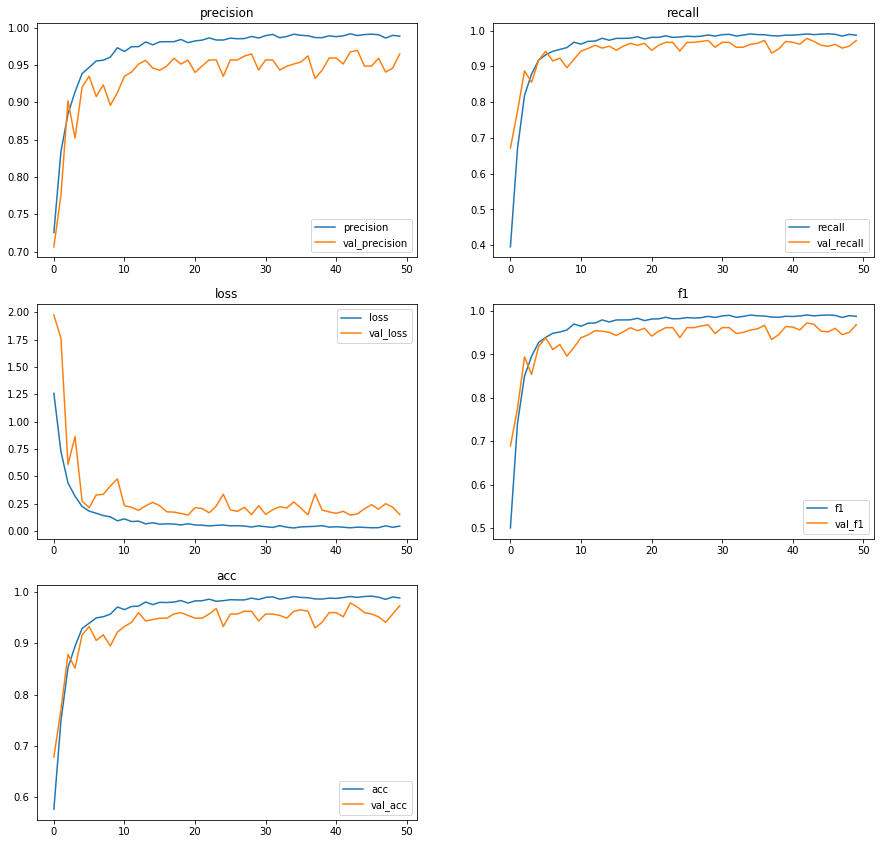

In [10]:
def plot_model(model):
    plots = [i for i in model.model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.model.history.history[p], label=p)
        plt.plot(model.model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [11]:
from keras.models import load_model

best_model = load_model('models/Model.h5', custom_objects={'recall': recall, 'precision': precision, 'f1': f1})

score, acc, recall, precision, f1 = best_model.evaluate(X_test, y_test, batch_size=64)

idx = len(results) + 1
results.loc[idx] = ['CNN - Transfer Learning', acc, precision, recall, f1]

print('Test score:', score)

results

 64/369 [====>.........................] - ETA: 0s

128/369 [=========>....................] - ETA: 0s

192/369 [==============>...............] - ETA: 0s

256/369 [===================>..........] - ETA: 0s

320/369 [=========================>....] - ETA: 0s

369/369 [==============================] - 0s     


Test score: 0.305191421351


,Model,Accuracy,Precision,Recall,F1
1,CNN - Transfer Learning,0.95664,0.959005,0.95393,0.956448
